### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os
import numpy as np
import pulp
import pickle
import seaborn as sns
import time
import pandas as pd

from masserstein import Spectrum, estimate_proportions
from matplotlib import pyplot as plt
from textwrap import wrap

### Loading the data

In [4]:
official_names = ['Isopropyl_myristate', 'Benzyl_benzoate', 'Alpha_pinene', 'Limonene']

In [5]:
components = np.loadtxt(os.getcwd()+'/Mieszanina_perfumy.csv', skiprows=1, usecols=[0,1,2,4,5], #no menton
                      delimiter=',',dtype=float)

In [6]:
ppm_components = components[:,0]
components = components[:,1:]

In [7]:
mix = np.loadtxt(os.getcwd()+'/Mieszanina_perfumy_bez_menthonu.csv', skiprows=1, usecols=range(2), 
                  delimiter=',',dtype=float)

In [8]:
ppm = mix[:,0]

In [9]:
mix = mix[:,1]

In [10]:
#From email: 2.2449, 0.3269, 0.2533, 0.2651
r_sum = 2.2449 + 0.3269 + 0.2533 + 0.2651
molar_proportions = [2.2449/r_sum, 0.3269/r_sum, 0.2533/r_sum, 0.2651/r_sum]
print('Real proportions (molar):')
molar_proportions

Real proportions (molar):


[0.7264578344443725,
 0.10578603326645526,
 0.081968804608116,
 0.08578732768105625]

In [11]:
protons = [34, 12, 16, 16]

In [12]:
real_visible_proportions = [mol_prop*prot for mol_prop, prot in zip(molar_proportions, protons)]
real_visible_proportions = [x/sum(real_visible_proportions) for x in real_visible_proportions]
print('Proportions that should be visible in mixture computed based on number of H:')
real_visible_proportions

Proportions that should be visible in mixture computed based on number of H:


[0.8620208303686988,
 0.04430349725220739,
 0.04577169717134345,
 0.04790397520775029]

### Preprocessing

In [13]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [14]:
spectra = []
for comp_ints in components_ints:
    spectra.append(Spectrum(confs=list(zip(ppm_components, comp_ints))))

In [15]:
mix = Spectrum(confs=list(zip(ppm,mix)))

In [16]:
spectra_and_mixture = spectra + [mix]

<IPython.core.display.Javascript object>


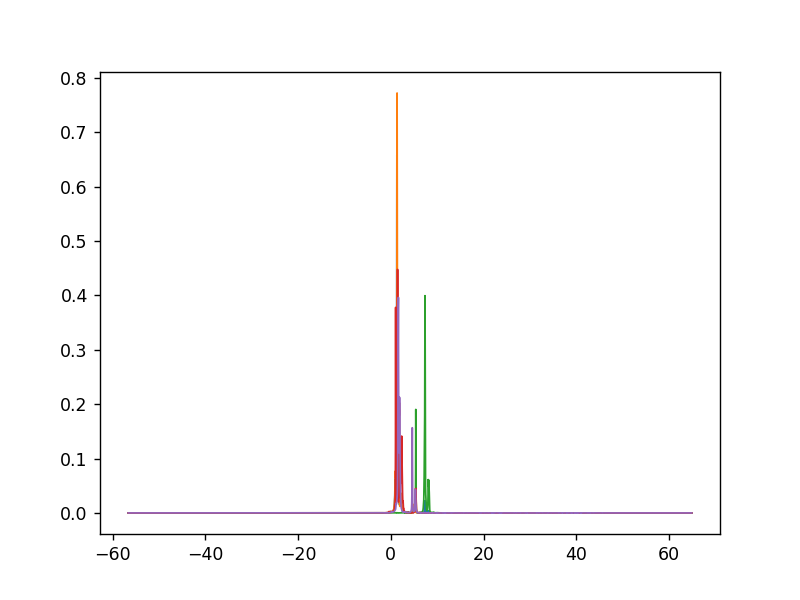

In [17]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)
spectra[2].plot(profile=True)
spectra[3].plot(profile=True)

### Additional preprocessing for this specific case

In [18]:
def cut_spectra_to_region(list_of_spectra, lower_bound, upper_bound):
    res = []
    for sp in list_of_spectra:
        ppm = np.array(sp.confs)[:,0]
        ints = np.array(sp.confs)[:,1]
        ppm_in_region = np.logical_and(ppm>lower_bound, ppm<upper_bound)
        new_ppm = ppm[ppm_in_region]
        new_ints = ints[ppm_in_region]
        res.append(masserstein.Spectrum(confs=list(zip(new_ppm, new_ints))))
    return res

In [19]:
preprocessed_spectra = cut_spectra_to_region(spectra_and_mixture, -1.5, 10.5)

In [20]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

### Preprocessing

In [21]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        shift_coef = (min_of_min - epsilon)*(-1)
        for i, arr in enumerate(old_confs):
            new_ppm_non_unique = arr[:,0] + shift_coef
            resampled = res[i].resample(np.unique(new_ppm_non_unique) - shift_coef)
            new_ppm_unique = np.array(resampled.confs)[:,0]
            new_ints = np.array(resampled.confs)[:,1]
            res[i] = Spectrum(confs=list(zip(new_ppm_unique + shift_coef, new_ints)))
        return(res)
    else:
        return(list_of_spectra)

In [22]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [23]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [24]:
spectra_and_mixture = spectra + [mix]

In [25]:
cma = common_mass_axis(spectra_and_mixture)

In [26]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [27]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [28]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [29]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [30]:
spectra_and_mixture = spectra + [mix]

In [31]:
spectra_and_mixture = shift(spectra_and_mixture)

In [32]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [33]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [34]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

<IPython.core.display.Javascript object>


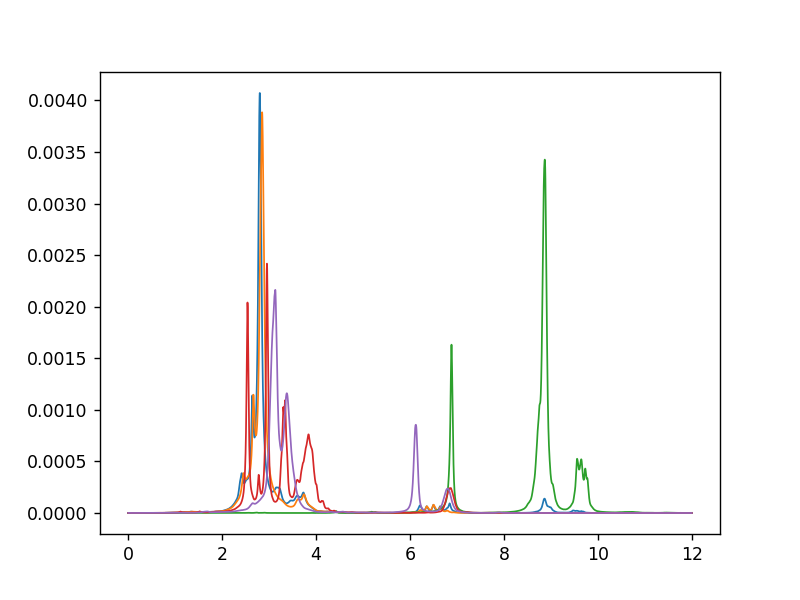

In [35]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 
comp2.plot(profile=True)
comp3.plot(profile=True)

### Finding best kappa

In [36]:
import time
import pandas as pd
import pulp

In [37]:
lower_limit = 0.01
upper_limit = 0.51
step = 0.01

In [43]:
# list_of_estimation_results = []
# for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
#     fixed_kappa = []
#     for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
#         start = time.time()
#         estimation = estimate_proportions(mix, [comp0, comp1, comp2, comp3], 
#                                    MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False))
#         end = time.time()
#         fixed_kappa.append(estimation['proportions'])
#         print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
#         print('It took: '+str(end-start)+' seconds.')
#         print(estimation['proportions'])
#     list_of_estimation_results.append(fixed_kappa)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 52593.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2384786.05it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.01 and 0.01 done
It took: 4.7183122634887695 seconds.
[0.7849758066999998, 0.031811065988999986, 0.0, 0.02860845208299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81840.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2438694.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.01 and 0.02 done
It took: 5.595263719558716 seconds.
[0.6206311568499998, 0.03293616856699998, 0.024491395727999993, 0.023905797172999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3231519.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


Estimation for 0.01 and 0.03 done
It took: 5.805852651596069 seconds.
[0.4355402369479998, 0.03037973767999999, 0.039137457568999987, 0.04396591431899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3320079.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.10s/it]


Estimation for 0.01 and 0.04 done
It took: 7.126984357833862 seconds.
[0.3859846048449999, 0.02626214392999999, 0.031438085822999985, 0.05210995104899998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3388816.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Estimation for 0.01 and 0.05 done
It took: 5.142888307571411 seconds.
[0.3619440824799999, 0.025120781111999994, 0.03962945796999998, 0.03960218477299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73908.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2578131.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.72s/it]


Estimation for 0.01 and 0.060000000000000005 done
It took: 6.748065233230591 seconds.
[0.3528117137279999, 0.023784583032999993, 0.044231992700999985, 0.03467536685799998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3484942.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.59s/it]


Estimation for 0.01 and 0.06999999999999999 done
It took: 6.618856430053711 seconds.
[0.3471772936519999, 0.023434602435999992, 0.04813195775499999, 0.03075085747699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76608.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2446923.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.87s/it]


Estimation for 0.01 and 0.08 done
It took: 6.8949384689331055 seconds.
[0.3471827775749999, 0.023238240430999993, 0.049502819237999984, 0.02847320292899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3008463.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.58s/it]


Estimation for 0.01 and 0.09 done
It took: 6.607609510421753 seconds.
[0.3471894899919999, 0.022986354778999993, 0.05021211093199999, 0.02724469841999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3119169.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.86s/it]


Estimation for 0.01 and 0.09999999999999999 done
It took: 6.88655948638916 seconds.
[0.3472219971989999, 0.022726466401999993, 0.050670830639999984, 0.02642038827399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1723263.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.34s/it]


Estimation for 0.01 and 0.11 done
It took: 7.380886793136597 seconds.
[0.34723859795899986, 0.022441503932999995, 0.05066957805099999, 0.02642517133899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73262.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1828252.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:09<00:00,  9.05s/it]


Estimation for 0.01 and 0.12 done
It took: 9.100193977355957 seconds.
[0.3472462868689999, 0.022266165286999994, 0.05070363551199999, 0.02642822245799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2682088.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.27s/it]


Estimation for 0.01 and 0.13 done
It took: 8.30350136756897 seconds.
[0.3472610037279999, 0.021985344569999992, 0.050712476665999984, 0.02643289827999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2591309.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.85s/it]


Estimation for 0.01 and 0.14 done
It took: 7.8761327266693115 seconds.
[0.3472734541579999, 0.021768658993999993, 0.05071018345599999, 0.02643651073699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2914916.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.80s/it]


Estimation for 0.01 and 0.15000000000000002 done
It took: 7.833871603012085 seconds.
[0.34728343764699987, 0.02157083400699999, 0.05070788950399999, 0.026439702398999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2879868.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.86s/it]


Estimation for 0.01 and 0.16 done
It took: 7.884334325790405 seconds.
[0.3472900319779999, 0.02144350822699999, 0.05070643748199999, 0.026441769612999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2040281.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.78s/it]


Estimation for 0.01 and 0.17 done
It took: 7.819486856460571 seconds.
[0.3472951074259999, 0.02132065207999999, 0.050704849965999985, 0.02644366526699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108240.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3014716.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.10s/it]


Estimation for 0.01 and 0.18000000000000002 done
It took: 8.127707719802856 seconds.
[0.3472978096569999, 0.021302473964999992, 0.050704897689999986, 0.02644409579299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 128070.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2695101.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.27s/it]


Estimation for 0.01 and 0.19 done
It took: 8.302230596542358 seconds.
[0.3472990957309999, 0.021302552849999993, 0.050705085454999986, 0.02644419371799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2962883.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.72s/it]


Estimation for 0.01 and 0.2 done
It took: 7.7486443519592285 seconds.
[0.3473005470489999, 0.02130264187099999, 0.05070529734499998, 0.02644430422499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2865171.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.44s/it]


Estimation for 0.01 and 0.21000000000000002 done
It took: 7.4697184562683105 seconds.
[0.3473018666459999, 0.021277180795999995, 0.05070500712399999, 0.02644471767399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 46733.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2317263.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.11s/it]


Estimation for 0.01 and 0.22 done
It took: 8.147314071655273 seconds.
[0.3473032919859999, 0.021277268117999994, 0.05070521521899998, 0.026444826203999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2751192.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


Estimation for 0.01 and 0.23 done
It took: 7.608273983001709 seconds.
[0.3473047137339999, 0.021274359337999992, 0.050705366151999984, 0.02644497116899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 78766.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2798825.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.59s/it]


Estimation for 0.01 and 0.24000000000000002 done
It took: 7.615905284881592 seconds.
[0.3473060581159999, 0.021274096894999994, 0.050705555908999986, 0.02644507775999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 40721.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2246284.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.59s/it]


Estimation for 0.01 and 0.25 done
It took: 7.624077558517456 seconds.
[0.3473073055879999, 0.021274173308999993, 0.05070573803499999, 0.02644517274699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 78766.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2998615.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.74s/it]


Estimation for 0.01 and 0.26 done
It took: 7.766373157501221 seconds.
[0.3473086231139999, 0.021274254012999993, 0.05070593038999999, 0.02644527306799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2495335.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.88s/it]


Estimation for 0.01 and 0.27 done
It took: 7.910772323608398 seconds.
[0.3473099334349999, 0.021274334275999993, 0.050706121692999984, 0.026445372839999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 125203.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2623995.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.96s/it]


Estimation for 0.01 and 0.28 done
It took: 7.992397785186768 seconds.
[0.3473110840019999, 0.021249489911999993, 0.05070581864799999, 0.02644576573499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72005.22it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2623863.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.35s/it]


Estimation for 0.01 and 0.29000000000000004 done
It took: 7.385351657867432 seconds.
[0.34731245763899987, 0.02123278744199999, 0.05070570183799999, 0.026446076018999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3172421.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.78s/it]


Estimation for 0.01 and 0.3 done
It took: 6.80435848236084 seconds.
[0.3473137288819999, 0.021186085397999994, 0.05070500304499999, 0.026446746019999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3169918.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.90s/it]


Estimation for 0.01 and 0.31 done
It took: 6.920083284378052 seconds.
[0.3473146769709999, 0.021184794941999992, 0.050705115968999986, 0.026446834733999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3217381.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.92s/it]


Estimation for 0.01 and 0.32 done
It took: 6.943430662155151 seconds.
[0.3473157233119999, 0.021181608139999992, 0.05070520727199999, 0.02644695423999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3178601.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.80s/it]


Estimation for 0.01 and 0.33 done
It took: 6.828931093215942 seconds.
[0.3473172328839999, 0.021141109390999994, 0.05070466027399999, 0.02644756655699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1772580.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.18s/it]


Estimation for 0.01 and 0.34 done
It took: 7.211951017379761 seconds.
[0.3473184438799999, 0.021116163252999993, 0.05070436405799999, 0.02644796534499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3137914.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.82s/it]


Estimation for 0.01 and 0.35000000000000003 done
It took: 6.848500728607178 seconds.
[0.3473209256989999, 0.02109425880499999, 0.050695361262999984, 0.02644834772599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1928955.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.75s/it]


Estimation for 0.01 and 0.36000000000000004 done
It took: 6.784940958023071 seconds.
[0.3473219186289999, 0.021088942810999992, 0.050695510330999984, 0.02644849012299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 140985.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3297851.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.75s/it]


Estimation for 0.01 and 0.37 done
It took: 6.776128053665161 seconds.
[0.3473231089409999, 0.021088744913999993, 0.05069568427799999, 0.02644858412099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2946830.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.70s/it]


Estimation for 0.01 and 0.38 done
It took: 6.724865436553955 seconds.
[0.3473239075289999, 0.021088793402999993, 0.050695800840999984, 0.02644864493399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 153919.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3343464.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.76s/it]


Estimation for 0.01 and 0.39 done
It took: 6.784379005432129 seconds.
[0.3473248269119999, 0.021087985913999994, 0.050695935699999986, 0.02644872566899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3025722.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.84s/it]


Estimation for 0.01 and 0.4 done
It took: 6.870250940322876 seconds.
[0.3473274386989999, 0.021057630044999994, 0.05068710514899999, 0.02644922428999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3081251.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.78s/it]


Estimation for 0.01 and 0.41000000000000003 done
It took: 6.8056817054748535 seconds.
[0.3473308326309999, 0.02104697395299999, 0.05067159763599999, 0.02644948014899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81840.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3100830.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.96s/it]


Estimation for 0.01 and 0.42000000000000004 done
It took: 6.989232540130615 seconds.
[0.3473333612389999, 0.021043945707999993, 0.05066040650299999, 0.02644961291399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2847981.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.39s/it]


Estimation for 0.01 and 0.43 done
It took: 7.4175426959991455 seconds.
[0.3473340685909999, 0.021002469109999995, 0.050660535777999983, 0.02645018249199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3055289.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.43s/it]


Estimation for 0.01 and 0.44 done
It took: 7.454782247543335 seconds.
[0.3473349076449999, 0.02099555004499999, 0.050660662539999984, 0.02645033295999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3173000.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.23s/it]


Estimation for 0.01 and 0.45 done
It took: 7.256577968597412 seconds.
[0.3473358068749999, 0.02098742755899999, 0.05066079883899999, 0.02645050300299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2956508.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.28s/it]


Estimation for 0.01 and 0.46 done
It took: 7.304420709609985 seconds.
[0.3473446542059999, 0.020958595014999994, 0.050610299897999984, 0.02645109653999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 30897.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2929306.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.53s/it]


Estimation for 0.01 and 0.47000000000000003 done
It took: 7.557969570159912 seconds.
[0.3473456971339999, 0.020924304122999993, 0.05061009437199999, 0.02645159941399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73262.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1757899.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.95s/it]


Estimation for 0.01 and 0.48000000000000004 done
It took: 6.985798597335815 seconds.
[0.34734634905599987, 0.020901142781999994, 0.050609947933999984, 0.02645193503499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3354203.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.03s/it]


Estimation for 0.01 and 0.49 done
It took: 7.057904005050659 seconds.
[0.3470495267999999, 0.020900927576999993, 0.05063509642299999, 0.026456180542999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2313464.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.22s/it]


Estimation for 0.01 and 0.5 done
It took: 7.252127170562744 seconds.
[0.3470504056549999, 0.02090098050599999, 0.050635224649999984, 0.02645624753899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3062995.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.02 and 0.01 done
It took: 4.694099426269531 seconds.
[0.8931573429879996, 0.02839922539699999, 0.0, 0.022507273662999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3104887.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.02 and 0.02 done
It took: 4.861865043640137 seconds.
[0.7956611947399997, 0.03211424417299999, 0.0, 0.02869179619299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3128513.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.22s/it]


Estimation for 0.02 and 0.03 done
It took: 5.251401901245117 seconds.
[0.7273005379349998, 0.03340921131699998, 0.011892880846999996, 0.023359596348999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3064793.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


Estimation for 0.02 and 0.04 done
It took: 4.955624103546143 seconds.
[0.6495121396759997, 0.033342089882999984, 0.022545736200999995, 0.02346953819099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 61455.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3098990.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.67s/it]


Estimation for 0.02 and 0.05 done
It took: 6.704086542129517 seconds.
[0.5384393678719998, 0.032753963487999985, 0.03223956067999999, 0.03048877093799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1979936.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.58s/it]


Estimation for 0.02 and 0.060000000000000005 done
It took: 6.6139984130859375 seconds.
[0.47965168583799983, 0.03103595379599999, 0.03713622194199999, 0.036485868407999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85163.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2644059.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:09<00:00,  9.76s/it]


Estimation for 0.02 and 0.06999999999999999 done
It took: 9.798429250717163 seconds.
[0.45147679894099985, 0.02932285502599999, 0.03012484428299999, 0.04446196028799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 43804.74it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1460352.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:09<00:00,  9.67s/it]


Estimation for 0.02 and 0.08 done
It took: 9.721837759017944 seconds.
[0.4403368803239998, 0.02820775248299999, 0.024543020059999993, 0.047979211953999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2942678.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.23s/it]


Estimation for 0.02 and 0.09 done
It took: 8.25940489768982 seconds.
[0.43197938154099985, 0.02757758619799999, 0.02190147971199999, 0.04988422416699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 33961.98it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2883844.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.98s/it]


Estimation for 0.02 and 0.09999999999999999 done
It took: 8.015792608261108 seconds.
[0.43047171324199984, 0.02683276762199999, 0.020009183995999994, 0.050165584945999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106861.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2777978.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.34s/it]


Estimation for 0.02 and 0.11 done
It took: 8.369699478149414 seconds.
[0.4302014164399998, 0.02646366054499999, 0.019844412838999993, 0.049912552174999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 30120.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2734909.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.13s/it]


Estimation for 0.02 and 0.12 done
It took: 8.158852338790894 seconds.
[0.43023454428299984, 0.02634802123399999, 0.020524652148999994, 0.049129650652999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72005.22it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2743531.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.23s/it]


Estimation for 0.02 and 0.13 done
It took: 8.267227411270142 seconds.
[0.42996329060699984, 0.02615267355799999, 0.023005638102999992, 0.046577047763999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 78766.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2842245.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.36s/it]


Estimation for 0.02 and 0.14 done
It took: 8.394827365875244 seconds.
[0.4297831037659998, 0.02601686428599999, 0.024553180441999993, 0.045016245512999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2727765.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.27s/it]


Estimation for 0.02 and 0.15000000000000002 done
It took: 8.302818298339844 seconds.
[0.42941191040099985, 0.025771016618999994, 0.026402658773999988, 0.04350763967399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59283.45it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1514616.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.86s/it]


Estimation for 0.02 and 0.16 done
It took: 7.896413803100586 seconds.
[0.42932776913399984, 0.025532955836999993, 0.02738832373399999, 0.042428739340999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 130055.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3007770.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.12s/it]


Estimation for 0.02 and 0.17 done
It took: 7.1440019607543945 seconds.
[0.42932212399599984, 0.025354133061999993, 0.02755511422499999, 0.04229394643899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 140985.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3079979.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Estimation for 0.02 and 0.18000000000000002 done
It took: 5.939749717712402 seconds.
[0.42933643285199985, 0.025185501990999993, 0.02755324369799999, 0.04229845728299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3028705.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.02s/it]


Estimation for 0.02 and 0.19 done
It took: 7.043133974075317 seconds.
[0.42935096243599985, 0.025034188591999993, 0.02755167210499999, 0.04230267321599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3299102.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.02 and 0.2 done
It took: 5.325783729553223 seconds.
[0.42936187998799985, 0.024934804699999993, 0.02755072674599999, 0.042305579156999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3091833.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.24s/it]


Estimation for 0.02 and 0.21000000000000002 done
It took: 7.267536640167236 seconds.
[0.42936952318699984, 0.024848204988999992, 0.02754978478999999, 0.042307925055999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2913777.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.20s/it]


Estimation for 0.02 and 0.22 done
It took: 7.226435422897339 seconds.
[0.4293572364509998, 0.024779877511999993, 0.02764300147099999, 0.04230954967599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 99273.47it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2910366.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.13s/it]


Estimation for 0.02 and 0.23 done
It took: 7.151608467102051 seconds.
[0.4293642958789998, 0.02470076211099999, 0.02764058068499999, 0.04231167418599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3284368.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.09s/it]


Estimation for 0.02 and 0.24000000000000002 done
It took: 7.111023664474487 seconds.
[0.42938849956599984, 0.024655221927999994, 0.02754780856499999, 0.04231334637299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3266697.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.18s/it]


Estimation for 0.02 and 0.25 done
It took: 7.203980445861816 seconds.
[0.42917555599499985, 0.024620974407999992, 0.02765470762399999, 0.042318130933999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3123834.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.79s/it]


Estimation for 0.02 and 0.26 done
It took: 6.819341421127319 seconds.
[0.4291776692659998, 0.024618128164999992, 0.02765471825099999, 0.042318377519999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3247598.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.96s/it]


Estimation for 0.02 and 0.27 done
It took: 6.989135026931763 seconds.
[0.42917933288899984, 0.024618258613999994, 0.02765482693099999, 0.042318541107999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3192790.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.06s/it]


Estimation for 0.02 and 0.28 done
It took: 7.088584899902344 seconds.
[0.42875576628799983, 0.024618453356999994, 0.02786581342999999, 0.04232622672099998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3218571.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.04s/it]


Estimation for 0.02 and 0.29000000000000004 done
It took: 7.063750267028809 seconds.
[0.4287572649199998, 0.024618632173999993, 0.02786591232499999, 0.04232637295999998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3135087.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.84s/it]


Estimation for 0.02 and 0.3 done
It took: 6.862558841705322 seconds.
[0.42855346943399986, 0.024582148207999994, 0.02788108055499999, 0.04233159285099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3066593.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.94s/it]


Estimation for 0.02 and 0.31 done
It took: 6.965728521347046 seconds.
[0.42855480365299986, 0.024570023281999993, 0.02788096986099999, 0.042331948043999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3294314.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.15s/it]


Estimation for 0.02 and 0.32 done
It took: 7.1790852546691895 seconds.
[0.42855638397299983, 0.024554896760999992, 0.027880826365999988, 0.042332382761999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2739069.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.03s/it]


Estimation for 0.02 and 0.33 done
It took: 7.054366588592529 seconds.
[0.4285579823449998, 0.024546088590999993, 0.02788078629799999, 0.042332703596999983]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2921766.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.05s/it]


Estimation for 0.02 and 0.34 done
It took: 7.079935550689697 seconds.
[0.42855926697499985, 0.024545803106999994, 0.027880864060999988, 0.04233283706599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2365554.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.14s/it]


Estimation for 0.02 and 0.35000000000000003 done
It took: 7.171616315841675 seconds.
[0.4285608240839998, 0.024545868651999994, 0.02788096497999999, 0.042332991308999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3367399.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.10s/it]


Estimation for 0.02 and 0.36000000000000004 done
It took: 7.128166913986206 seconds.
[0.4285623683359998, 0.024545980737999993, 0.02788106582699999, 0.04233314341699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 115704.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3288919.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.46s/it]


Estimation for 0.02 and 0.37 done
It took: 7.486213445663452 seconds.
[0.4285636623599998, 0.024546054852999995, 0.027881150011999988, 0.042333271239999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3006211.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.77s/it]


Estimation for 0.02 and 0.38 done
It took: 7.796180009841919 seconds.
[0.42856556360899983, 0.024545318927999993, 0.02788126002799999, 0.04233347451199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3167418.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.06s/it]


Estimation for 0.02 and 0.39 done
It took: 7.087053298950195 seconds.
[0.4285670728839998, 0.024545405368999993, 0.02788135821699999, 0.042333623597999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3400513.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.23s/it]


Estimation for 0.02 and 0.4 done
It took: 8.253604173660278 seconds.
[0.42856843071199985, 0.024545483136999995, 0.02788144655399999, 0.042333757722999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71392.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2927992.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.98s/it]


Estimation for 0.02 and 0.41000000000000003 done
It took: 9.0116126537323 seconds.
[0.4285700508929998, 0.02454557592899999, 0.02788155195799999, 0.04233391776399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2705574.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:09<00:00,  9.12s/it]


Estimation for 0.02 and 0.42000000000000004 done
It took: 9.159422874450684 seconds.
[0.42857157894899983, 0.024545663445999993, 0.02788165136899999, 0.042334068703999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98112.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2678236.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.56s/it]


Estimation for 0.02 and 0.43 done
It took: 8.595197677612305 seconds.
[0.4285727815229998, 0.024544047912999994, 0.02788170234099999, 0.04233421833399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2768698.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.59s/it]


Estimation for 0.02 and 0.44 done
It took: 8.622849941253662 seconds.
[0.42857360391599986, 0.024544095010999994, 0.02788175584299999, 0.042334299569999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 52924.97it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2158978.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.40s/it]


Estimation for 0.02 and 0.45 done
It took: 8.436124086380005 seconds.
[0.42857508461199983, 0.02451162603699999, 0.027881325249999988, 0.04233504187299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108240.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2845343.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.43s/it]


Estimation for 0.02 and 0.46 done
It took: 8.46282696723938 seconds.
[0.42857642057699985, 0.024511810189999993, 0.02788141390599999, 0.04233517186799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 56111.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2916544.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.27s/it]


Estimation for 0.02 and 0.47000000000000003 done
It took: 8.300630331039429 seconds.
[0.42857764416099986, 0.02447723314299999, 0.02788093270199999, 0.04233592710199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3267719.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.58s/it]


Estimation for 0.02 and 0.48000000000000004 done
It took: 7.603356599807739 seconds.
[0.42857892045299983, 0.024477306035999992, 0.02788101573099999, 0.04233605317699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3342394.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.49s/it]


Estimation for 0.02 and 0.49 done
It took: 7.510922908782959 seconds.
[0.42858010048899986, 0.024477373430999993, 0.02788109249699999, 0.042336169743999987]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3344964.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.36s/it]


Estimation for 0.02 and 0.5 done
It took: 7.385655164718628 seconds.
[0.4285810757879998, 0.024476698622999993, 0.027881144120999988, 0.042336279460999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3226527.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.03 and 0.01 done
It took: 4.557671546936035 seconds.
[0.9272446373339996, 0.03524743613699999, 0.0, 0.014778130621999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3055110.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.03 and 0.02 done
It took: 4.792793035507202 seconds.
[0.8718603623559996, 0.02994757490499999, 0.0, 0.026632202046999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3265267.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.94s/it]


Estimation for 0.03 and 0.03 done
It took: 4.962283134460449 seconds.
[0.8135321277559998, 0.03262462567099999, 0.0, 0.02885213688299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1875534.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.03 and 0.04 done
It took: 5.459787607192993 seconds.
[0.7824583411269997, 0.033639114109999986, 0.003643383720999999, 0.024946932574999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3240544.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.02s/it]


Estimation for 0.03 and 0.05 done
It took: 5.045989036560059 seconds.
[0.7351551743429998, 0.034241959868999985, 0.013739932407999995, 0.022870836112999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3202581.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.03 and 0.060000000000000005 done
It took: 5.391881704330444 seconds.
[0.6844387180579998, 0.03402956322099999, 0.020868858877999993, 0.023795052044999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3273660.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.03 and 0.06999999999999999 done
It took: 5.441607713699341 seconds.
[0.6266992122409998, 0.03350266312199999, 0.02648383273099999, 0.02684455991399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3032223.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.03 and 0.08 done
It took: 5.7410173416137695 seconds.
[0.5859137016939998, 0.033068643352999985, 0.02992108664899999, 0.02913766388399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2916707.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.03 and 0.09 done
It took: 5.541306018829346 seconds.
[0.5553085265059998, 0.03218128221899998, 0.03279236572899999, 0.03088494999399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 33026.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3179182.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.03 and 0.09999999999999999 done
It took: 5.414022445678711 seconds.
[0.5412118758409997, 0.03101117705199999, 0.034206453253999985, 0.031358222924999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2913939.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.03 and 0.11 done
It took: 5.558333873748779 seconds.
[0.5245634715639997, 0.02990847331499999, 0.03549773212299999, 0.03248300950399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3228322.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Estimation for 0.03 and 0.12 done
It took: 5.297855377197266 seconds.
[0.5212542669029998, 0.02909338721399999, 0.035392904937999986, 0.03182181186399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3301605.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Estimation for 0.03 and 0.13 done
It took: 5.719776153564453 seconds.
[0.5127194725249998, 0.02856266995799999, 0.03585584025999999, 0.03163215406999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2818465.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Estimation for 0.03 and 0.14 done
It took: 5.938672780990601 seconds.
[0.5052123456899997, 0.02823858738499999, 0.03643910385899998, 0.031336362052999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 27413.75it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2425440.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Estimation for 0.03 and 0.15000000000000002 done
It took: 5.8155224323272705 seconds.
[0.5052407194109998, 0.02788078301499999, 0.03646739794299999, 0.031324989673999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 34592.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3164347.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Estimation for 0.03 and 0.16 done
It took: 5.3945722579956055 seconds.
[0.5052653376019998, 0.02751949169899999, 0.036516445096999986, 0.03130271681699998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3207499.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


Estimation for 0.03 and 0.17 done
It took: 5.884799242019653 seconds.
[0.5052770671999998, 0.02718617615299999, 0.036606428454999985, 0.03125838342899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3217381.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.20s/it]


Estimation for 0.03 and 0.18000000000000002 done
It took: 7.226176738739014 seconds.
[0.5053012941079997, 0.02699924070699999, 0.03660841207399999, 0.03125986467699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3291407.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.29s/it]


Estimation for 0.03 and 0.19 done
It took: 7.314770936965942 seconds.
[0.5053216877769998, 0.02686433909799999, 0.03661005458999999, 0.03126111364799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2950327.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.32s/it]


Estimation for 0.03 and 0.2 done
It took: 7.3436198234558105 seconds.
[0.5053355563439997, 0.02674437969499999, 0.03660859041999999, 0.03136795159799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3168379.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.26s/it]


Estimation for 0.03 and 0.21000000000000002 done
It took: 7.288578987121582 seconds.
[0.5053515831879998, 0.02668598245999999, 0.03660980095999999, 0.031369848833999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3283748.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.37s/it]


Estimation for 0.03 and 0.22 done
It took: 7.395570516586304 seconds.
[0.5053649256569998, 0.02665855152799999, 0.036610791046999984, 0.031371105615999983]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3213026.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.32s/it]


Estimation for 0.03 and 0.23 done
It took: 8.341872215270996 seconds.
[0.5053754947609997, 0.026620808223999988, 0.03661158871199999, 0.031372345082999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2846273.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.25s/it]


Estimation for 0.03 and 0.24000000000000002 done
It took: 7.289267539978027 seconds.
[0.5053928000129998, 0.02657661900199999, 0.036615560328999985, 0.031265485784999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94786.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1909276.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.29s/it]


Estimation for 0.03 and 0.25 done
It took: 8.336359977722168 seconds.
[0.5054006371349998, 0.02656011102099999, 0.03661614865799999, 0.03126596904399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 82646.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2641785.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.36s/it]


Estimation for 0.03 and 0.26 done
It took: 8.389727592468262 seconds.
[0.5054020836499997, 0.02651452066599999, 0.036614528500999985, 0.03133820539699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2824258.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.78s/it]


Estimation for 0.03 and 0.27 done
It took: 7.8069610595703125 seconds.
[0.5053997105909998, 0.02650528410999999, 0.03662675502199999, 0.031375892242999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 77314.36it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2803484.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.01s/it]


Estimation for 0.03 and 0.28 done
It took: 8.03754997253418 seconds.
[0.5054034499429998, 0.02648948674199999, 0.036627034672999985, 0.03137636789699998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2679885.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.56s/it]


Estimation for 0.03 and 0.29000000000000004 done
It took: 8.592767000198364 seconds.
[0.5054079404249998, 0.02647299353499999, 0.03662736915699999, 0.031376901376999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3029584.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.45s/it]


Estimation for 0.03 and 0.3 done
It took: 6.4802281856536865 seconds.
[0.5054128836989997, 0.02645395125699999, 0.036627737846999985, 0.03137750213899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1713030.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.84s/it]


Estimation for 0.03 and 0.31 done
It took: 8.873644590377808 seconds.
[0.5054159946029998, 0.02642314775399999, 0.036627980057999984, 0.031378166753999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86928.58it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2842554.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.58s/it]


Estimation for 0.03 and 0.32 done
It took: 8.610675573348999 seconds.
[0.5054226777809998, 0.02642013261299999, 0.03661517655999998, 0.031378368513999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83468.74it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2965912.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.25s/it]


Estimation for 0.03 and 0.33 done
It took: 8.282973051071167 seconds.
[0.5054248270129997, 0.02642024496099999, 0.036615332260999986, 0.03137850194599998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 142179.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1973202.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.45s/it]


Estimation for 0.03 and 0.34 done
It took: 8.489413022994995 seconds.
[0.5054271824739998, 0.02640893068999999, 0.036615512454999985, 0.031378822388999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 120699.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2075643.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.64s/it]


Estimation for 0.03 and 0.35000000000000003 done
It took: 8.68572211265564 seconds.
[0.5054292400269997, 0.02639177738999999, 0.03661567593299998, 0.03137921303699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 50994.58it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1562571.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.32s/it]


Estimation for 0.03 and 0.36000000000000004 done
It took: 8.354605436325073 seconds.
[0.5054403204819998, 0.02638882762199999, 0.03661923408499999, 0.031268407865999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3150599.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.26s/it]


Estimation for 0.03 and 0.37 done
It took: 8.291504621505737 seconds.
[0.5054417474639997, 0.02638087694499999, 0.03661934720799999, 0.03126849539699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88768.34it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2336027.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.41s/it]


Estimation for 0.03 and 0.38 done
It took: 8.441996335983276 seconds.
[0.5054435168049998, 0.02637099065299999, 0.036619487505999984, 0.031268603925999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81840.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2618863.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.51s/it]


Estimation for 0.03 and 0.39 done
It took: 8.545868396759033 seconds.
[0.5054454862939998, 0.02637109340899999, 0.03661963019599999, 0.03126872576599998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3043890.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.52s/it]


Estimation for 0.03 and 0.4 done
It took: 8.54960298538208 seconds.
[0.5054608504669997, 0.02637057004999999, 0.036574924751999985, 0.03129292900099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90687.65it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2819835.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.09s/it]


Estimation for 0.03 and 0.41000000000000003 done
It took: 8.12531042098999 seconds.
[0.5054624376389998, 0.02637065285499999, 0.036575039598999985, 0.031293027262999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 44034.69it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2758897.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.59s/it]


Estimation for 0.03 and 0.42000000000000004 done
It took: 8.624400854110718 seconds.
[0.5054643204049998, 0.02637075108099999, 0.03657517583499999, 0.03129314382399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2717968.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.65s/it]


Estimation for 0.03 and 0.43 done
It took: 8.68028473854065 seconds.
[0.5054664968349998, 0.02637086462799999, 0.036575333320999985, 0.031293278565999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2812241.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.84s/it]


Estimation for 0.03 and 0.44 done
It took: 8.866586208343506 seconds.
[0.5054680840169998, 0.02637094743399999, 0.036575448167999985, 0.031293376827999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 78766.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2649157.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.88s/it]


Estimation for 0.03 and 0.45 done
It took: 8.907289505004883 seconds.
[0.5054697275239998, 0.02637103317799999, 0.03657556709199999, 0.03129347857699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2324380.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.64s/it]


Estimation for 0.03 and 0.46 done
It took: 8.677962064743042 seconds.
[0.5054712509849998, 0.02636253952099999, 0.03657568634099999, 0.031293572801999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93727.46it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2387184.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:09<00:00,  9.10s/it]


Estimation for 0.03 and 0.47000000000000003 done
It took: 9.133896112442017 seconds.
[0.5054729567129997, 0.02636262848299999, 0.036575809766999985, 0.031293678402999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 60567.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2609048.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.85s/it]


Estimation for 0.03 and 0.48000000000000004 done
It took: 8.889414072036743 seconds.
[0.5054859874059998, 0.02636158092099999, 0.03653652986199998, 0.03131489833799998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98112.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1725541.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.80s/it]


Estimation for 0.03 and 0.49 done
It took: 8.833625078201294 seconds.
[0.5054878410659998, 0.02635703212999999, 0.03653668027599999, 0.03131500726199998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2807101.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.78s/it]


Estimation for 0.03 and 0.5 done
It took: 8.819050550460815 seconds.
[0.5054896033569998, 0.026357124018999988, 0.036536807653999984, 0.03131511643599998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2670838.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Estimation for 0.04 and 0.01 done
It took: 5.410760402679443 seconds.
[0.9393608895529997, 0.044278853016999985, 0.0, 0.008526531408999996]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 120699.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2632727.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.63s/it]


Estimation for 0.04 and 0.02 done
It took: 5.659506797790527 seconds.
[0.8996430894479996, 0.03062258339099999, 0.0, 0.02680984182099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2464477.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Estimation for 0.04 and 0.03 done
It took: 5.934010982513428 seconds.
[0.8715824294549996, 0.031441224041999984, 0.0, 0.028541201483999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 63791.70it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2680023.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


Estimation for 0.04 and 0.04 done
It took: 5.776024341583252 seconds.
[0.8413735897149996, 0.032970144589999986, 0.0, 0.02742743953999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2811030.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.04 and 0.05 done
It took: 5.742624044418335 seconds.
[0.8161943640789998, 0.03387181132799998, 0.0, 0.02666607294699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3047087.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Estimation for 0.04 and 0.060000000000000005 done
It took: 5.336356163024902 seconds.
[0.7914200067249998, 0.03450544416399998, 0.007515365449999998, 0.024002771975999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3316283.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.15s/it]


Estimation for 0.04 and 0.06999999999999999 done
It took: 5.1754138469696045 seconds.
[0.7574617986579998, 0.034982915466999984, 0.014261539436999995, 0.023996688970999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 78766.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3278388.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.04 and 0.08 done
It took: 5.463082790374756 seconds.
[0.7251751339219997, 0.034859426637999985, 0.018925667207999992, 0.024661258391999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3261188.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Estimation for 0.04 and 0.09 done
It took: 5.638229608535767 seconds.
[0.6964320087779998, 0.034521495037999984, 0.021861206106999993, 0.025866355715999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2973174.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.04 and 0.09999999999999999 done
It took: 5.437118291854858 seconds.
[0.6719241161949998, 0.03414630567999999, 0.024029987935999992, 0.026411959257999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3121966.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Estimation for 0.04 and 0.11 done
It took: 5.410816669464111 seconds.
[0.6557093343699998, 0.033690785995999985, 0.025401808878999992, 0.02681346315099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3028179.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


Estimation for 0.04 and 0.12 done
It took: 5.884055137634277 seconds.
[0.6452093429739998, 0.032859010682999984, 0.02646772977499999, 0.026604787788999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2603844.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.29s/it]


Estimation for 0.04 and 0.13 done
It took: 5.320401906967163 seconds.
[0.6291935304549998, 0.032090116470999984, 0.02801428784799999, 0.02684382130999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86928.58it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3006731.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.04 and 0.14 done
It took: 5.435553312301636 seconds.
[0.6258938028379998, 0.03149859238999999, 0.02843243422299999, 0.02609493609699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3046909.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.04 and 0.15000000000000002 done
It took: 5.5318403244018555 seconds.
[0.6234012896749997, 0.03104066986299999, 0.02887348238799999, 0.025269242754999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3091467.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


Estimation for 0.04 and 0.16 done
It took: 5.83062481880188 seconds.
[0.6157847704619998, 0.03059840683699999, 0.029873336859999988, 0.024907635602999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3206515.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


Estimation for 0.04 and 0.17 done
It took: 5.777739763259888 seconds.
[0.6158604855319998, 0.03009201294399999, 0.02987759605699999, 0.024910660442999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3231319.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.82s/it]


Estimation for 0.04 and 0.18000000000000002 done
It took: 5.844862222671509 seconds.
[0.6158971931789998, 0.02978775377899999, 0.02993952552499999, 0.024906482407999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3284988.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Estimation for 0.04 and 0.19 done
It took: 5.272672653198242 seconds.
[0.6159629639619998, 0.02932452016499999, 0.02994309110499999, 0.024909123433999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3204940.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.04 and 0.2 done
It took: 5.4444215297698975 seconds.
[0.6160123286539998, 0.02901349192199999, 0.02994573832299999, 0.024911107143999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2847049.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.84s/it]


Estimation for 0.04 and 0.21000000000000002 done
It took: 5.864323139190674 seconds.
[0.6160474813239998, 0.02877801847399999, 0.02997213291399999, 0.02491020844499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3138102.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Estimation for 0.04 and 0.22 done
It took: 5.817098379135132 seconds.
[0.6160816876809998, 0.02855964402699999, 0.02997423275699999, 0.024911558074999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2969454.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.04 and 0.23 done
It took: 5.38413143157959 seconds.
[0.6161061209419998, 0.02837634607099999, 0.02997578674699999, 0.024912517939999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 133152.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2929142.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Estimation for 0.04 and 0.24000000000000002 done
It took: 6.0365073680877686 seconds.
[0.6161247404569998, 0.02828948885399999, 0.029976866360999988, 0.024913257460999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3282510.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.42s/it]


Estimation for 0.04 and 0.25 done
It took: 7.449038028717041 seconds.
[0.6161376150569998, 0.02822842015399999, 0.02997761486899999, 0.024913768653999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1794572.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Estimation for 0.04 and 0.26 done
It took: 5.6269004344940186 seconds.
[0.6161505383519997, 0.02816754896999999, 0.02997836535899999, 0.024914281846999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3275098.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.69s/it]


Estimation for 0.04 and 0.27 done
It took: 7.711217403411865 seconds.
[0.6161618203119997, 0.02809583071499999, 0.02997905732399999, 0.024914727028999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3104149.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.62s/it]


Estimation for 0.04 and 0.28 done
It took: 7.648485898971558 seconds.
[0.6156908480939998, 0.02806996702499999, 0.03002521140999999, 0.025000689829999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95869.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3128326.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Estimation for 0.04 and 0.29000000000000004 done
It took: 5.8767876625061035 seconds.
[0.6156979069319998, 0.02802477587699999, 0.03002562950399999, 0.025000944780999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3160707.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.41s/it]


Estimation for 0.04 and 0.3 done
It took: 7.439875841140747 seconds.
[0.6156515929279998, 0.02798191036499999, 0.030009991686999988, 0.025014234115999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 212369.82it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3038399.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.59s/it]


Estimation for 0.04 and 0.31 done
It took: 7.619599342346191 seconds.
[0.6156476911469998, 0.02797889071699999, 0.03000675337299999, 0.025017524342999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3362628.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.36s/it]


Estimation for 0.04 and 0.32 done
It took: 7.384233713150024 seconds.
[0.6153383468239998, 0.02793757961399999, 0.030036170655999988, 0.025074114958999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2954166.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.35s/it]


Estimation for 0.04 and 0.33 done
It took: 7.378509283065796 seconds.
[0.6151919055359998, 0.027894234939999988, 0.03005064897499999, 0.025101733416999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3155359.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.04 and 0.34 done
It took: 5.5386152267456055 seconds.
[0.6148991653809998, 0.02787253015399999, 0.03008005496799999, 0.025113762436999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3406281.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:09<00:00,  9.09s/it]


Estimation for 0.04 and 0.35000000000000003 done
It took: 9.119774103164673 seconds.
[0.6114142929699998, 0.02787371978299999, 0.03038167726999999, 0.025166514908999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2855144.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:09<00:00,  9.61s/it]


Estimation for 0.04 and 0.36000000000000004 done
It took: 9.64518666267395 seconds.
[0.6114165573899998, 0.02787382301599999, 0.03038178979099999, 0.025166608114999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118987.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2740939.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.80s/it]


Estimation for 0.04 and 0.37 done
It took: 6.829836368560791 seconds.
[0.6114181715059998, 0.02786434297299999, 0.03038200697199999, 0.025166853647999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 121574.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2904861.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.44s/it]


Estimation for 0.04 and 0.38 done
It took: 8.470555067062378 seconds.
[0.6113720032109998, 0.02783291890299999, 0.030430325110999988, 0.025167890977999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2994659.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.64s/it]


Estimation for 0.04 and 0.39 done
It took: 8.675731658935547 seconds.
[0.6104439830979997, 0.02782027718899999, 0.030483112678999988, 0.025182381048999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 53261.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2863757.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.77s/it]


Estimation for 0.04 and 0.4 done
It took: 8.79537582397461 seconds.
[0.6104462818529998, 0.02781967862999999, 0.03048322848899999, 0.025182485689999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 24929.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2888471.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.55s/it]


Estimation for 0.04 and 0.41000000000000003 done
It took: 8.577815294265747 seconds.
[0.6104487625309998, 0.02779526065899999, 0.03048338788899999, 0.025182930240999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2894234.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.69s/it]


Estimation for 0.04 and 0.42000000000000004 done
It took: 8.715810537338257 seconds.
[0.6104517484469998, 0.02779539661499999, 0.03048353699399999, 0.025183053419999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2468088.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.89s/it]


Estimation for 0.04 and 0.43 done
It took: 6.917694568634033 seconds.
[0.6104598123859998, 0.02778982569999999, 0.03046831513199999, 0.025183247851999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 121574.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2688440.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.89s/it]


Estimation for 0.04 and 0.44 done
It took: 8.925050020217896 seconds.
[0.6104623072569998, 0.02778993927299999, 0.03046843965199999, 0.025183350772999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2722077.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:09<00:00,  9.35s/it]


Estimation for 0.04 and 0.45 done
It took: 9.383845806121826 seconds.
[0.6104645980789998, 0.02779004355799999, 0.03046855398799999, 0.025183445275999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 120699.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2944006.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:09<00:00,  9.17s/it]


Estimation for 0.04 and 0.46 done
It took: 9.200775384902954 seconds.
[0.6104672348149998, 0.02779016358999999, 0.03046868558899999, 0.025183554048999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2606313.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:09<00:00,  9.39s/it]


Estimation for 0.04 and 0.47000000000000003 done
It took: 9.421400547027588 seconds.
[0.6104699293539998, 0.02779028625199999, 0.03046882007499999, 0.025183665206999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118987.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2627693.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.64s/it]


Estimation for 0.04 and 0.48000000000000004 done
It took: 6.670627117156982 seconds.
[0.6104725073289998, 0.02779040360899999, 0.03046894874299999, 0.025183771555999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2795678.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:09<00:00,  9.07s/it]


Estimation for 0.04 and 0.49 done
It took: 9.101909875869751 seconds.
[0.6104748694979998, 0.02779051114199999, 0.03046906663899999, 0.02518386900199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3003272.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.82s/it]


Estimation for 0.04 and 0.5 done
It took: 7.844794273376465 seconds.
[0.6104766218289998, 0.02779059091299999, 0.03046915409899999, 0.025183941290999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3210852.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.29s/it]


Estimation for 0.05 and 0.01 done
It took: 5.313440799713135 seconds.
[0.9425329994719996, 0.04713862336899999, 0.0, 0.008403926280999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2995347.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.05 and 0.02 done
It took: 4.6249682903289795 seconds.
[0.9237335670329997, 0.033204822996999984, 0.0, 0.023941042767999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3344107.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.05 and 0.03 done
It took: 4.865860223770142 seconds.
[0.8963590210469997, 0.03131551236899999, 0.0, 0.03058439806299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 204600.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3241348.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.05 and 0.04 done
It took: 4.644099473953247 seconds.
[0.8823004859999997, 0.03254642167199999, 0.0, 0.02835743773899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3152501.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.05 and 0.05 done
It took: 4.749434947967529 seconds.
[0.8639136071189997, 0.03348613951899999, 0.0, 0.027554900144999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 55738.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3108214.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Estimation for 0.05 and 0.060000000000000005 done
It took: 4.991387367248535 seconds.
[0.8426665643649996, 0.03430629595999998, 0.0, 0.02782235215499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2934574.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.91s/it]


Estimation for 0.05 and 0.06999999999999999 done
It took: 4.9413816928863525 seconds.
[0.8238134544509997, 0.03480414176099999, 0.0042094426669999985, 0.026941817585999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3172421.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.02s/it]


Estimation for 0.05 and 0.08 done
It took: 5.051096677780151 seconds.
[0.8050213174739997, 0.035172914989999984, 0.009661182218999996, 0.02613096597799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2910529.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.15s/it]


Estimation for 0.05 and 0.09 done
It took: 5.180723667144775 seconds.
[0.7824952476199998, 0.03539022602799999, 0.013789191039999996, 0.025802618802999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3186360.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


Estimation for 0.05 and 0.09999999999999999 done
It took: 5.260302782058716 seconds.
[0.7648574697509998, 0.035317370633999985, 0.016321353484999992, 0.025544830242999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3188695.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Estimation for 0.05 and 0.11 done
It took: 5.624001741409302 seconds.
[0.7500398315239998, 0.035071109443999986, 0.017937543404999992, 0.025296541258999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2390901.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.10s/it]


Estimation for 0.05 and 0.12 done
It took: 5.134490966796875 seconds.
[0.7424108648849997, 0.034809456491999985, 0.018490333638999993, 0.025101191441999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72628.64it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2382718.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Estimation for 0.05 and 0.13 done
It took: 5.139510631561279 seconds.
[0.7323808575929998, 0.034431542103999985, 0.019718943597999992, 0.024849463337999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 147168.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3478210.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.05 and 0.14 done
It took: 5.613249778747559 seconds.
[0.7237028792489998, 0.033865880133999986, 0.020998111083999994, 0.024442762285999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 116508.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3212630.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Estimation for 0.05 and 0.15000000000000002 done
It took: 5.798449993133545 seconds.
[0.7204242739479998, 0.03341421962099999, 0.021573686828999992, 0.023494769166999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3218571.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.05 and 0.16 done
It took: 5.740575551986694 seconds.
[0.7133456634159998, 0.03301345997699998, 0.022755551581999992, 0.022642582595999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3215994.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Estimation for 0.05 and 0.17 done
It took: 5.718201160430908 seconds.
[0.7070085741559998, 0.032718634199999985, 0.023829802983999993, 0.021657896703999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2491287.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Estimation for 0.05 and 0.18000000000000002 done
It took: 5.683859586715698 seconds.
[0.7066794238809998, 0.032275772064999986, 0.02418067827799999, 0.020980592860999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 56488.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2607615.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.05 and 0.19 done
It took: 5.6147871017456055 seconds.
[0.7067255437539998, 0.03189299027599998, 0.024191756252999994, 0.021031300723999995]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71392.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2387075.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.05 and 0.2 done
It took: 5.492027044296265 seconds.
[0.7067841138089997, 0.03147844841299999, 0.024196473147999994, 0.021070809342999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3256916.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.05 and 0.21000000000000002 done
It took: 5.347973108291626 seconds.
[0.7068574425579998, 0.03114192503399999, 0.024199364005999993, 0.021072864687999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3222544.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Estimation for 0.05 and 0.22 done
It took: 5.9399731159210205 seconds.
[0.7069020917689998, 0.03085816638999999, 0.024203135086999995, 0.021106567059999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2996378.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.05 and 0.23 done
It took: 5.578212022781372 seconds.
[0.7069535053909998, 0.03060267015599999, 0.024205326337999992, 0.021110407625999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2221343.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.05 and 0.24000000000000002 done
It took: 5.533624172210693 seconds.
[0.7070044136999998, 0.03033667736899999, 0.024207517800999993, 0.021114326796999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3151740.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.05 and 0.25 done
It took: 5.588787078857422 seconds.
[0.7070417427269998, 0.030193750629999988, 0.024209037577999994, 0.021116734402999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1899552.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Estimation for 0.05 and 0.26 done
It took: 5.605954885482788 seconds.
[0.7070715072519997, 0.02998006787199999, 0.02421041610899999, 0.021119546101999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3192790.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.05 and 0.27 done
It took: 5.494399309158325 seconds.
[0.7070583440979997, 0.02985612490699999, 0.024212928048999993, 0.021166824420999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2330813.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.26s/it]


Estimation for 0.05 and 0.28 done
It took: 7.290069580078125 seconds.
[0.7070732550749997, 0.029743590976999988, 0.024213792365999992, 0.021171062059999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104206.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1569381.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:09<00:00,  9.58s/it]


Estimation for 0.05 and 0.29000000000000004 done
It took: 9.621735334396362 seconds.
[0.7070896650699998, 0.02969754721099999, 0.024214500396999992, 0.021173119109999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 100462.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2167312.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.30s/it]


Estimation for 0.05 and 0.3 done
It took: 7.333996295928955 seconds.
[0.7070991515579997, 0.029583302462999988, 0.024215183585999993, 0.021177244000999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65281.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2556295.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.41s/it]


Estimation for 0.05 and 0.31 done
It took: 6.442775011062622 seconds.
[0.7071064727699998, 0.02951426846399999, 0.024215651031999994, 0.02117978633799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 45221.61it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2188569.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:09<00:00,  9.11s/it]


Estimation for 0.05 and 0.32 done
It took: 9.145241737365723 seconds.
[0.7071154097469998, 0.02951464148899999, 0.024215957088999995, 0.021180054024999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71392.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2831610.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.44s/it]


Estimation for 0.05 and 0.33 done
It took: 6.471166610717773 seconds.
[0.7071240665429998, 0.029514940266999988, 0.024216253745999995, 0.021180315414999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2813605.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.12s/it]


Estimation for 0.05 and 0.34 done
It took: 7.1560423374176025 seconds.
[0.7071320683589998, 0.02950518948299999, 0.02421655929799999, 0.021180892955999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3041053.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.68s/it]


Estimation for 0.05 and 0.35000000000000003 done
It took: 6.710044622421265 seconds.
[0.7071365616739997, 0.02942749763899999, 0.024216956590999993, 0.02118363669399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3004309.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.98s/it]


Estimation for 0.05 and 0.36000000000000004 done
It took: 7.008983135223389 seconds.
[0.7071437587969998, 0.02941636904399999, 0.02421723878699999, 0.021184235166999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114912.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2469372.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:09<00:00,  9.55s/it]


Estimation for 0.05 and 0.37 done
It took: 9.58589506149292 seconds.
[0.7071486997129998, 0.02941657458099999, 0.024217407995999994, 0.021184383183999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2679060.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.46s/it]


Estimation for 0.05 and 0.38 done
It took: 6.499628782272339 seconds.
[0.7071521599379997, 0.02941671852199999, 0.024217526496999993, 0.021184486843999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2698025.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.22s/it]


Estimation for 0.05 and 0.39 done
It took: 7.25150990486145 seconds.
[0.7071561264769998, 0.02941011294899999, 0.024217683498999994, 0.021184832501999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 105517.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2314079.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


Estimation for 0.05 and 0.4 done
It took: 6.0631537437438965 seconds.
[0.7071593208849998, 0.02941024580199999, 0.02421779289599999, 0.021184928199999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2832224.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.68s/it]


Estimation for 0.05 and 0.41000000000000003 done
It took: 5.713312387466431 seconds.
[0.7071625948109997, 0.029394602951999988, 0.024217954334999993, 0.021185554914999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2860306.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


Estimation for 0.05 and 0.42000000000000004 done
It took: 6.156453371047974 seconds.
[0.7071664479269998, 0.02939026220799999, 0.024218100358999992, 0.021185821139999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3183640.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.05 and 0.43 done
It took: 5.59954309463501 seconds.
[0.7071457521239998, 0.02938004886099999, 0.024219369768999993, 0.021218441228999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3244369.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


Estimation for 0.05 and 0.44 done
It took: 5.772955417633057 seconds.
[0.7070809154219998, 0.02937405763599999, 0.024222678420999993, 0.021309847573999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3116562.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


Estimation for 0.05 and 0.45 done
It took: 5.2387611865997314 seconds.
[0.7070842460799998, 0.02936534162099999, 0.024222802623999992, 0.021309947741999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3161664.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.05 and 0.46 done
It took: 5.528014898300171 seconds.
[0.7070882700349997, 0.02936537035399999, 0.024222940631999992, 0.021310069011999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2997754.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.05 and 0.47000000000000003 done
It took: 5.498994827270508 seconds.
[0.7070917551349998, 0.02936403536499999, 0.024223061709999993, 0.021310174008999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98112.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3068756.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Estimation for 0.05 and 0.48000000000000004 done
It took: 5.522718191146851 seconds.
[0.7070940517759998, 0.02936121673399999, 0.024223143711999993, 0.021310243155999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3135087.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.84s/it]


Estimation for 0.05 and 0.49 done
It took: 5.870685338973999 seconds.
[0.7070973817599998, 0.02932484789899999, 0.024223299446999993, 0.021310342644999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3142446.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.84s/it]


Estimation for 0.05 and 0.5 done
It took: 5.861872673034668 seconds.
[0.7071011302329998, 0.02931757770499999, 0.024223436333999992, 0.02131045543899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 62368.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2388058.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.060000000000000005 and 0.01 done
It took: 5.351561784744263 seconds.
[0.9389492724359997, 0.04984889908399999, 0.0, 0.009822956352999996]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2505272.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.060000000000000005 and 0.02 done
It took: 4.630620718002319 seconds.
[0.9381378100659997, 0.03627014377299999, 0.0, 0.020348968365999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3232719.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.060000000000000005 and 0.03 done
It took: 4.857481002807617 seconds.
[0.9121804902599997, 0.033228934819999986, 0.0, 0.032244248375999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2973851.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.060000000000000005 and 0.04 done
It took: 4.578608989715576 seconds.
[0.9032062247799997, 0.03287727839299999, 0.0, 0.031758463595999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 223696.21it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3346035.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


Estimation for 0.060000000000000005 and 0.05 done
It took: 4.489635229110718 seconds.
[0.8964978246659997, 0.033400166465999984, 0.0, 0.02836491654199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3182864.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.060000000000000005 and 0.060000000000000005 done
It took: 4.549883127212524 seconds.
[0.8796199099419997, 0.034094320886999985, 0.0, 0.02869765276099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3280654.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.87s/it]


Estimation for 0.060000000000000005 and 0.06999999999999999 done
It took: 4.890784025192261 seconds.
[0.8639776530809997, 0.034651663801999986, 0.0, 0.02985613687799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3083253.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.060000000000000005 and 0.08 done
It took: 4.748229026794434 seconds.
[0.8486940683629997, 0.03514087641999999, 0.0021289630059999993, 0.02997209760199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3068215.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.05s/it]


Estimation for 0.060000000000000005 and 0.09 done
It took: 5.083197116851807 seconds.
[0.8344667140619997, 0.03531566464499999, 0.006899057477999997, 0.02830389475499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 162885.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2726483.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


Estimation for 0.060000000000000005 and 0.09999999999999999 done
It took: 5.242536783218384 seconds.
[0.8189749522319998, 0.03547655767799999, 0.010903045791999997, 0.02757157917899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 215092.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3344107.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.20s/it]


Estimation for 0.060000000000000005 and 0.11 done
It took: 5.228250741958618 seconds.
[0.8071566796769998, 0.035457014098999984, 0.012506523567999996, 0.02727239704699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3222345.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Estimation for 0.060000000000000005 and 0.12 done
It took: 4.990381717681885 seconds.
[0.7966747282859997, 0.03532260808699999, 0.013829588776999994, 0.026626086742999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 217885.92it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3014542.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


Estimation for 0.060000000000000005 and 0.13 done
It took: 4.870520353317261 seconds.
[0.7876755327409998, 0.03515986964399999, 0.014846578843999994, 0.02628018147999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3326212.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Estimation for 0.060000000000000005 and 0.14 done
It took: 5.1478798389434814 seconds.
[0.7830146445699998, 0.034875784888999985, 0.015509770353999995, 0.025489480498999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2503710.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.13s/it]


Estimation for 0.060000000000000005 and 0.15000000000000002 done
It took: 5.158353090286255 seconds.
[0.7794055557779997, 0.03458724292799999, 0.016177524755999994, 0.024485790419999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3229520.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


Estimation for 0.060000000000000005 and 0.16 done
It took: 5.258842945098877 seconds.
[0.7738891862029997, 0.03435650431499999, 0.017387877144999994, 0.023434371843999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 229824.88it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3406059.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.29s/it]


Estimation for 0.060000000000000005 and 0.17 done
It took: 5.318027496337891 seconds.
[0.7691172875889998, 0.03417473004099999, 0.018395718410999993, 0.022393724102999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3179375.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


Estimation for 0.060000000000000005 and 0.18000000000000002 done
It took: 5.231123447418213 seconds.
[0.7679182604819997, 0.034034857661999984, 0.019045308823999994, 0.021071610821999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3259966.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.40s/it]


Estimation for 0.060000000000000005 and 0.19 done
It took: 6.429090738296509 seconds.
[0.7672266364619997, 0.033823760053999986, 0.019346925095999994, 0.020573157491999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 67378.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1906836.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.88s/it]


Estimation for 0.060000000000000005 and 0.2 done
It took: 6.918307542800903 seconds.
[0.7673097424139997, 0.03350840244899998, 0.019384424295999993, 0.02058017142499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2153280.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.61s/it]


Estimation for 0.060000000000000005 and 0.21000000000000002 done
It took: 7.653550624847412 seconds.
[0.7673969154339998, 0.033262853305999984, 0.019387183641999994, 0.02058594227199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91678.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2947495.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.66s/it]


Estimation for 0.060000000000000005 and 0.22 done
It took: 6.694093465805054 seconds.
[0.7674828170459997, 0.03296982392999999, 0.01938906136199999, 0.020592321049999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 66841.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2560934.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.73s/it]


Estimation for 0.060000000000000005 and 0.23 done
It took: 6.767866849899292 seconds.
[0.7675572571519997, 0.03276090486099999, 0.019392055866999994, 0.020593448999999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2731904.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.51s/it]


Estimation for 0.060000000000000005 and 0.24000000000000002 done
It took: 6.53973650932312 seconds.
[0.7676264902909998, 0.03248639320799999, 0.019394140347999994, 0.020595185482999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1966366.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.43s/it]


Estimation for 0.060000000000000005 and 0.25 done
It took: 6.468764066696167 seconds.
[0.7676878066529997, 0.03228628358299999, 0.019396070078999992, 0.020598993820999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2591566.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Estimation for 0.060000000000000005 and 0.26 done
It took: 6.106765985488892 seconds.
[0.7677293987319997, 0.03207730499799999, 0.019398059707999994, 0.020611378299999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 62368.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2512142.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Estimation for 0.060000000000000005 and 0.27 done
It took: 5.90766453742981 seconds.
[0.7677730151629998, 0.03186956703699999, 0.019399089254999995, 0.020607048208999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3075806.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Estimation for 0.060000000000000005 and 0.28 done
It took: 5.630147457122803 seconds.
[0.7678037441489998, 0.031771468254999984, 0.019400070507999995, 0.020609236748999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3190839.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


Estimation for 0.060000000000000005 and 0.29000000000000004 done
It took: 5.774513006210327 seconds.
[0.7678229377669997, 0.03163544441199999, 0.019401343069999993, 0.020620025379999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 55007.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2314900.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Estimation for 0.060000000000000005 and 0.3 done
It took: 5.879580020904541 seconds.
[0.7678433040409998, 0.031610745587999985, 0.019401910386999992, 0.020620923838999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3257729.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.060000000000000005 and 0.31 done
It took: 5.560930252075195 seconds.
[0.7678677076119997, 0.031440724652999984, 0.019402373863999994, 0.02061552895899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3073633.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.73s/it]


Estimation for 0.060000000000000005 and 0.32 done
It took: 5.759261131286621 seconds.
[0.7678902256529998, 0.031396131629999983, 0.019385816924999993, 0.020616562586999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3265880.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.060000000000000005 and 0.33 done
It took: 5.496179819107056 seconds.
[0.7679066915659998, 0.03127529317599999, 0.01937533998899999, 0.020626951843999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2937877.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Estimation for 0.060000000000000005 and 0.34 done
It took: 5.40382981300354 seconds.
[0.7679251753509998, 0.03116789872099999, 0.019374671358999992, 0.020628547711999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3322826.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


Estimation for 0.060000000000000005 and 0.35000000000000003 done
It took: 5.778958320617676 seconds.
[0.7679366730769998, 0.03115067464799999, 0.01937501507199999, 0.020628819643999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 153919.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3205137.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


Estimation for 0.060000000000000005 and 0.36000000000000004 done
It took: 5.80198335647583 seconds.
[0.7679453600389998, 0.03111811428599999, 0.019375334014999992, 0.02062898429599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3282716.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Estimation for 0.060000000000000005 and 0.37 done
It took: 5.905294418334961 seconds.
[0.7679549920749997, 0.03104576833499999, 0.01937414755499999, 0.020630585838999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3289541.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Estimation for 0.060000000000000005 and 0.38 done
It took: 5.639817476272583 seconds.
[0.7679630947589998, 0.03095737927399999, 0.01937460022899999, 0.020630637052999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1913474.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.20s/it]


Estimation for 0.060000000000000005 and 0.39 done
It took: 6.226090669631958 seconds.
[0.7679699923979998, 0.03093036417599999, 0.019374850620999994, 0.020630771140999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3012976.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Estimation for 0.060000000000000005 and 0.4 done
It took: 5.725931644439697 seconds.
[0.7679773093239998, 0.030923001935999988, 0.01937505664299999, 0.020630953336999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 100462.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3048332.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Estimation for 0.060000000000000005 and 0.41000000000000003 done
It took: 5.681039810180664 seconds.
[0.7679829960649998, 0.03082599832399999, 0.019375472199999993, 0.020630923666999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3243765.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Estimation for 0.060000000000000005 and 0.42000000000000004 done
It took: 5.716522932052612 seconds.
[0.7679868920269998, 0.03082394328899999, 0.019375576678999994, 0.020631024177999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 115704.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3243966.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.08s/it]


Estimation for 0.060000000000000005 and 0.43 done
It took: 6.104804754257202 seconds.
[0.7679899143999998, 0.03081933783799999, 0.019373525824999994, 0.020633035335999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3012455.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.73s/it]


Estimation for 0.060000000000000005 and 0.44 done
It took: 5.756076335906982 seconds.
[0.7679956027029998, 0.03073738181799999, 0.019373918815999994, 0.020633016273999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 136400.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3064433.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Estimation for 0.060000000000000005 and 0.45 done
It took: 5.791327476501465 seconds.
[0.7679990702499998, 0.030713906760999988, 0.019374077977999993, 0.020633060045999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 162885.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3072006.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Estimation for 0.060000000000000005 and 0.46 done
It took: 5.381848096847534 seconds.
[0.7680023320709998, 0.03071359716099999, 0.019374161598999993, 0.020633146757999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3118051.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.060000000000000005 and 0.47000000000000003 done
It took: 5.591423273086548 seconds.
[0.7680058578889998, 0.03071338144799999, 0.019374251626999992, 0.020633240736999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3196112.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


Estimation for 0.060000000000000005 and 0.48000000000000004 done
It took: 5.955560207366943 seconds.
[0.7680106829529998, 0.03065078376599999, 0.019374563967999994, 0.020633239042999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2933256.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.20s/it]


Estimation for 0.060000000000000005 and 0.49 done
It took: 6.2267584800720215 seconds.
[0.7680131613709997, 0.03065022527399999, 0.019371343572999994, 0.020636279912999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2991743.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Estimation for 0.060000000000000005 and 0.5 done
It took: 5.726453065872192 seconds.
[0.7680166922049998, 0.03061557776199999, 0.019371538375999992, 0.020636301903999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 35544.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2899377.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.06999999999999999 and 0.01 done
It took: 4.594249963760376 seconds.
[0.9364235472109996, 0.05205039567699998, 0.0, 0.010564631347999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3178408.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.06999999999999999 and 0.02 done
It took: 4.695436716079712 seconds.
[0.9357734753459996, 0.039174435500999985, 0.0, 0.021759708984999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3185000.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.06999999999999999 and 0.03 done
It took: 4.545808792114258 seconds.
[0.9276061037519997, 0.03502213626599999, 0.0, 0.03058803067999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3075806.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.10s/it]


Estimation for 0.06999999999999999 and 0.04 done
It took: 5.12420916557312 seconds.
[0.9182235732589996, 0.034070240571999984, 0.0, 0.03315678936499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3076893.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Estimation for 0.06999999999999999 and 0.05 done
It took: 6.082232713699341 seconds.
[0.9119014875569996, 0.03417666468599999, 0.0, 0.03084421080899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2021325.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Estimation for 0.06999999999999999 and 0.060000000000000005 done
It took: 6.017613172531128 seconds.
[0.9040851301729996, 0.03443456027299999, 0.0, 0.029758713324999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1610278.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.06999999999999999 and 0.06999999999999999 done
It took: 5.609970569610596 seconds.
[0.8909352631859997, 0.03477968793699999, 0.0, 0.03098246141899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2683742.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Estimation for 0.06999999999999999 and 0.08 done
It took: 5.436933755874634 seconds.
[0.8760235912499996, 0.03521926107499999, 0.0, 0.032578338834999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2873528.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Estimation for 0.06999999999999999 and 0.09 done
It took: 6.066835641860962 seconds.
[0.8622511949719996, 0.03555667027899999, 0.002487551784999999, 0.03230262855699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2500593.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.06999999999999999 and 0.09999999999999999 done
It took: 5.740915298461914 seconds.
[0.8494954599189997, 0.035722464390999985, 0.007218367825999997, 0.03097625216399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2772079.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Estimation for 0.06999999999999999 and 0.11 done
It took: 5.941005229949951 seconds.
[0.8410386598599997, 0.03573541826699999, 0.009887318990999996, 0.03012964521799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2807252.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Estimation for 0.06999999999999999 and 0.12 done
It took: 5.914414167404175 seconds.
[0.8308290729159998, 0.035691247518999984, 0.011755556524999997, 0.02913418167499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2846118.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


Estimation for 0.06999999999999999 and 0.13 done
It took: 5.700351715087891 seconds.
[0.8238267329399998, 0.035528918547999985, 0.012125828150999997, 0.028658645258999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 133152.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2757585.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.06999999999999999 and 0.14 done
It took: 5.594978094100952 seconds.
[0.8186842152709998, 0.03535386571399999, 0.012519098385999997, 0.02814688431599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 48629.61it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1795066.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.06999999999999999 and 0.15000000000000002 done
It took: 5.7565295696258545 seconds.
[0.8133499056069998, 0.03508893360599999, 0.013298176047999995, 0.02701144184499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2705014.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Estimation for 0.06999999999999999 and 0.16 done
It took: 6.015181303024292 seconds.
[0.8089224076759998, 0.03486860732399999, 0.013918299307999996, 0.026063445009999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88768.34it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2529178.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Estimation for 0.06999999999999999 and 0.17 done
It took: 6.138901948928833 seconds.
[0.8066932118359997, 0.034748707677999986, 0.014571771876999994, 0.024940280591999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 117323.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3037515.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Estimation for 0.06999999999999999 and 0.18000000000000002 done
It took: 5.804316759109497 seconds.
[0.8053240503689998, 0.03467142650199999, 0.015377176534999995, 0.02344921723099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2775321.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.05s/it]


Estimation for 0.06999999999999999 and 0.19 done
It took: 5.081847429275513 seconds.
[0.8043761963289998, 0.03459413130699999, 0.016189157899999994, 0.021796369910999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 145888.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2751192.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.06999999999999999 and 0.2 done
It took: 5.5921666622161865 seconds.
[0.8042281355259998, 0.034455863827999984, 0.016295478270999992, 0.021680123790999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73262.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2238388.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.06999999999999999 and 0.21000000000000002 done
It took: 5.390453338623047 seconds.
[0.8039440894249997, 0.034303627736999985, 0.01625579615499999, 0.021675121479999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 133152.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3011413.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Estimation for 0.06999999999999999 and 0.22 done
It took: 5.550105333328247 seconds.
[0.8025564408959998, 0.034164078537999985, 0.01641791483499999, 0.021856813367999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3260577.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Estimation for 0.06999999999999999 and 0.23 done
It took: 5.335473299026489 seconds.
[0.8026922272849998, 0.034026175483999985, 0.016320969959999994, 0.021754193810999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 23399.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3361545.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


Estimation for 0.06999999999999999 and 0.24000000000000002 done
It took: 5.3074047565460205 seconds.
[0.8027829033649998, 0.033880690849999985, 0.01632008146399999, 0.021657103521999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2972835.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Estimation for 0.06999999999999999 and 0.25 done
It took: 5.669573783874512 seconds.
[0.8028538592179998, 0.03376756679599999, 0.016317703966999993, 0.02163480632499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 61908.55it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2491168.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.06999999999999999 and 0.26 done
It took: 5.467128753662109 seconds.
[0.8029533284489998, 0.03365136015699999, 0.016207883057999993, 0.021645058798999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3025897.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Estimation for 0.06999999999999999 and 0.27 done
It took: 5.642518520355225 seconds.
[0.8028068928549997, 0.03353390059799999, 0.016158577254999994, 0.02168681289699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2849846.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.82s/it]


Estimation for 0.06999999999999999 and 0.28 done
It took: 5.848268508911133 seconds.
[0.8014718104599998, 0.033459445871999983, 0.01629580966699999, 0.021902675902999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3329606.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Estimation for 0.06999999999999999 and 0.29000000000000004 done
It took: 5.663628578186035 seconds.
[0.8011711859579997, 0.033384646343999985, 0.016328238984999993, 0.021956117833999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 162885.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3270994.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.06999999999999999 and 0.3 done
It took: 5.568532943725586 seconds.
[0.8012353385549997, 0.033275040787999983, 0.016239260951999995, 0.021963970711999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2912964.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


Estimation for 0.06999999999999999 and 0.31 done
It took: 5.700587511062622 seconds.
[0.8012664466079997, 0.033233533221999983, 0.01622615489399999, 0.021965752263999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3036102.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.66s/it]


Estimation for 0.06999999999999999 and 0.32 done
It took: 5.68532395362854 seconds.
[0.8012966141959997, 0.03309502954499999, 0.016201859862999993, 0.021968266924999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3072367.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.06999999999999999 and 0.33 done
It took: 5.451549530029297 seconds.
[0.8013406450579997, 0.033076749177999985, 0.016129344115999995, 0.021974425223999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3034514.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.06999999999999999 and 0.34 done
It took: 5.464885950088501 seconds.
[0.8013640487989998, 0.03305592544899998, 0.016123713989999993, 0.021975479698999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3276125.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Estimation for 0.06999999999999999 and 0.35000000000000003 done
It took: 5.37987208366394 seconds.
[0.8013928711419998, 0.032903285711999984, 0.01612291304299999, 0.021919196556999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3276948.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Estimation for 0.06999999999999999 and 0.36000000000000004 done
It took: 5.522836208343506 seconds.
[0.8014084487129998, 0.03289970570199999, 0.01612559130799999, 0.021865157845999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3289955.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Estimation for 0.06999999999999999 and 0.37 done
It took: 5.427511930465698 seconds.
[0.8014197655199998, 0.03284897614399999, 0.016126253209999993, 0.021867606419999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3137536.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.06999999999999999 and 0.38 done
It took: 5.467716455459595 seconds.
[0.8014311134499997, 0.03276421801199999, 0.016128106604999994, 0.021856717270999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3205530.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.06999999999999999 and 0.39 done
It took: 5.457992076873779 seconds.
[0.8014431976389997, 0.03274470845999999, 0.016130215431999995, 0.021822771969999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3249013.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Estimation for 0.06999999999999999 and 0.4 done
It took: 5.606924772262573 seconds.
[0.8014517406699998, 0.032732780556999984, 0.016130504761999995, 0.021822946834999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3094582.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Estimation for 0.06999999999999999 and 0.41000000000000003 done
It took: 5.633315324783325 seconds.
[0.8014612507769998, 0.032714986741999984, 0.016131321924999994, 0.021813895098999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 162885.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3132642.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


Estimation for 0.06999999999999999 and 0.42000000000000004 done
It took: 5.767977714538574 seconds.
[0.8014679786179998, 0.032605241202999985, 0.016132183883999993, 0.021818641961999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 77314.36it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3379385.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


Estimation for 0.06999999999999999 and 0.43 done
It took: 5.700812816619873 seconds.
[0.8014748437849998, 0.03256629169699998, 0.016132757398999994, 0.021808682157999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 204600.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3225530.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.06999999999999999 and 0.44 done
It took: 5.567331790924072 seconds.
[0.8014826260189998, 0.03256612812099999, 0.016134528933999994, 0.021784548143999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2700118.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.06999999999999999 and 0.45 done
It took: 5.386588096618652 seconds.
[0.8014894037639998, 0.03256588497799998, 0.01613500067899999, 0.021779752036999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2532367.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.06999999999999999 and 0.46 done
It took: 5.537204027175903 seconds.
[0.8014935684669998, 0.03248777802099999, 0.016135533009999994, 0.021783967429999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3184417.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


Estimation for 0.06999999999999999 and 0.47000000000000003 done
It took: 5.772080659866333 seconds.
[0.8015065014639998, 0.032446930419999985, 0.016140174109999992, 0.021713603477999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3338761.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Estimation for 0.06999999999999999 and 0.48000000000000004 done
It took: 5.205291748046875 seconds.
[0.8015157550079998, 0.03240683367999998, 0.016142603396999994, 0.02168648513299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3335136.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.44s/it]


Estimation for 0.06999999999999999 and 0.49 done
It took: 7.465076923370361 seconds.
[0.8015189584129998, 0.03240603220199999, 0.016142676653999995, 0.021686571273999995]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 41020.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2651578.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.34s/it]


Estimation for 0.06999999999999999 and 0.5 done
It took: 7.380671739578247 seconds.
[0.8015225520519997, 0.032405437416999985, 0.01614275597799999, 0.02168666808299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 50994.58it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1770956.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Estimation for 0.08 and 0.01 done
It took: 6.090343713760376 seconds.
[0.9337725608269997, 0.05439764389399998, 0.0, 0.011293166293999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2891510.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Estimation for 0.08 and 0.02 done
It took: 5.651919603347778 seconds.
[0.9323057918799996, 0.04250676342499999, 0.0, 0.022833016238999995]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2288119.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Estimation for 0.08 and 0.03 done
It took: 5.555820465087891 seconds.
[0.9272234920869996, 0.036360268192999985, 0.0, 0.03116568684099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 105517.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2914427.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Estimation for 0.08 and 0.04 done
It took: 5.612103700637817 seconds.
[0.9219250589869996, 0.03538506911299999, 0.0, 0.033894141454999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 29852.70it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2586944.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Estimation for 0.08 and 0.05 done
It took: 5.65545392036438 seconds.
[0.9211535719389997, 0.03512871911199999, 0.0, 0.032078885713999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 99273.47it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2785239.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.17s/it]


Estimation for 0.08 and 0.060000000000000005 done
It took: 6.201367139816284 seconds.
[0.9168539878489996, 0.035433394118999983, 0.0, 0.03181755583199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 70789.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2205952.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.22s/it]


Estimation for 0.08 and 0.06999999999999999 done
It took: 5.259121417999268 seconds.
[0.9093453468029997, 0.03544653060199999, 0.0, 0.03203535586699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3223539.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.08 and 0.08 done
It took: 4.593038558959961 seconds.
[0.8968158440369997, 0.035727028714999984, 0.0, 0.033861122532999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3067674.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.08s/it]


Estimation for 0.08 and 0.09 done
It took: 5.110283136367798 seconds.
[0.8829635387029997, 0.036046938936999985, 0.0008000039299999997, 0.03501794044399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2685260.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.90s/it]


Estimation for 0.08 and 0.09999999999999999 done
It took: 4.929501295089722 seconds.
[0.8688055771929997, 0.03623830190299999, 0.005331536952999998, 0.03453056909299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3198070.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


Estimation for 0.08 and 0.11 done
It took: 4.872982978820801 seconds.
[0.8597733313789997, 0.036287196533999984, 0.008052160434999997, 0.033704082549999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2598402.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.90s/it]


Estimation for 0.08 and 0.12 done
It took: 4.935627460479736 seconds.
[0.8523833613629996, 0.036166786505999984, 0.010319311509999997, 0.03263061491999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111848.11it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1923058.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Estimation for 0.08 and 0.13 done
It took: 4.833832740783691 seconds.
[0.8445984530769997, 0.03607332542099999, 0.012615784322999996, 0.03162536588799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 126144.48it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2895839.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


Estimation for 0.08 and 0.14 done
It took: 4.957010507583618 seconds.
[0.8403714614409996, 0.03582661659899999, 0.012627694639999996, 0.03087489439399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3320290.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.00s/it]


Estimation for 0.08 and 0.15000000000000002 done
It took: 5.030324459075928 seconds.
[0.8344089563849997, 0.03554955728699999, 0.013169507241999995, 0.02999737511499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 162885.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2895518.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.99s/it]


Estimation for 0.08 and 0.16 done
It took: 5.018186092376709 seconds.
[0.8315466362979997, 0.03534420460799999, 0.013246934696999994, 0.02898122598199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3274276.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.08 and 0.17 done
It took: 4.856815338134766 seconds.
[0.8293471637199997, 0.03518721757299999, 0.013698029844999994, 0.02770333297799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2927992.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Estimation for 0.08 and 0.18000000000000002 done
It took: 4.995402574539185 seconds.
[0.8276756612139998, 0.03510086032999998, 0.014218533324999994, 0.02632088027199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3041407.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.04s/it]


Estimation for 0.08 and 0.19 done
It took: 5.062207460403442 seconds.
[0.8257219383529998, 0.03501949108799999, 0.014629457185999995, 0.024905406417999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3235323.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.88s/it]


Estimation for 0.08 and 0.2 done
It took: 4.910478353500366 seconds.
[0.8241536396169997, 0.03496707612099999, 0.015290311371999994, 0.023909573929999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2936720.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Estimation for 0.08 and 0.21000000000000002 done
It took: 4.998127698898315 seconds.
[0.8239257514659998, 0.034834312823999986, 0.015234506955999995, 0.02397799825399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3022219.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.08 and 0.22 done
It took: 4.570703029632568 seconds.
[0.8240458453129997, 0.034667396113999986, 0.015231198507999994, 0.023825234513999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3254480.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.07s/it]


Estimation for 0.08 and 0.23 done
It took: 5.09724760055542 seconds.
[0.8241816658189998, 0.034549018644999985, 0.015152358025999995, 0.023768877481999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 142179.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3038399.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.09s/it]


Estimation for 0.08 and 0.24000000000000002 done
It took: 5.114282846450806 seconds.
[0.8242945894599998, 0.03445643651499999, 0.015059336808999995, 0.023779293193999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3347322.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.08s/it]


Estimation for 0.08 and 0.25 done
It took: 5.109817743301392 seconds.
[0.8244215640609998, 0.03437558529699999, 0.014905353546999995, 0.023814286699999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3085986.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.07s/it]


Estimation for 0.08 and 0.26 done
It took: 5.0999596118927 seconds.
[0.8244885899409998, 0.03429933966099999, 0.014888512858999994, 0.023798015552999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 207126.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2989345.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.08 and 0.27 done
It took: 5.446114540100098 seconds.
[0.8245444630509998, 0.03423091919799998, 0.014878354927999994, 0.023800472857999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3081797.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Estimation for 0.08 and 0.28 done
It took: 5.370539665222168 seconds.
[0.8246462368699998, 0.034208225314999986, 0.014723723729999996, 0.023765492986999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 126144.48it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3333645.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.08 and 0.29000000000000004 done
It took: 5.500258684158325 seconds.
[0.8247101537269997, 0.03414418397099998, 0.014639025673999995, 0.023771442064999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 37449.14it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3016632.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.26s/it]


Estimation for 0.08 and 0.3 done
It took: 5.2862865924835205 seconds.
[0.8247862821899998, 0.034102342623999984, 0.014573607138999994, 0.023605021957999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2950994.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.16s/it]


Estimation for 0.08 and 0.31 done
It took: 5.189933776855469 seconds.
[0.8248156148879998, 0.03406283223699998, 0.014568164899999994, 0.023606308470999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3296394.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.08 and 0.32 done
It took: 5.509591817855835 seconds.
[0.8248713276669998, 0.03402265002699999, 0.014478613742999994, 0.02361465499199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3153263.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Estimation for 0.08 and 0.33 done
It took: 5.399618625640869 seconds.
[0.8249220850559997, 0.03398650664199999, 0.014396118346999994, 0.023622326891999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3122900.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.08 and 0.34 done
It took: 5.529670000076294 seconds.
[0.8250028494769998, 0.033970932394999986, 0.014246516921999994, 0.023635898459999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3102673.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.08 and 0.35000000000000003 done
It took: 5.61281943321228 seconds.
[0.8250367224209998, 0.033925941181999986, 0.014222892527999995, 0.023638676709999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2962378.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.08 and 0.36000000000000004 done
It took: 5.56926703453064 seconds.
[0.8251073223709998, 0.03388457490399999, 0.014083399404999995, 0.023651192099999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3213421.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.29s/it]


Estimation for 0.08 and 0.37 done
It took: 7.320255517959595 seconds.
[0.8251425083449998, 0.033880001190999987, 0.014027604050999995, 0.02365640528699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 44858.87it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1738236.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.53s/it]


Estimation for 0.08 and 0.38 done
It took: 7.5674238204956055 seconds.
[0.8251922740819998, 0.033850316488999985, 0.013931338420999995, 0.023665073616999995]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83468.74it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2063340.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.34s/it]


Estimation for 0.08 and 0.39 done
It took: 7.382513523101807 seconds.
[0.8252106102579998, 0.03382147874399999, 0.013916430481999994, 0.023666735846999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 128070.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2876853.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.45s/it]


Estimation for 0.08 and 0.4 done
It took: 6.4804298877716064 seconds.
[0.8252475447339997, 0.033813504856999986, 0.013855552405999994, 0.02367238051399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 109655.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2502510.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Estimation for 0.08 and 0.41000000000000003 done
It took: 6.88560938835144 seconds.
[0.8253390439369997, 0.03377415838099999, 0.013648339383999996, 0.023690569871999995]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2119713.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


Estimation for 0.08 and 0.42000000000000004 done
It took: 6.658836364746094 seconds.
[0.8253567009679997, 0.033737460865999984, 0.013620248603999996, 0.023693983911999995]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 62368.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2606704.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.47s/it]


Estimation for 0.08 and 0.43 done
It took: 6.500921010971069 seconds.
[0.8242349689509998, 0.033733368929999986, 0.013724221699999995, 0.023848659984999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2910366.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.73s/it]


Estimation for 0.08 and 0.44 done
It took: 6.757568836212158 seconds.
[0.8243422918139998, 0.033728705940999984, 0.013624325360999995, 0.023671370045999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106861.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2392325.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.66s/it]


Estimation for 0.08 and 0.45 done
It took: 7.695778846740723 seconds.
[0.8244450554379997, 0.03369586423799999, 0.013480509353999994, 0.023633859260999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2294050.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.14s/it]


Estimation for 0.08 and 0.46 done
It took: 7.175273895263672 seconds.
[0.8244560272049998, 0.033662817242999986, 0.013386868139999996, 0.023686004678999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2511538.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.94s/it]


Estimation for 0.08 and 0.47000000000000003 done
It took: 6.976072788238525 seconds.
[0.8244636899139998, 0.03366091688399998, 0.013345333015999996, 0.023713127002999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2272682.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.77s/it]


Estimation for 0.08 and 0.48000000000000004 done
It took: 6.8100152015686035 seconds.
[0.8244490851179997, 0.03365982717499998, 0.013232598306999995, 0.023809473945999995]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2776649.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.74s/it]


Estimation for 0.08 and 0.49 done
It took: 6.771513938903809 seconds.
[0.8244516391109997, 0.033655675949999984, 0.013220460762999995, 0.023820026133999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1905166.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.70s/it]


Estimation for 0.08 and 0.5 done
It took: 6.737729787826538 seconds.
[0.8235399930089998, 0.03362400834099999, 0.013354930718999994, 0.02379336892799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2565842.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


Estimation for 0.09 and 0.01 done
It took: 5.812858581542969 seconds.
[0.9325907343399996, 0.05501146297999998, 0.0, 0.012079416152999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 64280.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2446349.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.09 and 0.02 done
It took: 5.5809550285339355 seconds.
[0.9284428161269996, 0.04649035233599998, 0.0, 0.02365315282799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2614012.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.26s/it]


Estimation for 0.09 and 0.03 done
It took: 5.289771318435669 seconds.
[0.9258968447259996, 0.038025193361999984, 0.0, 0.03215514241699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 128070.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2844103.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.09 and 0.04 done
It took: 5.507234811782837 seconds.
[0.9211074720589997, 0.036427429812999984, 0.0, 0.035094495029999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 58052.65it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1826589.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Estimation for 0.09 and 0.05 done
It took: 5.799290418624878 seconds.
[0.9201653913499996, 0.03617206574999999, 0.0, 0.033791790118999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 62836.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1854814.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.09 and 0.060000000000000005 done
It took: 5.597828149795532 seconds.
[0.9181953962569996, 0.03660983358399999, 0.0, 0.032591255158999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73908.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2744396.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.72s/it]


Estimation for 0.09 and 0.06999999999999999 done
It took: 5.754800319671631 seconds.
[0.9156049083439997, 0.036488513414999986, 0.0, 0.032329218419999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2667972.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


Estimation for 0.09 and 0.08 done
It took: 5.258429050445557 seconds.
[0.9060841921329996, 0.03666999570399999, 0.0, 0.034513297659999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 115704.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2623863.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Estimation for 0.09 and 0.09 done
It took: 5.649187088012695 seconds.
[0.8950753806949997, 0.036817404988999984, 0.0013111197469999995, 0.036020532076999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76608.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2796427.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Estimation for 0.09 and 0.09999999999999999 done
It took: 5.652361154556274 seconds.
[0.8814421411579997, 0.036957457759999986, 0.006174814927999998, 0.03611498353799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83468.74it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2752933.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


Estimation for 0.09 and 0.11 done
It took: 5.787737607955933 seconds.
[0.8709084726129996, 0.03713016174399999, 0.009073572962999996, 0.03623743029099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 102927.71it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2744685.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Estimation for 0.09 and 0.12 done
It took: 5.675359487533569 seconds.
[0.8634587950589997, 0.03697182292899999, 0.010930363427999997, 0.03571926785199998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2817552.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.63s/it]


Estimation for 0.09 and 0.13 done
It took: 5.665725231170654 seconds.
[0.8568827377889997, 0.036813988185999985, 0.012696391188999996, 0.034823101681999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1769336.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Estimation for 0.09 and 0.14 done
It took: 5.951937913894653 seconds.
[0.8515146652039997, 0.03652047878699999, 0.014106532738999995, 0.03378084290599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 68478.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2597109.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Estimation for 0.09 and 0.15000000000000002 done
It took: 5.649184703826904 seconds.
[0.8470293427429997, 0.036314939472999984, 0.015126140031999994, 0.032827168491999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2588611.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Estimation for 0.09 and 0.16 done
It took: 6.234609127044678 seconds.
[0.8444604405309997, 0.03597700063199999, 0.015263407426999994, 0.03157588418199998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2779457.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.16s/it]


Estimation for 0.09 and 0.17 done
It took: 6.190946817398071 seconds.
[0.8424245476959996, 0.03577813600399998, 0.015292450824999995, 0.03037176564999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2820292.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.15s/it]


Estimation for 0.09 and 0.18000000000000002 done
It took: 6.181566476821899 seconds.
[0.8399246994149997, 0.03561771841899999, 0.015771768908999992, 0.02905260579799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 109655.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2663073.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Estimation for 0.09 and 0.19 done
It took: 5.914781808853149 seconds.
[0.8380745303559997, 0.03555425115399999, 0.016394459470999993, 0.02739653675199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2435282.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.17s/it]


Estimation for 0.09 and 0.2 done
It took: 6.20289158821106 seconds.
[0.8372747175149997, 0.03547503293199999, 0.016940507925999992, 0.025505224034999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 61008.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2508642.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Estimation for 0.09 and 0.21000000000000002 done
It took: 5.8355042934417725 seconds.
[0.8373155171229997, 0.03535407778899999, 0.016911336102999993, 0.02502207562699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 92691.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2832531.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Estimation for 0.09 and 0.22 done
It took: 5.640634536743164 seconds.
[0.8376569885469997, 0.035217407897999986, 0.016387203043999994, 0.025081045936999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 147168.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2939365.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Estimation for 0.09 and 0.23 done
It took: 5.82301139831543 seconds.
[0.8377646794419996, 0.03509301656399998, 0.016159483905999993, 0.025218428901999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2816489.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.09 and 0.24000000000000002 done
It took: 5.532701015472412 seconds.
[0.8378752674409997, 0.034970296211999985, 0.01614336134299999, 0.025208551663999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 89717.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2596334.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Estimation for 0.09 and 0.25 done
It took: 5.804400682449341 seconds.
[0.8380288985849996, 0.034873765421999985, 0.016013083943999994, 0.025192493052999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2065789.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Estimation for 0.09 and 0.26 done
It took: 5.919172286987305 seconds.
[0.8381962927319997, 0.034787455160999986, 0.015812273849999992, 0.025173862910999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 64776.90it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2638181.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Estimation for 0.09 and 0.27 done
It took: 5.8396642208099365 seconds.
[0.8383141942799996, 0.03473700610099999, 0.015654444228999993, 0.025169211714999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 31895.85it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1574160.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


Estimation for 0.09 and 0.28 done
It took: 5.915274381637573 seconds.
[0.8383585192819997, 0.034680699183999984, 0.015643722325999993, 0.025171606089999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2937216.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.33s/it]


Estimation for 0.09 and 0.29000000000000004 done
It took: 6.359002113342285 seconds.
[0.8384740628869997, 0.03462779030099999, 0.015422390868999995, 0.025195598408999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2635917.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Estimation for 0.09 and 0.3 done
It took: 6.257152795791626 seconds.
[0.8385419818559997, 0.034593290797999984, 0.015319251716999995, 0.025207226004999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 80273.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2771491.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


Estimation for 0.09 and 0.31 done
It took: 5.817882776260376 seconds.
[0.8386123623249997, 0.034547763405999986, 0.015194799809999994, 0.02522088920299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 47798.34it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1895208.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.68s/it]


Estimation for 0.09 and 0.32 done
It took: 5.7243640422821045 seconds.
[0.8379412371329996, 0.034508900283999985, 0.015295869738999995, 0.025178422652999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 100462.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2815425.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.73s/it]


Estimation for 0.09 and 0.33 done
It took: 5.7661449909210205 seconds.
[0.8379420362909996, 0.03447003187799998, 0.015226952688999994, 0.025194161355999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 105517.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2890389.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


Estimation for 0.09 and 0.34 done
It took: 5.816965579986572 seconds.
[0.8380127662189997, 0.03443353519599999, 0.015079879751999994, 0.025242445295999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2736916.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.51s/it]


Estimation for 0.09 and 0.35000000000000003 done
It took: 6.539656639099121 seconds.
[0.8381039820929996, 0.034416887909999985, 0.014901529610999996, 0.025228825035999995]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 56488.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1808182.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.53s/it]


Estimation for 0.09 and 0.36000000000000004 done
It took: 6.570286512374878 seconds.
[0.8381376180319997, 0.034374508063999984, 0.014862568543999994, 0.025233428990999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2572035.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.38s/it]


Estimation for 0.09 and 0.37 done
It took: 6.422911882400513 seconds.
[0.8381120062289996, 0.03433681174799998, 0.014856702359999995, 0.025242843551999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 66841.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2378377.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.84s/it]


Estimation for 0.09 and 0.38 done
It took: 5.874394416809082 seconds.
[0.8375829207269997, 0.03433242811499999, 0.014522875724999995, 0.025243589124999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95869.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2742666.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Estimation for 0.09 and 0.39 done
It took: 6.042490482330322 seconds.
[0.8376062266529997, 0.034329197563999984, 0.014493678637999994, 0.025246945068999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1858511.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.32s/it]


Estimation for 0.09 and 0.4 done
It took: 6.367436408996582 seconds.
[0.8377061891019997, 0.03428011613599999, 0.014258933878999994, 0.02527115748699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73262.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2845498.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Estimation for 0.09 and 0.41000000000000003 done
It took: 6.046397686004639 seconds.
[0.8377995500729997, 0.03427276631399999, 0.014047004710999995, 0.025293113240999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 143395.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2944836.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Estimation for 0.09 and 0.42000000000000004 done
It took: 6.642542362213135 seconds.
[0.8378203569399997, 0.03426217340199999, 0.014025887158999994, 0.025295666184999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 147168.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2739069.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.09 and 0.43 done
It took: 5.627888202667236 seconds.
[0.8379234536039997, 0.034255556706999986, 0.013772848977999994, 0.025321615274999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2766058.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Estimation for 0.09 and 0.44 done
It took: 6.254717588424683 seconds.
[0.8379925173489997, 0.03422728983899999, 0.013614114231999994, 0.025338034028999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2732762.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.58s/it]


Estimation for 0.09 and 0.45 done
It took: 6.611515522003174 seconds.
[0.8380710199969996, 0.03419985297199998, 0.013423386341999995, 0.025357619605999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2664976.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.80s/it]


Estimation for 0.09 and 0.46 done
It took: 6.82963228225708 seconds.
[0.8381211735469997, 0.03419761820999999, 0.013310543453999995, 0.025369324016999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76608.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2818617.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.92s/it]


Estimation for 0.09 and 0.47000000000000003 done
It took: 6.959540367126465 seconds.
[0.8381611253639997, 0.034196156684999986, 0.013224488456999995, 0.025378303908999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2713166.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.71s/it]


Estimation for 0.09 and 0.48000000000000004 done
It took: 6.740646600723267 seconds.
[0.8381779176859997, 0.034171058163999984, 0.013209135130999994, 0.025380213754999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106861.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2766205.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.88s/it]


Estimation for 0.09 and 0.49 done
It took: 6.919497966766357 seconds.
[0.8382529033269996, 0.03414707469499999, 0.013030065818999995, 0.02539864264899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2034557.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.02s/it]


Estimation for 0.09 and 0.5 done
It took: 7.060978412628174 seconds.
[0.8383288433559997, 0.034147073909999985, 0.012852698160999997, 0.02541694791199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2380111.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.09999999999999999 and 0.01 done
It took: 5.625959157943726 seconds.
[0.9318524102289997, 0.05521390066899998, 0.0, 0.012791870292999996]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79512.87it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1898654.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.09999999999999999 and 0.02 done
It took: 5.594148397445679 seconds.
[0.9260902980099996, 0.049265555129999986, 0.0, 0.023852855998999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 117323.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2835608.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.29s/it]


Estimation for 0.09999999999999999 and 0.03 done
It took: 5.3235859870910645 seconds.
[0.9240183183159997, 0.03985476678399998, 0.0, 0.03324850079699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93727.46it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2797176.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.09999999999999999 and 0.04 done
It took: 5.534847974777222 seconds.
[0.9208012090099996, 0.037624029210999985, 0.0, 0.035726191301999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2952162.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Estimation for 0.09999999999999999 and 0.05 done
It took: 5.877416372299194 seconds.
[0.9202438788009997, 0.036874945381999986, 0.0, 0.034516176858999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2018590.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.09999999999999999 and 0.060000000000000005 done
It took: 5.518875360488892 seconds.
[0.9179725874709996, 0.03732195108799999, 0.0, 0.033874605788999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 130055.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2889110.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Estimation for 0.09999999999999999 and 0.06999999999999999 done
It took: 5.548713684082031 seconds.
[0.9155319141969996, 0.037624079258999986, 0.0, 0.03334871186299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 142179.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2937216.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.09999999999999999 and 0.08 done
It took: 5.583005905151367 seconds.
[0.9116528109589996, 0.03743768786399999, 0.0, 0.034066929035999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1965478.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.09999999999999999 and 0.09 done
It took: 5.399336338043213 seconds.
[0.8997825029829997, 0.03766712969399998, 0.0025993940019999992, 0.03533092826699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 42473.96it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2156748.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.16s/it]


Estimation for 0.09999999999999999 and 0.09999999999999999 done
It took: 5.196460962295532 seconds.
[0.8870293650859997, 0.037843848419999986, 0.007349694907999998, 0.035428418269999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79512.87it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2780937.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


Estimation for 0.09999999999999999 and 0.11 done
It took: 5.360321760177612 seconds.
[0.8761071216999997, 0.037971008793999984, 0.011013223208999997, 0.03544702167099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 126144.48it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2517593.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Estimation for 0.09999999999999999 and 0.12 done
It took: 5.553223609924316 seconds.
[0.8680204136879996, 0.03799425168799998, 0.012860879814999997, 0.035740520072999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2863600.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.09999999999999999 and 0.13 done
It took: 5.571361780166626 seconds.
[0.8618687698869997, 0.037875993099999984, 0.014440472574999995, 0.035197194649999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2212214.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.09999999999999999 and 0.14 done
It took: 5.742799282073975 seconds.
[0.8573074976469996, 0.03758069425199999, 0.015469925198999994, 0.034509702843999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 115704.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2720659.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


Estimation for 0.09999999999999999 and 0.15000000000000002 done
It took: 5.808961391448975 seconds.
[0.8534634238989997, 0.037306424444999986, 0.016447552483999994, 0.03361702756299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 117323.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2493785.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Estimation for 0.09999999999999999 and 0.16 done
It took: 5.9126670360565186 seconds.
[0.8507946866289997, 0.03696588987599998, 0.017069108846999994, 0.03246626457399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2903408.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  6.00s/it]


Estimation for 0.09999999999999999 and 0.17 done
It took: 6.031426668167114 seconds.
[0.8480295493439997, 0.036658890798999984, 0.01814652868599999, 0.03115626728999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2604753.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Estimation for 0.09999999999999999 and 0.18000000000000002 done
It took: 5.414070129394531 seconds.
[0.8461129202409997, 0.03648007223499999, 0.018457497440999993, 0.02990146939599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2830382.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.66s/it]


Estimation for 0.09999999999999999 and 0.19 done
It took: 5.6916563510894775 seconds.
[0.8450523774569997, 0.03634371730999999, 0.018764222236999993, 0.02827851059699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1918466.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Estimation for 0.09999999999999999 and 0.2 done
It took: 5.918090581893921 seconds.
[0.8443872173719996, 0.03625976184999999, 0.019183594341999993, 0.02638356015899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2666201.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.09999999999999999 and 0.21000000000000002 done
It took: 5.606626272201538 seconds.
[0.8439902978469996, 0.036120137609999985, 0.019626326608999992, 0.024628314004999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 136400.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2122383.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Estimation for 0.09999999999999999 and 0.22 done
It took: 5.982879638671875 seconds.
[0.8440501910459997, 0.03593283757799998, 0.019228435622999994, 0.02464759734699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 70197.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2844258.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Estimation for 0.09999999999999999 and 0.23 done
It took: 5.408510446548462 seconds.
[0.8441741833569997, 0.03579973656999998, 0.018758106501999994, 0.024967034069999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101680.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2985926.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.82s/it]


Estimation for 0.09999999999999999 and 0.24000000000000002 done
It took: 5.8527257442474365 seconds.
[0.8443036079619997, 0.03565008928199999, 0.01835736931099999, 0.025226228759999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 126144.48it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2777535.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.72s/it]


Estimation for 0.09999999999999999 and 0.25 done
It took: 5.749936103820801 seconds.
[0.8444202363459997, 0.03550272061099999, 0.018269838151999993, 0.025255676446999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 49784.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2783458.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


Estimation for 0.09999999999999999 and 0.26 done
It took: 5.838351249694824 seconds.
[0.8446139816979996, 0.035381869343999985, 0.017915097771999993, 0.02536483425599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2952162.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.26s/it]


Estimation for 0.09999999999999999 and 0.27 done
It took: 6.292380332946777 seconds.
[0.8447092506369996, 0.03535152288199998, 0.017771634293999992, 0.025381846533999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2732762.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.72s/it]


Estimation for 0.09999999999999999 and 0.28 done
It took: 5.756402969360352 seconds.
[0.8444211696709997, 0.035246062704999984, 0.017650003283999995, 0.025459755873999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1793586.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


Estimation for 0.09999999999999999 and 0.29000000000000004 done
It took: 6.162091970443726 seconds.
[0.8444936300399997, 0.035219246194999984, 0.017548285675999992, 0.025487416871999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111848.11it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2668790.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Estimation for 0.09999999999999999 and 0.3 done
It took: 5.950749158859253 seconds.
[0.8446554472639997, 0.035125620225999986, 0.017309358122999993, 0.025493603474999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2688717.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Estimation for 0.09999999999999999 and 0.31 done
It took: 6.123760938644409 seconds.
[0.8446906056319997, 0.03510408682199999, 0.017295078392999992, 0.02549477206399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2726768.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.57s/it]


Estimation for 0.09999999999999999 and 0.32 done
It took: 6.609362602233887 seconds.
[0.8449004984319997, 0.03505421734899999, 0.017125858471999992, 0.025387056633999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106861.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2406105.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Estimation for 0.09999999999999999 and 0.33 done
It took: 6.023457050323486 seconds.
[0.8448829701259997, 0.03500221308099999, 0.017040928325999995, 0.025497610977999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93727.46it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2577749.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.41s/it]


Estimation for 0.09999999999999999 and 0.34 done
It took: 6.4375715255737305 seconds.
[0.8449405153259997, 0.03498818417199999, 0.016956602152999992, 0.025498511320999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2505032.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


Estimation for 0.09999999999999999 and 0.35000000000000003 done
It took: 5.888674259185791 seconds.
[0.8449358940849997, 0.034940521529999984, 0.016776667383999994, 0.02564272140799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2485831.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.28s/it]


Estimation for 0.09999999999999999 and 0.36000000000000004 done
It took: 6.3171234130859375 seconds.
[0.8450768500919996, 0.03489183961599999, 0.016758250300999995, 0.025533395768999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 87838.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2784200.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Estimation for 0.09999999999999999 and 0.37 done
It took: 6.052562475204468 seconds.
[0.8450979129139997, 0.034871521975999985, 0.016751450691999993, 0.02553760653899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 35469.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2856550.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Estimation for 0.09999999999999999 and 0.38 done
It took: 5.836803913116455 seconds.
[0.8452376518049997, 0.03483069049599999, 0.016577857699999993, 0.025504062592999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2648351.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  6.00s/it]


Estimation for 0.09999999999999999 and 0.39 done
It took: 6.02724814414978 seconds.
[0.8452952379089996, 0.03479315280199999, 0.016496504476999994, 0.025504936479999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108240.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2750758.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


Estimation for 0.09999999999999999 and 0.4 done
It took: 5.782366752624512 seconds.
[0.8453495966859996, 0.03479040244899999, 0.016323108093999995, 0.025546098106999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 92691.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2541860.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


Estimation for 0.09999999999999999 and 0.41000000000000003 done
It took: 6.14717173576355 seconds.
[0.8454171953539996, 0.034787628930999986, 0.016252372561999993, 0.025505488373999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 62836.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1933598.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Estimation for 0.09999999999999999 and 0.42000000000000004 done
It took: 5.874356269836426 seconds.
[0.8454285535309997, 0.034777512842999986, 0.016246492395999994, 0.025504535609999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95869.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2833607.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.39s/it]


Estimation for 0.09999999999999999 and 0.43 done
It took: 6.4265806674957275 seconds.
[0.8454729441579997, 0.03473716413799999, 0.016181165494999993, 0.025505449469999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2945334.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Estimation for 0.09999999999999999 and 0.44 done
It took: 5.97197151184082 seconds.
[0.8456326779359997, 0.034704624156999986, 0.015928150840999994, 0.025505891773999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2749164.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.45s/it]


Estimation for 0.09999999999999999 and 0.45 done
It took: 6.47951865196228 seconds.
[0.8457208862759996, 0.034697654298999986, 0.01572657325699999, 0.025562656522999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2808460.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Estimation for 0.09999999999999999 and 0.46 done
It took: 6.0730507373809814 seconds.
[0.8457085383609997, 0.034696213657999984, 0.015561837486999994, 0.025695070238999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 109655.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2734193.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.60s/it]


Estimation for 0.09999999999999999 and 0.47000000000000003 done
It took: 6.636481761932373 seconds.
[0.8456026901089997, 0.03466587758799999, 0.015253931940999995, 0.025919969035999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83468.74it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2807554.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.76s/it]


Estimation for 0.09999999999999999 and 0.48000000000000004 done
It took: 6.792475938796997 seconds.
[0.8454405574929996, 0.03466187199599999, 0.015283917598999995, 0.02577214064899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2909231.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.76s/it]


Estimation for 0.09999999999999999 and 0.49 done
It took: 6.793024778366089 seconds.
[0.8454222574399997, 0.03463438352899999, 0.014852891742999995, 0.02609791162299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2835454.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.44s/it]


Estimation for 0.09999999999999999 and 0.5 done
It took: 6.46860146522522 seconds.
[0.8455205288169997, 0.03463354313899999, 0.014810450538999995, 0.026019105885999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 143395.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2862815.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


Estimation for 0.11 and 0.01 done
It took: 5.7806172370910645 seconds.
[0.9316034266409997, 0.05538397415399998, 0.0, 0.012945464955999996]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2505873.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


Estimation for 0.11 and 0.02 done
It took: 5.698955059051514 seconds.
[0.9241492897759996, 0.051307706331999985, 0.0, 0.024111599922999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 128070.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2925040.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.11 and 0.03 done
It took: 5.325956106185913 seconds.
[0.9228198530379996, 0.04191725298399999, 0.0, 0.03332155286299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2589382.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Estimation for 0.11 and 0.04 done
It took: 5.6857008934021 seconds.
[0.9200181749089996, 0.03888821976999999, 0.0, 0.036603059829999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2668790.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Estimation for 0.11 and 0.05 done
It took: 5.652889966964722 seconds.
[0.9201776372689997, 0.03787269788299999, 0.0, 0.03516115973599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2453130.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.11 and 0.060000000000000005 done
It took: 5.597043514251709 seconds.
[0.9187781821739996, 0.037633477759999985, 0.0, 0.03422337799799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 35772.32it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1813142.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Estimation for 0.11 and 0.06999999999999999 done
It took: 5.690815210342407 seconds.
[0.9155494671549996, 0.038376800103999985, 0.0, 0.034233794679999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93727.46it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2722503.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.11 and 0.08 done
It took: 5.347405910491943 seconds.
[0.9125371166349997, 0.03848135060699999, 0.0, 0.03472801479599998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2783458.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.26s/it]


Estimation for 0.11 and 0.09 done
It took: 5.290685415267944 seconds.
[0.9046366090079997, 0.03835625971799999, 0.0033292906729999986, 0.034559030509999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2149645.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.29s/it]


Estimation for 0.11 and 0.09999999999999999 done
It took: 5.322893381118774 seconds.
[0.8893789698969997, 0.038597101805999984, 0.009629429786999997, 0.03502537463399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 53946.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2836532.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


Estimation for 0.11 and 0.11 done
It took: 5.313978910446167 seconds.
[0.8782740995059997, 0.038756450407999986, 0.013429616989999995, 0.03527657311799998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91678.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2931279.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.11 and 0.12 done
It took: 5.467703819274902 seconds.
[0.8707891255379997, 0.038852622342999986, 0.015004477221999995, 0.03538792357999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 50994.58it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2347580.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Estimation for 0.11 and 0.13 done
It took: 5.911691665649414 seconds.
[0.8638174787759997, 0.038745616519999984, 0.016714557426999992, 0.03534962498299998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2578895.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Estimation for 0.11 and 0.14 done
It took: 5.910015821456909 seconds.
[0.8587800788009997, 0.03861037362399999, 0.017742750433999994, 0.034748779654999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2714859.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


Estimation for 0.11 and 0.15000000000000002 done
It took: 5.81381368637085 seconds.
[0.8541720017929997, 0.03831700489199999, 0.019034054213999993, 0.034136038851999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2724065.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Estimation for 0.11 and 0.16 done
It took: 5.805345058441162 seconds.
[0.8512855334059997, 0.03798422344199998, 0.019762155930999992, 0.03296872982399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 75234.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2282318.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


Estimation for 0.11 and 0.17 done
It took: 5.966672897338867 seconds.
[0.8485577663199997, 0.03774929377799999, 0.020391441950999994, 0.03200465810299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2531262.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.84s/it]


Estimation for 0.11 and 0.18000000000000002 done
It took: 5.871572732925415 seconds.
[0.8467011113039997, 0.037534405154999985, 0.021088457312999992, 0.03055880057499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 69615.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2910042.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.11 and 0.19 done
It took: 5.505650758743286 seconds.
[0.8455694143909996, 0.037360301834999984, 0.02177643680899999, 0.02886986318999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2692460.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.82s/it]


Estimation for 0.11 and 0.2 done
It took: 5.856190204620361 seconds.
[0.8445545914699997, 0.03724142825299999, 0.022570918540999994, 0.02701885957899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2550925.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Estimation for 0.11 and 0.21000000000000002 done
It took: 5.921340465545654 seconds.
[0.8439357602029997, 0.037149695189999984, 0.022918834753999993, 0.025263570224999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79512.87it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2707398.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Estimation for 0.11 and 0.22 done
It took: 6.010135173797607 seconds.
[0.8442265801819997, 0.036968486798999986, 0.022669174119999993, 0.024530974659999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91678.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2681399.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.11 and 0.23 done
It took: 5.604888200759888 seconds.
[0.8445218043559997, 0.036757719750999986, 0.022301080125999993, 0.02462580123199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 12955.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3081433.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


Estimation for 0.11 and 0.24000000000000002 done
It took: 5.904194593429565 seconds.
[0.8446889327289997, 0.03656078405199999, 0.022061044503999993, 0.024671017380999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 117323.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2372218.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Estimation for 0.11 and 0.25 done
It took: 5.859630823135376 seconds.
[0.8450277936969997, 0.036436924667999984, 0.021431436943999994, 0.024812328450999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2448988.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Estimation for 0.11 and 0.26 done
It took: 6.004335403442383 seconds.
[0.8451822132879997, 0.036325392715999986, 0.021211732733999993, 0.024869240031999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85163.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2399912.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Estimation for 0.11 and 0.27 done
It took: 5.839871168136597 seconds.
[0.8452881426989997, 0.03617192028799999, 0.021062737477999992, 0.024913296091999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 61908.55it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2879391.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Estimation for 0.11 and 0.28 done
It took: 5.969416618347168 seconds.
[0.8453984599369997, 0.036143129673999984, 0.02086711482999999, 0.02497332508699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72628.64it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2662938.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Estimation for 0.11 and 0.29000000000000004 done
It took: 5.970857620239258 seconds.
[0.8455268873759997, 0.036001748904999985, 0.020621039863999994, 0.025048480395999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106861.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2572035.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Estimation for 0.11 and 0.3 done
It took: 6.042856931686401 seconds.
[0.8456487949549997, 0.035977480505999984, 0.020372627739999993, 0.025086740863999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91678.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2385439.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.34s/it]


Estimation for 0.11 and 0.31 done
It took: 6.378848075866699 seconds.
[0.8457273028879997, 0.035901394434999984, 0.020239539682999994, 0.025101921432999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2616894.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Estimation for 0.11 and 0.32 done
It took: 5.991555213928223 seconds.
[0.8458457700159997, 0.03582471845499999, 0.019995860029999993, 0.025128906354999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2708943.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Estimation for 0.11 and 0.33 done
It took: 5.914714813232422 seconds.
[0.8459167797739997, 0.03580763092299999, 0.019865510411999993, 0.025162168926999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104206.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3040876.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Estimation for 0.11 and 0.34 done
It took: 5.842354774475098 seconds.
[0.8460318790659996, 0.035736971021999984, 0.019611121397999993, 0.025229327059999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 115704.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2507919.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.72s/it]


Estimation for 0.11 and 0.35000000000000003 done
It took: 5.748030424118042 seconds.
[0.8461373266629997, 0.035669571312999984, 0.019360269967999992, 0.025305061001999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81049.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2386748.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.11 and 0.36000000000000004 done
It took: 5.355186700820923 seconds.
[0.8461828252809996, 0.035655920373999984, 0.019312379649999992, 0.025302080590999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2906316.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.15s/it]


Estimation for 0.11 and 0.37 done
It took: 5.175858497619629 seconds.
[0.8462088136449997, 0.03563691660799999, 0.019296979533999992, 0.025306633406999995]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 24745.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1937976.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Estimation for 0.11 and 0.38 done
It took: 5.305264234542847 seconds.
[0.8463156007049997, 0.035566273559999986, 0.01904493354099999, 0.025369877669999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3070380.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


Estimation for 0.11 and 0.39 done
It took: 5.216298818588257 seconds.
[0.8464000572529997, 0.03550925462999999, 0.018836878127999994, 0.02542195320099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2348742.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.11 and 0.4 done
It took: 5.3840343952178955 seconds.
[0.8464278741299996, 0.035502678332999985, 0.018783958025999994, 0.025435421575999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2885916.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


Estimation for 0.11 and 0.41000000000000003 done
It took: 5.217519044876099 seconds.
[0.8464375344629996, 0.035499094858999984, 0.01877340523499999, 0.025438252726999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 78766.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2888630.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.10s/it]


Estimation for 0.11 and 0.42000000000000004 done
It took: 5.1256372928619385 seconds.
[0.8464549184359996, 0.03544448259799999, 0.018753836839999993, 0.025443489399999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3098438.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Estimation for 0.11 and 0.43 done
It took: 5.138632774353027 seconds.
[0.8465329900129996, 0.035394642827999985, 0.018573584747999992, 0.025488778881999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2897446.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Estimation for 0.11 and 0.44 done
It took: 5.13440203666687 seconds.
[0.8465832306459997, 0.03537632299499999, 0.018460774166999993, 0.025517170477999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 89717.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2941849.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.02s/it]


Estimation for 0.11 and 0.45 done
It took: 5.052191257476807 seconds.
[0.8466641372209996, 0.035372502862999984, 0.018268404412999994, 0.025538511916999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3091833.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.06s/it]


Estimation for 0.11 and 0.46 done
It took: 5.088837146759033 seconds.
[0.8466752929699997, 0.03536552189299998, 0.018266936625999992, 0.025539015042999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3071102.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.11 and 0.47000000000000003 done
It took: 5.386552572250366 seconds.
[0.8466857132909996, 0.035332673422999984, 0.018265295331999994, 0.025539512283999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2670018.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.13s/it]


Estimation for 0.11 and 0.48000000000000004 done
It took: 5.1562395095825195 seconds.
[0.8467261304649997, 0.035315767222999984, 0.018178209938999993, 0.02554929638599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2969792.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.26s/it]


Estimation for 0.11 and 0.49 done
It took: 5.284587144851685 seconds.
[0.8467499251099997, 0.03529929650999999, 0.018144586253999992, 0.025553338640999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2847826.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.11 and 0.5 done
It took: 5.345712661743164 seconds.
[0.8468299385049997, 0.03526507500399999, 0.017963217503999995, 0.025597612737999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3121966.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.86s/it]


Estimation for 0.12 and 0.01 done
It took: 4.881605863571167 seconds.
[0.9312453626619996, 0.055707142337999976, 0.0, 0.013009345249999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3126078.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.12 and 0.02 done
It took: 4.725725412368774 seconds.
[0.9231443834059997, 0.05258465362499998, 0.0, 0.023995182092999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3078708.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.12 and 0.03 done
It took: 4.539271593093872 seconds.
[0.9214296613139996, 0.04385009036999998, 0.0, 0.033353586939999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3204153.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.12 and 0.04 done
It took: 4.621035814285278 seconds.
[0.9186746717329997, 0.040407197052999985, 0.0, 0.037356117421999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3237731.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.12 and 0.05 done
It took: 4.684894323348999 seconds.
[0.9202316982029997, 0.03892044194999999, 0.0, 0.035398290881999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3390357.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.12 and 0.060000000000000005 done
It took: 4.857720136642456 seconds.
[0.9191017125699996, 0.038443602681999985, 0.0, 0.034590726272999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2880980.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.87s/it]


Estimation for 0.12 and 0.06999999999999999 done
It took: 4.896951913833618 seconds.
[0.9167303615919997, 0.038363155007999986, 0.0, 0.03436363881799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 204600.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3016283.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.12 and 0.08 done
It took: 4.638264894485474 seconds.
[0.9127580973979996, 0.039206069746999986, 0.0, 0.03534586789799998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104206.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3069297.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.12 and 0.09 done
It took: 4.688371181488037 seconds.
[0.9078862958879996, 0.039079048084999984, 0.0034392797999999985, 0.03462178492399998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2979111.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.12 and 0.09999999999999999 done
It took: 4.6400487422943115 seconds.
[0.8954448095379997, 0.03906067514799998, 0.009225970071999996, 0.034654941693999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2902601.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.12 and 0.11 done
It took: 4.538197755813599 seconds.
[0.8822782805229996, 0.039207512643999985, 0.014272973648999994, 0.034974822474999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3009156.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.12 and 0.12 done
It took: 4.620043516159058 seconds.
[0.8728159450709997, 0.03940983538999999, 0.017075565432999994, 0.03524951032199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3015935.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.12 and 0.13 done
It took: 4.587260007858276 seconds.
[0.8662681907439996, 0.039450209760999985, 0.018608305186999994, 0.035285726737999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 130055.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3390797.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.12 and 0.14 done
It took: 4.729165077209473 seconds.
[0.8601590008229997, 0.03935991998299999, 0.019985487336999994, 0.035187881561999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3060661.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.12 and 0.15000000000000002 done
It took: 4.667802810668945 seconds.
[0.8553434398099997, 0.03929167619299999, 0.021064085706999993, 0.034496700950999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3044955.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Estimation for 0.12 and 0.16 done
It took: 5.0000598430633545 seconds.
[0.8517817662629996, 0.038973899526999985, 0.021997811403999992, 0.03365728692399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3053680.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.90s/it]


Estimation for 0.12 and 0.17 done
It took: 4.924258232116699 seconds.
[0.8486349430489997, 0.038741018103999984, 0.022801070033999993, 0.03278922392699998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3233120.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.88s/it]


Estimation for 0.12 and 0.18000000000000002 done
It took: 4.905755996704102 seconds.
[0.8465678657709996, 0.03851896351699999, 0.023600700876999992, 0.031327615189999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 204600.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3106734.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


Estimation for 0.12 and 0.19 done
It took: 5.254887104034424 seconds.
[0.8452318084109997, 0.03837382270099999, 0.024275246465999992, 0.02968790962299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3101567.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


Estimation for 0.12 and 0.2 done
It took: 4.844322443008423 seconds.
[0.8440169992449996, 0.03822794689599999, 0.024956379125999992, 0.028074668479999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3025897.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Estimation for 0.12 and 0.21000000000000002 done
It took: 4.9982008934021 seconds.
[0.8431706637959997, 0.03818110749299999, 0.025736674275999995, 0.02622275302699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3171265.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.14s/it]


Estimation for 0.12 and 0.22 done
It took: 6.164267063140869 seconds.
[0.8429025189209997, 0.038072808105999986, 0.02614286618699999, 0.024704759680999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2256282.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.37s/it]


Estimation for 0.12 and 0.23 done
It took: 7.4099509716033936 seconds.
[0.8432422884689996, 0.037847400549999986, 0.025707695934999993, 0.024814669220999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2513957.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.05s/it]


Estimation for 0.12 and 0.24000000000000002 done
It took: 7.095160722732544 seconds.
[0.8435528104559996, 0.037644019953999984, 0.025274229503999993, 0.024864853863999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 84307.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2933091.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Estimation for 0.12 and 0.25 done
It took: 5.6495277881622314 seconds.
[0.8438103867689997, 0.037497868443999986, 0.024915781629999995, 0.024963971687999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2857801.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Estimation for 0.12 and 0.26 done
It took: 5.4137351512908936 seconds.
[0.8439745783599997, 0.03737912641199999, 0.024697636480999992, 0.02503287950699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 38304.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2064645.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.63s/it]


Estimation for 0.12 and 0.27 done
It took: 5.6648337841033936 seconds.
[0.8441999396989996, 0.037205612404999984, 0.024224870895999992, 0.025177231398999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 46995.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1842640.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.12 and 0.28 done
It took: 5.444906711578369 seconds.
[0.8442571345689996, 0.037167886626999984, 0.024204935710999992, 0.025185140608999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2019371.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Estimation for 0.12 and 0.29000000000000004 done
It took: 5.484257936477661 seconds.
[0.8443668271629997, 0.03707729011399999, 0.023993869302999994, 0.025239768294999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2593755.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Estimation for 0.12 and 0.3 done
It took: 5.801055192947388 seconds.
[0.8444781871259996, 0.036980437201999984, 0.023784026179999994, 0.025272128090999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2913939.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.12 and 0.31 done
It took: 5.745182514190674 seconds.
[0.8445812021739997, 0.03695668370399999, 0.023572308034999993, 0.025295549379999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2847204.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Estimation for 0.12 and 0.32 done
It took: 5.737008810043335 seconds.
[0.8446874113379996, 0.03683862617699998, 0.023361179629999992, 0.025319021294999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2717261.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.12 and 0.33 done
It took: 5.355260848999023 seconds.
[0.8447467983969996, 0.036785043326999986, 0.023264407974999995, 0.025330128702999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2701375.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Estimation for 0.12 and 0.34 done
It took: 5.86670994758606 seconds.
[0.8447970232749996, 0.03676550494699998, 0.023194727396999994, 0.025338369395999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 134217.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2696353.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Estimation for 0.12 and 0.35000000000000003 done
It took: 5.959527492523193 seconds.
[0.8449355434689997, 0.03665032041799999, 0.022879456230999993, 0.025405807760999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2822579.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Estimation for 0.12 and 0.36000000000000004 done
It took: 5.86523699760437 seconds.
[0.8450201825079997, 0.03660679945099998, 0.02274657195299999, 0.025439140504999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2662666.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Estimation for 0.12 and 0.37 done
It took: 6.054241180419922 seconds.
[0.8450852092699996, 0.03658994983699999, 0.022650153057999993, 0.025463455813999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2937877.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Estimation for 0.12 and 0.38 done
It took: 5.853621006011963 seconds.
[0.8451730817179997, 0.036569266103999985, 0.022435987119999994, 0.025515413586999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 128070.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2549555.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Estimation for 0.12 and 0.39 done
It took: 6.0994017124176025 seconds.
[0.8452366667899996, 0.03653082469599998, 0.022281969889999993, 0.025552795416999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1678557.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.42s/it]


Estimation for 0.12 and 0.4 done
It took: 6.450812578201294 seconds.
[0.8452554776249996, 0.036421949656999984, 0.022262519344999992, 0.025557916929999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2970975.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Estimation for 0.12 and 0.41000000000000003 done
It took: 6.007552623748779 seconds.
[0.8452880359339997, 0.03641701167299999, 0.022189228849999992, 0.025575787512999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2851402.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


Estimation for 0.12 and 0.42000000000000004 done
It took: 5.960368633270264 seconds.
[0.8453033335839997, 0.036413070361999984, 0.022175439252999994, 0.025579482525999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 47527.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2537043.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.12 and 0.43 done
It took: 5.602093935012817 seconds.
[0.8453228816339997, 0.036403109124999986, 0.022165181924999992, 0.025582527750999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2535072.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Estimation for 0.12 and 0.44 done
It took: 5.679981708526611 seconds.
[0.8454044934129996, 0.03632910825399999, 0.021954044031999992, 0.025633574173999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 116508.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2485121.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Estimation for 0.12 and 0.45 done
It took: 6.004030466079712 seconds.
[0.8454825647379997, 0.03629706460199999, 0.021746596036999993, 0.02568364799299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3060841.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.73s/it]


Estimation for 0.12 and 0.46 done
It took: 5.762502193450928 seconds.
[0.8454977265789997, 0.036253901175999984, 0.021746109652999994, 0.025684312331999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3034161.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Estimation for 0.12 and 0.47000000000000003 done
It took: 5.979557275772095 seconds.
[0.8455096621339997, 0.03624998875999998, 0.021742744215999994, 0.02568551163999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86928.58it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3126078.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Estimation for 0.12 and 0.48000000000000004 done
It took: 5.724379062652588 seconds.
[0.8455093601139997, 0.036246503819999984, 0.021557605494999993, 0.02574153065399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2938703.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.73s/it]


Estimation for 0.12 and 0.49 done
It took: 5.756850004196167 seconds.
[0.8455607119849997, 0.036241004856999985, 0.02143691583399999, 0.02577035666399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2629148.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Estimation for 0.12 and 0.5 done
It took: 6.101069688796997 seconds.
[0.8456112268399997, 0.03617947377199999, 0.021374482893999992, 0.025777799150999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 120699.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2838074.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.13 and 0.01 done
It took: 5.439494371414185 seconds.
[0.9310640521249997, 0.05595640590299998, 0.0, 0.012959985917999996]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2726199.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Estimation for 0.13 and 0.02 done
It took: 5.3015007972717285 seconds.
[0.9224131648439997, 0.05342906880099998, 0.0, 0.023975729633999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2714577.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.13 and 0.03 done
It took: 5.5284647941589355 seconds.
[0.9203102769439997, 0.045481982046999984, 0.0, 0.033177721728999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2899860.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Estimation for 0.13 and 0.04 done
It took: 5.3416852951049805 seconds.
[0.9183403352819997, 0.04147098537199999, 0.0, 0.03748670338999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 100462.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2851402.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.13 and 0.05 done
It took: 5.331772565841675 seconds.
[0.9196120588169997, 0.040052744441999986, 0.0, 0.035820764530999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2947662.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.13 and 0.060000000000000005 done
It took: 5.351927995681763 seconds.
[0.9186068605069997, 0.039490351197999984, 0.0, 0.03516850333699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 53601.33it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2543345.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.13 and 0.06999999999999999 done
It took: 5.579935073852539 seconds.
[0.9176583669069996, 0.038849833638999985, 0.0, 0.034316321721999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76608.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2561059.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


Estimation for 0.13 and 0.08 done
It took: 5.217790842056274 seconds.
[0.9141895003569996, 0.03908778034599999, 0.0, 0.03504628044499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 40920.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2219266.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Estimation for 0.13 and 0.09 done
It took: 5.3703389167785645 seconds.
[0.9086189757689996, 0.03947144817299999, 0.0032601124989999988, 0.03494863617699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 145888.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3068576.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.00s/it]


Estimation for 0.13 and 0.09999999999999999 done
It took: 5.030490398406982 seconds.
[0.8990303946899997, 0.03944736569999999, 0.009182169536999997, 0.034707064841999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71392.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2928977.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.89s/it]


Estimation for 0.13 and 0.11 done
It took: 4.914915561676025 seconds.
[0.8876705711119997, 0.03955245019099999, 0.013829017574999995, 0.03462383415599998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 120699.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3064793.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Estimation for 0.13 and 0.12 done
It took: 4.992157220840454 seconds.
[0.8761523319959996, 0.03968909137799999, 0.017973592039999993, 0.035150903812999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111848.11it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2963387.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


Estimation for 0.13 and 0.13 done
It took: 4.879131078720093 seconds.
[0.8692670095939997, 0.03986547752599998, 0.01975322165899999, 0.035244758942999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 63310.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2265288.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.00s/it]


Estimation for 0.13 and 0.14 done
It took: 5.034354209899902 seconds.
[0.8624392012889996, 0.03996138109199999, 0.021375637253999994, 0.035296219009999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 64776.90it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1809812.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.22s/it]


Estimation for 0.13 and 0.15000000000000002 done
It took: 5.253177165985107 seconds.
[0.8564642859179996, 0.03990780511999999, 0.023020367270999993, 0.03502188150799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 126144.48it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2852181.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.13 and 0.16 done
It took: 5.500617027282715 seconds.
[0.8524014120519997, 0.039798976770999986, 0.024210481935999992, 0.03424379508799998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106861.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2821206.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Estimation for 0.13 and 0.17 done
It took: 5.280416250228882 seconds.
[0.8489345326989997, 0.039666118733999986, 0.025205521001999992, 0.03326725120299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1983019.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Estimation for 0.13 and 0.18000000000000002 done
It took: 5.30388331413269 seconds.
[0.8469079526319997, 0.039500898814999984, 0.02587336438099999, 0.031973305288999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3022219.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.13 and 0.19 done
It took: 5.327312231063843 seconds.
[0.8447982557739997, 0.03931794910799999, 0.02667655160999999, 0.03076172776099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 142179.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2918826.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Estimation for 0.13 and 0.2 done
It took: 5.63051700592041 seconds.
[0.8432745729779997, 0.039171100079999986, 0.02749048153299999, 0.02930066048399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2841008.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.13 and 0.21000000000000002 done
It took: 5.450068235397339 seconds.
[0.8422750907379997, 0.03906301889599999, 0.02809694279199999, 0.02763457340699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 142179.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2276646.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.13 and 0.22 done
It took: 5.346863508224487 seconds.
[0.8418357805489997, 0.039021244088999985, 0.02877596817799999, 0.02557478679499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 143395.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2993801.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.13 and 0.23 done
It took: 5.434814453125 seconds.
[0.8418543707329996, 0.03884080816199999, 0.02851570931999999, 0.025202428376999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 142179.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2812847.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.13 and 0.24000000000000002 done
It took: 5.570235967636108 seconds.
[0.8421386450699997, 0.03868861611599999, 0.02817485194199999, 0.02530970492799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2932761.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.13 and 0.25 done
It took: 5.499896764755249 seconds.
[0.8424007267499997, 0.038490330577999984, 0.02786943020299999, 0.025366641970999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2838074.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.13 and 0.26 done
It took: 5.5785911083221436 seconds.
[0.8427017032259997, 0.03840585874299999, 0.02731960615999999, 0.025491337450999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2865171.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


Estimation for 0.13 and 0.27 done
It took: 5.358845949172974 seconds.
[0.8428481894249996, 0.038245710102999986, 0.027186967683999988, 0.02549076571799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 54295.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2938869.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Estimation for 0.13 and 0.28 done
It took: 5.372986555099487 seconds.
[0.8429880445449996, 0.038203195889999986, 0.02694479339899999, 0.025533440111999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 34379.54it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3125143.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.16s/it]


Estimation for 0.13 and 0.29000000000000004 done
It took: 5.1839282512664795 seconds.
[0.8430555942099996, 0.03804606787199999, 0.02688796696699999, 0.025540625409999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 125203.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2806950.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.63s/it]


Estimation for 0.13 and 0.3 done
It took: 5.667015790939331 seconds.
[0.8431479838149997, 0.03801413880899999, 0.02673836124599999, 0.025556704761999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 42048.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1936323.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Estimation for 0.13 and 0.31 done
It took: 5.488103866577148 seconds.
[0.8431850358369997, 0.037926225224999985, 0.02672876514499999, 0.025559564532999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2972328.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Estimation for 0.13 and 0.32 done
It took: 5.168782472610474 seconds.
[0.8433215981199996, 0.03790255739499999, 0.02642656114199999, 0.025628794785999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2754967.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Estimation for 0.13 and 0.33 done
It took: 5.212734699249268 seconds.
[0.8433722011559996, 0.03781583750799999, 0.02636661131299999, 0.025643407037999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2675628.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.13 and 0.34 done
It took: 5.329423189163208 seconds.
[0.8434598909729997, 0.037773360398999985, 0.02618746558099999, 0.025684698736999995]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2890709.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Estimation for 0.13 and 0.35000000000000003 done
It took: 5.610851287841797 seconds.
[0.8436109228459997, 0.03771345403499999, 0.025884561561999992, 0.025754617050999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2897607.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.13 and 0.36000000000000004 done
It took: 5.448726654052734 seconds.
[0.8436987187749997, 0.037635175430999986, 0.025754276936999995, 0.025785541036999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2966755.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.13 and 0.37 done
It took: 5.448634624481201 seconds.
[0.8437907154539996, 0.037617820747999985, 0.025606240801999993, 0.025820384299999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104206.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2797026.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.13 and 0.38 done
It took: 5.577992916107178 seconds.
[0.8439551990259997, 0.03759870113599999, 0.025366311191999995, 0.025810315101999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2947828.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.13 and 0.39 done
It took: 5.567790508270264 seconds.
[0.8439734852429996, 0.03752282748399999, 0.025366542996999992, 0.025809401711999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3015761.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.82s/it]


Estimation for 0.13 and 0.4 done
It took: 5.846117734909058 seconds.
[0.8439890131869997, 0.03745695693299999, 0.025339315044999994, 0.025824539077999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2945168.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.13 and 0.41000000000000003 done
It took: 5.557009220123291 seconds.
[0.8440035888179996, 0.037438087862999986, 0.025300326704999994, 0.025845807555999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1763539.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Estimation for 0.13 and 0.42000000000000004 done
It took: 5.922813415527344 seconds.
[0.8440244887729996, 0.037433027777999985, 0.025211515373999994, 0.025893657496999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2863914.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Estimation for 0.13 and 0.43 done
It took: 5.83687424659729 seconds.
[0.8440570710109997, 0.03742620244399999, 0.025110049536999992, 0.02593562909299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2808762.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.72s/it]


Estimation for 0.13 and 0.44 done
It took: 5.75141978263855 seconds.
[0.8441735121179996, 0.03735229432399999, 0.025094807741999993, 0.025816763618999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 136400.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2848602.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.13 and 0.45 done
It took: 5.606518507003784 seconds.
[0.8442681367739997, 0.03727803151499998, 0.025084489381999992, 0.02572602268799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3144338.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


Estimation for 0.13 and 0.46 done
It took: 5.88670802116394 seconds.
[0.8442452335329996, 0.03727353708499999, 0.025014270378999993, 0.025818988799999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2787023.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


Estimation for 0.13 and 0.47000000000000003 done
It took: 5.782561779022217 seconds.
[0.8443055304409997, 0.037265456938999984, 0.024904438901999993, 0.025819639117999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1863220.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.13 and 0.48000000000000004 done
It took: 5.498751640319824 seconds.
[0.8443225073909997, 0.037264121897999984, 0.024730644442999994, 0.025916527827999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2776058.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Estimation for 0.13 and 0.49 done
It took: 6.022326946258545 seconds.
[0.8444073824269996, 0.03719758408699999, 0.024721897507999992, 0.025821705477999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2703473.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Estimation for 0.13 and 0.5 done
It took: 5.798112869262695 seconds.
[0.8444809766329997, 0.03719231352699998, 0.024625636008999995, 0.025815764193999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 153919.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3106365.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Estimation for 0.14 and 0.01 done
It took: 5.409123182296753 seconds.
[0.9309240028319997, 0.05611500470999998, 0.0, 0.012957979087999996]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2848758.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.14 and 0.02 done
It took: 5.544196605682373 seconds.
[0.9218856549799996, 0.05403537259599998, 0.0, 0.02396169783899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3047798.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


Estimation for 0.14 and 0.03 done
It took: 5.262175559997559 seconds.
[0.9190649998219996, 0.04701758862399998, 0.0, 0.033133270488999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 77314.36it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2744540.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.20s/it]


Estimation for 0.14 and 0.04 done
It took: 5.231786727905273 seconds.
[0.9173801431799997, 0.042458761408999984, 0.0, 0.038083696808999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1563554.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.14 and 0.05 done
It took: 5.527500152587891 seconds.
[0.9191585115789996, 0.04092181184599999, 0.0, 0.036374840455999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2931938.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.08s/it]


Estimation for 0.14 and 0.060000000000000005 done
It took: 5.107808351516724 seconds.
[0.9190496155029997, 0.04026699824099999, 0.0, 0.035294732922999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2805291.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.14 and 0.06999999999999999 done
It took: 5.4604620933532715 seconds.
[0.9172957377709997, 0.039730743030999986, 0.0, 0.034952026545999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111848.11it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2863129.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.14 and 0.08 done
It took: 5.455473184585571 seconds.
[0.9145239837759996, 0.03927061507999999, 0.0, 0.03539597344799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 100462.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2839463.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.14 and 0.09 done
It took: 5.4626145362854 seconds.
[0.9101246432639997, 0.039513413370999985, 0.0024287478689999993, 0.03508763745499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2668517.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.04s/it]


Estimation for 0.14 and 0.09999999999999999 done
It took: 5.075731039047241 seconds.
[0.9037479969129997, 0.039393160237999984, 0.007792992961999997, 0.034322565133999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 29279.61it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2901472.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.98s/it]


Estimation for 0.14 and 0.11 done
It took: 5.004638910293579 seconds.
[0.8922867421429996, 0.039502048147999985, 0.013249344210999995, 0.034335495208999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3012976.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.02s/it]


Estimation for 0.14 and 0.12 done
It took: 5.047044038772583 seconds.
[0.8809771537359997, 0.03963948767899999, 0.017548522699999992, 0.03476224345899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1861626.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.14 and 0.13 done
It took: 4.875168323516846 seconds.
[0.8719833019939996, 0.03994002003099999, 0.020511410283999994, 0.03523810215199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 126144.48it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2833761.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Estimation for 0.14 and 0.14 done
It took: 4.9958295822143555 seconds.
[0.8650506471499997, 0.040184486370999986, 0.02234875832799999, 0.03539199279999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3017852.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Estimation for 0.14 and 0.15000000000000002 done
It took: 5.135690689086914 seconds.
[0.8583025878629996, 0.04034174396499999, 0.024382713866999993, 0.03527062462699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3011065.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Estimation for 0.14 and 0.16 done
It took: 5.1452929973602295 seconds.
[0.8534229945889996, 0.040398788414999984, 0.025590776240999993, 0.03490146307899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2932267.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.14 and 0.17 done
It took: 5.420067548751831 seconds.
[0.8497243705939996, 0.040326809344999985, 0.02688399974599999, 0.034028727612999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 143395.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2999304.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.04s/it]


Estimation for 0.14 and 0.18000000000000002 done
It took: 5.066905498504639 seconds.
[0.8469789612699997, 0.040288279381999983, 0.02762341345399999, 0.033094562022999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2949327.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Estimation for 0.14 and 0.19 done
It took: 5.791823387145996 seconds.
[0.8446452071349997, 0.040217831347999985, 0.02858187482499999, 0.031669207051999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2845653.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Estimation for 0.14 and 0.2 done
It took: 5.649160861968994 seconds.
[0.8427916290239996, 0.040131108723999984, 0.02952921599699999, 0.03027879387499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 143395.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2900021.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.14 and 0.21000000000000002 done
It took: 5.5774757862091064 seconds.
[0.8416204998939997, 0.040028343496999984, 0.03036081893399999, 0.02861223854599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 100462.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2903569.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Estimation for 0.14 and 0.22 done
It took: 5.51496434211731 seconds.
[0.8409603502499997, 0.039959230950999985, 0.03103195701599999, 0.02687327431199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 92691.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2867532.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Estimation for 0.14 and 0.23 done
It took: 5.549731969833374 seconds.
[0.8406692895979997, 0.03989272787899999, 0.03151274927899999, 0.025202452624999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 100462.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2565338.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Estimation for 0.14 and 0.24000000000000002 done
It took: 5.478734016418457 seconds.
[0.8410599602709997, 0.03965456081099999, 0.03097293499999999, 0.025331930163999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2858270.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.22s/it]


Estimation for 0.14 and 0.25 done
It took: 5.248010873794556 seconds.
[0.8413380649349996, 0.039576817091999984, 0.03061774515499999, 0.02539929614599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3039106.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.89s/it]


Estimation for 0.14 and 0.26 done
It took: 4.920606851577759 seconds.
[0.8416370910549996, 0.039362579411999984, 0.03015475791999999, 0.02546981622399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3042648.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.10s/it]


Estimation for 0.14 and 0.27 done
It took: 5.125863313674927 seconds.
[0.8418414407969996, 0.03930622256799999, 0.02984725349499999, 0.02555466547499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3207893.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Estimation for 0.14 and 0.28 done
It took: 4.808592081069946 seconds.
[0.8420159954879997, 0.039183199634999985, 0.029567520375999988, 0.025640098935999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3318180.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.89s/it]


Estimation for 0.14 and 0.29000000000000004 done
It took: 4.9123008251190186 seconds.
[0.8420940908879997, 0.03908116575499999, 0.02947223993599999, 0.025684665902999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1693419.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


Estimation for 0.14 and 0.3 done
It took: 4.87920880317688 seconds.
[0.8421312192089997, 0.038977984505999985, 0.029330012680999988, 0.025779918881999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3067134.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Estimation for 0.14 and 0.31 done
It took: 5.168383359909058 seconds.
[0.8422384914849996, 0.03888224117299999, 0.02916295353499999, 0.025782840730999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 116508.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3125143.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.87s/it]


Estimation for 0.14 and 0.32 done
It took: 4.8972742557525635 seconds.
[0.8422750336579997, 0.03885420245999999, 0.02900501614399999, 0.025876669893999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3087811.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.20s/it]


Estimation for 0.14 and 0.33 done
It took: 5.225729703903198 seconds.
[0.8423047256189997, 0.038783840292999985, 0.02900377594099999, 0.025880699360999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118987.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3100646.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.88s/it]


Estimation for 0.14 and 0.34 done
It took: 4.906968593597412 seconds.
[0.8424697480869997, 0.03872088981199999, 0.02866367607299999, 0.025931367036999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3292860.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.94s/it]


Estimation for 0.14 and 0.35000000000000003 done
It took: 4.961058855056763 seconds.
[0.8426057924269996, 0.038654524155999986, 0.02852648972799999, 0.025913939861999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3164155.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


Estimation for 0.14 and 0.36000000000000004 done
It took: 4.951646327972412 seconds.
[0.8427487318739997, 0.03863581453299999, 0.02840990193099999, 0.025861690581999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3080342.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.92s/it]


Estimation for 0.14 and 0.37 done
It took: 4.9437196254730225 seconds.
[0.8428558174309997, 0.038600135723999986, 0.02823452120599999, 0.025900825275999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3394324.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


Estimation for 0.14 and 0.38 done
It took: 4.756166696548462 seconds.
[0.8429462446369996, 0.038535753461999986, 0.02809782230399999, 0.025928662180999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2906316.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


Estimation for 0.14 and 0.39 done
It took: 4.881546974182129 seconds.
[0.8429927800999997, 0.03844853489699999, 0.02803033907699999, 0.025957799629999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3157076.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.14 and 0.4 done
It took: 4.731368780136108 seconds.
[0.8430221464899996, 0.038435488188999986, 0.02786228886499999, 0.02604968559599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3276742.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.00s/it]


Estimation for 0.14 and 0.41000000000000003 done
It took: 5.026624441146851 seconds.
[0.8430471158319996, 0.038425581797999986, 0.02770012324899999, 0.02613818812499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3125704.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.02s/it]


Estimation for 0.14 and 0.42000000000000004 done
It took: 5.046366930007935 seconds.
[0.8430618219949997, 0.03839085428299999, 0.02768934689099999, 0.02614472730899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 136400.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2882411.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.08s/it]


Estimation for 0.14 and 0.43 done
It took: 5.103676080703735 seconds.
[0.8430754757969997, 0.03835071814199999, 0.02767965394399999, 0.02615063566099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3120101.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Estimation for 0.14 and 0.44 done
It took: 5.000262498855591 seconds.
[0.8431956621349996, 0.03827628214799999, 0.02766673444799999, 0.026029371992999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3178988.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Estimation for 0.14 and 0.45 done
It took: 4.990945816040039 seconds.
[0.8432630673879997, 0.038265018249999984, 0.02750680737599999, 0.02606268396899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3234722.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.22s/it]


Estimation for 0.14 and 0.46 done
It took: 5.24668025970459 seconds.
[0.8433365545519996, 0.038259193578999984, 0.02734145413399999, 0.02609864968799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3300770.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.03s/it]


Estimation for 0.14 and 0.47000000000000003 done
It took: 5.059527635574341 seconds.
[0.8433539053309996, 0.03825055818199999, 0.02733461067899999, 0.02610067501399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65793.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2348636.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Estimation for 0.14 and 0.48000000000000004 done
It took: 5.139873266220093 seconds.
[0.8433715062169996, 0.03818539992499999, 0.02732985530599999, 0.02610229534099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3089455.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.06s/it]


Estimation for 0.14 and 0.49 done
It took: 5.084819316864014 seconds.
[0.8434114998089997, 0.038180034289999984, 0.02725069066899999, 0.02611969477099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118987.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3119914.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.01s/it]


Estimation for 0.14 and 0.5 done
It took: 5.030900001525879 seconds.
[0.8434355328599996, 0.038156321908999986, 0.02725148959199999, 0.02612043676099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3154787.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.15000000000000002 and 0.01 done
It took: 4.86497950553894 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2376644.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.15000000000000002 and 0.02 done
It took: 4.644883871078491 seconds.
[0.9219518390399997, 0.05417448084499998, 0.0, 0.02378190376699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3244369.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.15000000000000002 and 0.03 done
It took: 4.576656103134155 seconds.
[0.9183027401769996, 0.04809488891899999, 0.0, 0.032994817540999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91678.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3193571.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.15000000000000002 and 0.04 done
It took: 4.54175329208374 seconds.
[0.9164726910359997, 0.04331976573399999, 0.0, 0.038665926753999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2472413.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Estimation for 0.15000000000000002 and 0.05 done
It took: 5.83442497253418 seconds.
[0.9187716169769997, 0.04171466196099999, 0.0, 0.036739475766999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 57260.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2113535.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


Estimation for 0.15000000000000002 and 0.060000000000000005 done
It took: 7.5802001953125 seconds.
[0.9191689649809996, 0.041029654711999985, 0.0, 0.03542624061799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2051746.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.60s/it]


Estimation for 0.15000000000000002 and 0.06999999999999999 done
It took: 6.644074201583862 seconds.
[0.9180457957169996, 0.040390001267999985, 0.0, 0.03504037769199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2185454.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


Estimation for 0.15000000000000002 and 0.08 done
It took: 5.7736968994140625 seconds.
[0.9151053334239997, 0.03995818707699999, 0.0, 0.03553454916199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 24818.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1840626.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.15000000000000002 and 0.09 done
It took: 5.5010645389556885 seconds.
[0.9102161361219997, 0.039763674967999985, 0.003130172044999999, 0.034909297351999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 41943.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1918959.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


Estimation for 0.15000000000000002 and 0.09999999999999999 done
It took: 5.3619544506073 seconds.
[0.9046273569299996, 0.03950717345099999, 0.007696625615999997, 0.03427280856299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2854208.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Estimation for 0.15000000000000002 and 0.11 done
It took: 5.151741027832031 seconds.
[0.8973230397209997, 0.03930194691599999, 0.012106802466999996, 0.034201373861999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2925531.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.20s/it]


Estimation for 0.15000000000000002 and 0.12 done
It took: 5.22625470161438 seconds.
[0.8855292535049997, 0.039440383107999986, 0.016939668327999993, 0.034557064120999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111848.11it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2732619.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Estimation for 0.15000000000000002 and 0.13 done
It took: 5.17435622215271 seconds.
[0.8751828526769997, 0.03971021408899999, 0.020743048990999994, 0.03500398007499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2924384.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Estimation for 0.15000000000000002 and 0.14 done
It took: 5.376436471939087 seconds.
[0.8680539527389997, 0.04012390225699999, 0.022902341277999994, 0.03533056982599998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 52593.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2287919.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.15000000000000002 and 0.15000000000000002 done
It took: 5.46363377571106 seconds.
[0.8611769605619997, 0.04041473970399999, 0.024686786051999993, 0.03544823303299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 37617.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1827484.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Estimation for 0.15000000000000002 and 0.16 done
It took: 5.345971345901489 seconds.
[0.8552034645429997, 0.040614103243999986, 0.026504510475999988, 0.035151590890999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 109655.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2887991.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.15000000000000002 and 0.17 done
It took: 5.327869415283203 seconds.
[0.8511221256999997, 0.04071707185399999, 0.027816231338999988, 0.034557817333999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2559553.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


Estimation for 0.15000000000000002 and 0.18000000000000002 done
It took: 5.243890762329102 seconds.
[0.8473613410209997, 0.040793478948999984, 0.02925944453899999, 0.033665486144999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 45964.98it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1602371.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Estimation for 0.15000000000000002 and 0.19 done
It took: 5.728732109069824 seconds.
[0.8445262575319996, 0.040858466342999986, 0.03041702914499999, 0.03254380391099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108240.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2632860.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


Estimation for 0.15000000000000002 and 0.2 done
It took: 5.824548959732056 seconds.
[0.8424740639689997, 0.040836870311999986, 0.031327476825999984, 0.031285706699999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 49784.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2624127.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Estimation for 0.15000000000000002 and 0.21000000000000002 done
It took: 5.860172510147095 seconds.
[0.8410648383819996, 0.040796101794999984, 0.032278797541999985, 0.02973253280499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1904332.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Estimation for 0.15000000000000002 and 0.22 done
It took: 5.6146838665008545 seconds.
[0.8402736247339997, 0.04082665141099999, 0.03306628534399999, 0.02787620969199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2975716.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


Estimation for 0.15000000000000002 and 0.23 done
It took: 5.770744323730469 seconds.
[0.8396184496759996, 0.04078930127999999, 0.033794876134999985, 0.02611517574399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2100019.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Estimation for 0.15000000000000002 and 0.24000000000000002 done
It took: 5.735907793045044 seconds.
[0.8397804690429996, 0.04066620493599998, 0.033698021543999986, 0.025440376203999995]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2615321.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Estimation for 0.15000000000000002 and 0.25 done
It took: 5.717328071594238 seconds.
[0.8400816567949997, 0.040505166093999984, 0.03327038550899999, 0.025570332938999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76608.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1963408.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.15000000000000002 and 0.26 done
It took: 5.537912607192993 seconds.
[0.8403479447329997, 0.04035655026699999, 0.03278855674999999, 0.025740025200999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 57260.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2842245.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Estimation for 0.15000000000000002 and 0.27 done
It took: 5.884044647216797 seconds.
[0.8406580649699996, 0.040293683832999985, 0.032386373098999985, 0.025754267477999995]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2479692.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Estimation for 0.15000000000000002 and 0.28 done
It took: 5.3976757526397705 seconds.
[0.8407653053939996, 0.04017383540999998, 0.032210981807999986, 0.025855613369999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 78766.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2789256.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.68s/it]


Estimation for 0.15000000000000002 and 0.29000000000000004 done
It took: 5.7152934074401855 seconds.
[0.8408557011809996, 0.04006204939399999, 0.03195384839199999, 0.026000698848999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2722077.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Estimation for 0.15000000000000002 and 0.3 done
It took: 5.733377933502197 seconds.
[0.8409224642569997, 0.039978037814999985, 0.03175455770699999, 0.026112974947999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2930128.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.15000000000000002 and 0.31 done
It took: 5.515283107757568 seconds.
[0.8409615215009997, 0.03991403225999999, 0.03174728617299999, 0.02611900173199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2748441.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Estimation for 0.15000000000000002 and 0.32 done
It took: 5.6392271518707275 seconds.
[0.8410412380099996, 0.03982421425499998, 0.03154481496999999, 0.026196930875999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 120699.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2965238.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Estimation for 0.15000000000000002 and 0.33 done
It took: 5.364964723587036 seconds.
[0.8411175841739996, 0.039741727126999984, 0.031443751058999984, 0.02619950631699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 75915.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2659140.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Estimation for 0.15000000000000002 and 0.34 done
It took: 5.525046348571777 seconds.
[0.8411568340209997, 0.039682336807999985, 0.031418848739999984, 0.02620146830599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2918337.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.15000000000000002 and 0.35000000000000003 done
It took: 5.619102954864502 seconds.
[0.8413365949099997, 0.039607820130999984, 0.03099665704799999, 0.02628129802399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2914916.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.15000000000000002 and 0.36000000000000004 done
It took: 5.4141600131988525 seconds.
[0.8414913895669996, 0.039587698572999985, 0.03083809070499999, 0.02622855668199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96978.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2866430.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.15000000000000002 and 0.37 done
It took: 5.423455238342285 seconds.
[0.8416117324799997, 0.039555789085999986, 0.03070222701999999, 0.02623740146799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2877170.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.20s/it]


Estimation for 0.15000000000000002 and 0.38 done
It took: 5.233686208724976 seconds.
[0.8416766265089997, 0.03950414921899999, 0.03053549717399999, 0.02633159848999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 61008.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1544179.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.15000000000000002 and 0.39 done
It took: 5.484526872634888 seconds.
[0.8417261994949997, 0.039461010944999986, 0.03041636464999999, 0.02639907209399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86037.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2974698.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.15000000000000002 and 0.4 done
It took: 5.449365854263306 seconds.
[0.8417554405859997, 0.03937231386899999, 0.03037061647099999, 0.02642554840899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118149.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2883526.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Estimation for 0.15000000000000002 and 0.41000000000000003 done
It took: 5.7229390144348145 seconds.
[0.8417802907969997, 0.03936242399699998, 0.03021740238599999, 0.02651030950899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2721793.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


Estimation for 0.15000000000000002 and 0.42000000000000004 done
It took: 5.814390182495117 seconds.
[0.8418336704439997, 0.03935395380899999, 0.03006406724199999, 0.02656607014199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2904215.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Estimation for 0.15000000000000002 and 0.43 done
It took: 5.135780572891235 seconds.
[0.8418513490269997, 0.039347128374999985, 0.03005391520799999, 0.02656963032999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2613096.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.15000000000000002 and 0.44 done
It took: 5.5486719608306885 seconds.
[0.8418740214099997, 0.03926768168299999, 0.03004729569999999, 0.02657243079999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2888471.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.72s/it]


Estimation for 0.15000000000000002 and 0.45 done
It took: 5.750443935394287 seconds.
[0.8420089809489997, 0.039216492897999986, 0.03003173752799999, 0.02642280852799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86928.58it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2650905.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


Estimation for 0.15000000000000002 and 0.46 done
It took: 6.062331914901733 seconds.
[0.8420220539719997, 0.039195460383999986, 0.03002519481799999, 0.02643286262599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 75234.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2763569.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


Estimation for 0.15000000000000002 and 0.47000000000000003 done
It took: 5.780801296234131 seconds.
[0.8420999396899996, 0.03917159505899999, 0.02987442281599999, 0.02643725617299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2679748.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.15000000000000002 and 0.48000000000000004 done
It took: 5.441000461578369 seconds.
[0.8423670492769997, 0.03916409737799999, 0.02970542546499999, 0.026240747993999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96978.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2716554.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Estimation for 0.15000000000000002 and 0.49 done
It took: 5.521964073181152 seconds.
[0.8423800953919997, 0.03915213532999998, 0.02970258458499999, 0.02622317459699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 130055.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2566725.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Estimation for 0.15000000000000002 and 0.5 done
It took: 5.9512457847595215 seconds.
[0.8424191373719997, 0.03910029161599999, 0.02964522273799999, 0.02623987029799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 102927.71it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2918826.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.16 and 0.01 done
It took: 5.419796466827393 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3001718.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.22s/it]


Estimation for 0.16 and 0.02 done
It took: 5.242650747299194 seconds.
[0.9217901733069996, 0.05436762280899998, 0.0, 0.023774664924999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114912.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2953999.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.06s/it]


Estimation for 0.16 and 0.03 done
It took: 5.0967018604278564 seconds.
[0.9177217492309997, 0.049053558089999984, 0.0, 0.03275880833199998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3046376.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.16 and 0.04 done
It took: 5.619491338729858 seconds.
[0.9156868061289997, 0.044035291153999984, 0.0, 0.039261053110999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 43240.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1988305.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.16 and 0.05 done
It took: 5.506057977676392 seconds.
[0.9186822662879996, 0.042269732769999985, 0.0, 0.036989648830999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 69042.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2344734.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.16 and 0.060000000000000005 done
It took: 5.349600315093994 seconds.
[0.9193308764309996, 0.04154321478599999, 0.0, 0.03563213044899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2999821.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Estimation for 0.16 and 0.06999999999999999 done
It took: 5.399587154388428 seconds.
[0.9184021445329996, 0.04094056980799999, 0.0, 0.035324454418999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2942347.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.16 and 0.08 done
It took: 5.557570457458496 seconds.
[0.9160086604429997, 0.040509314173999986, 0.0, 0.03558724969999998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94786.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2766205.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Estimation for 0.16 and 0.09 done
It took: 5.274145603179932 seconds.
[0.9105058608209997, 0.04028842776399998, 0.003563228473999999, 0.03505715398199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 22429.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2885278.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


Estimation for 0.16 and 0.09999999999999999 done
It took: 5.222180366516113 seconds.
[0.9047110737869997, 0.04005590105099999, 0.008466821608999997, 0.03414653163299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2993458.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Estimation for 0.16 and 0.11 done
It took: 4.984109163284302 seconds.
[0.9001698304569997, 0.039627141067999985, 0.011776731401999996, 0.03425277110699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 136400.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2912964.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Estimation for 0.16 and 0.12 done
It took: 5.139501571655273 seconds.
[0.8892259521029997, 0.039464026919999985, 0.016922057897999995, 0.03426828359199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101680.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2962883.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Estimation for 0.16 and 0.13 done
It took: 4.8256824016571045 seconds.
[0.8784565718789996, 0.03942292083199998, 0.020903808254999993, 0.034643908409999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1917127.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Estimation for 0.16 and 0.14 done
It took: 4.997581481933594 seconds.
[0.8716181115219996, 0.04003401359499999, 0.022768174849999993, 0.03519086401499998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104206.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2874794.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.03s/it]


Estimation for 0.16 and 0.15000000000000002 done
It took: 5.059962034225464 seconds.
[0.8655440334099996, 0.040458335386999986, 0.024963398481999993, 0.03518926283799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2733763.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Estimation for 0.16 and 0.16 done
It took: 5.379015207290649 seconds.
[0.8603419262059997, 0.040743460278999985, 0.02681506170299999, 0.035169562002999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1879315.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Estimation for 0.16 and 0.17 done
It took: 5.381582498550415 seconds.
[0.8569589503669996, 0.04098052745199999, 0.02795918510099999, 0.034750691196999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 140985.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2626371.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.07s/it]


Estimation for 0.16 and 0.18000000000000002 done
It took: 5.094971656799316 seconds.
[0.8543885535449997, 0.04113691654099998, 0.02930180756899999, 0.033743641035999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2948161.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.13s/it]


Estimation for 0.16 and 0.19 done
It took: 5.158133506774902 seconds.
[0.8513046000219997, 0.04123812314799999, 0.030538925783999988, 0.032922538330999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2717119.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.16 and 0.2 done
It took: 5.48786187171936 seconds.
[0.8489016185879996, 0.041375846043999985, 0.031643140266999985, 0.031714810448999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1903152.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.68s/it]


Estimation for 0.16 and 0.21000000000000002 done
It took: 5.718114852905273 seconds.
[0.8475960909959996, 0.04141779483399999, 0.032757382268999984, 0.03036510659799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2938869.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.16 and 0.22 done
It took: 5.423105478286743 seconds.
[0.8469248290339997, 0.04149597426799999, 0.03350538920399999, 0.02868808606299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 133152.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2815425.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.17s/it]


Estimation for 0.16 and 0.23 done
It took: 5.193850994110107 seconds.
[0.8457447374829997, 0.04147545971599999, 0.034644975484999986, 0.02678422056499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2850313.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.16 and 0.24000000000000002 done
It took: 5.494136810302734 seconds.
[0.8448890183799996, 0.041430787438999986, 0.035136692103999986, 0.025560709989999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 37871.82it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1949699.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Estimation for 0.16 and 0.25 done
It took: 5.744799852371216 seconds.
[0.8452618975539997, 0.04133346398299999, 0.03460434357399999, 0.025671936001999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2831763.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Estimation for 0.16 and 0.26 done
It took: 5.550919055938721 seconds.
[0.8455626190819997, 0.04119257622799999, 0.034153528352999986, 0.025810895793999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2641384.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.16 and 0.27 done
It took: 5.448641777038574 seconds.
[0.8457253458909997, 0.041066269295999984, 0.03372239576099999, 0.02605043474099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2878122.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


Estimation for 0.16 and 0.28 done
It took: 5.2364842891693115 seconds.
[0.8459238362699997, 0.04101158017199999, 0.03349031384299998, 0.026054959518999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 40524.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2158799.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.16 and 0.29000000000000004 done
It took: 5.395990371704102 seconds.
[0.8460325743699997, 0.04090800792999998, 0.033286875148999986, 0.02614188443999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2966586.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.16 and 0.3 done
It took: 5.389163494110107 seconds.
[0.8460800060439997, 0.04081222353499998, 0.03298507462199999, 0.02635443481799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 117323.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2742090.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.16 and 0.31 done
It took: 5.416752815246582 seconds.
[0.8462874358089997, 0.040773715395999985, 0.032932711720999985, 0.02614719049799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 62368.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2824411.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.16 and 0.32 done
It took: 5.584022521972656 seconds.
[0.8463198405349996, 0.040683925624999985, 0.03287998046399999, 0.02618589940199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2250932.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.09s/it]


Estimation for 0.16 and 0.33 done
It took: 5.121264457702637 seconds.
[0.8463400762079997, 0.04059449228199999, 0.032641264247999985, 0.02635359769699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 21290.88it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2686642.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.15s/it]


Estimation for 0.16 and 0.34 done
It took: 5.180829286575317 seconds.
[0.8463660623909997, 0.040564600360999986, 0.03263572001399999, 0.02635899122299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 115704.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2961034.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Estimation for 0.16 and 0.35000000000000003 done
It took: 5.213334560394287 seconds.
[0.8464374645929996, 0.04052796422799999, 0.03244439998199999, 0.02645899148899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 57653.66it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2057972.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Estimation for 0.16 and 0.36000000000000004 done
It took: 5.2732343673706055 seconds.
[0.8465696606509997, 0.040456193363999984, 0.03220458047899999, 0.026531720746999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71392.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1891775.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Estimation for 0.16 and 0.37 done
It took: 5.43730616569519 seconds.
[0.8467140945079996, 0.04040168597499998, 0.031921360646999984, 0.02656059253599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73262.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2591695.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Estimation for 0.16 and 0.38 done
It took: 5.270343065261841 seconds.
[0.8468315807889997, 0.04035694770399999, 0.03174072177499999, 0.02659824347699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 58052.65it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2011901.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.16 and 0.39 done
It took: 5.46367335319519 seconds.
[0.8469223100029997, 0.04033342954499999, 0.03160077548699999, 0.02663382995499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 52265.47it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2017498.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.16 and 0.4 done
It took: 5.334900617599487 seconds.
[0.8470002298319996, 0.04031089079199999, 0.03149135908499998, 0.02665046486799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2864857.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Estimation for 0.16 and 0.41000000000000003 done
It took: 5.548994064331055 seconds.
[0.8470265855709996, 0.04030051488899999, 0.031462671524999986, 0.02665673931099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 55370.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2857801.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Estimation for 0.16 and 0.42000000000000004 done
It took: 5.382739067077637 seconds.
[0.8470488902719997, 0.040229957668999984, 0.03145065202799999, 0.02665980516499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1885082.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.16 and 0.43 done
It took: 5.476336717605591 seconds.
[0.8471094839839997, 0.04021970388799999, 0.031305713175999984, 0.02668872344299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111848.11it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2581317.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.16 and 0.44 done
It took: 5.6206090450286865 seconds.
[0.8471741234759996, 0.040147522056999986, 0.03115898856699999, 0.02671812971199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2835916.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.16 and 0.45 done
It took: 5.576234579086304 seconds.
[0.8466989155319997, 0.040134774765999984, 0.03124981179499999, 0.02659497156499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2995003.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.16 and 0.46 done
It took: 5.603389501571655 seconds.
[0.8465598587009997, 0.04012164678699998, 0.031272357038999984, 0.02659553262499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2943674.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Estimation for 0.16 and 0.47000000000000003 done
It took: 5.714986324310303 seconds.
[0.8465732168049996, 0.04011520699899999, 0.03126364828999999, 0.02660105725399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1802564.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Estimation for 0.16 and 0.48000000000000004 done
It took: 5.44208288192749 seconds.
[0.8465986882849996, 0.04004160665699999, 0.03112094766899999, 0.02668152266299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1895965.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.16 and 0.49 done
It took: 5.47015643119812 seconds.
[0.8466139463079997, 0.040036004841999984, 0.03103825143099999, 0.02672815731299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88768.34it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3042648.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.16 and 0.5 done
It took: 5.3858397006988525 seconds.
[0.8461484432879997, 0.04002562968799998, 0.03103859632499999, 0.02676607858899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1930452.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


Estimation for 0.17 and 0.01 done
It took: 5.2662672996521 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3067854.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Estimation for 0.17 and 0.02 done
It took: 5.281987905502319 seconds.
[0.9217303040609997, 0.05444202176499998, 0.0, 0.023771940673999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 145888.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2856707.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Estimation for 0.17 and 0.03 done
It took: 5.003089189529419 seconds.
[0.9171180352389997, 0.04980677337399999, 0.0, 0.03271524639999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 130055.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2910366.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.17 and 0.04 done
It took: 5.418684482574463 seconds.
[0.9152073375119997, 0.044767126705999985, 0.0, 0.039196843575999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 133152.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2972666.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Estimation for 0.17 and 0.05 done
It took: 5.9767680168151855 seconds.
[0.9184122587609996, 0.04272521407599999, 0.0, 0.037412524981999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2763277.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.03s/it]


Estimation for 0.17 and 0.060000000000000005 done
It took: 5.0623719692230225 seconds.
[0.9187618288719996, 0.04208457732199999, 0.0, 0.03638514692999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3130764.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Estimation for 0.17 and 0.06999999999999999 done
It took: 5.525917291641235 seconds.
[0.9184805368099996, 0.04142230127099999, 0.0, 0.03571062928499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 41838.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2899216.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.20s/it]


Estimation for 0.17 and 0.08 done
It took: 5.228459119796753 seconds.
[0.9160397178919997, 0.04098429553199998, 0.0, 0.03608918894999998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 55738.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2035826.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.29s/it]


Estimation for 0.17 and 0.09 done
It took: 5.316538095474243 seconds.
[0.9102735875229997, 0.04079489879299999, 0.004738236766999998, 0.03493766594899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 84307.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2754240.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.17 and 0.09999999999999999 done
It took: 5.352591276168823 seconds.
[0.9036497245399997, 0.040653533939999986, 0.010160015808999997, 0.03415344248699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2800476.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.17 and 0.11 done
It took: 5.465975284576416 seconds.
[0.8993065972449996, 0.040229527377999987, 0.013236268758999995, 0.03427442231699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2599566.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.17 and 0.12 done
It took: 4.713467597961426 seconds.
[0.8939095191759997, 0.03981293118499998, 0.016727196955999994, 0.033741643618999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3190839.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.17 and 0.13 done
It took: 4.710120439529419 seconds.
[0.8839128103909997, 0.03983125948799999, 0.020855705891999993, 0.034377817588999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3018027.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.17 and 0.14 done
It took: 4.7915940284729 seconds.
[0.8777241644459997, 0.039903890238999984, 0.023312047862999993, 0.03466708101599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3096234.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.17 and 0.15000000000000002 done
It took: 4.746736764907837 seconds.
[0.8737005866859997, 0.04042145212299999, 0.024557616491999994, 0.035077000699999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3116190.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.17 and 0.16 done
It took: 4.715489149093628 seconds.
[0.8688640352329997, 0.04085375528299998, 0.02651232336099999, 0.034953407664999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2428712.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


Estimation for 0.17 and 0.17 done
It took: 4.756983041763306 seconds.
[0.8651860070589996, 0.04110114494299998, 0.028015018066999988, 0.034766878643999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3180537.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.17 and 0.18000000000000002 done
It took: 4.689510345458984 seconds.
[0.8621200483879997, 0.04136538770799999, 0.02928967524199999, 0.033932427900999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3380698.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Estimation for 0.17 and 0.19 done
It took: 4.8278279304504395 seconds.
[0.8593005554199996, 0.041523268102999986, 0.03056612198399999, 0.033129646387999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 34592.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3173192.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Estimation for 0.17 and 0.2 done
It took: 4.8226118087768555 seconds.
[0.8575495505159997, 0.04167756104699999, 0.031593560771999984, 0.03200254955399998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 126144.48it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3075987.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.17 and 0.21000000000000002 done
It took: 4.8608574867248535 seconds.
[0.8557154865399996, 0.04181003362199998, 0.032978935569999986, 0.03049892023499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3213026.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.17 and 0.22 done
It took: 4.866541624069214 seconds.
[0.8542624471159996, 0.04192009457199999, 0.033937826103999987, 0.02914669760899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101680.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3248002.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Estimation for 0.17 and 0.23 done
It took: 4.802315950393677 seconds.
[0.8538407595499997, 0.04195151294699999, 0.034982080780999986, 0.02740865324199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3156122.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.17 and 0.24000000000000002 done
It took: 4.854308128356934 seconds.
[0.8535781558539997, 0.041995561292999986, 0.03562272167699999, 0.025827883333999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3049222.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Estimation for 0.17 and 0.25 done
It took: 4.984422445297241 seconds.
[0.8537789294719996, 0.04193078389499998, 0.03553736410099999, 0.025404766659999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3032047.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  5.00s/it]


Estimation for 0.17 and 0.26 done
It took: 5.0222015380859375 seconds.
[0.8534723752699996, 0.041800410432999986, 0.03523810105599998, 0.025559908645999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1842119.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Estimation for 0.17 and 0.27 done
It took: 4.9948790073394775 seconds.
[0.8537504489639997, 0.04168144202999999, 0.03486335947499999, 0.02563459603499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3199245.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.17 and 0.28 done
It took: 4.61686372756958 seconds.
[0.8540517703209997, 0.04162390063399998, 0.03431476984599999, 0.025740003847999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 162885.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3000166.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Estimation for 0.17 and 0.29000000000000004 done
It took: 4.81950306892395 seconds.
[0.8541986413519996, 0.04153966555799998, 0.034136034613999985, 0.025776156504999995]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3219167.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.17 and 0.3 done
It took: 4.7505786418914795 seconds.
[0.8543729544459997, 0.04147876561499999, 0.03383906990299999, 0.025833633869999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3179569.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.17 and 0.31 done
It took: 4.704222202301025 seconds.
[0.8540071055989996, 0.041406029955999984, 0.03370172958199999, 0.025935701990999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3249822.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.17 and 0.32 done
It took: 4.735653877258301 seconds.
[0.8539137384589996, 0.04137316921799999, 0.03371009936099999, 0.025955794278999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 19021.79it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2940524.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.05s/it]


Estimation for 0.17 and 0.33 done
It took: 5.078748464584351 seconds.
[0.8539982684939996, 0.04129532514299999, 0.033554713585999985, 0.025998951684999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76608.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2264600.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.15s/it]


Estimation for 0.17 and 0.34 done
It took: 5.185740947723389 seconds.
[0.8540506797399997, 0.041217330858999986, 0.03349378118399999, 0.026018170800999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73262.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2978601.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.44s/it]


Estimation for 0.17 and 0.35000000000000003 done
It took: 4.466912269592285 seconds.
[0.8541585167389997, 0.04119076227399999, 0.03331121920899999, 0.026037400803999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2990201.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.17 and 0.36000000000000004 done
It took: 4.536924600601196 seconds.
[0.8542531306159996, 0.041168597622999986, 0.03317942092299998, 0.02605957296999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3187333.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.17 and 0.37 done
It took: 4.6556291580200195 seconds.
[0.8543669271869997, 0.041146096005999985, 0.033002276397999984, 0.02609422976999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3279005.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.17 and 0.38 done
It took: 4.5484631061553955 seconds.
[0.8545046186729996, 0.04107991917999999, 0.03275926830099998, 0.02614109066899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3026950.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.17 and 0.39 done
It took: 4.721239805221558 seconds.
[0.8546506194449996, 0.041058137368999985, 0.03249836285599999, 0.02619133033099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3295978.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.17 and 0.4 done
It took: 4.7102320194244385 seconds.
[0.8547948894879996, 0.040984872875999986, 0.03221676037799999, 0.02624506486699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3253264.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.17 and 0.41000000000000003 done
It took: 4.853795051574707 seconds.
[0.8548311911569997, 0.040974335267999984, 0.03213227947599999, 0.02629078495199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3116748.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.17 and 0.42000000000000004 done
It took: 4.5498738288879395 seconds.
[0.8548507588159997, 0.04096244231299999, 0.03210862658899999, 0.02630524493899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 68478.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2333105.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.37s/it]


Estimation for 0.17 and 0.43 done
It took: 4.397857189178467 seconds.
[0.8548648284189997, 0.040954119322999985, 0.032101733522999984, 0.02630989783999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 80273.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2563197.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.17 and 0.44 done
It took: 4.7987775802612305 seconds.
[0.8548833502109997, 0.04092431188499999, 0.03199065592899999, 0.02637396480599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3054216.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Estimation for 0.17 and 0.45 done
It took: 6.021466970443726 seconds.
[0.8549013479809997, 0.04088199578799999, 0.03197895863699999, 0.02638156990499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 49490.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1887603.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.10s/it]


Estimation for 0.17 and 0.46 done
It took: 6.12923002243042 seconds.
[0.8549683476389996, 0.04084156610599999, 0.031931899404999985, 0.02634710604099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 44034.69it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2063340.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.17 and 0.47000000000000003 done
It took: 5.609615325927734 seconds.
[0.8550646382769996, 0.04082847800899998, 0.031779646229999986, 0.02633018062899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 37200.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1561683.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Estimation for 0.17 and 0.48000000000000004 done
It took: 5.31002402305603 seconds.
[0.8550832539359997, 0.04079991163799999, 0.031770651190999984, 0.026332420180999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2086675.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Estimation for 0.17 and 0.49 done
It took: 5.287683725357056 seconds.
[0.8550954225829996, 0.040796217960999984, 0.03176630738099999, 0.02633361897799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2737920.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.17 and 0.5 done
It took: 5.741904020309448 seconds.
[0.8551154179899997, 0.040789589028999984, 0.031744538592999985, 0.02633810170199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 109655.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2607615.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.31s/it]


Estimation for 0.18000000000000002 and 0.01 done
It took: 6.34395694732666 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2825022.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.18000000000000002 and 0.02 done
It took: 5.419829845428467 seconds.
[0.9216755123429997, 0.05450880238299998, 0.0, 0.023769467283999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 36235.89it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1864218.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.18000000000000002 and 0.03 done
It took: 5.461014270782471 seconds.
[0.9166625664349997, 0.05035339521299999, 0.0, 0.032698779365999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2581189.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Estimation for 0.18000000000000002 and 0.04 done
It took: 5.640731573104858 seconds.
[0.9147845894299996, 0.04535970922599999, 0.0, 0.039170010823999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2828235.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.18000000000000002 and 0.05 done
It took: 5.541515588760376 seconds.
[0.9183376172049996, 0.043220619076999985, 0.0, 0.03741412312499998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73262.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1802253.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Estimation for 0.18000000000000002 and 0.060000000000000005 done
It took: 5.291468620300293 seconds.
[0.9183823985929996, 0.042424067657999984, 0.0, 0.03702662745899998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106861.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2783309.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.18000000000000002 and 0.06999999999999999 done
It took: 5.604941368103027 seconds.
[0.9186437796449997, 0.04178175845599998, 0.0, 0.036083596342999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2734909.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


Estimation for 0.18000000000000002 and 0.08 done
It took: 5.697540044784546 seconds.
[0.9165635490589996, 0.041316831439999986, 0.0, 0.03642359161299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79512.87it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2512505.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Estimation for 0.18000000000000002 and 0.09 done
It took: 5.62785005569458 seconds.
[0.9100707596109997, 0.04119069668899999, 0.006195439251999999, 0.03467192902399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2560557.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.18000000000000002 and 0.09999999999999999 done
It took: 5.450118541717529 seconds.
[0.9040323775999997, 0.04100169428899999, 0.011204411255999996, 0.033905688135999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2831456.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Estimation for 0.18000000000000002 and 0.11 done
It took: 5.6563897132873535 seconds.
[0.8990486356439996, 0.040686706342999986, 0.014670947035999995, 0.034050474928999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111848.11it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2901149.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Estimation for 0.18000000000000002 and 0.12 done
It took: 5.677544116973877 seconds.
[0.8957371332309997, 0.04014490844899998, 0.017546314837999993, 0.03365720938799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90687.65it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2662938.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Estimation for 0.18000000000000002 and 0.13 done
It took: 5.274547576904297 seconds.
[0.8874309354669997, 0.04032594179799999, 0.022242618700999993, 0.034155049005999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2863286.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.22s/it]


Estimation for 0.18000000000000002 and 0.14 done
It took: 5.247619867324829 seconds.
[0.8809402906209997, 0.040315834507999984, 0.024868992790999994, 0.03466983398999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 84307.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2900827.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Estimation for 0.18000000000000002 and 0.15000000000000002 done
It took: 5.431474685668945 seconds.
[0.8774607659649997, 0.040421224185999985, 0.025481099518999992, 0.03491567389199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2954667.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Estimation for 0.18000000000000002 and 0.16 done
It took: 5.338242769241333 seconds.
[0.8733514721759996, 0.04090092040799999, 0.02715777715299999, 0.034970247045999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86037.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2784942.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Estimation for 0.18000000000000002 and 0.17 done
It took: 5.36936616897583 seconds.
[0.8695854701029997, 0.04115254287999998, 0.02847324670599999, 0.03462085221699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2497364.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Estimation for 0.18000000000000002 and 0.18000000000000002 done
It took: 5.273690223693848 seconds.
[0.8667297088999997, 0.041407812757999984, 0.02971283333999999, 0.03419524147099998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 115704.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2544213.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.18000000000000002 and 0.19 done
It took: 5.458970069885254 seconds.
[0.8643269065129997, 0.04170734991599999, 0.03097148461899999, 0.03335285989099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2164975.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Estimation for 0.18000000000000002 and 0.2 done
It took: 5.6705920696258545 seconds.
[0.8620906905979997, 0.041862783203999984, 0.03228169546499999, 0.032386353606999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2666882.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.18000000000000002 and 0.21000000000000002 done
It took: 5.527847766876221 seconds.
[0.8606294981869996, 0.04199158208299999, 0.033441644328999987, 0.03101012476599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79512.87it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2773404.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.18000000000000002 and 0.22 done
It took: 5.4275453090667725 seconds.
[0.8595406715699997, 0.04209652773999999, 0.034582233709999986, 0.02970327639199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3022569.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.20s/it]


Estimation for 0.18000000000000002 and 0.23 done
It took: 5.226232528686523 seconds.
[0.8588831023549997, 0.04219682753899998, 0.03578065920999999, 0.02800657261999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 109655.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2857488.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.18000000000000002 and 0.24000000000000002 done
It took: 5.47168231010437 seconds.
[0.8579617590879997, 0.04229363089699999, 0.03675919297499999, 0.02636877401399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 53946.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2755839.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.18000000000000002 and 0.25 done
It took: 5.599475860595703 seconds.
[0.8579425384799997, 0.04230702791999998, 0.037090789913999986, 0.025361668172999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98112.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2836994.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


Estimation for 0.18000000000000002 and 0.26 done
It took: 5.7047576904296875 seconds.
[0.8582823222059996, 0.042225474126999986, 0.036621698484999986, 0.025469781233999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 49490.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2122297.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.18000000000000002 and 0.27 done
It took: 5.597304105758667 seconds.
[0.8585821930329997, 0.04214944193099999, 0.036200360868999984, 0.025555651399999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79512.87it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2694266.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.18000000000000002 and 0.28 done
It took: 5.571875095367432 seconds.
[0.8587604185589996, 0.042054869155999985, 0.03593087119199999, 0.025641566819999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 44979.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2116104.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.18000000000000002 and 0.29000000000000004 done
It took: 5.465811491012573 seconds.
[0.8588490131679997, 0.04197075815499999, 0.035709634913999984, 0.025796869474999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 44858.87it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1865350.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.18000000000000002 and 0.3 done
It took: 5.446084022521973 seconds.
[0.8589094392209997, 0.041929952814999984, 0.03531547086099999, 0.02606782015999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3007250.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.20s/it]


Estimation for 0.18000000000000002 and 0.31 done
It took: 5.232214450836182 seconds.
[0.8590534950559997, 0.041890147676999986, 0.035090306729999986, 0.02609142716699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88768.34it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2976224.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.18000000000000002 and 0.32 done
It took: 5.487630367279053 seconds.
[0.8591181021159997, 0.041820338855999985, 0.035039857958999984, 0.026100769611999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2816792.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.18000000000000002 and 0.33 done
It took: 5.418992042541504 seconds.
[0.8591827986399997, 0.04175428595299999, 0.034946244113999984, 0.02611837547499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1823081.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.18000000000000002 and 0.34 done
It took: 5.547199726104736 seconds.
[0.8592722218859997, 0.041722154147999985, 0.034778257692999984, 0.02614897385299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2418923.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Estimation for 0.18000000000000002 and 0.35000000000000003 done
It took: 5.376768350601196 seconds.
[0.8593607974429996, 0.041695056388999986, 0.03463547266799999, 0.02617544695799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2338329.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Estimation for 0.18000000000000002 and 0.36000000000000004 done
It took: 5.612778425216675 seconds.
[0.8594644226459996, 0.04163438725999999, 0.03449296158399998, 0.02620243547699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 69615.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2776796.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.18000000000000002 and 0.37 done
It took: 5.617372512817383 seconds.
[0.8596122506439997, 0.041612915552999986, 0.03415083720699998, 0.02626895242899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 52924.97it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2756130.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.17s/it]


Estimation for 0.18000000000000002 and 0.38 done
It took: 5.205068826675415 seconds.
[0.8593803157679997, 0.041574517940999985, 0.034038346289999986, 0.02634676508499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2168932.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.16s/it]


Estimation for 0.18000000000000002 and 0.39 done
It took: 5.191091775894165 seconds.
[0.8594495586369997, 0.04153067171899998, 0.03370286227399999, 0.02655374148299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2287117.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.13s/it]


Estimation for 0.18000000000000002 and 0.4 done
It took: 5.161092758178711 seconds.
[0.8595126500769996, 0.041507220322999985, 0.033540473980999984, 0.02665025043599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 121574.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2902278.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Estimation for 0.18000000000000002 and 0.41000000000000003 done
It took: 5.517745018005371 seconds.
[0.8596052803279997, 0.041496173610999984, 0.033424643200999984, 0.02666340509299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 136400.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2629016.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Estimation for 0.18000000000000002 and 0.42000000000000004 done
It took: 5.27111029624939 seconds.
[0.8594498296509997, 0.04148414138199999, 0.033416459528999985, 0.02652903968799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 45964.98it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2477574.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.18000000000000002 and 0.43 done
It took: 4.868004083633423 seconds.
[0.8594265709029997, 0.04147557780599999, 0.033404692713999984, 0.02651764104599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3212433.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


Estimation for 0.18000000000000002 and 0.44 done
It took: 5.2606892585754395 seconds.
[0.8594436421289997, 0.041429469948999986, 0.033395801619999985, 0.02651972366599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2717402.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.18000000000000002 and 0.45 done
It took: 5.386944055557251 seconds.
[0.8594883893049997, 0.041401133463999984, 0.033318251336999984, 0.02653566890999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 75915.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2901794.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.18000000000000002 and 0.46 done
It took: 5.392349004745483 seconds.
[0.8595375605339997, 0.041376543050999984, 0.03322180925299999, 0.02655807037399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3074900.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


Estimation for 0.18000000000000002 and 0.47000000000000003 done
It took: 5.308928489685059 seconds.
[0.8596058986699997, 0.04135342033899998, 0.033060081206999985, 0.02658028705199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2171368.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Estimation for 0.18000000000000002 and 0.48000000000000004 done
It took: 5.142039060592651 seconds.
[0.8596248337519997, 0.04134221588699999, 0.033052611006999986, 0.02658220514099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108240.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3011934.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


Estimation for 0.18000000000000002 and 0.49 done
It took: 5.234581470489502 seconds.
[0.8596375554169997, 0.04133803837499998, 0.03304783271099999, 0.02658345445199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1883857.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.02s/it]


Estimation for 0.18000000000000002 and 0.5 done
It took: 5.058434009552002 seconds.
[0.8596992052459996, 0.04131354516899999, 0.032892392461999986, 0.02661099374999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 89717.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3176474.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


Estimation for 0.19 and 0.01 done
It took: 5.237804651260376 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3059227.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Estimation for 0.19 and 0.02 done
It took: 5.215196132659912 seconds.
[0.9215454505029996, 0.05465342840099998, 0.0, 0.023763806478999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 64776.90it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2213245.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.99s/it]


Estimation for 0.19 and 0.03 done
It took: 5.027562141418457 seconds.
[0.9162042362839997, 0.050893829118999985, 0.0, 0.032682212582999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2998615.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.06s/it]


Estimation for 0.19 and 0.04 done
It took: 5.089482069015503 seconds.
[0.9144561306839997, 0.04585257299899999, 0.0, 0.039127265245999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3037338.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.19 and 0.05 done
It took: 5.474523305892944 seconds.
[0.9183845436439997, 0.04355338495999998, 0.0, 0.03721749329499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2784794.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.20s/it]


Estimation for 0.19 and 0.060000000000000005 done
It took: 5.233075857162476 seconds.
[0.9184240388919996, 0.042769595682999983, 0.0, 0.03733591531399998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 42048.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2870053.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.19 and 0.06999999999999999 done
It took: 5.351843595504761 seconds.
[0.9184635637169997, 0.04212885237199999, 0.0, 0.03671702193699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 140985.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2816944.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Estimation for 0.19 and 0.08 done
It took: 5.004929065704346 seconds.
[0.9171510014109997, 0.041533634724999983, 0.00042024451599999985, 0.03641239727799998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74565.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2918826.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


Estimation for 0.19 and 0.09 done
It took: 5.255141973495483 seconds.
[0.9093721507589997, 0.04142837403899999, 0.008341777661999996, 0.03441782889499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95869.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3022219.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.19 and 0.09999999999999999 done
It took: 5.332599401473999 seconds.
[0.9036945862489997, 0.041298901574999984, 0.012862863125999997, 0.03365505747799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2959021.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Estimation for 0.19 and 0.11 done
It took: 5.20771598815918 seconds.
[0.8985969458669997, 0.04104727960999999, 0.01639181815199999, 0.03381309623899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2655354.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Estimation for 0.19 and 0.12 done
It took: 5.267816543579102 seconds.
[0.8954325131129997, 0.04055601640799999, 0.018662317752999993, 0.033918088382999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85163.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2493547.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.90s/it]


Estimation for 0.19 and 0.13 done
It took: 4.930726051330566 seconds.
[0.8873254433029997, 0.040731037726999986, 0.023140699685999994, 0.03451894003399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93727.46it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2812696.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.94s/it]


Estimation for 0.19 and 0.14 done
It took: 4.968245506286621 seconds.
[0.8814436061549996, 0.04077017416299999, 0.025810661820999992, 0.034964549233999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108240.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2852337.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


Estimation for 0.19 and 0.15000000000000002 done
It took: 4.954663991928101 seconds.
[0.8782711252209997, 0.04071943203599999, 0.02648376464599999, 0.03528632365899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2987976.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Estimation for 0.19 and 0.16 done
It took: 5.377661943435669 seconds.
[0.8751367119139997, 0.04083545558699998, 0.02764300356499999, 0.035152728916999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2912152.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.19 and 0.17 done
It took: 5.42348837852478 seconds.
[0.8714624780199997, 0.04134589712599999, 0.02958238005599999, 0.034977724793999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3082343.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.87s/it]


Estimation for 0.19 and 0.18000000000000002 done
It took: 4.898867130279541 seconds.
[0.8690530331219997, 0.041521991234999986, 0.03087871070999999, 0.034256800981999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 128070.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2944006.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.16s/it]


Estimation for 0.19 and 0.19 done
It took: 5.190266847610474 seconds.
[0.8669617149649996, 0.041697149092999986, 0.03208014506399998, 0.033435654570999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 63310.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2149557.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Estimation for 0.19 and 0.2 done
It took: 5.303638219833374 seconds.
[0.8650218821369997, 0.041898379760999985, 0.03338504197499999, 0.032399789269999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2428034.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.13s/it]


Estimation for 0.19 and 0.21000000000000002 done
It took: 5.167314291000366 seconds.
[0.8636127737629997, 0.04210743460999999, 0.034381155725999986, 0.03143426186899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2750178.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


Estimation for 0.19 and 0.22 done
It took: 5.365405559539795 seconds.
[0.8622840207589997, 0.04224748324499999, 0.035635021597999986, 0.03005870802899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 49490.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2361489.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


Estimation for 0.19 and 0.23 done
It took: 5.22469162940979 seconds.
[0.8613094578029996, 0.042371329578999986, 0.036908088344999986, 0.02849138560999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2952829.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.19 and 0.24000000000000002 done
It took: 5.464863538742065 seconds.
[0.8607317498289997, 0.04242850105599998, 0.03815377511199999, 0.02695441504399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 120699.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2991914.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.29s/it]


Estimation for 0.19 and 0.25 done
It took: 5.317452430725098 seconds.
[0.8604183518759997, 0.04252653143899999, 0.039052296622999985, 0.025455211521999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2844258.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.72s/it]


Estimation for 0.19 and 0.26 done
It took: 5.7538158893585205 seconds.
[0.8607868423469996, 0.042447781509999984, 0.03852165146999999, 0.025581167732999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2973174.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


Estimation for 0.19 and 0.27 done
It took: 5.7791478633880615 seconds.
[0.8608508376609997, 0.04238236679899999, 0.03816540282699998, 0.02565359850599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 147168.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2996894.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Estimation for 0.19 and 0.28 done
It took: 5.280014991760254 seconds.
[0.8610743343719997, 0.04232409710199998, 0.03785461789699999, 0.025722447300999995]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 67923.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2654004.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Estimation for 0.19 and 0.29000000000000004 done
It took: 5.408694505691528 seconds.
[0.8612676376099997, 0.042280413997999984, 0.03758970850899999, 0.02575221103599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98112.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2946497.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.19 and 0.3 done
It took: 5.575101137161255 seconds.
[0.8611694311569996, 0.042239491487999985, 0.037462186629999984, 0.025813028786999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2805743.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.19 and 0.31 done
It took: 5.542088747024536 seconds.
[0.8611856118719997, 0.042183653442999985, 0.03712787040199999, 0.02611655231699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2879074.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.13s/it]


Estimation for 0.19 and 0.32 done
It took: 5.164590835571289 seconds.
[0.8612688207579997, 0.042140875873999985, 0.03686728415899999, 0.02624778616299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 63791.70it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1940496.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Estimation for 0.19 and 0.33 done
It took: 5.307363510131836 seconds.
[0.8613386232989997, 0.042079720692999985, 0.036834866314999985, 0.02623058198799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 136400.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3005519.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.19 and 0.34 done
It took: 5.506575107574463 seconds.
[0.8614065774169997, 0.04204790262999999, 0.036577229937999986, 0.02635479609699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 89717.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2620571.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Estimation for 0.19 and 0.35000000000000003 done
It took: 5.299407958984375 seconds.
[0.8615052005629996, 0.04201972411199999, 0.036412597933999986, 0.02638365286199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2977073.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Estimation for 0.19 and 0.36000000000000004 done
It took: 5.272919416427612 seconds.
[0.8616042381589997, 0.04199397706299999, 0.036278776611999984, 0.02640780943799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3080888.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Estimation for 0.19 and 0.37 done
It took: 5.275509595870972 seconds.
[0.8617210116299997, 0.04195326278399999, 0.03610569895299998, 0.02643863309099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2862344.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Estimation for 0.19 and 0.38 done
It took: 5.406334400177002 seconds.
[0.8618455795259997, 0.041925426373999986, 0.03591527237399999, 0.02647730854399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93727.46it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2927992.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Estimation for 0.19 and 0.39 done
It took: 5.399189710617065 seconds.
[0.8619718846799996, 0.04190172562699999, 0.035713342788999985, 0.02654059509899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 57653.66it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2823952.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.20s/it]


Estimation for 0.19 and 0.4 done
It took: 5.229527711868286 seconds.
[0.8620591170849997, 0.041876141721999986, 0.03555342132999999, 0.02659511938199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 143395.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2923566.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.19 and 0.41000000000000003 done
It took: 5.3241801261901855 seconds.
[0.8621624661819997, 0.041865928512999986, 0.03540650316199999, 0.02659636756099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73262.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2930128.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Estimation for 0.19 and 0.42000000000000004 done
It took: 5.377484321594238 seconds.
[0.8622083090479997, 0.041836150262999985, 0.03517813818799999, 0.026722398836999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2807252.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.15s/it]


Estimation for 0.19 and 0.43 done
It took: 5.181662082672119 seconds.
[0.8622723428369997, 0.04181659167399999, 0.03509153279299999, 0.02672562231699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 27503.63it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2359248.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Estimation for 0.19 and 0.44 done
It took: 5.285498857498169 seconds.
[0.8623870392209997, 0.041807258314999984, 0.034916146836999985, 0.026694803925999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3148510.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


Estimation for 0.19 and 0.45 done
It took: 5.220412731170654 seconds.
[0.8624415369339997, 0.041792878264999986, 0.034903104710999985, 0.02664942469099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2717544.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Estimation for 0.19 and 0.46 done
It took: 5.174291372299194 seconds.
[0.8624650439499997, 0.041778162012999984, 0.034892931964999985, 0.02665185479399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118149.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2525264.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.16s/it]


Estimation for 0.19 and 0.47000000000000003 done
It took: 5.188543319702148 seconds.
[0.8624817772159996, 0.04173983092199999, 0.03488572323299999, 0.02665358187699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2979791.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Estimation for 0.19 and 0.48000000000000004 done
It took: 5.141978979110718 seconds.
[0.8624991671709996, 0.041713715710999986, 0.03488068015599999, 0.02665500090399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 116508.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2912964.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Estimation for 0.19 and 0.49 done
It took: 5.398381948471069 seconds.
[0.8623259975269997, 0.04169354787899999, 0.034750624176999985, 0.02671291226999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2794481.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


Estimation for 0.19 and 0.5 done
It took: 5.222602605819702 seconds.
[0.8623550561499996, 0.04168588833699999, 0.03469985069899999, 0.026721763837999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3002926.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Estimation for 0.2 and 0.01 done
It took: 5.202681541442871 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 75915.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3060661.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.2 and 0.02 done
It took: 5.389514446258545 seconds.
[0.9214469245549997, 0.054780348187999976, 0.0, 0.023745502922999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2701096.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Estimation for 0.2 and 0.03 done
It took: 5.171479940414429 seconds.
[0.9158474372349996, 0.05137270143799998, 0.0, 0.032605125790999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 120699.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2891029.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Estimation for 0.2 and 0.04 done
It took: 5.999600887298584 seconds.
[0.9141263968239997, 0.04629362761699998, 0.0, 0.03911295806399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73262.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2847515.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.2 and 0.05 done
It took: 5.45415997505188 seconds.
[0.9184292114319996, 0.04392504066699999, 0.0, 0.036943845492999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111848.11it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2671384.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.2 and 0.060000000000000005 done
It took: 5.473688125610352 seconds.
[0.9184919611099996, 0.043104582476999984, 0.0, 0.037175525437999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2918826.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Estimation for 0.2 and 0.06999999999999999 done
It took: 5.379547595977783 seconds.
[0.9182355918199997, 0.04241299216699999, 0.0, 0.03733521794799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2888151.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.2 and 0.08 done
It took: 5.56951904296875 seconds.
[0.9159695740899997, 0.04185753236099998, 0.0025440386599999993, 0.03621990999299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 142179.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2915404.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Estimation for 0.2 and 0.09 done
It took: 5.404517650604248 seconds.
[0.9086974626819997, 0.04169733493099999, 0.010532110297999997, 0.034049206877999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95869.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2977752.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.2 and 0.09999999999999999 done
It took: 5.56230092048645 seconds.
[0.9033006610919997, 0.041520897012999984, 0.014948026465999995, 0.033300710906999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 120699.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2823647.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Estimation for 0.2 and 0.11 done
It took: 5.674299001693726 seconds.
[0.8983081941409997, 0.04131749249999998, 0.017988000351999992, 0.033593688928999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 145888.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2797925.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.91s/it]


Estimation for 0.2 and 0.12 done
It took: 4.938657283782959 seconds.
[0.8945581358499997, 0.040903387956999986, 0.020349453755999992, 0.033924935715999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101680.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2823342.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.20s/it]


Estimation for 0.2 and 0.13 done
It took: 5.2311851978302 seconds.
[0.8880863903029996, 0.040933705251999984, 0.023641640440999992, 0.034859964074999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2746417.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.13s/it]


Estimation for 0.2 and 0.14 done
It took: 5.162749290466309 seconds.
[0.8816987610059996, 0.041063637329999986, 0.02668487864999999, 0.03531539797099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2979451.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.00s/it]


Estimation for 0.2 and 0.15000000000000002 done
It took: 5.034450054168701 seconds.
[0.8773022609539997, 0.041076162489999984, 0.028184363931999988, 0.03561116092099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1952396.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


Estimation for 0.2 and 0.16 done
It took: 5.241623163223267 seconds.
[0.8744889343689997, 0.04111587992799998, 0.02892017533999999, 0.035753648275999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2803484.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Estimation for 0.2 and 0.17 done
It took: 5.17124605178833 seconds.
[0.8714042586189996, 0.04138332915499999, 0.03015882178599999, 0.03554332807199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2935564.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.86s/it]


Estimation for 0.2 and 0.18000000000000002 done
It took: 4.892574310302734 seconds.
[0.8686898193179997, 0.04180438274899999, 0.031935650996999985, 0.034967210961999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93727.46it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2861717.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.15s/it]


Estimation for 0.2 and 0.19 done
It took: 5.176054954528809 seconds.
[0.8664610237079997, 0.04193814591899998, 0.03307879159599999, 0.03426943744899998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2931773.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.10s/it]


Estimation for 0.2 and 0.2 done
It took: 5.12678861618042 seconds.
[0.8648805630049997, 0.04205700783999999, 0.03417518590499999, 0.03328422278699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2750178.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


Estimation for 0.2 and 0.21000000000000002 done
It took: 5.358418941497803 seconds.
[0.8637734411759996, 0.042229636283999984, 0.03519960218199999, 0.03190972678499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 125203.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2720233.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Estimation for 0.2 and 0.22 done
It took: 5.2845618724823 seconds.
[0.8624284396049997, 0.04232901290699999, 0.03656357410099999, 0.03081497878699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83468.74it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3071283.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


Estimation for 0.2 and 0.23 done
It took: 5.258518695831299 seconds.
[0.8614944467409996, 0.04246322615799999, 0.03815311645699999, 0.02916376294499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2474991.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.2 and 0.24000000000000002 done
It took: 5.596813440322876 seconds.
[0.8610124022149996, 0.04258621956199998, 0.03924757868899999, 0.027564975302999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101680.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2836840.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.2 and 0.25 done
It took: 5.422205448150635 seconds.
[0.8606341032589997, 0.042685782350999985, 0.040405408205999985, 0.025941089827999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2730761.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.2 and 0.26 done
It took: 5.470987796783447 seconds.
[0.8608040653859996, 0.04263347761799999, 0.04029442283599999, 0.025742988473999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118987.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2859209.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Estimation for 0.2 and 0.27 done
It took: 5.9657509326934814 seconds.
[0.8610707642599996, 0.04256970002099999, 0.039829672614999985, 0.025999671505999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 128070.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2771785.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.2 and 0.28 done
It took: 5.737016677856445 seconds.
[0.8612485318519997, 0.04251974126299998, 0.039444289703999984, 0.02625565684099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96978.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3020646.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.2 and 0.29000000000000004 done
It took: 5.347414255142212 seconds.
[0.8614807557019997, 0.04247456556699999, 0.039163855780999984, 0.02633542730999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2786428.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Estimation for 0.2 and 0.3 done
It took: 5.395536184310913 seconds.
[0.8616182321309996, 0.04243479741099999, 0.03904182266999998, 0.02635433845999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1761576.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Estimation for 0.2 and 0.31 done
It took: 5.38391900062561 seconds.
[0.8617777981169996, 0.04239498030099999, 0.03887535329799999, 0.02637894719999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93727.46it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2893753.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Estimation for 0.2 and 0.32 done
It took: 5.611273765563965 seconds.
[0.8619027229929996, 0.04233793749199999, 0.038730360748999985, 0.02639991818799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 27016.45it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1890884.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.2 and 0.33 done
It took: 5.3397345542907715 seconds.
[0.8620330042599996, 0.04230973083499999, 0.03855550972799999, 0.02641373501399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93727.46it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2705014.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.2 and 0.34 done
It took: 5.493994474411011 seconds.
[0.8621553755819996, 0.04226980866199999, 0.03838333228899998, 0.02642717335999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2889589.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.15s/it]


Estimation for 0.2 and 0.35000000000000003 done
It took: 5.179004192352295 seconds.
[0.8622542555619996, 0.04222631303799999, 0.038279671730999984, 0.02643681786699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3100646.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.2 and 0.36000000000000004 done
It took: 5.3507421016693115 seconds.
[0.8623772290259997, 0.04220103939799998, 0.038136206659999984, 0.02647778861199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114912.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2970130.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.09s/it]


Estimation for 0.2 and 0.37 done
It took: 5.112666845321655 seconds.
[0.8625033839059997, 0.042181358018999984, 0.03795145006699999, 0.02655303954099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 20610.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3029057.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Estimation for 0.2 and 0.38 done
It took: 5.2101922035217285 seconds.
[0.8626307204609996, 0.04216062326899998, 0.03776138094899999, 0.026624909047999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3029057.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.01s/it]


Estimation for 0.2 and 0.39 done
It took: 5.037128448486328 seconds.
[0.8626984523909996, 0.04213727885299998, 0.037554321687999985, 0.02680776789099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3051361.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.26s/it]


Estimation for 0.2 and 0.4 done
It took: 5.284577369689941 seconds.
[0.8628067287869997, 0.04211535956099999, 0.037343960761999986, 0.02693251865399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2627957.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.2 and 0.41000000000000003 done
It took: 5.533253192901611 seconds.
[0.8629170878989997, 0.04210542479099998, 0.03718519417599998, 0.02697554129299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3115818.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.10s/it]


Estimation for 0.2 and 0.42000000000000004 done
It took: 5.127915143966675 seconds.
[0.8629993726169997, 0.04209354475699999, 0.03710101433399999, 0.02697665773099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 140985.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3010024.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.98s/it]


Estimation for 0.2 and 0.43 done
It took: 5.004858493804932 seconds.
[0.8630947993179997, 0.04208475196999999, 0.03703653242699999, 0.02692695635399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 44739.24it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2023989.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Estimation for 0.2 and 0.44 done
It took: 5.435643672943115 seconds.
[0.8631321815539996, 0.042074327266999986, 0.037000780486999986, 0.026934071721999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2967260.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.01s/it]


Estimation for 0.2 and 0.45 done
It took: 5.0427374839782715 seconds.
[0.8631776454359996, 0.04203597802099999, 0.03699440828399998, 0.02689892015999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2977752.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.07s/it]


Estimation for 0.2 and 0.46 done
It took: 5.100492238998413 seconds.
[0.8631966462819997, 0.042022300505999984, 0.036987274265999986, 0.02690403174899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3012107.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


Estimation for 0.2 and 0.47000000000000003 done
It took: 5.307465553283691 seconds.
[0.8632144687529997, 0.04198913388999999, 0.036979727220999986, 0.02690932244299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2624259.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.08s/it]


Estimation for 0.2 and 0.48000000000000004 done
It took: 5.112015008926392 seconds.
[0.8633114651829996, 0.041977261984999986, 0.036789078237999984, 0.02695543347999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2695101.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.10s/it]


Estimation for 0.2 and 0.49 done
It took: 5.130178213119507 seconds.
[0.8633756487769997, 0.041973713933999984, 0.036706140664999984, 0.02694734069499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2804236.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.2 and 0.5 done
It took: 5.473592519760132 seconds.
[0.8634812207009996, 0.041966761488999985, 0.03659474066899999, 0.026902808277999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2944670.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.29s/it]


Estimation for 0.21000000000000002 and 0.01 done
It took: 5.314503192901611 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2746128.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Estimation for 0.21000000000000002 and 0.02 done
It took: 5.171665191650391 seconds.
[0.9213697455589996, 0.05487098204199998, 0.0, 0.023742303758999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 70789.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2262539.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Estimation for 0.21000000000000002 and 0.03 done
It took: 5.151865005493164 seconds.
[0.9155289982379997, 0.05166353052499999, 0.0, 0.03265781564099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2393312.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.17s/it]


Estimation for 0.21000000000000002 and 0.04 done
It took: 5.206127643585205 seconds.
[0.9138935492289997, 0.046611182942999985, 0.0, 0.03910285213799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2984390.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.01s/it]


Estimation for 0.21000000000000002 and 0.05 done
It took: 5.0360729694366455 seconds.
[0.9182437314499997, 0.04423537937499999, 0.0, 0.03693493875399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3099174.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.88s/it]


Estimation for 0.21000000000000002 and 0.060000000000000005 done
It took: 4.90276837348938 seconds.
[0.9185950228869997, 0.043420807292999984, 0.0, 0.036937497116999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3093665.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Estimation for 0.21000000000000002 and 0.06999999999999999 done
It took: 5.432022571563721 seconds.
[0.9183011849279996, 0.04269459791899999, 0.0, 0.03744881899399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3150980.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Estimation for 0.21000000000000002 and 0.08 done
It took: 5.1404829025268555 seconds.
[0.9148752350629996, 0.04210943768299999, 0.004463843102999999, 0.03614253639299998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 120699.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2342630.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Estimation for 0.21000000000000002 and 0.09 done
It took: 5.148934602737427 seconds.
[0.9086446364199997, 0.04185057779099999, 0.012195312189999996, 0.033648130223999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86037.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2946497.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Estimation for 0.21000000000000002 and 0.09999999999999999 done
It took: 5.144059658050537 seconds.
[0.9019581622359997, 0.041761477579999984, 0.017875704549999993, 0.032956099273999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2974529.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Estimation for 0.21000000000000002 and 0.11 done
It took: 5.001998662948608 seconds.
[0.8980424056699997, 0.04146910370499999, 0.019929603681999992, 0.03325804716099998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111848.11it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2884641.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.09s/it]


Estimation for 0.21000000000000002 and 0.12 done
It took: 5.12260103225708 seconds.
[0.8936716558259997, 0.04114458406699999, 0.022577810533999994, 0.033728042207999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2970468.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.86s/it]


Estimation for 0.21000000000000002 and 0.13 done
It took: 4.886334419250488 seconds.
[0.8868988463699997, 0.041244392471999985, 0.02591973661699999, 0.03482241823299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3052252.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.90s/it]


Estimation for 0.21000000000000002 and 0.14 done
It took: 4.9279515743255615 seconds.
[0.8813304236199997, 0.04131007039399998, 0.02807489068899999, 0.035671959450999983]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 136400.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3074538.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.02s/it]


Estimation for 0.21000000000000002 and 0.15000000000000002 done
It took: 5.048290729522705 seconds.
[0.8770994891799997, 0.04130619182699999, 0.029570242468999988, 0.03585704070999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 78766.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2863914.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.04s/it]


Estimation for 0.21000000000000002 and 0.16 done
It took: 5.068632125854492 seconds.
[0.8739728137559997, 0.04140058071999999, 0.03024504240799999, 0.03618410123399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2918826.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Estimation for 0.21000000000000002 and 0.17 done
It took: 5.302767038345337 seconds.
[0.8713522218689996, 0.04148183909999999, 0.031274837442999984, 0.03579058723499998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 102927.71it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3102304.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.21000000000000002 and 0.18000000000000002 done
It took: 4.781576156616211 seconds.
[0.8685671594649996, 0.041816079722999985, 0.03260254802699999, 0.03554898523599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3250428.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.13s/it]


Estimation for 0.21000000000000002 and 0.19 done
It took: 5.156651735305786 seconds.
[0.8658838832369997, 0.04217212821899999, 0.034440519373999987, 0.03503382871799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2936390.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Estimation for 0.21000000000000002 and 0.2 done
It took: 4.988272666931152 seconds.
[0.8641426797329996, 0.042311730621999985, 0.035707000708999986, 0.03387939855599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118149.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2627032.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Estimation for 0.21000000000000002 and 0.21000000000000002 done
It took: 5.410444736480713 seconds.
[0.8626644416409996, 0.04241557907299998, 0.036765617936999985, 0.03290637972499998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1740148.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.21000000000000002 and 0.22 done
It took: 5.46143651008606 seconds.
[0.8618171118549997, 0.04251864608199998, 0.03786140004999999, 0.03138441395599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91678.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2728193.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.21000000000000002 and 0.23 done
It took: 5.510702610015869 seconds.
[0.8608340132109996, 0.04259211500999999, 0.03910308191099999, 0.03011525638299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1631970.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.21000000000000002 and 0.24000000000000002 done
It took: 5.476969003677368 seconds.
[0.8602320247819997, 0.04268846139999999, 0.04044939271599999, 0.02838112621599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114912.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2825481.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.21000000000000002 and 0.25 done
It took: 5.538334131240845 seconds.
[0.8597781878889996, 0.042781806494999984, 0.041593911210999986, 0.02685964532799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2576858.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.16s/it]


Estimation for 0.21000000000000002 and 0.26 done
It took: 5.19378399848938 seconds.
[0.8598314200059997, 0.042794399327999985, 0.041869898932999985, 0.02614050749399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76608.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2844877.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Estimation for 0.21000000000000002 and 0.27 done
It took: 5.524374008178711 seconds.
[0.8601414178189997, 0.04273727856499999, 0.04155326744899999, 0.026168983654999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 50382.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2532122.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Estimation for 0.21000000000000002 and 0.28 done
It took: 5.378905534744263 seconds.
[0.8603168854239996, 0.042684984219999986, 0.04103876651199999, 0.026529543345999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2600861.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.21000000000000002 and 0.29000000000000004 done
It took: 5.589345693588257 seconds.
[0.8604660886359997, 0.042643137477999984, 0.040780254708999986, 0.02664588989299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 56871.92it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1891912.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.21000000000000002 and 0.3 done
It took: 5.591612815856934 seconds.
[0.8606318478129996, 0.04260352904799999, 0.040599859453999985, 0.02666183337599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3130576.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.10s/it]


Estimation for 0.21000000000000002 and 0.31 done
It took: 5.127019166946411 seconds.
[0.8607522199919997, 0.042561696757999985, 0.04039149057499999, 0.02678166467499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83468.74it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2624391.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Estimation for 0.21000000000000002 and 0.32 done
It took: 5.403976917266846 seconds.
[0.8608109728689997, 0.042519526821999984, 0.040165578357999984, 0.02698123646999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108240.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2841317.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.99s/it]


Estimation for 0.21000000000000002 and 0.33 done
It took: 5.022983074188232 seconds.
[0.8608892675209997, 0.042470721384999986, 0.039928785723999986, 0.02713692280799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104206.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2734766.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


Estimation for 0.21000000000000002 and 0.34 done
It took: 5.239290952682495 seconds.
[0.8609393955539997, 0.04243047843999999, 0.039899885114999985, 0.02714202259399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 162885.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2781975.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


Estimation for 0.21000000000000002 and 0.35000000000000003 done
It took: 5.219052314758301 seconds.
[0.8610561770519997, 0.04240433043699999, 0.039747583099999984, 0.02716416729199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2863129.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.10s/it]


Estimation for 0.21000000000000002 and 0.36000000000000004 done
It took: 5.12409234046936 seconds.
[0.8611573115429997, 0.04238029592099998, 0.039620163488999986, 0.02720390390299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2921439.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.05s/it]


Estimation for 0.21000000000000002 and 0.37 done
It took: 5.074436902999878 seconds.
[0.8612854544759997, 0.04235941616099999, 0.03945061065499999, 0.02725417607299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 136400.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3061918.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Estimation for 0.21000000000000002 and 0.38 done
It took: 4.808172941207886 seconds.
[0.8614501269059996, 0.042336410908999984, 0.039241488408999985, 0.02730045161599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1998579.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.21000000000000002 and 0.39 done
It took: 5.5038206577301025 seconds.
[0.8616125784819997, 0.04231688430099999, 0.039032035006999984, 0.02735567582399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 87838.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2871316.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Estimation for 0.21000000000000002 and 0.4 done
It took: 5.148838996887207 seconds.
[0.8617669879349996, 0.04229623861599999, 0.03884365963799999, 0.02737190885899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 61008.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2165514.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.07s/it]


Estimation for 0.21000000000000002 and 0.41000000000000003 done
It took: 5.100407600402832 seconds.
[0.8618913216679996, 0.04228611070099999, 0.03868748589799999, 0.02738524046399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 109655.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3151550.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Estimation for 0.21000000000000002 and 0.42000000000000004 done
It took: 5.405226469039917 seconds.
[0.8619695210999997, 0.04227610365399999, 0.038596944740999985, 0.02739317969299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2978601.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Estimation for 0.21000000000000002 and 0.43 done
It took: 5.428443431854248 seconds.
[0.8620404183879997, 0.04226710377499999, 0.038506302530999986, 0.02740087376399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2854988.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.17s/it]


Estimation for 0.21000000000000002 and 0.44 done
It took: 5.2002949714660645 seconds.
[0.8621143540619997, 0.04225555430699999, 0.038396764266999985, 0.02740976817299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2857175.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


Estimation for 0.21000000000000002 and 0.45 done
It took: 5.259668588638306 seconds.
[0.8621401308819997, 0.04224092375299999, 0.03837772403699999, 0.02741228474899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 89717.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1980086.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Estimation for 0.21000000000000002 and 0.46 done
It took: 5.4042723178863525 seconds.
[0.8621496559849997, 0.04222761359199999, 0.03837764151099999, 0.02741412491899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 121574.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2918337.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


Estimation for 0.21000000000000002 and 0.47000000000000003 done
It took: 5.31592321395874 seconds.
[0.8621889150189996, 0.04220599310799999, 0.038322557754999986, 0.02741865551099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 23763.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1952542.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.02s/it]


Estimation for 0.21000000000000002 and 0.48000000000000004 done
It took: 5.057152509689331 seconds.
[0.8622151815439997, 0.042187974513999985, 0.03830105306199998, 0.027420807932999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 116508.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2938703.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


Estimation for 0.21000000000000002 and 0.49 done
It took: 5.310826063156128 seconds.
[0.8622670558169997, 0.04218270936299998, 0.03821726623199999, 0.02742715792199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 30783.88it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2733620.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.13s/it]


Estimation for 0.21000000000000002 and 0.5 done
It took: 5.158024072647095 seconds.
[0.8623409209289997, 0.04215719280899999, 0.03809971040399999, 0.02743608595699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3030815.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.08s/it]


Estimation for 0.22 and 0.01 done
It took: 5.112026214599609 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2960699.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.16s/it]


Estimation for 0.22 and 0.02 done
It took: 5.187705993652344 seconds.
[0.9213031395789997, 0.05495106241399998, 0.0, 0.02373951918499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 125203.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2540870.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.06s/it]


Estimation for 0.22 and 0.03 done
It took: 5.085390567779541 seconds.
[0.9153238347139997, 0.051956069335999985, 0.0, 0.032586123394999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 87838.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2694405.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.15s/it]


Estimation for 0.22 and 0.04 done
It took: 5.175868511199951 seconds.
[0.9135614532799997, 0.047018526418999985, 0.0, 0.03908845847499998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2941518.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Estimation for 0.22 and 0.05 done
It took: 5.2802770137786865 seconds.
[0.9179515605199997, 0.04463211937899999, 0.0, 0.03692310104499998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2182896.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.22s/it]


Estimation for 0.22 and 0.060000000000000005 done
It took: 5.248857736587524 seconds.
[0.9184616702009997, 0.043745853533999984, 0.0, 0.03689395990499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 50686.45it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2290026.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


Estimation for 0.22 and 0.06999999999999999 done
It took: 5.260485410690308 seconds.
[0.9184940082979997, 0.04289816209699999, 0.0, 0.037264358429999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2167042.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Estimation for 0.22 and 0.08 done
It took: 5.172871112823486 seconds.
[0.9151418890639996, 0.042218565153999986, 0.004706993671999999, 0.035915316895999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 117323.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2744252.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.26s/it]


Estimation for 0.22 and 0.09 done
It took: 5.287317991256714 seconds.
[0.9095302445499996, 0.041975764897999986, 0.012188149132999997, 0.03326802751299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79512.87it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2818009.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Estimation for 0.22 and 0.09999999999999999 done
It took: 5.343456506729126 seconds.
[0.9030910693369997, 0.041888029623999984, 0.017790502089999993, 0.03256079962199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1847529.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.09s/it]


Estimation for 0.22 and 0.11 done
It took: 5.119397163391113 seconds.
[0.8981949301159997, 0.04171866369299999, 0.020769764445999993, 0.032941080062999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1893833.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Estimation for 0.22 and 0.12 done
It took: 5.390496253967285 seconds.
[0.8945755760789996, 0.041374802714999985, 0.022661198351999992, 0.03341673547999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96978.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2966249.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.22 and 0.13 done
It took: 4.872275114059448 seconds.
[0.8883984187889997, 0.041315200338999984, 0.02618639366699999, 0.034230100573999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2896482.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Estimation for 0.22 and 0.14 done
It took: 5.144865036010742 seconds.
[0.8812081986149997, 0.04150414919799999, 0.02916117622499999, 0.03612650427099998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 43919.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2270410.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.06s/it]


Estimation for 0.22 and 0.15000000000000002 done
It took: 5.09747576713562 seconds.
[0.8761367367299997, 0.041543525795999986, 0.031238425697999988, 0.03651265798099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86928.58it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2999132.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.01s/it]


Estimation for 0.22 and 0.16 done
It took: 5.036714553833008 seconds.
[0.8738175789549997, 0.041520912409999985, 0.031717655859999985, 0.03640961475899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2942347.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


Estimation for 0.22 and 0.17 done
It took: 5.262917757034302 seconds.
[0.8709744127339997, 0.04162229458699999, 0.03245781648899999, 0.03642484831299998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81049.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3060661.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.02s/it]


Estimation for 0.22 and 0.18000000000000002 done
It took: 5.048095941543579 seconds.
[0.8681673111229997, 0.04180904811199999, 0.033928145265999986, 0.035951937264999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 125203.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2964060.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Estimation for 0.22 and 0.19 done
It took: 5.20743989944458 seconds.
[0.8660518764829996, 0.042109764473999986, 0.03523148918299999, 0.03533074651499998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101680.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2886076.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.06s/it]


Estimation for 0.22 and 0.2 done
It took: 5.091334581375122 seconds.
[0.8633411007999997, 0.042466410714999986, 0.03716150305499999, 0.03487217261599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2962378.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Estimation for 0.22 and 0.21000000000000002 done
It took: 4.998405694961548 seconds.
[0.8619449579739996, 0.04258645587699999, 0.03853470591599999, 0.033470231003999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 16400.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1832358.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.22 and 0.22 done
It took: 5.483153820037842 seconds.
[0.8607117255759996, 0.042694314381999984, 0.03952402917999999, 0.03238922185199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1787079.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.99s/it]


Estimation for 0.22 and 0.23 done
It took: 5.034662246704102 seconds.
[0.8600037093479996, 0.042775867118999986, 0.04070764402099999, 0.03086901112799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2876061.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Estimation for 0.22 and 0.24000000000000002 done
It took: 5.271389007568359 seconds.
[0.8594793572309997, 0.04287324109799999, 0.041677143106999985, 0.02927305856199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2878122.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


Estimation for 0.22 and 0.25 done
It took: 5.221555233001709 seconds.
[0.8589814371729997, 0.042912792721999986, 0.042855171068999984, 0.02779424869899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 54648.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2429277.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.22 and 0.26 done
It took: 5.423982620239258 seconds.
[0.8587803716939997, 0.04294125807499999, 0.04374711651999998, 0.026514749410999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2732476.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.22 and 0.27 done
It took: 5.459419012069702 seconds.
[0.8590646616359997, 0.042880714198999983, 0.04337493846699999, 0.02660489011599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3018550.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


Estimation for 0.22 and 0.28 done
It took: 5.312816381454468 seconds.
[0.8593453388649996, 0.04283191288699999, 0.04273430745899998, 0.02692115766899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1839459.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Estimation for 0.22 and 0.29000000000000004 done
It took: 5.637624025344849 seconds.
[0.8596237677589996, 0.04278037214899998, 0.042344386370999985, 0.02700186843399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 121574.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3069658.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.22 and 0.3 done
It took: 5.587780237197876 seconds.
[0.8597751225309996, 0.04273330067599999, 0.042145627323999985, 0.027063671934999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 45221.61it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2200374.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Estimation for 0.22 and 0.31 done
It took: 5.6473705768585205 seconds.
[0.8598913296889996, 0.04268108263699998, 0.04201692325599998, 0.02708506774199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2740795.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.22 and 0.32 done
It took: 5.487852334976196 seconds.
[0.8599854227019996, 0.042648414405999986, 0.04193287846999998, 0.02709675190199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88768.34it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2964397.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Estimation for 0.22 and 0.33 done
It took: 5.173081636428833 seconds.
[0.8600532731189997, 0.042614320216999985, 0.04187435113899999, 0.02710260056699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2431087.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.22 and 0.34 done
It took: 5.4962451457977295 seconds.
[0.8601858487929996, 0.04258638392299999, 0.04166531322999999, 0.02713950624199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 42259.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2134181.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.26s/it]


Estimation for 0.22 and 0.35000000000000003 done
It took: 5.291510820388794 seconds.
[0.8602615400789997, 0.042564721802999986, 0.041333524482999984, 0.02737292267499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3005519.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Estimation for 0.22 and 0.36000000000000004 done
It took: 5.343122720718384 seconds.
[0.8603786238079997, 0.04254096757799999, 0.04114270747199999, 0.02744993617699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2858427.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.15s/it]


Estimation for 0.22 and 0.37 done
It took: 5.1774513721466064 seconds.
[0.8604664866859997, 0.042518117059999985, 0.04093721185599999, 0.027602306540999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2972497.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.22 and 0.38 done
It took: 4.79398250579834 seconds.
[0.8606053068089997, 0.04249917465299999, 0.04074388685399999, 0.02764566637199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3197874.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.95s/it]


Estimation for 0.22 and 0.39 done
It took: 4.9729321002960205 seconds.
[0.8607329026029996, 0.04247394567899999, 0.04058526747099998, 0.02767398457199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 153919.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3072548.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.00s/it]


Estimation for 0.22 and 0.4 done
It took: 5.028548717498779 seconds.
[0.8608040186569996, 0.042459279650999986, 0.04053174116099999, 0.02768090362499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2981152.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Estimation for 0.22 and 0.41000000000000003 done
It took: 4.816380262374878 seconds.
[0.8608734934329997, 0.04244842153099999, 0.040309579009999985, 0.02781010079799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3030815.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.22 and 0.42000000000000004 done
It took: 4.7798426151275635 seconds.
[0.8609584504489997, 0.04243898868599998, 0.040116279770999984, 0.02789560045399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3303276.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


Estimation for 0.22 and 0.43 done
It took: 4.496572971343994 seconds.
[0.8610247003579997, 0.042430602673999986, 0.04004583764299999, 0.02789810689299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3358086.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.22 and 0.44 done
It took: 4.776224374771118 seconds.
[0.8610506861019996, 0.04240760938999999, 0.04002806258999999, 0.02791089200399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3123086.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.22 and 0.45 done
It took: 4.766523361206055 seconds.
[0.8610688290319997, 0.04238237789199999, 0.04002379668499999, 0.02791470500899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98112.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1744741.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Estimation for 0.22 and 0.46 done
It took: 4.823930740356445 seconds.
[0.8610845799759996, 0.042364013796999986, 0.040017319928999984, 0.02791975625699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3288298.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.22 and 0.47000000000000003 done
It took: 4.73339581489563 seconds.
[0.8611227645179996, 0.042345365267999986, 0.039819838470999985, 0.02804622661999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3207893.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.22 and 0.48000000000000004 done
It took: 4.670607328414917 seconds.
[0.8611230106569997, 0.042333957812999985, 0.039724466440999986, 0.02811013722799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 145888.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3240946.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.22 and 0.49 done
It took: 4.70973539352417 seconds.
[0.8611482586439997, 0.042326297860999985, 0.03962704602499999, 0.02817239327099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 162885.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3329818.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.22 and 0.5 done
It took: 4.680933952331543 seconds.
[0.8611881973719997, 0.04232078214399999, 0.03957937047999999, 0.028192163268999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3312707.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Estimation for 0.23 and 0.01 done
It took: 5.786036968231201 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 153919.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3181894.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.23 and 0.02 done
It took: 4.694462060928345 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2993114.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.23 and 0.03 done
It took: 4.6945881843566895 seconds.
[0.9151050625289997, 0.05220090353799998, 0.0, 0.032578183147999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3174736.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.90s/it]


Estimation for 0.23 and 0.04 done
It took: 4.927011728286743 seconds.
[0.9133985169909997, 0.047232253803999986, 0.0, 0.039081390485999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3089090.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.23 and 0.05 done
It took: 4.5633604526519775 seconds.
[0.9178346795729997, 0.04481674014199999, 0.0, 0.03691836005499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 126144.48it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3348610.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.23 and 0.060000000000000005 done
It took: 4.519164562225342 seconds.
[0.9183240147799997, 0.04404481440999999, 0.0, 0.036870574035999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2927828.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


Estimation for 0.23 and 0.06999999999999999 done
It took: 4.848418235778809 seconds.
[0.9186036840329996, 0.043075235317999984, 0.0, 0.037137965432999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3066953.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.23 and 0.08 done
It took: 4.571531295776367 seconds.
[0.9157585422549996, 0.04240370630199999, 0.004434659629999998, 0.035696144180999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2979111.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.23 and 0.09 done
It took: 4.626341342926025 seconds.
[0.9095146579089997, 0.04216555465399999, 0.012723655561999997, 0.032939654988999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3109880.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


Estimation for 0.23 and 0.09999999999999999 done
It took: 4.85003662109375 seconds.
[0.9043483114009997, 0.04202019066699999, 0.017639382006999993, 0.032045736504999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3070019.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.23 and 0.11 done
It took: 4.692524433135986 seconds.
[0.8992504812149996, 0.04184032254999999, 0.020659846531999992, 0.032553335274999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3299727.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.23 and 0.12 done
It took: 4.678437948226929 seconds.
[0.8955988952129996, 0.041552625592999985, 0.022575439131999993, 0.03299182972299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3214015.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Estimation for 0.23 and 0.13 done
It took: 4.52789568901062 seconds.
[0.8891583422519996, 0.041548262502999984, 0.02627141519599999, 0.03378703549299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 153919.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3312497.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.23 and 0.14 done
It took: 4.5167458057403564 seconds.
[0.8831549213829997, 0.04162792594599998, 0.028012017431999988, 0.03615614132499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3223539.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


Estimation for 0.23 and 0.15000000000000002 done
It took: 4.492088794708252 seconds.
[0.8770618574959996, 0.04168606216499999, 0.03139194879399999, 0.036630599037999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81840.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2122642.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.46s/it]


Estimation for 0.23 and 0.16 done
It took: 4.489030122756958 seconds.
[0.8733207841419997, 0.04168520009299999, 0.03327023703199999, 0.03686163413899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3329818.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.23 and 0.17 done
It took: 4.568462133407593 seconds.
[0.8699786487479997, 0.04180620119499999, 0.03457660396499999, 0.03672646848099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3194548.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.43s/it]


Estimation for 0.23 and 0.18000000000000002 done
It took: 4.456579208374023 seconds.
[0.8680045718769996, 0.04191355097199999, 0.035172975007999985, 0.036278224667999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3267515.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.23 and 0.19 done
It took: 4.708150148391724 seconds.
[0.8657125718279997, 0.04209814968599999, 0.03644678450099999, 0.035611023370999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 82646.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3120101.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.23 and 0.2 done
It took: 4.554376125335693 seconds.
[0.8636088374399997, 0.042389725688999985, 0.03814769799399999, 0.034803578261999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2007956.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.23 and 0.21000000000000002 done
It took: 5.351762294769287 seconds.
[0.8612153352269997, 0.042714552156999985, 0.04002711661999998, 0.03420235964699998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2049008.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Estimation for 0.23 and 0.22 done
It took: 6.125086545944214 seconds.
[0.8599804314819997, 0.04288056755899999, 0.04142300353399998, 0.03282301641499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59283.45it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2025560.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Estimation for 0.23 and 0.23 done
It took: 5.890950679779053 seconds.
[0.8589075760109997, 0.042949419294999985, 0.04268867175699999, 0.03167428185399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 51622.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1765448.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.18s/it]


Estimation for 0.23 and 0.24000000000000002 done
It took: 6.2239789962768555 seconds.
[0.8583679737809997, 0.04301983055399999, 0.04387416906999999, 0.03001802813599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 60567.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1887603.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


Estimation for 0.23 and 0.25 done
It took: 5.780306816101074 seconds.
[0.8579751314979996, 0.043067519345999984, 0.04493663553599998, 0.02838637227299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2618206.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Estimation for 0.23 and 0.26 done
It took: 5.488489151000977 seconds.
[0.8577000795379996, 0.04312574171199999, 0.046110625847999985, 0.026626427538999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1571034.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Estimation for 0.23 and 0.27 done
It took: 5.539527416229248 seconds.
[0.8580523117749996, 0.043060744881999985, 0.04561190946399998, 0.026716429811999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 105517.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2893753.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.29s/it]


Estimation for 0.23 and 0.28 done
It took: 5.3222808837890625 seconds.
[0.8583233842199997, 0.043000715991999984, 0.04503543749599999, 0.02698799219599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2602805.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.23 and 0.29000000000000004 done
It took: 5.454993724822998 seconds.
[0.8584895574749997, 0.042939351218999985, 0.04464690911299998, 0.02721396718299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2868477.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.23 and 0.3 done
It took: 5.560708284378052 seconds.
[0.8587216817979997, 0.04289890877799998, 0.04430274653299999, 0.02727208010699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 61008.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2081850.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


Estimation for 0.23 and 0.31 done
It took: 5.811800479888916 seconds.
[0.8587925303169996, 0.04284386535099999, 0.044003628858999985, 0.027470207444999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 45964.98it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2593368.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Estimation for 0.23 and 0.32 done
It took: 5.889916658401489 seconds.
[0.8588683446059997, 0.04279227242899999, 0.043913735565999985, 0.02751499837199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72005.22it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2664704.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Estimation for 0.23 and 0.33 done
It took: 5.436999320983887 seconds.
[0.8589791641139997, 0.042760782481999986, 0.04349638818799999, 0.02776210258299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 115704.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2697050.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.23 and 0.34 done
It took: 5.598773002624512 seconds.
[0.8590679781459997, 0.04272615974899999, 0.043402541375999984, 0.02777511971599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 62368.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2837920.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  6.00s/it]


Estimation for 0.23 and 0.35000000000000003 done
It took: 6.0357890129089355 seconds.
[0.8591883728349997, 0.042685738469999984, 0.043264562681999984, 0.02779219815199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 75234.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2560808.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Estimation for 0.23 and 0.36000000000000004 done
It took: 5.943511962890625 seconds.
[0.8594276845929997, 0.04266604660299999, 0.04289299676499998, 0.02784119304799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 136400.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2646337.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Estimation for 0.23 and 0.37 done
It took: 5.973727464675903 seconds.
[0.8596227019599997, 0.042645719275999985, 0.042632883822999984, 0.02787534971799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86928.58it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2538646.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.92s/it]


Estimation for 0.23 and 0.38 done
It took: 4.949441909790039 seconds.
[0.8596868408289997, 0.042616957524999985, 0.042625992489999986, 0.02787869895199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90687.65it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3122900.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Estimation for 0.23 and 0.39 done
It took: 4.985184669494629 seconds.
[0.8598419254109997, 0.04259901687399999, 0.04239890397899999, 0.02794716412699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2938042.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.23 and 0.4 done
It took: 4.856540203094482 seconds.
[0.8599844923099996, 0.04258551463499999, 0.042218683377999985, 0.02798476998899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3295354.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.23 and 0.41000000000000003 done
It took: 4.70348858833313 seconds.
[0.8600984020499997, 0.042576618264999984, 0.04208296565299999, 0.02800150758299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2937546.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.95s/it]


Estimation for 0.23 and 0.42000000000000004 done
It took: 4.982447624206543 seconds.
[0.8601748769709997, 0.042558412679999984, 0.04199735472599998, 0.02801002506499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 145888.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3077438.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.23 and 0.43 done
It took: 4.801064491271973 seconds.
[0.8602541523729996, 0.042540457901999985, 0.041896225049999986, 0.02801907397799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 142179.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3292445.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


Estimation for 0.23 and 0.44 done
It took: 4.875048875808716 seconds.
[0.8603394070689997, 0.042526037444999984, 0.04176254440799999, 0.02803054501799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3218175.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.23 and 0.45 done
It took: 4.732013702392578 seconds.
[0.8603801958809997, 0.042512085063999984, 0.04171158839199999, 0.02803521303999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3019423.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.23 and 0.46 done
It took: 4.7971765995025635 seconds.
[0.8603944509419996, 0.042504202790999986, 0.04160317335399999, 0.02805169017099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3181894.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.23 and 0.47000000000000003 done
It took: 4.798357248306274 seconds.
[0.8604511171479997, 0.04249251889199999, 0.04152109674799999, 0.02805885558799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2927992.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.23 and 0.48000000000000004 done
It took: 4.569794178009033 seconds.
[0.8604663653039997, 0.042468550203999984, 0.041517653208999986, 0.02805961481699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3067494.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.23 and 0.49 done
It took: 4.73932671546936 seconds.
[0.8604777498539997, 0.04246044120799999, 0.041517413981999984, 0.028060035487999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2905670.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.23 and 0.5 done
It took: 4.713148355484009 seconds.
[0.8605552964709997, 0.042453676891999984, 0.04142437304099999, 0.02806863244199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3051717.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.24000000000000002 and 0.01 done
It took: 4.751494884490967 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3346035.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.24000000000000002 and 0.02 done
It took: 4.637772083282471 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3126827.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.24000000000000002 and 0.03 done
It took: 4.6650004386901855 seconds.
[0.9151122914639996, 0.05220640997099998, 0.0, 0.032578437495999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2946331.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.24000000000000002 and 0.04 done
It took: 4.731640577316284 seconds.
[0.9131582642159997, 0.047511848922999984, 0.0, 0.039070984033999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 116508.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3091650.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.24000000000000002 and 0.05 done
It took: 4.704155445098877 seconds.
[0.9176668510299997, 0.04504374171599999, 0.0, 0.03691156043599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2985243.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.92s/it]


Estimation for 0.24000000000000002 and 0.060000000000000005 done
It took: 4.94963812828064 seconds.
[0.9182094843119997, 0.04431543667199998, 0.0, 0.03682829471899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3172807.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.90s/it]


Estimation for 0.24000000000000002 and 0.06999999999999999 done
It took: 4.923365831375122 seconds.
[0.9185514840409996, 0.04331854111099999, 0.0, 0.03710759447799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3021170.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.24000000000000002 and 0.08 done
It took: 4.594848394393921 seconds.
[0.9161995330419996, 0.042573182484999986, 0.004005992818999998, 0.035759791302999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3157649.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.24000000000000002 and 0.09 done
It took: 4.635875940322876 seconds.
[0.9099482629479997, 0.04230711162199999, 0.012901735243999997, 0.03257060434199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3230519.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.24000000000000002 and 0.09999999999999999 done
It took: 4.561286687850952 seconds.
[0.9050168889549997, 0.04214969398899999, 0.017663633496999995, 0.03171426342199998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2258918.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.24000000000000002 and 0.11 done
It took: 4.747164726257324 seconds.
[0.9006596672239997, 0.04194607892099999, 0.020453676765999993, 0.03199676639399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2917358.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.24000000000000002 and 0.12 done
It took: 4.697262287139893 seconds.
[0.8962239597309997, 0.041698957480999985, 0.022693293509999993, 0.03265462733799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3121406.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.24000000000000002 and 0.13 done
It took: 4.632047891616821 seconds.
[0.8907440114989996, 0.04163968313399999, 0.025759800099999994, 0.03332078326299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3129638.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.24000000000000002 and 0.14 done
It took: 4.635612726211548 seconds.
[0.8840706878109996, 0.04178821323499999, 0.02754071715199999, 0.03617734050399998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 121574.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3068576.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.24000000000000002 and 0.15000000000000002 done
It took: 4.5303874015808105 seconds.
[0.8786780868079996, 0.04183849627099999, 0.03027259208199999, 0.03678472175899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3309138.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


Estimation for 0.24000000000000002 and 0.16 done
It took: 4.492907524108887 seconds.
[0.8739579641629996, 0.04184439983099999, 0.033017242630999984, 0.036931388539999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2384677.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.48s/it]


Estimation for 0.24000000000000002 and 0.17 done
It took: 4.512622833251953 seconds.
[0.8704679302579996, 0.04193622538199999, 0.034917605247999986, 0.03696655964899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 145888.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3270380.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.24000000000000002 and 0.18000000000000002 done
It took: 4.515291690826416 seconds.
[0.8672529870439997, 0.04204769503699999, 0.037116251943999985, 0.03650429054699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 44739.24it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2009811.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Estimation for 0.24000000000000002 and 0.19 done
It took: 6.652652263641357 seconds.
[0.8651223800609996, 0.04219859476199998, 0.038292776303999985, 0.035951629281999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2036938.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Estimation for 0.24000000000000002 and 0.2 done
It took: 5.8714919090271 seconds.
[0.8637252288429996, 0.042329657447999984, 0.03899037300399998, 0.03515040898699998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1791986.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Estimation for 0.24000000000000002 and 0.21000000000000002 done
It took: 6.008741855621338 seconds.
[0.8615126605379997, 0.04260135429699999, 0.040861366167999985, 0.03435580255999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 38304.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2201302.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.63s/it]


Estimation for 0.24000000000000002 and 0.22 done
It took: 5.675866603851318 seconds.
[0.8594492678269997, 0.04286990522699999, 0.042994799143999986, 0.033260959010999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1745383.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Estimation for 0.24000000000000002 and 0.23 done
It took: 5.153149127960205 seconds.
[0.8580963435999996, 0.04306934062299999, 0.044808501994999986, 0.032011725333999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2846273.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Estimation for 0.24000000000000002 and 0.24000000000000002 done
It took: 5.407815933227539 seconds.
[0.8572284644989997, 0.04316276262699999, 0.04603329200999998, 0.03073761389899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1806431.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.24000000000000002 and 0.25 done
It took: 5.564510345458984 seconds.
[0.8568226754579996, 0.04322730713699999, 0.04708542088199998, 0.02918773876599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 31595.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2101710.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Estimation for 0.24000000000000002 and 0.26 done
It took: 5.683809280395508 seconds.
[0.8566360349079997, 0.04327517140899999, 0.04819916325599999, 0.02742690620299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 142179.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2562945.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.24000000000000002 and 0.27 done
It took: 5.529555797576904 seconds.
[0.8568117741749997, 0.04323775706799999, 0.047857375271999986, 0.02732287259199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2280823.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Estimation for 0.24000000000000002 and 0.28 done
It took: 5.635116338729858 seconds.
[0.8571592304799996, 0.04317311636199998, 0.047402056162999986, 0.02736802115599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2601249.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.24000000000000002 and 0.29000000000000004 done
It took: 5.625665903091431 seconds.
[0.8573876750379996, 0.04313067602399999, 0.04713042208199999, 0.02739329342799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2359888.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.29s/it]


Estimation for 0.24000000000000002 and 0.3 done
It took: 5.323674201965332 seconds.
[0.8575897294459996, 0.04307056148199999, 0.046901943484999986, 0.02741490144799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 105517.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2338119.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.24000000000000002 and 0.31 done
It took: 5.446688175201416 seconds.
[0.8579243449919997, 0.043022206457999985, 0.046329570165999985, 0.027517443672999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2831610.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Estimation for 0.24000000000000002 and 0.32 done
It took: 5.817572593688965 seconds.
[0.8580342882169997, 0.04298592574499999, 0.04621992905199999, 0.02753253552599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2277043.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Estimation for 0.24000000000000002 and 0.33 done
It took: 5.6765899658203125 seconds.
[0.8580900315249996, 0.042941069510999984, 0.046145607339999985, 0.02757968669799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2757877.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.24000000000000002 and 0.34 done
It took: 5.622623920440674 seconds.
[0.8582128639509997, 0.042893083455999986, 0.04571138008499999, 0.02777918107499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2632993.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Estimation for 0.24000000000000002 and 0.35000000000000003 done
It took: 5.654722690582275 seconds.
[0.8582818974209997, 0.042869344980999986, 0.045563262850999986, 0.027864762017999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2020152.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.24000000000000002 and 0.36000000000000004 done
It took: 5.509005784988403 seconds.
[0.8583522569749996, 0.04283124319899999, 0.045353274147999986, 0.02800427600399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 47662.55it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2143028.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Estimation for 0.24000000000000002 and 0.37 done
It took: 5.809038400650024 seconds.
[0.8585020793049997, 0.042805858698999985, 0.04498901668899999, 0.02811927502799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65281.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2880980.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.22s/it]


Estimation for 0.24000000000000002 and 0.38 done
It took: 5.248096227645874 seconds.
[0.8587004970329997, 0.04278306878599999, 0.04474987624999999, 0.028139199266999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3013498.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.24000000000000002 and 0.39 done
It took: 5.744507312774658 seconds.
[0.8589086570159997, 0.042752040811999986, 0.044484660166999986, 0.02816405460099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2723923.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Estimation for 0.24000000000000002 and 0.4 done
It took: 5.679093599319458 seconds.
[0.8589909421329996, 0.042738171775999985, 0.044328208150999984, 0.02826505338399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2421728.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.24000000000000002 and 0.41000000000000003 done
It took: 5.584653615951538 seconds.
[0.8590852209019997, 0.042727328481999984, 0.04399540613699999, 0.02838994150399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 70789.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2077129.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.24000000000000002 and 0.42000000000000004 done
It took: 5.5295937061309814 seconds.
[0.8591321633009996, 0.04271923096999999, 0.04386835047199999, 0.02847324139299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2581955.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.24000000000000002 and 0.43 done
It took: 5.3332929611206055 seconds.
[0.8592632058649997, 0.04270012216299999, 0.04379194303399998, 0.02838762110199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 143395.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3088907.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


Estimation for 0.24000000000000002 and 0.44 done
It took: 4.953698635101318 seconds.
[0.8592887478569997, 0.04267840405399999, 0.043766390098999984, 0.02840422944299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3264246.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.24000000000000002 and 0.45 done
It took: 4.672604084014893 seconds.
[0.8593071563039997, 0.042653746206999986, 0.04376317633399999, 0.02840728596399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3214806.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.24000000000000002 and 0.46 done
It took: 4.587036371231079 seconds.
[0.8593954641909997, 0.04264265861499999, 0.043570087196999986, 0.02844615746399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2989858.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.87s/it]


Estimation for 0.24000000000000002 and 0.47000000000000003 done
It took: 4.897937059402466 seconds.
[0.8594726847179996, 0.042628757518999985, 0.043448051751999985, 0.02845603305899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 142179.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3005865.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.88s/it]


Estimation for 0.24000000000000002 and 0.48000000000000004 done
It took: 4.901970863342285 seconds.
[0.8595445455859997, 0.042623833351999985, 0.043376533080999986, 0.02842565733699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3074719.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.24000000000000002 and 0.49 done
It took: 4.765378713607788 seconds.
[0.8595903334129996, 0.04261769572899999, 0.04337467617999999, 0.02838954426499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2924057.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.24000000000000002 and 0.5 done
It took: 4.680659055709839 seconds.
[0.8596493653019996, 0.04259389478599999, 0.043233169709999984, 0.02848152787699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3128888.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.25 and 0.01 done
It took: 4.750603199005127 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3130764.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.25 and 0.02 done
It took: 4.854552745819092 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3284161.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.25 and 0.03 done
It took: 4.533372640609741 seconds.
[0.9147060758359997, 0.05264637301999998, 0.0, 0.03256370270999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3273250.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.25 and 0.04 done
It took: 4.860439300537109 seconds.
[0.9129399112799996, 0.047765276784999984, 0.0, 0.03906152646099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3205727.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.25 and 0.05 done
It took: 4.634758949279785 seconds.
[0.9176295031859997, 0.04511827022699998, 0.0, 0.036910042274999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3238534.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Estimation for 0.25 and 0.060000000000000005 done
It took: 5.203773736953735 seconds.
[0.9181632118039996, 0.044465059799999984, 0.0, 0.03682640448599998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71392.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3063714.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.25 and 0.06999999999999999 done
It took: 4.739181041717529 seconds.
[0.9185133558499997, 0.04350280157899999, 0.0, 0.03708622726999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3284161.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.25 and 0.08 done
It took: 4.538660287857056 seconds.
[0.9162062355029996, 0.04264533766599998, 0.004219001652999999, 0.03562147103699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3040345.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.25 and 0.09 done
It took: 4.77526068687439 seconds.
[0.9109641127559996, 0.04235412251499999, 0.012380744986999996, 0.03237342353499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3273045.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.25 and 0.09999999999999999 done
It took: 4.709795951843262 seconds.
[0.9056269529379997, 0.04222314392099999, 0.017901983693999993, 0.03123448406399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3173000.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.81s/it]


Estimation for 0.25 and 0.11 done
It took: 4.839496850967407 seconds.
[0.9007199865699996, 0.04207825791899999, 0.020891575803999994, 0.03176513159499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3343678.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.25 and 0.12 done
It took: 4.636127233505249 seconds.
[0.8974110186079997, 0.041794762823999985, 0.022537165600999994, 0.03222464753699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3191034.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.25 and 0.13 done
It took: 4.621627569198608 seconds.
[0.8918784480489996, 0.041738872693999986, 0.025763366579999992, 0.03276614918099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90687.65it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1869290.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Estimation for 0.25 and 0.14 done
It took: 4.8097453117370605 seconds.
[0.8850486120649996, 0.04193273170699999, 0.027635747265999988, 0.035587624673999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3055825.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.98s/it]


Estimation for 0.25 and 0.15000000000000002 done
It took: 5.006670236587524 seconds.
[0.8795664978609997, 0.04195002440299998, 0.02984712014899999, 0.036918863960999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3038752.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.25 and 0.16 done
It took: 4.630434989929199 seconds.
[0.8750885705369996, 0.04197506217499999, 0.03232171574999999, 0.037076072124999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3036455.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.25 and 0.17 done
It took: 4.70116400718689 seconds.
[0.8714089474259996, 0.042080445218999986, 0.034563498971999985, 0.036860052301999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3150409.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.25 and 0.18000000000000002 done
It took: 4.578943729400635 seconds.
[0.8677168076059997, 0.042215790517999986, 0.03677830118999999, 0.036792628916999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3034161.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.25 and 0.19 done
It took: 4.722148656845093 seconds.
[0.8655986419209997, 0.04230537696599999, 0.038317187240999986, 0.036204152646999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3230319.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.25 and 0.2 done
It took: 4.7995030879974365 seconds.
[0.8631120523539997, 0.04244295371399998, 0.04031271099899999, 0.03548090698699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3036985.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.25 and 0.21000000000000002 done
It took: 4.53716516494751 seconds.
[0.8615771403229997, 0.04256583379799998, 0.04195604088999998, 0.034423370661999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104206.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2917358.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.25 and 0.22 done
It took: 4.633877515792847 seconds.
[0.8598463181679996, 0.042788339442999986, 0.043603423231999984, 0.03345093784299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 35469.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3099174.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


Estimation for 0.25 and 0.23 done
It took: 4.500228643417358 seconds.
[0.8581533968139997, 0.04299668276899998, 0.045529635287999984, 0.03239936003199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2909555.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.25 and 0.24000000000000002 done
It took: 4.651674747467041 seconds.
[0.8569758231449996, 0.04321829336899999, 0.047184492741999984, 0.03111402009499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3316494.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Estimation for 0.25 and 0.25 done
It took: 4.524005651473999 seconds.
[0.8562309282549997, 0.043323519625999986, 0.048695226776999986, 0.02971974780399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3253669.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


Estimation for 0.25 and 0.26 done
It took: 4.50030255317688 seconds.
[0.8556958294789997, 0.043396600834999986, 0.05001720428699999, 0.02822140486999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3169340.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.25 and 0.27 done
It took: 4.681663990020752 seconds.
[0.8557235981139997, 0.043380430657999985, 0.05040707587799999, 0.02746537679699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3044777.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.38s/it]


Estimation for 0.25 and 0.28 done
It took: 4.4099109172821045 seconds.
[0.8560103865649996, 0.043330464159999985, 0.05000707904799999, 0.027573496970999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108240.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3166649.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Estimation for 0.25 and 0.29000000000000004 done
It took: 5.6281068325042725 seconds.
[0.8561748262579997, 0.04327650067599999, 0.04952755294599999, 0.02784585614199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2561436.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


Estimation for 0.25 and 0.3 done
It took: 5.813613414764404 seconds.
[0.8563868474989996, 0.043223281894999986, 0.049110322674999984, 0.02801634732699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1994228.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.25s/it]


Estimation for 0.25 and 0.31 done
It took: 6.297929048538208 seconds.
[0.8565683217869997, 0.043186510471999985, 0.04889723312499999, 0.02804408055299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 39107.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1695068.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.27s/it]


Estimation for 0.25 and 0.32 done
It took: 6.320685148239136 seconds.
[0.8567605964659997, 0.043140875745999986, 0.04859860652699999, 0.02808703643499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1699426.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.68s/it]


Estimation for 0.25 and 0.33 done
It took: 5.719630479812622 seconds.
[0.8569316241719996, 0.043096444147999985, 0.048332217062999984, 0.02812088442199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2477927.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.25 and 0.34 done
It took: 5.58455491065979 seconds.
[0.8570585169649997, 0.043068853364999986, 0.04814540056499999, 0.02817558989599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2507438.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Estimation for 0.25 and 0.35000000000000003 done
It took: 5.729686975479126 seconds.
[0.8571768107679997, 0.04302672468999998, 0.047963477167999986, 0.02819986959699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108240.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2716695.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.25 and 0.36000000000000004 done
It took: 5.590965509414673 seconds.
[0.8573209315749997, 0.043006521015999985, 0.04774887490899998, 0.02822337168899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1863619.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


Estimation for 0.25 and 0.37 done
It took: 5.774393081665039 seconds.
[0.8575499693759997, 0.042970954871999985, 0.047326020631999983, 0.02828479821599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1734137.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Estimation for 0.25 and 0.38 done
It took: 5.310955286026001 seconds.
[0.8577208828019997, 0.04294761638299999, 0.047088174741999986, 0.02832795978199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65793.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1538492.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Estimation for 0.25 and 0.39 done
It took: 5.995810031890869 seconds.
[0.8579169554259997, 0.042926019257999985, 0.046828589140999986, 0.028360184003999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 84307.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1935964.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Estimation for 0.25 and 0.4 done
It took: 5.684773921966553 seconds.
[0.8581588192619997, 0.042915486407999984, 0.04643097883099999, 0.02840730511999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 109655.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2383153.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.84s/it]


Estimation for 0.25 and 0.41000000000000003 done
It took: 5.871945381164551 seconds.
[0.8582314834419996, 0.042894047720999987, 0.046278515664999985, 0.02849790451599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 115704.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2634055.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.68s/it]


Estimation for 0.25 and 0.42000000000000004 done
It took: 5.715793609619141 seconds.
[0.8582990682789997, 0.042882544739999987, 0.04600353923499999, 0.02866528600699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 121574.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2694823.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.25 and 0.43 done
It took: 5.515061616897583 seconds.
[0.8583518051389997, 0.042858482147999984, 0.04591766871199999, 0.02871849584499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2479575.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.25 and 0.44 done
It took: 5.518791675567627 seconds.
[0.8584050288109997, 0.042844055482999986, 0.045870699383999985, 0.028721027622999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101680.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2083428.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.25 and 0.45 done
It took: 5.510337591171265 seconds.
[0.8585011552949997, 0.04282911532799999, 0.045871433184999984, 0.02859426509399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 143395.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2829768.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.25 and 0.46 done
It took: 5.355415344238281 seconds.
[0.8585056268319997, 0.042820903123999984, 0.045868826682999984, 0.028612112762999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2706556.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


Estimation for 0.25 and 0.47000000000000003 done
It took: 5.695964336395264 seconds.
[0.8585843480229997, 0.042787390931999986, 0.045783756831999985, 0.028596366985999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76608.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2649426.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.25 and 0.48000000000000004 done
It took: 5.422114849090576 seconds.
[0.8587142051479997, 0.04278206968299999, 0.045655651552999985, 0.02850195906599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101680.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2494143.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.25 and 0.49 done
It took: 5.560689926147461 seconds.
[0.8587520244979997, 0.04277055217699999, 0.04551147489299998, 0.02855606573599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2471242.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Estimation for 0.25 and 0.5 done
It took: 5.667093992233276 seconds.
[0.8587946287779996, 0.04276292932699999, 0.045384275656999984, 0.02863643886499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 116508.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2428034.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.26 and 0.01 done
It took: 5.590754985809326 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 53261.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2352022.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.63s/it]


Estimation for 0.26 and 0.02 done
It took: 5.660964488983154 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2729476.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.26 and 0.03 done
It took: 5.347497224807739 seconds.
[0.9143989458489997, 0.05300986416099998, 0.0, 0.032523897752999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 130055.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2725345.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Estimation for 0.26 and 0.04 done
It took: 5.2714684009552 seconds.
[0.9128936079119997, 0.04784217582199999, 0.0, 0.039059510855999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2792538.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.10s/it]


Estimation for 0.26 and 0.05 done
It took: 5.13454008102417 seconds.
[0.9175045024449997, 0.04536166285699999, 0.0, 0.03683142706099998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2828542.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Estimation for 0.26 and 0.060000000000000005 done
It took: 5.213534593582153 seconds.
[0.9183531285149996, 0.044567311259999985, 0.0, 0.036644934572999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1604538.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


Estimation for 0.26 and 0.06999999999999999 done
It took: 5.3634114265441895 seconds.
[0.9187253154409997, 0.043543868021999985, 0.0, 0.036953650100999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2777092.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.26 and 0.08 done
It took: 5.59450888633728 seconds.
[0.9163210799859997, 0.04279091063099998, 0.004093657482999998, 0.03563436247499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 117323.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2712602.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.26 and 0.09 done
It took: 5.444050312042236 seconds.
[0.9112055029559997, 0.042437055517999984, 0.012353537729999996, 0.03229686545599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 145888.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2914102.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.26 and 0.09999999999999999 done
It took: 5.455486059188843 seconds.
[0.9063966239609996, 0.042307474465999986, 0.01768061268299999, 0.03105822650299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90687.65it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2862972.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.26 and 0.11 done
It took: 5.493799686431885 seconds.
[0.9020717738029996, 0.04211800187699999, 0.020590595255999992, 0.03132114405299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2744829.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Estimation for 0.26 and 0.12 done
It took: 5.294991731643677 seconds.
[0.8984784501419997, 0.04186524465899999, 0.022487837659999992, 0.03174004981199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 162885.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3141501.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.26 and 0.13 done
It took: 4.654582500457764 seconds.
[0.8931147888739996, 0.041799699199999985, 0.025702443149999993, 0.032188691051999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83468.74it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2870053.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.26 and 0.14 done
It took: 4.792670726776123 seconds.
[0.8861351914949996, 0.04198339211099999, 0.02775052127799999, 0.03496718745799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2810879.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


Estimation for 0.26 and 0.15000000000000002 done
It took: 4.763580322265625 seconds.
[0.8802751344399997, 0.042085984893999985, 0.02937833182699999, 0.03714230785399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2993973.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.94s/it]


Estimation for 0.26 and 0.16 done
It took: 4.970378398895264 seconds.
[0.8758625570459997, 0.042104662527999985, 0.031860028276999984, 0.037232900484999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2264895.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.86s/it]


Estimation for 0.26 and 0.17 done
It took: 4.890457630157471 seconds.
[0.8720361201239997, 0.042183715561999985, 0.034275822651999986, 0.03700069517499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3060123.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.26 and 0.18000000000000002 done
It took: 4.512320041656494 seconds.
[0.8686895373159996, 0.04232446865399998, 0.03618205337499999, 0.03695070203099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 153919.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3191229.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.26 and 0.19 done
It took: 4.547443866729736 seconds.
[0.8660539254309997, 0.04244405987899998, 0.038019019102999985, 0.03647357501899998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3061918.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.26 and 0.2 done
It took: 4.541627407073975 seconds.
[0.8638787459309997, 0.04258104770399999, 0.039763397654999984, 0.035749988832999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3049044.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.26 and 0.21000000000000002 done
It took: 4.5938920974731445 seconds.
[0.8622319536109997, 0.04270042003799999, 0.04159217297299998, 0.03455312739399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 115704.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3123834.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.48s/it]


Estimation for 0.26 and 0.22 done
It took: 4.502035140991211 seconds.
[0.8604609456469997, 0.04285594196699999, 0.04323911229699998, 0.03370095610699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3180537.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.26 and 0.23 done
It took: 4.512041330337524 seconds.
[0.8587817494869997, 0.04309025263699998, 0.045242817126999985, 0.032451145026999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3142635.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.26 and 0.24000000000000002 done
It took: 4.586955308914185 seconds.
[0.8575112433149996, 0.04330990424999999, 0.04702112613399999, 0.03111137468899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3376326.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.26 and 0.25 done
It took: 4.662828207015991 seconds.
[0.8565200730719996, 0.04346466185999999, 0.048326056679999986, 0.03012302673099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3310187.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.26 and 0.26 done
It took: 4.614566326141357 seconds.
[0.8559721553139996, 0.04354166348699998, 0.04980701172999999, 0.028590239391999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3296186.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.26 and 0.27 done
It took: 4.601574420928955 seconds.
[0.8558206988499997, 0.043551645942999984, 0.05051167691699999, 0.02767359107599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3179569.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.26 and 0.28 done
It took: 4.698966026306152 seconds.
[0.8560642463969996, 0.043490542001999984, 0.050060679067999984, 0.02784937665699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3010892.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.26 and 0.29000000000000004 done
It took: 4.662889242172241 seconds.
[0.8562702777869997, 0.04343624442399999, 0.049827523562999985, 0.02788042817699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2753078.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.46s/it]


Estimation for 0.26 and 0.3 done
It took: 4.481491565704346 seconds.
[0.8564630292529997, 0.04338568630099999, 0.04957510910299998, 0.02795471870899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1747603.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Estimation for 0.26 and 0.31 done
It took: 4.829525470733643 seconds.
[0.8566122187239996, 0.04334961851499999, 0.049406766657999986, 0.02798939823499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2986438.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Estimation for 0.26 and 0.32 done
It took: 4.987839698791504 seconds.
[0.8566997521299997, 0.04330619396099999, 0.04928290828999999, 0.02805335276899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3042648.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


Estimation for 0.26 and 0.33 done
It took: 4.848741054534912 seconds.
[0.8567392776779996, 0.043261653200999985, 0.04915008121899998, 0.02818229920999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3022919.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.26 and 0.34 done
It took: 4.865520238876343 seconds.
[0.8567704063029997, 0.04323283784599999, 0.04904618941599999, 0.028286006696999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2884003.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.89s/it]


Estimation for 0.26 and 0.35000000000000003 done
It took: 4.91871190071106 seconds.
[0.8568332426799997, 0.043184370621999986, 0.048819932411999986, 0.02847811582499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3022919.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.95s/it]


Estimation for 0.26 and 0.36000000000000004 done
It took: 4.977622747421265 seconds.
[0.8569596954839996, 0.04316084042899999, 0.04868944851099999, 0.02849161298199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3001200.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.01s/it]


Estimation for 0.26 and 0.37 done
It took: 5.040904760360718 seconds.
[0.8570699647309996, 0.043137991129999984, 0.048452921118999986, 0.02862760734499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2969116.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Estimation for 0.26 and 0.38 done
It took: 4.988047122955322 seconds.
[0.8571170046589996, 0.04311492471999999, 0.04811289161399999, 0.02894284848599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2998615.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.00s/it]


Estimation for 0.26 and 0.39 done
It took: 5.0298237800598145 seconds.
[0.8572162282869996, 0.04307917578199998, 0.04794692279899999, 0.02896823408199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 133152.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2987976.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.88s/it]


Estimation for 0.26 and 0.4 done
It took: 4.91073203086853 seconds.
[0.8573838219319997, 0.04306903349899999, 0.04773867081499999, 0.02902195235699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 140985.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2724065.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.91s/it]


Estimation for 0.26 and 0.41000000000000003 done
It took: 4.942748069763184 seconds.
[0.8575004983679997, 0.043046566608999984, 0.047620556943999984, 0.02903587280099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3122713.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.26 and 0.42000000000000004 done
It took: 4.61557149887085 seconds.
[0.8575913895489997, 0.043037820886999985, 0.04751861838099999, 0.02905865465099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3103779.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


Estimation for 0.26 and 0.43 done
It took: 4.879987716674805 seconds.
[0.8576725709169997, 0.04301701515599999, 0.047426338583999986, 0.02908544169999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94786.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3004654.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.92s/it]


Estimation for 0.26 and 0.44 done
It took: 4.95551323890686 seconds.
[0.8577348240009997, 0.04299976212299999, 0.04736156211599998, 0.02910449652299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2711616.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.66s/it]


Estimation for 0.26 and 0.45 done
It took: 5.690134048461914 seconds.
[0.8577578204419997, 0.04297759974099999, 0.04735491901999998, 0.02910672542799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2583360.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.42s/it]


Estimation for 0.26 and 0.46 done
It took: 6.454667329788208 seconds.
[0.8577725869669997, 0.042968852682999985, 0.047354382787999985, 0.02910733237899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 134217.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2697468.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.23s/it]


Estimation for 0.26 and 0.47000000000000003 done
It took: 8.266427993774414 seconds.
[0.8577898941989996, 0.042945375601999985, 0.047354010442999986, 0.02910802381099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 109655.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2091188.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.32s/it]


Estimation for 0.26 and 0.48000000000000004 done
It took: 6.356171131134033 seconds.
[0.8578012395159996, 0.04293026723299999, 0.047353404750999986, 0.02910850536699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 121574.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3072367.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.66s/it]


Estimation for 0.26 and 0.49 done
It took: 5.685351610183716 seconds.
[0.8578141305929997, 0.04292173115599999, 0.047353192241999985, 0.02910901522699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2597109.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.26 and 0.5 done
It took: 5.5663161277771 seconds.
[0.8578935874289997, 0.04291391692599999, 0.047274503735999986, 0.02911685061199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2748441.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


Estimation for 0.27 and 0.01 done
It took: 5.77201509475708 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 63310.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2041637.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.66s/it]


Estimation for 0.27 and 0.02 done
It took: 5.694622755050659 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95869.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2459138.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Estimation for 0.27 and 0.03 done
It took: 6.080291986465454 seconds.
[0.9144347189649996, 0.05306236797899998, 0.0, 0.03244752193499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 29228.60it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1330044.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.27s/it]


Estimation for 0.27 and 0.04 done
It took: 6.313120126724243 seconds.
[0.9128747089979997, 0.04788970108299999, 0.0, 0.039058681169999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2602027.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.29s/it]


Estimation for 0.27 and 0.05 done
It took: 6.326653480529785 seconds.
[0.9174542967629997, 0.04546462088799998, 0.0, 0.03680807416499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 50081.24it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1502457.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Estimation for 0.27 and 0.060000000000000005 done
It took: 6.107946872711182 seconds.
[0.9182912101669997, 0.04474038671999998, 0.0, 0.03660694377599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 52924.97it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1673876.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Estimation for 0.27 and 0.06999999999999999 done
It took: 6.004117012023926 seconds.
[0.9187866246909997, 0.04371783892399999, 0.0, 0.03684198477499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 70197.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2455553.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Estimation for 0.27 and 0.08 done
It took: 5.984072685241699 seconds.
[0.9166693030549997, 0.04281379229199998, 0.004022820038999998, 0.03548345396399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 134217.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2069145.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Estimation for 0.27 and 0.09 done
It took: 5.723515510559082 seconds.
[0.9118960662029997, 0.04246689382199999, 0.011778099368999996, 0.032366610284999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 49490.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1594591.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Estimation for 0.27 and 0.09999999999999999 done
It took: 6.028301954269409 seconds.
[0.9069611611409997, 0.042319846282999986, 0.017723612240999994, 0.03076796778199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 44384.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1542582.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Estimation for 0.27 and 0.11 done
It took: 6.161230802536011 seconds.
[0.9030882804029997, 0.04214518773199999, 0.020537496976999994, 0.03088342864899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 41020.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2461109.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.18s/it]


Estimation for 0.27 and 0.12 done
It took: 6.217866897583008 seconds.
[0.8993122206129996, 0.04192397040599999, 0.022612648818999992, 0.031312175302999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 36472.21it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1400689.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.42s/it]


Estimation for 0.27 and 0.13 done
It took: 6.458156585693359 seconds.
[0.8943785569619996, 0.04183436663599999, 0.025693291421999994, 0.031540055302999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2602676.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Estimation for 0.27 and 0.14 done
It took: 6.151172637939453 seconds.
[0.8869297998599996, 0.04205671976899999, 0.02803989655099999, 0.03439212061799998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1587416.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.27 and 0.15000000000000002 done
It took: 5.7634546756744385 seconds.
[0.8820073179579997, 0.04209367003099999, 0.02844283618999999, 0.03714459118899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2354992.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Estimation for 0.27 and 0.16 done
It took: 5.973938226699829 seconds.
[0.8766526316559997, 0.04219195709099999, 0.03156241249199999, 0.03724170969399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 125203.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2249381.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Estimation for 0.27 and 0.17 done
It took: 6.0971879959106445 seconds.
[0.8725083812009997, 0.042276060775999984, 0.033900782353999986, 0.03732187559199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2067507.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.27 and 0.18000000000000002 done
It took: 4.864332437515259 seconds.
[0.8696366482939997, 0.04240198695599998, 0.035861196662999986, 0.036808485857999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3115261.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


Estimation for 0.27 and 0.19 done
It took: 4.789471626281738 seconds.
[0.8665165861359997, 0.04256066299299999, 0.037932827853999984, 0.036486143276999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 58052.65it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2656164.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.27 and 0.2 done
It took: 4.6735453605651855 seconds.
[0.8645692551429996, 0.04268413762199998, 0.039426073053999984, 0.035810274402999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3153453.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.27 and 0.21000000000000002 done
It took: 4.6872594356536865 seconds.
[0.8624367587069997, 0.04281882580899998, 0.041149423667999986, 0.03514731640599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 215092.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3281272.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.40s/it]


Estimation for 0.27 and 0.22 done
It took: 4.42458176612854 seconds.
[0.8610512139739996, 0.04293286160499998, 0.042999920221999985, 0.033750637627999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2584511.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.48s/it]


Estimation for 0.27 and 0.23 done
It took: 4.506074905395508 seconds.
[0.8593945963679996, 0.043124419087999986, 0.04478906541899998, 0.032704534834999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 82646.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3044777.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.48s/it]


Estimation for 0.27 and 0.24000000000000002 done
It took: 4.510395288467407 seconds.
[0.8579925708109997, 0.043353682961999984, 0.04637747037399999, 0.03168509765399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3089090.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Estimation for 0.27 and 0.25 done
It took: 4.8252928256988525 seconds.
[0.8570501423359996, 0.043542793853999985, 0.04807189276899999, 0.03023746627399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 207126.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3229920.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.27 and 0.26 done
It took: 4.562150001525879 seconds.
[0.8563164784189997, 0.043666444733999984, 0.04948464170299999, 0.02889437193699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3341111.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.27 and 0.27 done
It took: 4.551000356674194 seconds.
[0.8560060787279997, 0.04370622798599998, 0.05054115797799998, 0.027677238521999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3272429.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.42s/it]


Estimation for 0.27 and 0.28 done
It took: 4.444477319717407 seconds.
[0.8562960430529997, 0.043643608878999984, 0.050134330674999984, 0.027787301269999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3394103.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.27 and 0.29000000000000004 done
It took: 4.614271640777588 seconds.
[0.8565189188139997, 0.043588758339999985, 0.049872512192999985, 0.02782625624499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3294522.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.27 and 0.3 done
It took: 4.625871896743774 seconds.
[0.8565925671529997, 0.04354101478799999, 0.04948681829099998, 0.02816525074299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3279417.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.27 and 0.31 done
It took: 4.680736303329468 seconds.
[0.8567282785229997, 0.043493869318999984, 0.049227705465999985, 0.02831687026299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3198265.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.27 and 0.32 done
It took: 4.619115352630615 seconds.
[0.8568625743509997, 0.04346046943599999, 0.04906636426999999, 0.02836590203999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2624127.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.48s/it]


Estimation for 0.27 and 0.33 done
It took: 4.502683401107788 seconds.
[0.8569406253649997, 0.043408797601999984, 0.048958734375999985, 0.02842655822399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1946210.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.40s/it]


Estimation for 0.27 and 0.34 done
It took: 4.437321901321411 seconds.
[0.8569935596979996, 0.04337737454299999, 0.04889359469899999, 0.02846864482299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3245983.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


Estimation for 0.27 and 0.35000000000000003 done
It took: 4.499851703643799 seconds.
[0.8570710091699997, 0.043341744622999986, 0.048777422010999986, 0.02854099952499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 128070.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3224335.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.27 and 0.36000000000000004 done
It took: 4.680180549621582 seconds.
[0.8571696808669996, 0.04330833222399998, 0.04860055206599999, 0.02864987239899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 26886.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2244257.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Estimation for 0.27 and 0.37 done
It took: 4.82846474647522 seconds.
[0.8572484722979997, 0.043284805336999986, 0.048371252672999986, 0.02879477690099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3171843.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.27 and 0.38 done
It took: 4.6765828132629395 seconds.
[0.8573816169199997, 0.04326192447099999, 0.04813340212899998, 0.02889609790099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3104518.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.27 and 0.39 done
It took: 4.706364393234253 seconds.
[0.8575324464099997, 0.04323634720599999, 0.04796843886099999, 0.028913066267999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3374144.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.27 and 0.4 done
It took: 4.509286880493164 seconds.
[0.8576832222619997, 0.04322127658099999, 0.047796712376999985, 0.02893390071299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85163.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2473935.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.27 and 0.41000000000000003 done
It took: 4.793024778366089 seconds.
[0.8578143943909997, 0.04320105745199999, 0.047613144236999985, 0.02898866663599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 56871.92it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1800078.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.27 and 0.42000000000000004 done
It took: 4.617845296859741 seconds.
[0.8578996090069997, 0.043182572527999986, 0.04751734251299999, 0.02900265933399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3199833.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.27 and 0.43 done
It took: 4.643042325973511 seconds.
[0.8579817808779997, 0.043172801821999986, 0.04738953682499999, 0.02905574692999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3267719.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.86s/it]


Estimation for 0.27 and 0.44 done
It took: 4.882771253585815 seconds.
[0.8580400924349997, 0.043159742293999985, 0.04733631593599998, 0.02906305534599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 64776.90it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2933420.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.27 and 0.45 done
It took: 4.611734390258789 seconds.
[0.8580686868929996, 0.043134819593999986, 0.04732296163899999, 0.02906543544899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3189864.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.48s/it]


Estimation for 0.27 and 0.46 done
It took: 4.511791467666626 seconds.
[0.8580838196389997, 0.04311509910799999, 0.047321790544999985, 0.02906613805099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3339615.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.27 and 0.47000000000000003 done
It took: 4.653667211532593 seconds.
[0.8581019804949996, 0.04310446393599999, 0.047321546785999986, 0.02906687116499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3299519.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Estimation for 0.27 and 0.48000000000000004 done
It took: 4.816381216049194 seconds.
[0.8581128958709997, 0.043097861106999986, 0.04732097739299999, 0.029067351759999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90687.65it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1904679.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.27 and 0.49 done
It took: 4.578619956970215 seconds.
[0.8581266148329997, 0.043079509814999986, 0.04732054979199998, 0.02906792881599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3260170.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Estimation for 0.27 and 0.5 done
It took: 5.979199171066284 seconds.
[0.8581794300749996, 0.04306346750299998, 0.04726849560899998, 0.02907373731299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 34735.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1629678.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.28s/it]


Estimation for 0.28 and 0.01 done
It took: 7.330273628234863 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101680.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2383915.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.09s/it]


Estimation for 0.28 and 0.02 done
It took: 7.132081508636475 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1370577.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.19s/it]


Estimation for 0.28 and 0.03 done
It took: 7.248254299163818 seconds.
[0.9143510540059997, 0.05309321880499998, 0.0, 0.032514343926999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1444075.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.10s/it]


Estimation for 0.28 and 0.04 done
It took: 6.144526243209839 seconds.
[0.9126646771329997, 0.04814085035299999, 0.0, 0.039049580804999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1446155.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Estimation for 0.28 and 0.05 done
It took: 5.680972099304199 seconds.
[0.9173800408769996, 0.04557435287399999, 0.0, 0.03680506918499998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 69042.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1986490.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.15s/it]


Estimation for 0.28 and 0.060000000000000005 done
It took: 6.181427240371704 seconds.
[0.9182100748879997, 0.04486469444799999, 0.0, 0.036603665559999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2261657.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.28 and 0.06999999999999999 done
It took: 5.5837695598602295 seconds.
[0.9190322370019997, 0.04373455903999999, 0.0, 0.03670562340299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2753223.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Estimation for 0.28 and 0.08 done
It took: 5.8434154987335205 seconds.
[0.9172616630549997, 0.04290483690899999, 0.0033416483799999985, 0.03563440914199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1977911.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.73s/it]


Estimation for 0.28 and 0.09 done
It took: 5.772097587585449 seconds.
[0.9121475767969996, 0.04252199960799999, 0.011733815427999996, 0.03227495226099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1887671.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.63s/it]


Estimation for 0.28 and 0.09999999999999999 done
It took: 5.6641151905059814 seconds.
[0.9077980696779997, 0.04232658500999999, 0.017370223062999995, 0.03056612180199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2131655.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Estimation for 0.28 and 0.11 done
It took: 5.824151515960693 seconds.
[0.9034912833309997, 0.042186703499999985, 0.020690930613999993, 0.03062489669999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2330709.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Estimation for 0.28 and 0.12 done
It took: 5.921637773513794 seconds.
[0.8999876057369997, 0.04196385835399999, 0.022847439202999992, 0.03086809503599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 49490.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2484885.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.48s/it]


Estimation for 0.28 and 0.13 done
It took: 6.51506233215332 seconds.
[0.8954758844739996, 0.04179614888499999, 0.025755265181999994, 0.03105277064099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2255307.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.28 and 0.14 done
It took: 5.457506895065308 seconds.
[0.8880826850559996, 0.042072120403999984, 0.02805451487499999, 0.033770983945999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 140985.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2760063.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.28 and 0.15000000000000002 done
It took: 5.49047589302063 seconds.
[0.8827817366609997, 0.042151919428999984, 0.02818818063199999, 0.037058591484999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 147168.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2577240.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.28 and 0.16 done
It took: 5.623737573623657 seconds.
[0.8780441721539997, 0.04218677819699999, 0.03070706476599999, 0.03744986548499998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2906964.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


Estimation for 0.28 and 0.17 done
It took: 5.308058023452759 seconds.
[0.8736460568919997, 0.04231815744699999, 0.03349282765399999, 0.03720701847799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72005.22it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2446349.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Estimation for 0.28 and 0.18000000000000002 done
It took: 4.827316761016846 seconds.
[0.8699892022759996, 0.04248522639799999, 0.03575122565599999, 0.03695804167699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2930128.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.28 and 0.19 done
It took: 4.6987624168396 seconds.
[0.8672600882909997, 0.04263119883499999, 0.037331567714999986, 0.03678378389299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2994144.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.28 and 0.2 done
It took: 4.658168077468872 seconds.
[0.8649433910629997, 0.042774781057999985, 0.039312639077999985, 0.035887206764999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2990714.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.28 and 0.21000000000000002 done
It took: 4.6232359409332275 seconds.
[0.8630422637129996, 0.04289989269499998, 0.04088102278599998, 0.03520168555999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3177441.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.28 and 0.22 done
It took: 4.578115224838257 seconds.
[0.8615964576449997, 0.043007077524999986, 0.042715743558999986, 0.033879362758999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3120846.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.28 and 0.23 done
It took: 4.7808122634887695 seconds.
[0.8600524408439997, 0.043144630459999986, 0.04436487887199999, 0.03287077217799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3225132.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.28 and 0.24000000000000002 done
It took: 4.620493412017822 seconds.
[0.8586278240879996, 0.04341141712599999, 0.046167496963999986, 0.031677890584999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 142179.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3237329.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.28 and 0.25 done
It took: 4.730578899383545 seconds.
[0.8575310086569997, 0.04359863193299999, 0.04765228460699999, 0.03055257168299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 142179.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3247194.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Estimation for 0.28 and 0.26 done
It took: 4.5231359004974365 seconds.
[0.8567590107729997, 0.04373332792499999, 0.049076835956999985, 0.02927806639099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2686227.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.28 and 0.27 done
It took: 4.7423012256622314 seconds.
[0.8562978197209997, 0.043814955683999984, 0.050600086416999986, 0.02761450191399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3121220.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.28 and 0.28 done
It took: 4.865198850631714 seconds.
[0.8565411786629996, 0.043754641454999986, 0.05020670325099998, 0.02778768606099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2486541.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.28 and 0.29000000000000004 done
It took: 4.617813587188721 seconds.
[0.8567206135659997, 0.04370061384199998, 0.04975444002199999, 0.02808383048299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 109655.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3184805.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.28 and 0.3 done
It took: 4.765758752822876 seconds.
[0.8569399432599997, 0.043653889145999984, 0.04944002391099998, 0.02819460651099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3264246.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.28 and 0.31 done
It took: 4.596341609954834 seconds.
[0.8570516997379997, 0.04360625140599999, 0.049217328843999986, 0.02833530267699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3183446.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.28 and 0.32 done
It took: 4.596106052398682 seconds.
[0.8571403722979997, 0.04356702956699999, 0.04902796600399999, 0.02846045409799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3420114.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


Estimation for 0.28 and 0.33 done
It took: 4.847501754760742 seconds.
[0.8572152750689996, 0.043529789245999984, 0.048890336218999984, 0.02855214260299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2916055.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.28 and 0.34 done
It took: 4.641063928604126 seconds.
[0.8572394684299997, 0.043492801934999985, 0.04878004960799999, 0.02866790843799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2993973.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.28 and 0.35000000000000003 done
It took: 4.575584888458252 seconds.
[0.8573219869339996, 0.04345843579199998, 0.04869194058999999, 0.02869479737299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3350544.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.28 and 0.36000000000000004 done
It took: 4.581758737564087 seconds.
[0.8574513566009997, 0.043430141487999986, 0.048525101936999986, 0.02874632364199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 34879.87it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3125517.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.28 and 0.37 done
It took: 4.8545448780059814 seconds.
[0.8575935615649997, 0.04340910463799998, 0.048340120494999986, 0.02879111193599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3134335.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.28 and 0.38 done
It took: 4.579287528991699 seconds.
[0.8577360574569997, 0.04338556589299999, 0.04814569908899999, 0.02883727217199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3329818.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.28 and 0.39 done
It took: 4.732412815093994 seconds.
[0.8578703704409997, 0.04335726604499999, 0.047987102221999985, 0.02885556867199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3077256.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.28 and 0.4 done
It took: 4.714239835739136 seconds.
[0.8580139555289996, 0.04332849326699999, 0.04781605339099999, 0.02887525290399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3267310.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.28 and 0.41000000000000003 done
It took: 4.745987415313721 seconds.
[0.8581432180099997, 0.043317071929999985, 0.04760969841799999, 0.02893677348299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3050291.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.28 and 0.42000000000000004 done
It took: 4.857033967971802 seconds.
[0.8581806979369997, 0.043307517684999984, 0.04745091155099999, 0.02905503915699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3082343.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.28 and 0.43 done
It took: 4.692836046218872 seconds.
[0.8582468434999997, 0.043291992842999984, 0.04738718589999999, 0.02905672007499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1839135.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.28 and 0.44 done
It took: 4.710569858551025 seconds.
[0.8583019128419996, 0.043273392335999986, 0.04733920602999998, 0.02905836916199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2943840.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Estimation for 0.28 and 0.45 done
It took: 4.817776203155518 seconds.
[0.8583496546619996, 0.043258598059999986, 0.047227100746999984, 0.02912960188899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3092932.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.28 and 0.46 done
It took: 4.72881007194519 seconds.
[0.8583689691319997, 0.04324591300699999, 0.04722560245299998, 0.02913183369899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3110992.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Estimation for 0.28 and 0.47000000000000003 done
It took: 4.987629175186157 seconds.
[0.8583830311379996, 0.04323108566399999, 0.04722489188499999, 0.02913322864699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3253466.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.28 and 0.48000000000000004 done
It took: 4.670447587966919 seconds.
[0.8583968467289996, 0.04321403369799998, 0.047223883643999987, 0.02913479048799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3237329.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Estimation for 0.28 and 0.49 done
It took: 5.613245725631714 seconds.
[0.8584091520659997, 0.043207280037999986, 0.047222660057999986, 0.02913637647099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 39662.45it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2005642.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Estimation for 0.28 and 0.5 done
It took: 6.136988162994385 seconds.
[0.8584283006139997, 0.04320137108099999, 0.04717968103199999, 0.02916422700999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1801507.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.93s/it]


Estimation for 0.29000000000000004 and 0.01 done
It took: 7.979163885116577 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 57260.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1900174.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


Estimation for 0.29000000000000004 and 0.02 done
It took: 6.422454833984375 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2320043.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Estimation for 0.29000000000000004 and 0.03 done
It took: 6.097567558288574 seconds.
[0.9144436043409997, 0.05310486747799998, 0.0, 0.03241690161999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 35848.75it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1404607.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.21s/it]


Estimation for 0.29000000000000004 and 0.04 done
It took: 6.2529027462005615 seconds.
[0.9125463798469997, 0.048289980565999986, 0.0, 0.03904445182799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 92691.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2300823.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Estimation for 0.29000000000000004 and 0.05 done
It took: 5.944222688674927 seconds.
[0.9172731852969996, 0.045722448898999984, 0.0, 0.036800747199999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 60567.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2685122.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Estimation for 0.29000000000000004 and 0.060000000000000005 done
It took: 5.63464617729187 seconds.
[0.9181360592719997, 0.044979907973999984, 0.0, 0.036600674387999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1512466.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.36s/it]


Estimation for 0.29000000000000004 and 0.06999999999999999 done
It took: 6.406798601150513 seconds.
[0.9191222590569996, 0.04381334028499999, 0.0, 0.03663314311899998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1515891.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


Estimation for 0.29000000000000004 and 0.08 done
It took: 5.815884113311768 seconds.
[0.9176192684369997, 0.04291557888199998, 0.003168796189999999, 0.035549242215999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2430295.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.29000000000000004 and 0.09 done
It took: 5.739835500717163 seconds.
[0.9121819597599997, 0.04260142578499999, 0.011968407211999996, 0.03206674567899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2649963.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Estimation for 0.29000000000000004 and 0.09999999999999999 done
It took: 5.92097544670105 seconds.
[0.9078805092499996, 0.042380054399999985, 0.017611471413999994, 0.030393404422999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 53261.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2042836.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


Estimation for 0.29000000000000004 and 0.11 done
It took: 6.157434701919556 seconds.
[0.9041355965629997, 0.04221002586999999, 0.020640408099999993, 0.03039239680199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2051826.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Estimation for 0.29000000000000004 and 0.12 done
It took: 5.810007095336914 seconds.
[0.9007743918139997, 0.041943047556999985, 0.022957639365999993, 0.03047362388699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 27869.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2025953.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Estimation for 0.29000000000000004 and 0.13 done
It took: 6.1306068897247314 seconds.
[0.8966785707859997, 0.04181537989699999, 0.025723805519999993, 0.03047035402299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 121574.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2503590.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.23s/it]


Estimation for 0.29000000000000004 and 0.14 done
It took: 6.260387897491455 seconds.
[0.8890888031389996, 0.04204086606899999, 0.02831822863299999, 0.03315296088199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111848.11it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2545453.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Estimation for 0.29000000000000004 and 0.15000000000000002 done
It took: 5.4023590087890625 seconds.
[0.8837408799179997, 0.042140813137999986, 0.02777816876299999, 0.03711925441699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 80273.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2391448.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.29000000000000004 and 0.16 done
It took: 4.691553831100464 seconds.
[0.8786526246679996, 0.04224925122199999, 0.03057799011199999, 0.03742522959199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2962546.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.29000000000000004 and 0.17 done
It took: 4.6367480754852295 seconds.
[0.8747057519869996, 0.04233229658199999, 0.03307475292399999, 0.03717543754499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3370877.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.29000000000000004 and 0.18000000000000002 done
It took: 4.517434120178223 seconds.
[0.8705030791919997, 0.04252696070699999, 0.03551290977699999, 0.037138993634999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2933256.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.29000000000000004 and 0.19 done
It took: 4.538936376571655 seconds.
[0.8680763070499997, 0.04266845181799998, 0.037175003743999985, 0.03656602008699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3139989.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.29000000000000004 and 0.2 done
It took: 4.597388505935669 seconds.
[0.8653619846279996, 0.04285389991299999, 0.039179107078999985, 0.036005971003999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2150265.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.29000000000000004 and 0.21000000000000002 done
It took: 4.663968801498413 seconds.
[0.8636521084369997, 0.04296927916699999, 0.04058173850699998, 0.035295434469999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65793.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2562568.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.29000000000000004 and 0.22 done
It took: 4.586282253265381 seconds.
[0.8620335159729997, 0.04308883888799998, 0.04217690664799999, 0.03438932855799998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3169725.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.29000000000000004 and 0.23 done
It took: 4.625147819519043 seconds.
[0.8606965736079997, 0.043210271065999985, 0.043981821743999984, 0.033051657679999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3120846.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.29000000000000004 and 0.24000000000000002 done
It took: 4.519099235534668 seconds.
[0.8592029757579996, 0.043429725124999985, 0.04574349032099999, 0.03195266546499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86928.58it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3213224.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.29000000000000004 and 0.25 done
It took: 4.7048420906066895 seconds.
[0.8580479636979996, 0.04363861108899999, 0.04745097221299999, 0.03065859886899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2900021.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.29000000000000004 and 0.26 done
It took: 4.732805967330933 seconds.
[0.8571795576979997, 0.04376474552099999, 0.04877968247899998, 0.02958401518499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3328545.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.29000000000000004 and 0.27 done
It took: 4.5893025398254395 seconds.
[0.8566131261519997, 0.043871570563999984, 0.05017946330599998, 0.02817701523799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 153919.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2967429.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.29000000000000004 and 0.28 done
It took: 4.680994749069214 seconds.
[0.8567927754369997, 0.043833384550999985, 0.050229155291999984, 0.02781571211099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81049.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2549928.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.29000000000000004 and 0.29000000000000004 done
It took: 4.570146083831787 seconds.
[0.8569905680989996, 0.043781566154999986, 0.049786671098999986, 0.02805709662299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91678.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2933585.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.48s/it]


Estimation for 0.29000000000000004 and 0.3 done
It took: 4.5064167976379395 seconds.
[0.8571363620279997, 0.04373299957799998, 0.04946748079099999, 0.02823281684099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3327908.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.44s/it]


Estimation for 0.29000000000000004 and 0.31 done
It took: 4.461393117904663 seconds.
[0.8571910663799996, 0.04368848572099999, 0.049115685525999986, 0.02853961763299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3158031.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.46s/it]


Estimation for 0.29000000000000004 and 0.32 done
It took: 4.485497951507568 seconds.
[0.8573120861619997, 0.04365154343499999, 0.04898678310299999, 0.02855942618199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3331306.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.29000000000000004 and 0.33 done
It took: 4.598968744277954 seconds.
[0.8574319518119997, 0.04361253159999998, 0.04881656050999999, 0.02862329093399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3143013.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.40s/it]


Estimation for 0.29000000000000004 and 0.34 done
It took: 4.429318904876709 seconds.
[0.8574985178499996, 0.04357514094199998, 0.04876616942799999, 0.02862986853599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3277565.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.29000000000000004 and 0.35000000000000003 done
It took: 4.5449934005737305 seconds.
[0.8575612263239997, 0.043543051488999986, 0.048717683221999986, 0.028638248823999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3221351.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.41s/it]


Estimation for 0.29000000000000004 and 0.36000000000000004 done
It took: 4.435920238494873 seconds.
[0.8576614562679997, 0.04351391123499999, 0.04858000463199998, 0.02868138723599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3232919.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.29000000000000004 and 0.37 done
It took: 4.538288354873657 seconds.
[0.8577905479129997, 0.04349001282399999, 0.04838709136499999, 0.02874127055199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3321769.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.29000000000000004 and 0.38 done
It took: 4.686932802200317 seconds.
[0.8578847826929996, 0.04346669778299998, 0.048157772192999986, 0.02887055943599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3167418.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.29000000000000004 and 0.39 done
It took: 4.708078145980835 seconds.
[0.8579661900769997, 0.04344180462499998, 0.047916124189999985, 0.02902304760499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3174929.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.29000000000000004 and 0.4 done
It took: 4.763772010803223 seconds.
[0.8581309401139997, 0.043416169796999984, 0.04772444990299999, 0.02904604302999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3382231.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.29000000000000004 and 0.41000000000000003 done
It took: 4.657106399536133 seconds.
[0.8581848908639996, 0.043403993571999984, 0.047449288919999985, 0.02926846163499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3148320.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.29000000000000004 and 0.42000000000000004 done
It took: 4.72387957572937 seconds.
[0.8582895854149997, 0.04338823409099998, 0.047333801805999984, 0.02928064304499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 53601.33it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2222288.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.29000000000000004 and 0.43 done
It took: 4.740725040435791 seconds.
[0.8583550781959997, 0.04337538598799998, 0.04726926486899999, 0.029287716068999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3095316.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.29000000000000004 and 0.44 done
It took: 4.591055870056152 seconds.
[0.8584144906149996, 0.04336530852299999, 0.047211694037999984, 0.02929406322799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118149.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3204547.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Estimation for 0.29000000000000004 and 0.45 done
It took: 4.521453142166138 seconds.
[0.8584608090289997, 0.043350841037999986, 0.04717540957899999, 0.02929840111799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2841008.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.29000000000000004 and 0.46 done
It took: 4.590003728866577 seconds.
[0.8584856025619997, 0.04332756786899999, 0.04717028540799999, 0.02929980162399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3265880.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.98s/it]


Estimation for 0.29000000000000004 and 0.47000000000000003 done
It took: 5.006911754608154 seconds.
[0.8584987478519996, 0.043319768304999985, 0.047169619778999985, 0.02930039015299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1824037.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Estimation for 0.29000000000000004 and 0.48000000000000004 done
It took: 6.150355100631714 seconds.
[0.8585388400669997, 0.043307473829999985, 0.04709356207099999, 0.02935107835699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 75915.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2531385.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


Estimation for 0.29000000000000004 and 0.49 done
It took: 6.038060188293457 seconds.
[0.8585492385789997, 0.04330218423899999, 0.047092743860999986, 0.029351571274999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2607094.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


Estimation for 0.29000000000000004 and 0.5 done
It took: 6.152657508850098 seconds.
[0.8585594105159997, 0.04329191447699999, 0.047090716509999984, 0.02935316826199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2073253.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.44s/it]


Estimation for 0.3 and 0.01 done
It took: 6.4759626388549805 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72628.64it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2935069.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Estimation for 0.3 and 0.02 done
It took: 5.4315268993377686 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 126144.48it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2832992.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Estimation for 0.3 and 0.03 done
It took: 5.480852127075195 seconds.
[0.9144001173009997, 0.05315579798599998, 0.0, 0.032413146997999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2548559.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.3 and 0.04 done
It took: 5.4945068359375 seconds.
[0.9124315136469997, 0.04843224590199999, 0.0, 0.03903947271499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118987.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2871158.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.20s/it]


Estimation for 0.3 and 0.05 done
It took: 5.2283289432525635 seconds.
[0.9171095986279997, 0.045926605013999984, 0.0, 0.03679413575699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2711194.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.3 and 0.060000000000000005 done
It took: 5.33535099029541 seconds.
[0.9180804294549997, 0.045074089381999985, 0.0, 0.03659842364499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118149.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2428373.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.3 and 0.06999999999999999 done
It took: 5.5284364223480225 seconds.
[0.9191648488329996, 0.043893974486999984, 0.0, 0.036594423996999983]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85163.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2772962.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


Estimation for 0.3 and 0.08 done
It took: 6.16012167930603 seconds.
[0.9178707458289996, 0.042991477770999986, 0.003032424247999999, 0.03548096551599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96978.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1995448.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.3 and 0.09 done
It took: 5.58972692489624 seconds.
[0.9128320779819996, 0.042589915787999984, 0.011499723032999997, 0.03205643513699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2470307.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.3 and 0.09999999999999999 done
It took: 5.495382785797119 seconds.
[0.9078059714619997, 0.04241214193999999, 0.017947660146999993, 0.030263846511999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108240.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2586816.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Estimation for 0.3 and 0.11 done
It took: 5.336190938949585 seconds.
[0.9048104363619996, 0.042208791571999985, 0.020655871259999993, 0.03005194673899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2063421.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.88s/it]


Estimation for 0.3 and 0.12 done
It took: 4.918954133987427 seconds.
[0.9015537640039997, 0.04197919444799999, 0.023183518489999992, 0.02994259971599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 133152.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2900666.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.3 and 0.13 done
It took: 4.7492897510528564 seconds.
[0.8980628427299997, 0.04175193810699999, 0.025556198950999993, 0.02987504402399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3197091.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.3 and 0.14 done
It took: 4.713762283325195 seconds.
[0.8901017228649997, 0.042055038109999984, 0.02849271981499999, 0.03248364963899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3118237.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.3 and 0.15000000000000002 done
It took: 4.597870349884033 seconds.
[0.8853495108949997, 0.04212526306299998, 0.02772860592599999, 0.036219566225999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3198461.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.3 and 0.16 done
It took: 4.6389875411987305 seconds.
[0.8793824319109996, 0.04223579699099999, 0.03048435872699999, 0.037310416425999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3238735.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.45s/it]


Estimation for 0.3 and 0.17 done
It took: 4.4699389934539795 seconds.
[0.8748763559359997, 0.04238740593099999, 0.033112394161999986, 0.03728830998199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3075263.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


Estimation for 0.3 and 0.18000000000000002 done
It took: 4.881050109863281 seconds.
[0.8714747307579996, 0.042551252524999986, 0.03511607626499998, 0.037061185051999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2054571.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.3 and 0.19 done
It took: 4.859351873397827 seconds.
[0.8682621714479997, 0.04272094058799999, 0.037172536546999986, 0.036747019370999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 134217.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3133582.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.48s/it]


Estimation for 0.3 and 0.2 done
It took: 4.506798505783081 seconds.
[0.8659878739689997, 0.042880879859999985, 0.03854949040199999, 0.03642721191399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 51622.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2560306.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


Estimation for 0.3 and 0.21000000000000002 done
It took: 4.498569965362549 seconds.
[0.8642845741499997, 0.043008682681999984, 0.04037534739599999, 0.03529213270399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3193375.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.3 and 0.22 done
It took: 4.54585862159729 seconds.
[0.8623105378979997, 0.04314601034799999, 0.042054209697999986, 0.03452470046899998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3300144.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Estimation for 0.3 and 0.23 done
It took: 4.815875291824341 seconds.
[0.8611589834989997, 0.04325796262299999, 0.04370836073299999, 0.03319113136499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 162885.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3219365.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.3 and 0.24000000000000002 done
It took: 4.57964825630188 seconds.
[0.8597153365279997, 0.043441475405999984, 0.045495848925999983, 0.03197931027199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3313758.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


Estimation for 0.3 and 0.25 done
It took: 4.499194383621216 seconds.
[0.8583527297649997, 0.043630551009999984, 0.04703664315899998, 0.03109940832899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2278733.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.3 and 0.26 done
It took: 4.626836538314819 seconds.
[0.8574795094719997, 0.04379312912099999, 0.04869271602299999, 0.02964772582999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3167802.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.94s/it]


Estimation for 0.3 and 0.27 done
It took: 4.961120367050171 seconds.
[0.8568542954899997, 0.04391184008399999, 0.050013006574999984, 0.02837646723199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3136217.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.3 and 0.28 done
It took: 4.714327096939087 seconds.
[0.8568427546329996, 0.04390892393699999, 0.050263964746999984, 0.02791604022099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3202385.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.3 and 0.29000000000000004 done
It took: 4.612542152404785 seconds.
[0.8570332453589997, 0.04384975687199998, 0.049783081207999985, 0.02822494936399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3254075.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.3 and 0.3 done
It took: 4.546447277069092 seconds.
[0.8572105141819997, 0.043798168770999985, 0.04945418744899999, 0.02839443595999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3083981.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.3 and 0.31 done
It took: 4.742743968963623 seconds.
[0.8574334948819997, 0.043757921434999986, 0.04914011550799999, 0.02849432507799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3142635.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.3 and 0.32 done
It took: 4.6874260902404785 seconds.
[0.8575742976619997, 0.04371788930899999, 0.048998338375999984, 0.02851494788699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 145888.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3279005.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.3 and 0.33 done
It took: 4.686980247497559 seconds.
[0.8576949413869996, 0.04368006714399999, 0.048856923211999984, 0.02855435105399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3209274.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.48s/it]


Estimation for 0.3 and 0.34 done
It took: 4.510850429534912 seconds.
[0.8577904896809997, 0.043641211606999984, 0.04875269942199999, 0.028586963149999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2884003.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.3 and 0.35000000000000003 done
It took: 4.5451531410217285 seconds.
[0.8578349533029996, 0.043608767882999985, 0.04868974074299998, 0.02862978344599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3202778.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.3 and 0.36000000000000004 done
It took: 4.725833892822266 seconds.
[0.8578875151849996, 0.04357899482399999, 0.04859497551699998, 0.02869323201999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3177054.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.3 and 0.37 done
It took: 4.5380494594573975 seconds.
[0.8579589422609997, 0.04355382935599999, 0.048420593137999984, 0.02880822043799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3230919.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.3 and 0.38 done
It took: 4.860305309295654 seconds.
[0.8580575177759997, 0.043529326006999984, 0.048158034495999986, 0.02897426503599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3121779.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.3 and 0.39 done
It took: 4.686687231063843 seconds.
[0.8581908470679996, 0.043505980798999984, 0.047926947072999986, 0.02907723625299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 109655.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1960754.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.3 and 0.4 done
It took: 4.528890609741211 seconds.
[0.8583551176909997, 0.04348345716399998, 0.04767206078599999, 0.02916570949299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3058868.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.3 and 0.41000000000000003 done
It took: 4.711410999298096 seconds.
[0.8584732345309997, 0.04346569885099998, 0.04741867109099999, 0.02930153433799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3253061.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.3 and 0.42000000000000004 done
It took: 4.792985200881958 seconds.
[0.8585492989729997, 0.04345031249099999, 0.04722413187599998, 0.02942318956699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 60133.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2105608.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.15s/it]


Estimation for 0.3 and 0.43 done
It took: 6.185497522354126 seconds.
[0.8586044554619997, 0.04343753345999998, 0.04709651300399999, 0.02950335107899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104206.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2137501.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.33s/it]


Estimation for 0.3 and 0.44 done
It took: 7.372302532196045 seconds.
[0.8586447177619997, 0.04342864494499998, 0.04700594443099999, 0.02956031525099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86037.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2079943.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.02s/it]


Estimation for 0.3 and 0.45 done
It took: 7.06130313873291 seconds.
[0.8586867914869997, 0.04341157316399999, 0.04693553189799999, 0.02960533170699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 44267.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2259895.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.3 and 0.46 done
It took: 5.459589719772339 seconds.
[0.8587094631079997, 0.04339304797899999, 0.046923821960999985, 0.02961388039399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2625579.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.3 and 0.47000000000000003 done
It took: 5.469321966171265 seconds.
[0.8587234111809997, 0.043382496122999985, 0.046922219288999985, 0.02961578387899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59283.45it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2180253.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.3 and 0.48000000000000004 done
It took: 5.565668344497681 seconds.
[0.8587368168259997, 0.04337072338499998, 0.04692111392899999, 0.02961735362699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2707679.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


Estimation for 0.3 and 0.49 done
It took: 5.308442831039429 seconds.
[0.8587469200309996, 0.043364241860999984, 0.04691935124099999, 0.029619092287999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2888151.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Estimation for 0.3 and 0.5 done
It took: 5.644130706787109 seconds.
[0.8587615022919997, 0.04335579491599999, 0.04691863597599999, 0.02961604928399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101680.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2671795.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Estimation for 0.31 and 0.01 done
It took: 5.374262571334839 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59283.45it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1946065.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Estimation for 0.31 and 0.02 done
It took: 5.379138469696045 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2476987.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Estimation for 0.31 and 0.03 done
It took: 5.339066982269287 seconds.
[0.9142092080909997, 0.05337111927099998, 0.0, 0.03239700627299998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 33621.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2919969.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.68s/it]


Estimation for 0.31 and 0.04 done
It took: 5.713605165481567 seconds.
[0.9122837169469996, 0.04860505583499999, 0.0, 0.039033070608999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 133152.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2600602.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.73s/it]


Estimation for 0.31 and 0.05 done
It took: 5.7586565017700195 seconds.
[0.9170961739039997, 0.04596889804099999, 0.0, 0.036793587368999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101680.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2782419.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.31 and 0.060000000000000005 done
It took: 5.5617876052856445 seconds.
[0.9179693477739996, 0.04522611412799998, 0.0, 0.036592982838999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2854208.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Estimation for 0.31 and 0.06999999999999999 done
It took: 5.613053798675537 seconds.
[0.9191584143989997, 0.044018701926999984, 0.0, 0.036560723115999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2544585.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Estimation for 0.31 and 0.08 done
It took: 5.645582437515259 seconds.
[0.9178828807539997, 0.04304073737699999, 0.003145150055999999, 0.03541184976099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2564834.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.98s/it]


Estimation for 0.31 and 0.09 done
It took: 5.014591455459595 seconds.
[0.9128854225709997, 0.04267616105499999, 0.011549604170999997, 0.031978580053999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65793.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2182440.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


Estimation for 0.31 and 0.09999999999999999 done
It took: 4.880151271820068 seconds.
[0.9081887507159997, 0.042456943449999986, 0.017759762136999993, 0.03017823673099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3120473.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.31 and 0.11 done
It took: 4.703293800354004 seconds.
[0.9050860369159996, 0.04222210334599999, 0.020790785604999994, 0.02987452662699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3159751.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.31 and 0.12 done
It took: 4.710664510726929 seconds.
[0.9021160248659996, 0.04197800841699999, 0.023274344690999992, 0.02966655653999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1914456.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


Estimation for 0.31 and 0.13 done
It took: 4.793823957443237 seconds.
[0.8992762625189996, 0.041686397207999985, 0.025624336311999993, 0.029219277597999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2575714.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.31 and 0.14 done
It took: 4.70870304107666 seconds.
[0.8910410655649996, 0.042009571401999984, 0.02879688691799999, 0.031883046976999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3339615.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.31 and 0.15000000000000002 done
It took: 4.768155336380005 seconds.
[0.8853143251199996, 0.04213721726199999, 0.02829658999699999, 0.03603282255499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108240.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2910691.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.31 and 0.16 done
It took: 4.652272701263428 seconds.
[0.8807654692399997, 0.04221198375999999, 0.02969967929999999, 0.037398175738999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3210260.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.31 and 0.17 done
It took: 4.601783990859985 seconds.
[0.8758782146099997, 0.042363036585999984, 0.03284583058299999, 0.037129786648999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111848.11it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3057794.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.31 and 0.18000000000000002 done
It took: 4.625620126724243 seconds.
[0.8722639268549996, 0.042511980281999984, 0.034710513355999985, 0.037251627033999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 67378.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3273045.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.31 and 0.19 done
It took: 4.693211555480957 seconds.
[0.8687826667549997, 0.04274993266599999, 0.03681149146599998, 0.03697507616499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3090735.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.31 and 0.2 done
It took: 4.5510923862457275 seconds.
[0.8666376337639997, 0.042888561361999984, 0.038461128821999986, 0.03628895915899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118987.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3290163.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.31 and 0.21000000000000002 done
It took: 4.660292863845825 seconds.
[0.8643340444339996, 0.043061317596999986, 0.040328718892999986, 0.03552596843699998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94786.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3214608.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.31 and 0.22 done
It took: 4.616133213043213 seconds.
[0.8628029263339997, 0.04317140814899999, 0.041857915692999986, 0.03461053068299998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3265880.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.31 and 0.23 done
It took: 4.547292470932007 seconds.
[0.8614047093729996, 0.043302631835999986, 0.043539198618999984, 0.03343302835799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2352657.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.31 and 0.24000000000000002 done
It took: 4.630019187927246 seconds.
[0.8600821352899997, 0.04347059966099999, 0.045111259212999986, 0.03241840302799998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3094582.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.31 and 0.25 done
It took: 4.684013843536377 seconds.
[0.8588794265439996, 0.043640969108999984, 0.04691819822199999, 0.03104801944099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108240.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2114905.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.31 and 0.26 done
It took: 4.7049720287323 seconds.
[0.8579037879009996, 0.043811761769999985, 0.04831412293399999, 0.02998125216999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3198265.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.31 and 0.27 done
It took: 4.6654205322265625 seconds.
[0.8571883223099996, 0.043936070027999985, 0.049777253207999986, 0.02861002273999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 140985.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3080342.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.31 and 0.28 done
It took: 4.652990102767944 seconds.
[0.8568894421059997, 0.043975472229999986, 0.05023876435399999, 0.02812998635899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3189279.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


Estimation for 0.31 and 0.29000000000000004 done
It took: 4.759925603866577 seconds.
[0.8572411621629996, 0.043921557862999984, 0.04977191929899999, 0.02829926402399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 92691.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3077982.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.31 and 0.3 done
It took: 4.720329761505127 seconds.
[0.8574558723389997, 0.043871237341999984, 0.049515935594999984, 0.028341762396999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3067134.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.31 and 0.31 done
It took: 4.667963981628418 seconds.
[0.8576465538589997, 0.04382625055899999, 0.04928492133499999, 0.02838390966199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3199441.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.31 and 0.32 done
It took: 4.689401388168335 seconds.
[0.8578202733159996, 0.04378092914499999, 0.049041302836999985, 0.02845992050799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3142446.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.31 and 0.33 done
It took: 4.697764873504639 seconds.
[0.8579098012959997, 0.043747121908999986, 0.048854319974999984, 0.02856684897799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3340256.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.31 and 0.34 done
It took: 4.683683156967163 seconds.
[0.8579731276209996, 0.04371290443799999, 0.048726512702999984, 0.02864821345799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3188111.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.44s/it]


Estimation for 0.31 and 0.35000000000000003 done
It took: 4.463243722915649 seconds.
[0.8579306517659997, 0.04367455479499999, 0.04851888647599999, 0.02892245667899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 28777.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2508160.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.31 and 0.36000000000000004 done
It took: 4.753126621246338 seconds.
[0.8579995948479997, 0.043643545254999985, 0.04845928317699998, 0.028932105465999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3136217.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.31 and 0.37 done
It took: 4.60782527923584 seconds.
[0.8581141460809997, 0.043619079259999985, 0.048285341863999985, 0.02899044557099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3308089.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Estimation for 0.31 and 0.38 done
It took: 4.5249998569488525 seconds.
[0.8582249377589997, 0.043598245278999984, 0.04813891610199999, 0.02902329967099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81049.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1825184.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.31 and 0.39 done
It took: 4.559582471847534 seconds.
[0.8583367014859997, 0.04357475069699999, 0.047961757804999984, 0.02908657027799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 21959.71it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2460877.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.89s/it]


Estimation for 0.31 and 0.4 done
It took: 4.913917541503906 seconds.
[0.8583342928549996, 0.04354797499599999, 0.04758541102499999, 0.02945936076399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1793155.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Estimation for 0.31 and 0.41000000000000003 done
It took: 5.98581337928772 seconds.
[0.8584722057089996, 0.04352455206199999, 0.04742547488699999, 0.02947733282099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2074489.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.26s/it]


Estimation for 0.31 and 0.42000000000000004 done
It took: 7.294557571411133 seconds.
[0.8585986294849997, 0.043510258200999984, 0.04724360285199999, 0.02952315679699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2648216.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.23s/it]


Estimation for 0.31 and 0.43 done
It took: 8.261719703674316 seconds.
[0.8586974385919997, 0.04349904437199999, 0.047096960771999985, 0.02956614038899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2845808.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.31 and 0.44 done
It took: 5.603456735610962 seconds.
[0.8587632862629997, 0.04348969472399999, 0.047009398011999985, 0.02959368330799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2845963.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.31 and 0.45 done
It took: 5.537782192230225 seconds.
[0.8588289477149996, 0.043471447614999985, 0.04692563765699999, 0.02962016485899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 37365.74it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1760329.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Estimation for 0.31 and 0.46 done
It took: 5.72894811630249 seconds.
[0.8588635058069997, 0.043456934045999984, 0.04688955364799999, 0.02963188586399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 32577.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1859570.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Estimation for 0.31 and 0.47000000000000003 done
It took: 5.280043125152588 seconds.
[0.8588793533299997, 0.043444030576999984, 0.046887328977999986, 0.02963329201499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2828542.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.26s/it]


Estimation for 0.31 and 0.48000000000000004 done
It took: 5.291794300079346 seconds.
[0.8588919659269997, 0.04343447048899999, 0.046886527226999986, 0.02963414243499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114912.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2616763.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.09s/it]


Estimation for 0.31 and 0.49 done
It took: 5.116419315338135 seconds.
[0.8589063542079997, 0.04342336806399998, 0.046874994566999985, 0.02964210242499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 68478.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2387512.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.31 and 0.5 done
It took: 4.680849313735962 seconds.
[0.8589178332769997, 0.043417476060999986, 0.046874443585999986, 0.02964262998799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3163771.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.87s/it]


Estimation for 0.32 and 0.01 done
It took: 4.896441698074341 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 126144.48it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3160325.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.95s/it]


Estimation for 0.32 and 0.02 done
It took: 4.981024503707886 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3294730.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.98s/it]


Estimation for 0.32 and 0.03 done
It took: 5.004639625549316 seconds.
[0.9140548868379996, 0.053549171373999976, 0.0, 0.032383793447999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3032575.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.32 and 0.04 done
It took: 5.507252216339111 seconds.
[0.9122674295939996, 0.04863794664799999, 0.0, 0.039032359076999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3093115.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.32 and 0.05 done
It took: 4.5805580615997314 seconds.
[0.9170262344509996, 0.046064738107999985, 0.0, 0.036790758777999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91678.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3104887.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.43s/it]


Estimation for 0.32 and 0.060000000000000005 done
It took: 4.455086708068848 seconds.
[0.9179660355639997, 0.045261151557999986, 0.0, 0.03659283849399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3277770.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.32 and 0.06999999999999999 done
It took: 4.677403211593628 seconds.
[0.9191656824429997, 0.04405587477699999, 0.0, 0.036557708326999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3098806.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Estimation for 0.32 and 0.08 done
It took: 4.8225719928741455 seconds.
[0.9177951197019997, 0.043139902384999984, 0.0034769755739999988, 0.035167325681999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3265267.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.32 and 0.09 done
It took: 4.715182065963745 seconds.
[0.9128104205069997, 0.04271029248899998, 0.011766403200999996, 0.03191169387899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 147168.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2283316.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.32 and 0.09999999999999999 done
It took: 4.651978254318237 seconds.
[0.9087217386789996, 0.042483090528999984, 0.017522824160999994, 0.03005469672899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111848.11it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3097152.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.32 and 0.11 done
It took: 4.553712606430054 seconds.
[0.9057526268479996, 0.042252490800999985, 0.020528742885999995, 0.02969821315999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 117323.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3212038.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.32 and 0.12 done
It took: 4.655198097229004 seconds.
[0.9024030609479997, 0.04196922740499998, 0.023733771596999992, 0.02926256326099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3224733.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.32 and 0.13 done
It took: 4.7643351554870605 seconds.
[0.9004274744279996, 0.04166171138799998, 0.02563649843499999, 0.02867034222999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 66313.11it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2402894.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.32 and 0.14 done
It took: 4.6984312534332275 seconds.
[0.8923073961049997, 0.04194395928099998, 0.02888176484199999, 0.03113854160299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79512.87it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1796981.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Estimation for 0.32 and 0.15000000000000002 done
It took: 4.8153979778289795 seconds.
[0.8872070716829996, 0.042040989681999985, 0.02820255693399999, 0.035004744764999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3264246.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


Estimation for 0.32 and 0.16 done
It took: 4.7846360206604 seconds.
[0.8814894544469997, 0.04218984611699999, 0.02963552384899999, 0.037217587231999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3068215.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.32 and 0.17 done
It took: 4.69807505607605 seconds.
[0.8770643034659996, 0.042323440971999984, 0.03213952802499999, 0.037324914138999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 33825.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3143770.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.32 and 0.18000000000000002 done
It took: 4.592471599578857 seconds.
[0.8729449331829997, 0.042521636512999984, 0.034509844929999985, 0.037250393977999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3252453.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Estimation for 0.32 and 0.19 done
It took: 4.522457122802734 seconds.
[0.8695330616379997, 0.04273994133999998, 0.03661900157199999, 0.03690024661299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3199245.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.32 and 0.2 done
It took: 4.672103643417358 seconds.
[0.8670064399499997, 0.042897256385999984, 0.03827225033899999, 0.03647052120999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3177634.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.32 and 0.21000000000000002 done
It took: 4.54311728477478 seconds.
[0.8648188238689997, 0.04306575972899999, 0.040016253835999986, 0.03569557469399998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3201599.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.32 and 0.22 done
It took: 4.577622175216675 seconds.
[0.8633733148399997, 0.043189766598999986, 0.041704650948999986, 0.03451517488699998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3225530.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.32 and 0.23 done
It took: 4.630826234817505 seconds.
[0.8617039251659997, 0.043338280723999985, 0.04337341274699998, 0.033551806459999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3201796.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.32 and 0.24000000000000002 done
It took: 4.577759742736816 seconds.
[0.8603522256379996, 0.043501483224999984, 0.045099039765999986, 0.03239207043999998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3122153.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.32 and 0.25 done
It took: 4.5458784103393555 seconds.
[0.8593071288419997, 0.043642485895999984, 0.04659230088199998, 0.031214560725999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3242556.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.32 and 0.26 done
It took: 4.643657445907593 seconds.
[0.8582238432559997, 0.04383273634799999, 0.04810348356399999, 0.03012441868199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3161090.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.32 and 0.27 done
It took: 4.544253587722778 seconds.
[0.8574626085149997, 0.04395664964599998, 0.049541356656999984, 0.02887923454499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3262615.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


Estimation for 0.32 and 0.28 done
It took: 4.499600410461426 seconds.
[0.8569859310859996, 0.04402976899399998, 0.05035535086599999, 0.02812815343099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3300979.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.32 and 0.29000000000000004 done
It took: 4.570403099060059 seconds.
[0.8572765018199997, 0.043986664320999985, 0.04997240249099998, 0.02820366380299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2485358.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.48s/it]


Estimation for 0.32 and 0.3 done
It took: 4.5035240650177 seconds.
[0.8575401818609997, 0.043939789144999984, 0.04959881528299999, 0.02830188434299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3179182.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Estimation for 0.32 and 0.31 done
It took: 5.9121246337890625 seconds.
[0.8577462301449996, 0.043894791795999984, 0.049345355899999985, 0.02835740097599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 40427.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1769276.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.82s/it]


Estimation for 0.32 and 0.32 done
It took: 5.870525360107422 seconds.
[0.8578501376279997, 0.04385343848199998, 0.049087557003999985, 0.028528351548999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 48072.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1815601.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.83s/it]


Estimation for 0.32 and 0.33 done
It took: 6.869732856750488 seconds.
[0.8579008420689996, 0.04381312544599999, 0.04880703502299999, 0.02877820822999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2897125.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.32 and 0.34 done
It took: 5.577848196029663 seconds.
[0.8580027971359997, 0.04377564692499999, 0.048692261319999985, 0.02881123598999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 121574.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2743099.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Estimation for 0.32 and 0.35000000000000003 done
It took: 5.480327606201172 seconds.
[0.8581018968769997, 0.043740715084999986, 0.048551363107999984, 0.02887320805099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 105517.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2989345.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.32 and 0.36000000000000004 done
It took: 5.562060356140137 seconds.
[0.8581278241019996, 0.04371124382099999, 0.04840882918999999, 0.02901249205199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 153919.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2349059.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Estimation for 0.32 and 0.37 done
It took: 5.306013107299805 seconds.
[0.8582018210169997, 0.043685488693999984, 0.04830585591799998, 0.02905463809799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 134217.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2713025.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.32 and 0.38 done
It took: 5.333236932754517 seconds.
[0.8582577653309996, 0.04366342533199999, 0.04806840500399999, 0.02924365221399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 28387.84it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2334669.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.32 and 0.39 done
It took: 5.4694366455078125 seconds.
[0.8583665997819997, 0.043636467173999986, 0.04783620135599999, 0.02936940595599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 109655.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2818617.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Estimation for 0.32 and 0.4 done
It took: 5.210168123245239 seconds.
[0.8585237822179996, 0.04361321329399999, 0.04762578468199999, 0.02942120791299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 142179.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2455900.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Estimation for 0.32 and 0.41000000000000003 done
It took: 5.401566505432129 seconds.
[0.8586770489989997, 0.04358346104799998, 0.04745669779899998, 0.02943930499399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74565.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2645131.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Estimation for 0.32 and 0.42000000000000004 done
It took: 5.342904329299927 seconds.
[0.8588194937509996, 0.04357040810899999, 0.04726401664599999, 0.02948284747699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 80273.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2759188.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.32 and 0.43 done
It took: 5.503327369689941 seconds.
[0.8589300866219997, 0.04355801250199998, 0.04711108745199999, 0.02952970591099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2730190.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Estimation for 0.32 and 0.44 done
It took: 5.9457666873931885 seconds.
[0.8590150741829997, 0.043545879942999986, 0.04699445125299999, 0.02956547602399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 89717.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2629016.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Estimation for 0.32 and 0.45 done
It took: 5.787511110305786 seconds.
[0.8590811214769997, 0.043533102944999985, 0.04690500201599999, 0.02959295192499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2756566.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Estimation for 0.32 and 0.46 done
It took: 5.88171124458313 seconds.
[0.8591290618659997, 0.04351965032899999, 0.04685355096599999, 0.02960492152499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2712461.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Estimation for 0.32 and 0.47000000000000003 done
It took: 5.826127529144287 seconds.
[0.8591488013979997, 0.043503993679999985, 0.046848408342999984, 0.02960625245399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2751337.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


Estimation for 0.32 and 0.48000000000000004 done
It took: 5.313122034072876 seconds.
[0.8591607416459996, 0.043494156403999985, 0.04684774038399998, 0.02960680217699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74565.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1868220.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.08s/it]


Estimation for 0.32 and 0.49 done
It took: 5.10754656791687 seconds.
[0.8591761418279996, 0.043481847349999984, 0.04684756961999999, 0.02960743897299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2032419.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.32 and 0.5 done
It took: 4.58217716217041 seconds.
[0.8591859390749996, 0.04347689342699999, 0.04684659576299999, 0.029607934430999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3172229.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Estimation for 0.33 and 0.01 done
It took: 4.804959535598755 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73262.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2495573.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.33 and 0.02 done
It took: 4.68319034576416 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2375131.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.87s/it]


Estimation for 0.33 and 0.03 done
It took: 4.904708623886108 seconds.
[0.9140337604779997, 0.05358180315099998, 0.0, 0.03238164281399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3242556.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.33 and 0.04 done
It took: 4.730957269668579 seconds.
[0.9122493617629996, 0.04867007912399999, 0.0, 0.03903157165299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3173000.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.33 and 0.05 done
It took: 4.797544240951538 seconds.
[0.9169567885159997, 0.04616051688399998, 0.0, 0.036787950006999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81840.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1974919.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.33 and 0.060000000000000005 done
It took: 4.6786949634552 seconds.
[0.9178694036429996, 0.045390888838999985, 0.0, 0.03658893942499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3211445.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.33 and 0.06999999999999999 done
It took: 4.536074161529541 seconds.
[0.9191660205669997, 0.044086716381999985, 0.0, 0.036557719224999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3253264.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


Estimation for 0.33 and 0.08 done
It took: 4.784360647201538 seconds.
[0.9177449692169997, 0.04317435890399999, 0.0036858430619999987, 0.035058776957999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86037.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2382609.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.48s/it]


Estimation for 0.33 and 0.09 done
It took: 4.510787487030029 seconds.
[0.9127658640509997, 0.04279414954799999, 0.012112234014999997, 0.03163983650199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3294314.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.33 and 0.09999999999999999 done
It took: 4.683695554733276 seconds.
[0.9089789514779997, 0.042512504696999985, 0.017428462494999995, 0.03001509899699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3218175.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.33 and 0.11 done
It took: 4.736929178237915 seconds.
[0.9062259280219996, 0.042290776984999986, 0.020412660617999994, 0.02951711062199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3208682.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.33 and 0.12 done
It took: 4.588678359985352 seconds.
[0.9028219667359997, 0.042013773929999984, 0.023842229674999993, 0.02901630145699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 84307.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1909206.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.33 and 0.13 done
It took: 4.809814453125 seconds.
[0.9008648503749996, 0.041686896622999986, 0.025994361193999994, 0.02822429075099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 120699.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3180150.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.33 and 0.14 done
It took: 4.6073222160339355 seconds.
[0.8930353361259996, 0.04195020485799999, 0.029211350479999988, 0.03058966924499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 63310.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2146729.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.33 and 0.15000000000000002 done
It took: 4.71777081489563 seconds.
[0.8873030946889997, 0.04211167924699999, 0.02864804647899999, 0.03475332439199998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96978.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3101936.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


Estimation for 0.33 and 0.16 done
It took: 4.883373737335205 seconds.
[0.8820635925479997, 0.042217128945999986, 0.02939903349199999, 0.037298517705999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86037.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3315231.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.33 and 0.17 done
It took: 4.703758955001831 seconds.
[0.8775655433089997, 0.04233037567999998, 0.03202197432299999, 0.037306717337999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3078889.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.33 and 0.18000000000000002 done
It took: 4.649965286254883 seconds.
[0.8735089558109996, 0.04252212677999999, 0.034438392040999986, 0.037174500680999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3139612.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.33 and 0.19 done
It took: 4.54246187210083 seconds.
[0.8701234122679997, 0.04272424102099999, 0.03642545376099999, 0.036953083934999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3179375.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.33 and 0.2 done
It took: 4.638204097747803 seconds.
[0.8675886289279997, 0.04292224984599999, 0.03811968795599999, 0.036373820728999987]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 147168.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3185582.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.44s/it]


Estimation for 0.33 and 0.21000000000000002 done
It took: 4.464138031005859 seconds.
[0.8653589016309997, 0.04306980648899999, 0.039731454520999986, 0.035814008959999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3186749.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.33 and 0.22 done
It took: 4.570637226104736 seconds.
[0.8635334289829997, 0.04320667648099999, 0.04141537243999999, 0.034915227164999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3131139.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.48s/it]


Estimation for 0.33 and 0.23 done
It took: 4.509150266647339 seconds.
[0.8620274875849997, 0.04334716526299998, 0.04312214660999999, 0.033785995681999983]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3096968.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.33 and 0.24000000000000002 done
It took: 4.552293062210083 seconds.
[0.8605728556509996, 0.04352218209899999, 0.04500424852699999, 0.03250564112699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3140178.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.33 and 0.25 done
It took: 4.541639804840088 seconds.
[0.8594550610749997, 0.04368321234899999, 0.046401039556999986, 0.031508905619999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3040699.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Estimation for 0.33 and 0.26 done
It took: 4.822277784347534 seconds.
[0.8585381942349997, 0.04383118862499999, 0.04791538478799998, 0.03029212393699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3140178.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.33 and 0.27 done
It took: 4.867433071136475 seconds.
[0.8577210297959996, 0.043981416130999984, 0.049415901274999986, 0.02900292141699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3059227.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.33 and 0.28 done
It took: 4.687761068344116 seconds.
[0.8571143506569997, 0.044085927864999985, 0.050444218834999985, 0.02808501385599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3067674.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.33 and 0.29000000000000004 done
It took: 4.698021411895752 seconds.
[0.8573835833309996, 0.04405219068399999, 0.050130154683999985, 0.02813032202299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3254886.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.33 and 0.3 done
It took: 4.5520617961883545 seconds.
[0.8576687962659997, 0.044010357648999986, 0.049788735006999985, 0.02818049783599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3298268.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.33 and 0.31 done
It took: 4.520512819290161 seconds.
[0.8578285352889997, 0.04395601287199999, 0.04940681651899999, 0.02841225719099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3311446.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.33 and 0.32 done
It took: 4.555948495864868 seconds.
[0.8579446985689997, 0.043919357920999984, 0.048966915275999987, 0.02873550406399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81840.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3086351.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.33 and 0.33 done
It took: 4.570213794708252 seconds.
[0.8580851711059997, 0.04387934603599999, 0.04882120645999999, 0.02875195139099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101680.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3266697.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.33 and 0.34 done
It took: 4.568274736404419 seconds.
[0.8580947059799997, 0.04384549702199999, 0.048576084769999986, 0.029003630951999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 100462.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3219961.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.33 and 0.35000000000000003 done
It took: 4.693042993545532 seconds.
[0.8581301463149996, 0.04380977427599999, 0.04844219253099999, 0.029123171513999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3210458.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Estimation for 0.33 and 0.36000000000000004 done
It took: 5.852539539337158 seconds.
[0.8581586885469996, 0.04377705995399998, 0.04836190017799999, 0.02919557165899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2088345.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.50s/it]


Estimation for 0.33 and 0.37 done
It took: 6.530467987060547 seconds.
[0.8582357171909997, 0.04375155933499999, 0.048269157791999986, 0.02922207201199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 66841.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2555669.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.33 and 0.38 done
It took: 5.743502616882324 seconds.
[0.8583615372079997, 0.04372261364099998, 0.048079228448999985, 0.029287371005999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2509004.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Estimation for 0.33 and 0.39 done
It took: 5.6695592403411865 seconds.
[0.8585079784829996, 0.04369922838099999, 0.047876238298999986, 0.02933714316399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2321590.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Estimation for 0.33 and 0.4 done
It took: 5.398300409317017 seconds.
[0.8586507550119997, 0.04367581079899999, 0.047704296738999986, 0.02936259007499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 80273.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2741370.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Estimation for 0.33 and 0.41000000000000003 done
It took: 5.627831220626831 seconds.
[0.8587941551599997, 0.04365114475499999, 0.04753099341199998, 0.02938821801199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108240.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2680160.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Estimation for 0.33 and 0.42000000000000004 done
It took: 5.3031651973724365 seconds.
[0.8589277855969997, 0.043634245885999984, 0.047359202635999985, 0.02942621935399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 115704.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2808007.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Estimation for 0.33 and 0.43 done
It took: 5.2999842166900635 seconds.
[0.8590363920799997, 0.04361872959399998, 0.04722855802699999, 0.029440643119999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2822884.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.33 and 0.44 done
It took: 5.490893363952637 seconds.
[0.8591123230309997, 0.043606148598999986, 0.04712855433099999, 0.02946616205899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 140985.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2745118.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


Estimation for 0.33 and 0.45 done
It took: 5.80522346496582 seconds.
[0.8591371628999996, 0.043596832624999984, 0.04690602577799999, 0.02966132789699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2726483.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Estimation for 0.33 and 0.46 done
It took: 5.642220497131348 seconds.
[0.8591713125719996, 0.04358375226199999, 0.04682928588499999, 0.02971003517399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 109655.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2483703.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Estimation for 0.33 and 0.47000000000000003 done
It took: 5.928560733795166 seconds.
[0.8591915658329997, 0.04356839500699999, 0.046810312345999985, 0.02972288208599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106861.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1838099.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.92s/it]


Estimation for 0.33 and 0.48000000000000004 done
It took: 4.963464260101318 seconds.
[0.8592109176119996, 0.043556384847999986, 0.046808082442999985, 0.02972055137899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1876073.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Estimation for 0.33 and 0.49 done
It took: 5.164016246795654 seconds.
[0.8592232308399996, 0.04354345686099999, 0.04680724650499998, 0.02972194649299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91678.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2980982.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.87s/it]


Estimation for 0.33 and 0.5 done
It took: 4.894209384918213 seconds.
[0.8592333835099997, 0.043533737645999986, 0.04680565657999999, 0.02972367121499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 134217.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3121593.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.98s/it]


Estimation for 0.34 and 0.01 done
It took: 5.007129192352295 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2961538.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.34 and 0.02 done
It took: 4.710546970367432 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3236125.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.34 and 0.03 done
It took: 4.633065223693848 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2802731.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.06s/it]


Estimation for 0.34 and 0.04 done
It took: 5.084743022918701 seconds.
[0.9122223176709997, 0.048715862079999984, 0.0, 0.039030394034999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2706696.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.06s/it]


Estimation for 0.34 and 0.05 done
It took: 5.085871458053589 seconds.
[0.9169069020409997, 0.04623572134799998, 0.0, 0.03678593086699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2349482.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.34 and 0.060000000000000005 done
It took: 4.794223308563232 seconds.
[0.9178253635769996, 0.04546659005699999, 0.0, 0.036587156624999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1651011.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Estimation for 0.34 and 0.06999999999999999 done
It took: 4.821136713027954 seconds.
[0.9190851450189996, 0.044205054027999985, 0.0, 0.036554492474999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3081433.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Estimation for 0.34 and 0.08 done
It took: 5.002158164978027 seconds.
[0.9177318335539997, 0.04320087999999998, 0.0039213534529999984, 0.034890166373999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3253669.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.34 and 0.09 done
It took: 4.7274065017700195 seconds.
[0.9129634103139996, 0.04280310964199999, 0.012130548765999996, 0.031538143674999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3058152.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.34 and 0.09999999999999999 done
It took: 4.734115123748779 seconds.
[0.9092596438539997, 0.042533696937999986, 0.017391817010999993, 0.02987830037299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94786.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3116004.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


Estimation for 0.34 and 0.11 done
It took: 4.846957206726074 seconds.
[0.9062463981769997, 0.04231443726199999, 0.020589182525999995, 0.02945182653399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85163.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3187333.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.34 and 0.12 done
It took: 4.607339143753052 seconds.
[0.9032158685719996, 0.04204720314999998, 0.023979049819999994, 0.02872650184999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3173964.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.81s/it]


Estimation for 0.34 and 0.13 done
It took: 4.838937997817993 seconds.
[0.9013651313219997, 0.04167786630299999, 0.02626082903999999, 0.02789442535699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2976564.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


Estimation for 0.34 and 0.14 done
It took: 4.788374900817871 seconds.
[0.8942990227219997, 0.04190028067599998, 0.02945834929099999, 0.029757987037999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3262818.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.34 and 0.15000000000000002 done
It took: 4.655088424682617 seconds.
[0.8889049786609997, 0.042028662521999986, 0.02868576970899999, 0.03382722638099998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3225729.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Estimation for 0.34 and 0.16 done
It took: 4.8305439949035645 seconds.
[0.8836655079089997, 0.042135668426999985, 0.02849625583899999, 0.03727443593399998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3215202.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.34 and 0.17 done
It took: 4.642371654510498 seconds.
[0.8780944722989996, 0.042337323384999986, 0.031965686134999984, 0.037269007914999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3187916.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.34 and 0.18000000000000002 done
It took: 4.744288444519043 seconds.
[0.8739100694489996, 0.04253102150599999, 0.03450996825999999, 0.03708949801699998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3137536.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.34 and 0.19 done
It took: 4.619231700897217 seconds.
[0.8709085503219997, 0.04270853490799999, 0.036259346838999985, 0.036781589535999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2916055.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.34 and 0.2 done
It took: 4.5985822677612305 seconds.
[0.8677097122689996, 0.04292278973399999, 0.038162813481999985, 0.03651834600899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3308509.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.34 and 0.21000000000000002 done
It took: 4.696439027786255 seconds.
[0.8658062998469996, 0.043080017329999984, 0.039586762178999986, 0.035855723250999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 130055.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3282923.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Estimation for 0.34 and 0.22 done
It took: 4.525432586669922 seconds.
[0.8637098459999997, 0.043246046689999984, 0.04145350726499999, 0.034888117130999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3167226.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.34 and 0.23 done
It took: 4.520616054534912 seconds.
[0.8624715912869997, 0.04335275331699999, 0.04298859258199999, 0.033771498525999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3125517.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.34 and 0.24000000000000002 done
It took: 4.653306007385254 seconds.
[0.8609872950729996, 0.043512406769999984, 0.044647657435999986, 0.03272047517299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111848.11it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3197874.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.34 and 0.25 done
It took: 4.663092136383057 seconds.
[0.8596072984289996, 0.04371921008499999, 0.04630378259099999, 0.031726289955999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 125203.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3189279.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.34 and 0.26 done
It took: 4.520396947860718 seconds.
[0.8587131236399996, 0.04383412971999998, 0.04783746392099999, 0.03038100709699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3158413.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.34 and 0.27 done
It took: 4.606793165206909 seconds.
[0.8578259027649997, 0.044003552622999986, 0.049311398361999985, 0.02920457350199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3166457.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.34 and 0.28 done
It took: 4.619534969329834 seconds.
[0.8573363568519997, 0.044126674366999984, 0.050533531270999986, 0.02795692978999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3159942.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.34 and 0.29000000000000004 done
It took: 4.71937894821167 seconds.
[0.8574569056539997, 0.044111098102999985, 0.05018292400699999, 0.02810502594499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 136400.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2188386.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Estimation for 0.34 and 0.3 done
It took: 5.954653978347778 seconds.
[0.8576422700479996, 0.044069837840999986, 0.049781740429999985, 0.02831417477199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72628.64it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1620976.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.66s/it]


Estimation for 0.34 and 0.31 done
It took: 8.709318399429321 seconds.
[0.8577812513399997, 0.04402545811299999, 0.04934690930799999, 0.02860744702899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 67923.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2681124.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.34 and 0.32 done
It took: 5.597317457199097 seconds.
[0.8579642253219997, 0.04398776401899999, 0.049129575581999985, 0.02864047278499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 62368.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2465757.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.34 and 0.33 done
It took: 5.490736961364746 seconds.
[0.8579906729479997, 0.04394558458399998, 0.048763267525999986, 0.02899870083599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2115162.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.26s/it]


Estimation for 0.34 and 0.34 done
It took: 5.29361629486084 seconds.
[0.8580823340129997, 0.043908624655999984, 0.04858706349299999, 0.02909779625199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 77314.36it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2842400.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.34 and 0.35000000000000003 done
It took: 5.513144254684448 seconds.
[0.8581884824409997, 0.04387415020999998, 0.04844961830599999, 0.02914656120899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 142179.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2847204.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


Estimation for 0.34 and 0.36000000000000004 done
It took: 5.240824937820435 seconds.
[0.8582590069609997, 0.043842951912999986, 0.04836315001499999, 0.029178718635999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 70789.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2718392.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.34 and 0.37 done
It took: 5.5594611167907715 seconds.
[0.8583232466329996, 0.04381282853899999, 0.04831432176999999, 0.029184674753999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2847204.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Estimation for 0.34 and 0.38 done
It took: 5.153744459152222 seconds.
[0.8584188822299996, 0.043785041907999984, 0.048219608827999985, 0.02919512503199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2437783.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.34 and 0.39 done
It took: 5.498839616775513 seconds.
[0.8585608226869996, 0.043761929195999985, 0.04803047063399998, 0.029240488600999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2819835.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.34 and 0.4 done
It took: 5.568631887435913 seconds.
[0.8587232431139996, 0.04374099932599999, 0.047804213126999985, 0.02929949011499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2776206.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


Estimation for 0.34 and 0.41000000000000003 done
It took: 5.306713342666626 seconds.
[0.8588901415109996, 0.04371772192799998, 0.047577908857999986, 0.02936228714999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 136400.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2348742.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.34 and 0.42000000000000004 done
It took: 4.788384675979614 seconds.
[0.8590006851089996, 0.04369123666399999, 0.047394072176999986, 0.02943823397799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2969792.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.34 and 0.43 done
It took: 4.6239399909973145 seconds.
[0.8590806966289997, 0.043679630041999984, 0.047174097004999985, 0.02957525444899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 145888.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1818383.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.34 and 0.44 done
It took: 4.616391897201538 seconds.
[0.8591431329999997, 0.04366446681499998, 0.047009362573999985, 0.02967803881599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3194548.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.81s/it]


Estimation for 0.34 and 0.45 done
It took: 4.835283994674683 seconds.
[0.8591822198299996, 0.04365496568099999, 0.04691029964899999, 0.02973995202699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 133152.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2816792.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.34 and 0.46 done
It took: 4.673575162887573 seconds.
[0.8592194117969997, 0.04364416543199998, 0.046825354968999984, 0.02979329029499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2516259.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.34 and 0.47000000000000003 done
It took: 4.7978293895721436 seconds.
[0.8592539283099997, 0.04362939943899999, 0.046783724706999985, 0.02981387358599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3148510.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.34 and 0.48000000000000004 done
It took: 4.599095106124878 seconds.
[0.8592692835919997, 0.04361543397199999, 0.046781596952999986, 0.02981629673599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3166457.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.34 and 0.49 done
It took: 4.746324062347412 seconds.
[0.8592793639649997, 0.04360391446599999, 0.04678017206799999, 0.02981790656699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3109695.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.34 and 0.5 done
It took: 4.6754279136657715 seconds.
[0.8592950666799997, 0.04358826186199999, 0.046779217137999984, 0.02981960979699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3050291.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Estimation for 0.35000000000000003 and 0.01 done
It took: 4.982629299163818 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3030639.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.66s/it]


Estimation for 0.35000000000000003 and 0.02 done
It took: 5.691034555435181 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 39850.87it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2399691.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.35000000000000003 and 0.03 done
It took: 4.682403802871704 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72005.22it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2404000.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


Estimation for 0.35000000000000003 and 0.04 done
It took: 4.877363204956055 seconds.
[0.9122030477749997, 0.048752505448999985, 0.0, 0.039029553193999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 52924.97it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2334147.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.81s/it]


Estimation for 0.35000000000000003 and 0.05 done
It took: 4.841617107391357 seconds.
[0.9168446899249997, 0.046323162612999985, 0.0, 0.03678341429699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2166592.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.35000000000000003 and 0.060000000000000005 done
It took: 4.708199501037598 seconds.
[0.9177223645359996, 0.04560196727499999, 0.0, 0.03658300166099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3166457.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.17s/it]


Estimation for 0.35000000000000003 and 0.06999999999999999 done
It took: 5.1952338218688965 seconds.
[0.9190846667599997, 0.044238569609999986, 0.0, 0.03655447067899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3241751.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.35000000000000003 and 0.08 done
It took: 4.59476900100708 seconds.
[0.9181429540649997, 0.04325141060799999, 0.0033750139289999985, 0.03506062353999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3038399.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.35000000000000003 and 0.09 done
It took: 4.592796087265015 seconds.
[0.9133830609819996, 0.042799941044999984, 0.011832017270999997, 0.03153648739799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2928813.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.35000000000000003 and 0.09999999999999999 done
It took: 4.531256198883057 seconds.
[0.9094073999229997, 0.04256592303399999, 0.017475280285999994, 0.02974872000799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3162622.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.35000000000000003 and 0.11 done
It took: 4.645777702331543 seconds.
[0.9062176329519996, 0.042337185908999986, 0.020867322222999994, 0.02929787265499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 58052.65it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3237128.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.35000000000000003 and 0.12 done
It took: 4.587452411651611 seconds.
[0.9036374549949997, 0.04205166832399999, 0.023960263024999994, 0.02856466644299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 147168.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3138857.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.35000000000000003 and 0.13 done
It took: 4.74088978767395 seconds.
[0.9017540938059997, 0.04168063204799999, 0.02640141809999999, 0.02766152065899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 84307.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1946501.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.08s/it]


Estimation for 0.35000000000000003 and 0.14 done
It took: 5.109438419342041 seconds.
[0.8950028333389997, 0.041860279420999985, 0.02975069570299999, 0.029244284220999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3041053.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.35000000000000003 and 0.15000000000000002 done
It took: 4.592435598373413 seconds.
[0.8893550066069996, 0.04200381075499999, 0.02911872521399999, 0.033389406572999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3130013.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.35000000000000003 and 0.16 done
It took: 4.867347717285156 seconds.
[0.8842810916089997, 0.04213407862499999, 0.02856161468599999, 0.03701713981499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2926351.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.35000000000000003 and 0.17 done
It took: 4.6243181228637695 seconds.
[0.8792553730969996, 0.04227234009799999, 0.031660866119999985, 0.03702079557299998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 31242.49it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3324518.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.35000000000000003 and 0.18000000000000002 done
It took: 4.575132608413696 seconds.
[0.8748088175329997, 0.04248646750999999, 0.034226299124999984, 0.03698261814199998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3353126.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.48s/it]


Estimation for 0.35000000000000003 and 0.19 done
It took: 4.504902362823486 seconds.
[0.8710117032029997, 0.042730782745999986, 0.036334008246999984, 0.03689181408399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3358734.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.38s/it]


Estimation for 0.35000000000000003 and 0.2 done
It took: 4.406845569610596 seconds.
[0.8683144713919997, 0.04293013405299999, 0.038048664336999986, 0.036377300941999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3343036.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.35000000000000003 and 0.21000000000000002 done
It took: 4.699841022491455 seconds.
[0.8660091198519997, 0.043094695252999984, 0.039684859060999986, 0.03578639798099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3260781.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.35000000000000003 and 0.22 done
It took: 4.647537708282471 seconds.
[0.8640776558299996, 0.04324919820199999, 0.04113590385999999, 0.03514173959699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3288919.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.35000000000000003 and 0.23 done
It took: 4.608505725860596 seconds.
[0.8627608789279997, 0.043372290558999986, 0.042858346191999984, 0.033837537122999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3274071.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.35s/it]


Estimation for 0.35000000000000003 and 0.24000000000000002 done
It took: 4.37141227722168 seconds.
[0.8612196266349996, 0.043519536089999984, 0.044599360721999985, 0.032763859142999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2969116.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.35000000000000003 and 0.25 done
It took: 4.576489210128784 seconds.
[0.8597340067569996, 0.04375438931599999, 0.04624184324599999, 0.03181329800699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3158795.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.35000000000000003 and 0.26 done
It took: 4.5187084674835205 seconds.
[0.8589051983069996, 0.043869742172999986, 0.04784350454199999, 0.03037280964399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3292445.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.35000000000000003 and 0.27 done
It took: 5.496683597564697 seconds.
[0.8580700947889996, 0.044017421824999986, 0.04893018760899999, 0.02952721649399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2614404.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Estimation for 0.35000000000000003 and 0.28 done
It took: 5.845815181732178 seconds.
[0.8573941376529997, 0.04415058963899999, 0.050463278873999984, 0.02812670580599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2988489.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Estimation for 0.35000000000000003 and 0.29000000000000004 done
It took: 5.995522499084473 seconds.
[0.8574543995349997, 0.04414784305199999, 0.05037592996099999, 0.028029361191999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2086592.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.35000000000000003 and 0.3 done
It took: 5.521020174026489 seconds.
[0.8576940595109996, 0.044112227360999984, 0.050037120333999985, 0.028122153011999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2745984.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


Estimation for 0.35000000000000003 and 0.31 done
It took: 5.315033197402954 seconds.
[0.8577812851479997, 0.044074710257999986, 0.04948390086199999, 0.02858456266599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3054574.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.35000000000000003 and 0.32 done
It took: 5.5316479206085205 seconds.
[0.8578623680179996, 0.04403887866999999, 0.04906952262499999, 0.02891982888199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2601379.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.35000000000000003 and 0.33 done
It took: 5.494616746902466 seconds.
[0.8579946448199997, 0.04399693896999999, 0.04890391828999999, 0.02896760893199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2270903.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.35000000000000003 and 0.34 done
It took: 5.41905403137207 seconds.
[0.8581588469489997, 0.04395999967199998, 0.04864692967099998, 0.02906307958999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2630870.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.35000000000000003 and 0.35000000000000003 done
It took: 5.388793706893921 seconds.
[0.8582642158799997, 0.04392897693999999, 0.04852400588899999, 0.02909034115899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2879709.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.09s/it]


Estimation for 0.35000000000000003 and 0.36000000000000004 done
It took: 5.116072177886963 seconds.
[0.8583358595839997, 0.043895929585999985, 0.04846121977499999, 0.02910060583999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3181313.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.35000000000000003 and 0.37 done
It took: 4.793610334396362 seconds.
[0.8583970333729997, 0.04386700022399999, 0.048412623762999984, 0.029108782686999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 133152.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3298685.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.35000000000000003 and 0.38 done
It took: 4.641801357269287 seconds.
[0.8584985014379997, 0.04383796224299999, 0.048253059920999986, 0.029175154488999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2987634.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


Estimation for 0.35000000000000003 and 0.39 done
It took: 4.780360698699951 seconds.
[0.8586131696059996, 0.043813049467999986, 0.04813016174199999, 0.029188760748999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3048154.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.35000000000000003 and 0.4 done
It took: 4.658700227737427 seconds.
[0.8587353985459997, 0.04378935148599999, 0.047968232744999985, 0.02923345864799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2878756.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.35000000000000003 and 0.41000000000000003 done
It took: 4.532966613769531 seconds.
[0.8588170683679996, 0.043768154023999986, 0.047723376146999986, 0.02939590088699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 153919.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3316705.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.35000000000000003 and 0.42000000000000004 done
It took: 4.595470905303955 seconds.
[0.8589694850689996, 0.04374266824699999, 0.04746631717899999, 0.02949379331699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3235123.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.35000000000000003 and 0.43 done
It took: 4.543059349060059 seconds.
[0.8590540776189997, 0.04372459814499999, 0.04722518283199999, 0.02964393015099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3286642.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.35000000000000003 and 0.44 done
It took: 4.659637689590454 seconds.
[0.8591244063289997, 0.04371183385299999, 0.04704036381899999, 0.02974971678099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3052966.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.35000000000000003 and 0.45 done
It took: 4.6519553661346436 seconds.
[0.8592015281669997, 0.043703379432999984, 0.04692424102899999, 0.02978558621299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3124021.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.35000000000000003 and 0.46 done
It took: 4.604946136474609 seconds.
[0.8592613966899997, 0.043694297378999984, 0.04684223578199999, 0.02981118652699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3076350.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.35000000000000003 and 0.47000000000000003 done
It took: 4.6479151248931885 seconds.
[0.8593141553319996, 0.043681018879999985, 0.04677551622799998, 0.02983221762499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3160325.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.35000000000000003 and 0.48000000000000004 done
It took: 4.745569229125977 seconds.
[0.8593368957339996, 0.04366299465499999, 0.046754465229999986, 0.029843431843999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2872580.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.35000000000000003 and 0.49 done
It took: 4.7493791580200195 seconds.
[0.8593503667829997, 0.04365228689499999, 0.04675345304699999, 0.02984409767499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2889430.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.35000000000000003 and 0.5 done
It took: 4.791289329528809 seconds.
[0.8593636819779996, 0.04363906466099999, 0.046753217967999985, 0.02984466933099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2265582.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.36000000000000004 and 0.01 done
It took: 4.693154573440552 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81840.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2448185.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.90s/it]


Estimation for 0.36000000000000004 and 0.02 done
It took: 4.928537130355835 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 143395.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3088907.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.81s/it]


Estimation for 0.36000000000000004 and 0.03 done
It took: 4.841969728469849 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3007077.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Estimation for 0.36000000000000004 and 0.04 done
It took: 5.1509222984313965 seconds.
[0.9121924682109996, 0.048778442760999983, 0.0, 0.03902908902699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 18745.49it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3144717.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.36000000000000004 and 0.05 done
It took: 4.747811317443848 seconds.
[0.9167498013819997, 0.04643647712299999, 0.0, 0.036779580489999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2590152.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.36000000000000004 and 0.060000000000000005 done
It took: 4.631236791610718 seconds.
[0.9177114464589997, 0.04564014676799999, 0.0, 0.03658255289499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3368485.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.36000000000000004 and 0.06999999999999999 done
It took: 4.653134822845459 seconds.
[0.9190440128409997, 0.04430864453499998, 0.0, 0.036552847803999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3251643.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.08s/it]


Estimation for 0.36000000000000004 and 0.08 done
It took: 5.112149238586426 seconds.
[0.9181835864319997, 0.04328205021799999, 0.0033992843289999985, 0.035017842857999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72628.64it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2990372.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.36000000000000004 and 0.09 done
It took: 4.724615573883057 seconds.
[0.9135154704329996, 0.042856764292999984, 0.011814050530999997, 0.03146881625699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3128326.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.36000000000000004 and 0.09999999999999999 done
It took: 4.614215850830078 seconds.
[0.9095706392899997, 0.04261464594399999, 0.017442333744999993, 0.029691598683999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3144717.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.36000000000000004 and 0.11 done
It took: 4.630098819732666 seconds.
[0.9065085922209997, 0.042350830291999986, 0.020782479307999993, 0.02924754161299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3088176.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.36000000000000004 and 0.12 done
It took: 4.669015645980835 seconds.
[0.9038858080229997, 0.04204947226799999, 0.024076458561999994, 0.02838550652899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3321557.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.36000000000000004 and 0.13 done
It took: 4.630908966064453 seconds.
[0.9020076016279996, 0.04172096185599999, 0.02669669044999999, 0.02736872280599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3183252.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Estimation for 0.36000000000000004 and 0.14 done
It took: 4.821317434310913 seconds.
[0.8961357535079997, 0.04180141240499999, 0.02983546232399999, 0.02856668544699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 142179.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3115632.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.36000000000000004 and 0.15000000000000002 done
It took: 4.661056041717529 seconds.
[0.8905658329959997, 0.04197137740499999, 0.029203912871999988, 0.032642441835999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96978.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3242154.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.36000000000000004 and 0.16 done
It took: 4.569669961929321 seconds.
[0.8849485335859997, 0.04212196159899999, 0.02880311789599999, 0.036535714460999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3304530.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Estimation for 0.36000000000000004 and 0.17 done
It took: 5.423005104064941 seconds.
[0.8801457628459997, 0.042267940120999985, 0.03135708162799999, 0.036897391741999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 42048.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1912983.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Estimation for 0.36000000000000004 and 0.18000000000000002 done
It took: 6.062343597412109 seconds.
[0.8756858748739996, 0.04247288128299999, 0.033965737161999986, 0.036837007105999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1951083.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.24s/it]


Estimation for 0.36000000000000004 and 0.19 done
It took: 6.287793397903442 seconds.
[0.8713209491499997, 0.042737807523999985, 0.03647122372899999, 0.03672146891199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1902389.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Estimation for 0.36000000000000004 and 0.2 done
It took: 6.041518211364746 seconds.
[0.8687898888839997, 0.04291801128599999, 0.03784347399299998, 0.03647805168199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2758897.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.36000000000000004 and 0.21000000000000002 done
It took: 5.749857664108276 seconds.
[0.8661028403079997, 0.043124434645999986, 0.03975732108099998, 0.03584281931699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 121574.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2571022.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Estimation for 0.36000000000000004 and 0.22 done
It took: 5.276678562164307 seconds.
[0.8644851558359997, 0.043246957762999985, 0.041065862240999985, 0.03508382452299998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1480055.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Estimation for 0.36000000000000004 and 0.23 done
It took: 5.392840147018433 seconds.
[0.8628526935269997, 0.04339580081999998, 0.04275404953799999, 0.03401445471999998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 126144.48it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2794033.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Estimation for 0.36000000000000004 and 0.24000000000000002 done
It took: 5.37308144569397 seconds.
[0.8615114315699997, 0.043525057232999986, 0.04426424017499998, 0.03301556508599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 105517.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2808762.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.36000000000000004 and 0.25 done
It took: 5.4469895362854 seconds.
[0.8600039308159997, 0.04375961962399998, 0.04624754650399999, 0.031721286273999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1918536.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Estimation for 0.36000000000000004 and 0.26 done
It took: 5.5376386642456055 seconds.
[0.8588090166319997, 0.04391153807399999, 0.04756201093499999, 0.03092904616499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 126144.48it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2814667.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.36000000000000004 and 0.27 done
It took: 5.488445043563843 seconds.
[0.8582298829979996, 0.04401506306799999, 0.04899608134199999, 0.02945855317899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2543345.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.88s/it]


Estimation for 0.36000000000000004 and 0.28 done
It took: 4.909084320068359 seconds.
[0.8574767540829996, 0.04415466199099999, 0.050426317094999985, 0.028242162982999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2945999.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.36000000000000004 and 0.29000000000000004 done
It took: 4.701942682266235 seconds.
[0.8573863688369997, 0.04418300972299999, 0.05059095522699999, 0.02795542910699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3207893.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


Estimation for 0.36000000000000004 and 0.3 done
It took: 4.49463415145874 seconds.
[0.8576471943229996, 0.044156587753999985, 0.05014088289999999, 0.028120245871999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3261188.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.36000000000000004 and 0.31 done
It took: 4.66596245765686 seconds.
[0.8577758304149997, 0.044121465269999986, 0.04963639389299999, 0.028487419593999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73262.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2438466.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.42s/it]


Estimation for 0.36000000000000004 and 0.32 done
It took: 4.452434301376343 seconds.
[0.8578351844319997, 0.044087013186999986, 0.04913296079899999, 0.028927042330999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2461921.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.36000000000000004 and 0.33 done
It took: 4.55194091796875 seconds.
[0.8579831900629996, 0.044055945769999987, 0.048961924179999984, 0.02895530732599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3087263.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.39s/it]


Estimation for 0.36000000000000004 and 0.34 done
It took: 4.419214248657227 seconds.
[0.8581302749239996, 0.044015741647999984, 0.04881268272999999, 0.02897082804199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3103779.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.36000000000000004 and 0.35000000000000003 done
It took: 4.591291427612305 seconds.
[0.8582473724229996, 0.043984696679999984, 0.048682966304999985, 0.02899528001699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2925040.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.36000000000000004 and 0.36000000000000004 done
It took: 4.6515607833862305 seconds.
[0.8583584673339997, 0.043952506140999985, 0.04850552837999999, 0.02907233181299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3209076.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.36000000000000004 and 0.37 done
It took: 4.665769100189209 seconds.
[0.8584277492349996, 0.04392196596499998, 0.048431529107999985, 0.02909875630299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2784051.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.36000000000000004 and 0.38 done
It took: 4.67271876335144 seconds.
[0.8584972673599996, 0.043890866862999985, 0.048371358992999984, 0.02910859232799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3124208.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.81s/it]


Estimation for 0.36000000000000004 and 0.39 done
It took: 4.837339162826538 seconds.
[0.8586027016849996, 0.043861510579999985, 0.04826007705499999, 0.02912584556699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2448873.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.36000000000000004 and 0.4 done
It took: 4.749788284301758 seconds.
[0.8587060546639996, 0.043838567114999984, 0.048044724635999986, 0.02924299703899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 28826.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2402230.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.36000000000000004 and 0.41000000000000003 done
It took: 4.616065502166748 seconds.
[0.8587232075069997, 0.043817351945999984, 0.047685301377999985, 0.02958476858699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79512.87it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2560557.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.36000000000000004 and 0.42000000000000004 done
It took: 4.5933732986450195 seconds.
[0.8588777345119997, 0.04379322523699999, 0.04746810394799999, 0.02964098726899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 26757.92it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2595689.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.36000000000000004 and 0.43 done
It took: 4.662399768829346 seconds.
[0.8590060095919997, 0.043772903619999984, 0.04730945819899999, 0.02966543703399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 55370.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2536550.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.36000000000000004 and 0.44 done
It took: 4.541801452636719 seconds.
[0.8590683173959996, 0.043761629694999984, 0.04710482964299999, 0.02980043214699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 64776.90it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2265386.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.36000000000000004 and 0.45 done
It took: 4.553684949874878 seconds.
[0.8591152217229997, 0.043751275122999984, 0.046968144216999984, 0.02989097461799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 41943.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3283335.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.36000000000000004 and 0.46 done
It took: 4.665376663208008 seconds.
[0.8591516425989997, 0.043741663914999986, 0.046873460588999986, 0.02995396977699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 87838.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3190644.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.36000000000000004 and 0.47000000000000003 done
It took: 4.774230241775513 seconds.
[0.8591845645659997, 0.043726758004999984, 0.046791598316999986, 0.03000853806099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3155168.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.36000000000000004 and 0.48000000000000004 done
It took: 4.666545629501343 seconds.
[0.8592056423329997, 0.04371303924999999, 0.04676184116099999, 0.03002901347299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3246588.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.36000000000000004 and 0.49 done
It took: 4.604454755783081 seconds.
[0.8592205926499996, 0.043698237010999987, 0.046759799584999984, 0.03003136728199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3123086.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.36000000000000004 and 0.5 done
It took: 4.796451568603516 seconds.
[0.8593248434549997, 0.04368733525499999, 0.046755373146999984, 0.02993469248099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2075148.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.95s/it]


Estimation for 0.37 and 0.01 done
It took: 4.981156587600708 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118987.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2978941.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


Estimation for 0.37 and 0.02 done
It took: 4.8769447803497314 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2973343.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.94s/it]


Estimation for 0.37 and 0.03 done
It took: 4.970942258834839 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3046554.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.05s/it]


Estimation for 0.37 and 0.04 done
It took: 5.083504915237427 seconds.
[0.9121924682109996, 0.048778442760999983, 0.0, 0.03902908902699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 75234.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2900666.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.00s/it]


Estimation for 0.37 and 0.05 done
It took: 5.03098464012146 seconds.
[0.9166962795919996, 0.04651204720699999, 0.0, 0.036777415377999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2890069.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.13s/it]


Estimation for 0.37 and 0.060000000000000005 done
It took: 5.1595540046691895 seconds.
[0.9177024830369996, 0.045670577360999984, 0.0, 0.036582184789999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3124956.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.37 and 0.06999999999999999 done
It took: 4.859854459762573 seconds.
[0.9189867536179996, 0.044393418874999986, 0.0, 0.036550563209999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106861.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3006211.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.37 and 0.08 done
It took: 4.769800424575806 seconds.
[0.9181180854629997, 0.04338181463499999, 0.0033988951779999987, 0.035015411379999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3038752.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.37 and 0.09 done
It took: 5.496626615524292 seconds.
[0.9140403602259997, 0.042884718113999985, 0.011285239269999997, 0.031545030873999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76608.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2675765.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.33s/it]


Estimation for 0.37 and 0.09999999999999999 done
It took: 6.355684995651245 seconds.
[0.9098251715849996, 0.04262971205799999, 0.01731668927999999, 0.02966911716599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 53261.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2366948.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.90s/it]


Estimation for 0.37 and 0.11 done
It took: 6.93164324760437 seconds.
[0.9067878673229997, 0.042383704941999986, 0.020727057866999993, 0.02912999330699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88768.34it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2220492.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.54s/it]


Estimation for 0.37 and 0.12 done
It took: 6.584965705871582 seconds.
[0.9042819056719996, 0.04207368815599999, 0.023956934520999992, 0.02827259998999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 56871.92it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2084759.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.37 and 0.13 done
It took: 5.559219121932983 seconds.
[0.9023629907369997, 0.04172380257599999, 0.02683722149899999, 0.02712345884699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94786.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2956340.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Estimation for 0.37 and 0.14 done
It took: 5.478750705718994 seconds.
[0.8970500630139997, 0.04172511574799999, 0.03015097148899999, 0.02788942966299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2899699.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Estimation for 0.37 and 0.15000000000000002 done
It took: 5.478988409042358 seconds.
[0.8912257347929997, 0.04193818850999999, 0.02970031367799999, 0.03200856126199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2724492.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.37 and 0.16 done
It took: 5.420701742172241 seconds.
[0.8861035718159996, 0.04204358618499999, 0.02901963028499999, 0.035769730787999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2819987.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.37 and 0.17 done
It took: 5.737888336181641 seconds.
[0.8801197100589997, 0.04227127264999998, 0.03175593223399999, 0.03678517741399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 128070.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2925695.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


Estimation for 0.37 and 0.18000000000000002 done
It took: 5.7022833824157715 seconds.
[0.8760030313779996, 0.04245494430099998, 0.034060315480999984, 0.03676599205399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65281.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1816612.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Estimation for 0.37 and 0.19 done
It took: 5.644796848297119 seconds.
[0.8719362808349996, 0.04272107549999998, 0.03632392975199999, 0.03663799997899998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 162885.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2908421.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.01s/it]


Estimation for 0.37 and 0.2 done
It took: 5.0399885177612305 seconds.
[0.8692940227479997, 0.04290621472499999, 0.037805309171999986, 0.03634065476499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3131515.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.37 and 0.21000000000000002 done
It took: 4.660161733627319 seconds.
[0.8665906149459996, 0.04311427485399998, 0.03942982853099999, 0.03594209970999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3046198.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


Estimation for 0.37 and 0.22 done
It took: 4.753171682357788 seconds.
[0.8647299422309996, 0.043256082916999984, 0.04098539673299999, 0.03516785111499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2755257.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Estimation for 0.37 and 0.23 done
It took: 4.819133996963501 seconds.
[0.8631846960109997, 0.04342341865699999, 0.04260377261299999, 0.03420720439099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 143395.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2986438.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.37 and 0.24000000000000002 done
It took: 4.545684099197388 seconds.
[0.8619606023069997, 0.04356239454299999, 0.04425909162499998, 0.033088099885999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 140985.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2909880.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.37 and 0.25 done
It took: 4.619293451309204 seconds.
[0.8609962658249997, 0.043728373857999984, 0.045636191463999984, 0.03211708517199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 162885.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3193571.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.37 and 0.26 done
It took: 4.652427434921265 seconds.
[0.8598143108909997, 0.04394246114399999, 0.04725857582999999, 0.03103545867299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3035925.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.37 and 0.27 done
It took: 4.691111087799072 seconds.
[0.8591855820969997, 0.04402490049099999, 0.048680813741999986, 0.02966733846999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3081433.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.37 and 0.28 done
It took: 4.703808784484863 seconds.
[0.8580609654149997, 0.04417873400199999, 0.050166604667999985, 0.028411273979999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2912639.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.37 and 0.29000000000000004 done
It took: 4.601990222930908 seconds.
[0.8579431510619997, 0.04422955048199999, 0.05060361149199999, 0.02786384346899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3229920.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.37 and 0.3 done
It took: 4.62400484085083 seconds.
[0.8581899169359997, 0.04419264243199999, 0.04999051834699999, 0.02830784229199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 29589.45it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2720659.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.37 and 0.31 done
It took: 4.681833744049072 seconds.
[0.8583901974449997, 0.04416209827899999, 0.04945472846799999, 0.02870906094699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2979961.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.43s/it]


Estimation for 0.37 and 0.32 done
It took: 4.454712867736816 seconds.
[0.8586653552639997, 0.04413260648599999, 0.04912029361699999, 0.02879984461699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3140367.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


Estimation for 0.37 and 0.33 done
It took: 4.761443614959717 seconds.
[0.8588671961129997, 0.044108815167999985, 0.048911094890999984, 0.02882825709699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3027301.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.37 and 0.34 done
It took: 4.68198037147522 seconds.
[0.8589969333169997, 0.04406612402799999, 0.048678539068999986, 0.02897935151299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2837149.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.37 and 0.35000000000000003 done
It took: 4.728902339935303 seconds.
[0.8591149630809997, 0.044037923095999985, 0.04849347122499999, 0.02907700833899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3088541.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.37 and 0.36000000000000004 done
It took: 4.718828916549683 seconds.
[0.8591873647999997, 0.044004031211999986, 0.048269792626999986, 0.02928035396999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2912314.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.37 and 0.37 done
It took: 4.7782673835754395 seconds.
[0.8592954455579996, 0.04396992670899998, 0.04814169134499999, 0.02933515930599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 61908.55it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2434828.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.37 and 0.38 done
It took: 4.576703310012817 seconds.
[0.8593772612029996, 0.04393927272199999, 0.048065927028999984, 0.02936171113099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2989173.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.37 and 0.39 done
It took: 4.638530731201172 seconds.
[0.8594201660839996, 0.04391180373699999, 0.047732748296999986, 0.02972406252099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 55007.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2513473.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.37 and 0.4 done
It took: 4.682948350906372 seconds.
[0.8595568997879997, 0.04388566463499999, 0.047539670255999984, 0.02981069613399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2237812.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Estimation for 0.37 and 0.41000000000000003 done
It took: 4.820462703704834 seconds.
[0.8594768563659997, 0.043869562058999986, 0.047401728514999984, 0.029861609014999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2393092.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.37 and 0.42000000000000004 done
It took: 4.573459148406982 seconds.
[0.8596431679319997, 0.04384427876899999, 0.047231357156999984, 0.02988326737899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2796726.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.37 and 0.43 done
It took: 4.769048452377319 seconds.
[0.8598200224629997, 0.043821663135999986, 0.04704537148799998, 0.02990672438999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 21426.84it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2676725.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.37 and 0.44 done
It took: 4.643686771392822 seconds.
[0.8599761706049996, 0.04381074644699998, 0.046860113491999984, 0.02994469062899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 143395.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3073452.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.37 and 0.45 done
It took: 4.573594331741333 seconds.
[0.8598524129449997, 0.043795263006999985, 0.04677633547199998, 0.02998503456299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3222345.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.37 and 0.46 done
It took: 4.6122541427612305 seconds.
[0.8599168457499997, 0.04378568779399999, 0.046716216477999985, 0.02999025076599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3142824.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.37 and 0.47000000000000003 done
It took: 4.5368430614471436 seconds.
[0.8599808496749997, 0.043775563050999985, 0.04664835725999999, 0.03000480608999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3091284.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.37 and 0.48000000000000004 done
It took: 4.652134418487549 seconds.
[0.8600319467569997, 0.043763200431999986, 0.04659282483199999, 0.03002112301699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3294314.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.37 and 0.49 done
It took: 4.72174072265625 seconds.
[0.8600526773079996, 0.04374449868799998, 0.046588578802999984, 0.03002318838799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 50382.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2937711.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


Estimation for 0.37 and 0.5 done
It took: 4.788799524307251 seconds.
[0.8600674579279997, 0.043734669140999986, 0.04658733368499999, 0.03002421614199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3166649.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.38 and 0.01 done
It took: 4.67842435836792 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 78766.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2334878.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.38 and 0.02 done
It took: 4.682453870773315 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2436873.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.38 and 0.03 done
It took: 4.731533765792847 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3373054.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.38 and 0.04 done
It took: 4.852716445922852 seconds.
[0.9121924682109996, 0.048778442760999983, 0.0, 0.03902908902699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3195525.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Estimation for 0.38 and 0.05 done
It took: 5.132836818695068 seconds.
[0.9166836667469996, 0.04653943028399998, 0.0, 0.036776902968999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 42048.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1669273.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Estimation for 0.38 and 0.060000000000000005 done
It took: 6.0598063468933105 seconds.
[0.9176839399799996, 0.045713001072999984, 0.0, 0.03658143045299998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2080357.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


Estimation for 0.38 and 0.06999999999999999 done
It took: 5.968806266784668 seconds.
[0.9189842224419996, 0.044421994447999984, 0.0, 0.03655046016399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2153102.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Estimation for 0.38 and 0.08 done
It took: 6.0193257331848145 seconds.
[0.9181178009169997, 0.04340951720699999, 0.0033988546049999986, 0.035015418477999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 66841.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2054006.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.27s/it]


Estimation for 0.38 and 0.09 done
It took: 6.3059327602386475 seconds.
[0.9143110756379996, 0.04291298402699999, 0.011097778187999997, 0.031526573624999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1874928.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:08<00:00,  8.22s/it]


Estimation for 0.38 and 0.09999999999999999 done
It took: 8.259619951248169 seconds.
[0.9101397896259996, 0.042633745597999984, 0.017276547169999993, 0.029519077804999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2687748.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


Estimation for 0.38 and 0.11 done
It took: 5.781747579574585 seconds.
[0.9068632266949996, 0.04240609704399999, 0.020884774744999994, 0.02900334693999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2750323.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.38 and 0.12 done
It took: 5.528151035308838 seconds.
[0.9045795166249997, 0.04209052177999999, 0.02397940476899999, 0.02810204046899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93727.46it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3049222.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Estimation for 0.38 and 0.13 done
It took: 5.282633304595947 seconds.
[0.9027220349379996, 0.04175293956499999, 0.026828685020999988, 0.026965976409999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 58867.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1955247.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Estimation for 0.38 and 0.14 done
It took: 5.417342185974121 seconds.
[0.8973104366509996, 0.041740717023999986, 0.03053012925699999, 0.02756233673399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2664160.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Estimation for 0.38 and 0.15000000000000002 done
It took: 5.788568496704102 seconds.
[0.8920611618499996, 0.041879315867999985, 0.02993839489499999, 0.031408890310999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 60567.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2930621.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.38 and 0.16 done
It took: 5.5304059982299805 seconds.
[0.8861770266439997, 0.04204202694099999, 0.02943498469099999, 0.035510993924999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2958350.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Estimation for 0.38 and 0.17 done
It took: 5.633139610290527 seconds.
[0.8812805173609997, 0.04220665087399999, 0.03137726759499999, 0.036570956517999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 147168.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2546446.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Estimation for 0.38 and 0.18000000000000002 done
It took: 5.346142053604126 seconds.
[0.8762758077999997, 0.042468188625999985, 0.034176782204999985, 0.03664700332699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2757440.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.38 and 0.19 done
It took: 5.578937292098999 seconds.
[0.8731783543089997, 0.042678909352999984, 0.036029941827999984, 0.036531790188999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2607094.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.38 and 0.2 done
It took: 5.486724853515625 seconds.
[0.8705137147539996, 0.042942722379999985, 0.03736517233899998, 0.03664248860499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2914590.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


Estimation for 0.38 and 0.21000000000000002 done
It took: 5.220057010650635 seconds.
[0.8690729279489997, 0.043109011768999984, 0.03840534179099998, 0.03625411658099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2119282.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.38 and 0.22 done
It took: 5.489655494689941 seconds.
[0.8672806212909997, 0.043292689162999984, 0.03992827249199998, 0.035674146167999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 102927.71it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2678923.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Estimation for 0.38 and 0.23 done
It took: 5.480516672134399 seconds.
[0.8658013683909996, 0.043445665235999985, 0.041634790875999986, 0.034653385267999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2724776.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Estimation for 0.38 and 0.24000000000000002 done
It took: 5.427289962768555 seconds.
[0.8649335433419997, 0.04355486166899999, 0.04303359889499998, 0.033528119394999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2754676.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Estimation for 0.38 and 0.25 done
It took: 5.429333209991455 seconds.
[0.8638318917399996, 0.04371377146899998, 0.04461418392999999, 0.03243645881899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 78033.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2786577.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Estimation for 0.38 and 0.26 done
It took: 5.3409202098846436 seconds.
[0.8625910827389996, 0.04393343366899999, 0.046094196343999985, 0.031619365237999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2916544.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.38 and 0.27 done
It took: 5.56443977355957 seconds.
[0.8620319557489997, 0.044044076294999984, 0.04744874702399999, 0.03030592991499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1986263.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.38 and 0.28 done
It took: 5.4678263664245605 seconds.
[0.8609492027239997, 0.044169136403999984, 0.048931980505999985, 0.02904674939099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2556420.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.38 and 0.29000000000000004 done
It took: 5.567849159240723 seconds.
[0.8605625001419996, 0.044275310291999985, 0.04964255743599998, 0.02838111481199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 50686.45it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2765912.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Estimation for 0.38 and 0.3 done
It took: 5.34636116027832 seconds.
[0.8608364055879997, 0.04424416432899999, 0.04937063284299999, 0.02840751395899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106861.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2795828.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.38 and 0.31 done
It took: 5.5126423835754395 seconds.
[0.8610432228389997, 0.044212751697999986, 0.04880198464099999, 0.02884133212899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1964738.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.38 and 0.32 done
It took: 5.501176834106445 seconds.
[0.8612014811189996, 0.04418214656699999, 0.048336186023999986, 0.02921651871299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 50382.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1959797.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.38 and 0.33 done
It took: 5.47588324546814 seconds.
[0.8614267298099997, 0.044156891216999984, 0.04802016785099999, 0.029339942979999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 120699.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2856550.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Estimation for 0.38 and 0.34 done
It took: 5.7253851890563965 seconds.
[0.8615927612009997, 0.04412425197799998, 0.047844829988999985, 0.02937692464999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 64280.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2923402.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.90s/it]


Estimation for 0.38 and 0.35000000000000003 done
It took: 4.928412675857544 seconds.
[0.8617446929859996, 0.04409241760699999, 0.04769623010799998, 0.02940058088199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2344629.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.38 and 0.36000000000000004 done
It took: 4.797447681427002 seconds.
[0.8618479671839997, 0.044060803524999984, 0.047609421446999985, 0.02941231954699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2091775.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.38 and 0.37 done
It took: 4.605913400650024 seconds.
[0.8618560441629997, 0.04402475213799999, 0.04738965953099999, 0.02968847945699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2881139.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.38 and 0.38 done
It took: 4.659873723983765 seconds.
[0.8619212841519996, 0.04399343604799998, 0.04731984545599999, 0.029732522086999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3143203.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.38 and 0.39 done
It took: 4.857366561889648 seconds.
[0.8620237694869997, 0.043963596074999986, 0.04718103760999998, 0.029803098694999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3089272.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.38 and 0.4 done
It took: 4.515216588973999 seconds.
[0.8621772302859997, 0.04393956241799998, 0.04696410501799999, 0.029893914511999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3122900.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.38 and 0.41000000000000003 done
It took: 4.626266717910767 seconds.
[0.8621293134839997, 0.04391934422099999, 0.04680171356899999, 0.02995027306099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3011586.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.38 and 0.42000000000000004 done
It took: 4.6300368309021 seconds.
[0.8622316508909996, 0.043894542709999984, 0.046504219977999986, 0.03019073282699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101680.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2993286.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


Estimation for 0.38 and 0.43 done
It took: 4.7514894008636475 seconds.
[0.8623502106669997, 0.043873604051999984, 0.046258089607999986, 0.03034904061099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98112.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3001890.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.38 and 0.44 done
It took: 4.675376892089844 seconds.
[0.8624852780189997, 0.043855082024999985, 0.046094102153999984, 0.03039434187399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3236125.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.46s/it]


Estimation for 0.38 and 0.45 done
It took: 4.482714414596558 seconds.
[0.8624539684309996, 0.043842279593999986, 0.04592225475999999, 0.030479988255999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 31011.49it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2464361.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.38 and 0.46 done
It took: 4.66493558883667 seconds.
[0.8624839728619996, 0.043831875956999986, 0.04585277962899999, 0.03049492812999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2724776.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.38 and 0.47000000000000003 done
It took: 4.6099255084991455 seconds.
[0.8625452346149997, 0.043823284163999984, 0.04579145233999998, 0.03050267564599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2408324.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.38 and 0.48000000000000004 done
It took: 4.660640478134155 seconds.
[0.8625970621559996, 0.043810522912999986, 0.045739623655999984, 0.030516926085999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3429774.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.38 and 0.49 done
It took: 4.8617236614227295 seconds.
[0.8626193513049997, 0.04379507359699999, 0.045737382707999985, 0.03051787708499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 153919.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3144338.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.38 and 0.5 done
It took: 4.661477088928223 seconds.
[0.8626314498869997, 0.043782762758999984, 0.045736741614999986, 0.03051836596099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 26173.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2332688.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


Estimation for 0.39 and 0.01 done
It took: 4.789057731628418 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2908583.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.39 and 0.02 done
It took: 4.625425577163696 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2969116.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.39 and 0.03 done
It took: 4.780279874801636 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2902762.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.39 and 0.04 done
It took: 4.662974834442139 seconds.
[0.9121924682109996, 0.048778442760999983, 0.0, 0.03902908902699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3220159.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.88s/it]


Estimation for 0.39 and 0.05 done
It took: 4.905119180679321 seconds.
[0.9166836667469996, 0.04653943028399998, 0.0, 0.036776902968999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3105071.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.39 and 0.060000000000000005 done
It took: 4.744439125061035 seconds.
[0.9176713664439997, 0.04574670725199999, 0.0, 0.03658091723099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 134217.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3004654.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.39 and 0.06999999999999999 done
It took: 4.6942126750946045 seconds.
[0.9189698561599997, 0.04446125488899998, 0.0, 0.036549885472999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3084345.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.39 and 0.08 done
It took: 4.76675009727478 seconds.
[0.9181078819759997, 0.04344354393999999, 0.003398768698999999, 0.035015062526999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 125203.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3087811.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.39 and 0.09 done
It took: 4.683522939682007 seconds.
[0.9142832480249997, 0.042933214348999986, 0.011249104619999997, 0.03144487149599998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2313874.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.39 and 0.09999999999999999 done
It took: 4.714433193206787 seconds.
[0.9104940167279997, 0.04263070187599999, 0.01714203404399999, 0.029409946518999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3167418.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.39 and 0.11 done
It took: 4.731735944747925 seconds.
[0.9074150822949997, 0.04242928039699999, 0.020571529094999992, 0.02889083463199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2691627.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Estimation for 0.39 and 0.12 done
It took: 4.819166421890259 seconds.
[0.9045587703779997, 0.042157727989999984, 0.024203120732999992, 0.027964695001999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2978431.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.39 and 0.13 done
It took: 4.603451490402222 seconds.
[0.9028610020679997, 0.04176428451399999, 0.02702118699499999, 0.02679954208399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1813457.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.39 and 0.14 done
It took: 4.781665802001953 seconds.
[0.8983968774449996, 0.041670747760999986, 0.03061644087799999, 0.02689556061899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 67923.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1768317.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.81s/it]


Estimation for 0.39 and 0.15000000000000002 done
It took: 4.853403091430664 seconds.
[0.8928432008219996, 0.04181255196399999, 0.03030609194199999, 0.03078001055199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3220556.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.39 and 0.16 done
It took: 4.635602235794067 seconds.
[0.8876607591309996, 0.041957118654999986, 0.029531898429999988, 0.03459362987599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1834869.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.39 and 0.17 done
It took: 4.870393514633179 seconds.
[0.8822104677509996, 0.04219275079599999, 0.03086850469299999, 0.03675428898799998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3098438.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.39 and 0.18000000000000002 done
It took: 4.801049470901489 seconds.
[0.8789357624479996, 0.04242668130199999, 0.033000878965999986, 0.036863661048999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 80273.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2442002.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.46s/it]


Estimation for 0.39 and 0.19 done
It took: 4.491034030914307 seconds.
[0.8756217952009997, 0.04270921144899999, 0.034658998502999985, 0.037373893430999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 77314.36it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2537043.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.39 and 0.2 done
It took: 4.656405210494995 seconds.
[0.8735972112809997, 0.042915641518999986, 0.03591021156099999, 0.03709143078199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 75234.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2496289.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.92s/it]


Estimation for 0.39 and 0.21000000000000002 done
It took: 4.951963186264038 seconds.
[0.8715427730749997, 0.043132016256999986, 0.037393736907999985, 0.03674485346699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 145888.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3080888.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Estimation for 0.39 and 0.22 done
It took: 6.019565105438232 seconds.
[0.8696934233009996, 0.04332150646399999, 0.03900918458399999, 0.03615237953799998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 54295.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1650385.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Estimation for 0.39 and 0.23 done
It took: 6.156201362609863 seconds.
[0.8686716071249997, 0.04343593896099999, 0.040239488487999985, 0.03530268367999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2757440.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Estimation for 0.39 and 0.24000000000000002 done
It took: 6.078845739364624 seconds.
[0.8674765850409997, 0.043573075671999986, 0.04199995904199998, 0.03402071842299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2806196.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Estimation for 0.39 and 0.25 done
It took: 6.936349868774414 seconds.
[0.8664726668229996, 0.043711069535999986, 0.04361750876999999, 0.03281526580299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 40622.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1867953.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.32s/it]


Estimation for 0.39 and 0.26 done
It took: 6.363531112670898 seconds.
[0.8654928160929997, 0.043914462140999984, 0.045064454641999985, 0.031825471627999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2069637.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.39 and 0.27 done
It took: 5.501317977905273 seconds.
[0.8645597603469997, 0.04408051787399998, 0.04632334527699999, 0.03100558923399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106861.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2983878.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Estimation for 0.39 and 0.28 done
It took: 5.17134428024292 seconds.
[0.8638100954419997, 0.04418404113799999, 0.04779215372399999, 0.029602682658999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76608.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2624127.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Estimation for 0.39 and 0.29000000000000004 done
It took: 5.207414150238037 seconds.
[0.8630652575589997, 0.04432371191799998, 0.049049746636999986, 0.02848888962199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2882411.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.13s/it]


Estimation for 0.39 and 0.3 done
It took: 5.160701036453247 seconds.
[0.8632657285569997, 0.04428899535699998, 0.048518672184999986, 0.02889175375499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2870369.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.39 and 0.31 done
It took: 5.440736770629883 seconds.
[0.8635569819319997, 0.04426058590099999, 0.048178088138999986, 0.02897270930399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2937216.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.39 and 0.32 done
It took: 5.539778470993042 seconds.
[0.8637560358609997, 0.044229013828999984, 0.04779634759599999, 0.02920412386699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 69615.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2731332.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.39 and 0.33 done
It took: 5.458428382873535 seconds.
[0.8639211673309997, 0.04419766548099999, 0.04745249797799998, 0.029434007775999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 109655.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2978092.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Estimation for 0.39 and 0.34 done
It took: 5.211619138717651 seconds.
[0.8640165934109997, 0.04416500009599999, 0.04710444781199999, 0.029746740926999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2834530.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.63s/it]


Estimation for 0.39 and 0.35000000000000003 done
It took: 5.659190893173218 seconds.
[0.8641223642219996, 0.044133580042999984, 0.04691558090499998, 0.02987349191699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 145888.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2848758.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


Estimation for 0.39 and 0.36000000000000004 done
It took: 5.261842966079712 seconds.
[0.8642143360739997, 0.044103613085999985, 0.046838126484999985, 0.02988398263299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 120699.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2827010.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.66s/it]


Estimation for 0.39 and 0.37 done
It took: 5.685567617416382 seconds.
[0.8642953538639997, 0.04407103880199999, 0.046785783004999984, 0.029891815491999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 115704.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2753078.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.16s/it]


Estimation for 0.39 and 0.38 done
It took: 5.192756175994873 seconds.
[0.8644088824969997, 0.04404056073099999, 0.04664539347599998, 0.02995766401699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 162885.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2895037.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


Estimation for 0.39 and 0.39 done
It took: 5.363508462905884 seconds.
[0.8645134727199997, 0.04401089096499999, 0.046559406722999984, 0.02996556201099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2963051.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.17s/it]


Estimation for 0.39 and 0.4 done
It took: 5.195292949676514 seconds.
[0.8646532154899996, 0.043988199765999984, 0.046424011943999983, 0.02997707100499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 68478.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2659276.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.39 and 0.41000000000000003 done
It took: 5.499044418334961 seconds.
[0.8646153738529997, 0.04396507741199999, 0.046240105731999985, 0.03005929868699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1573116.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.39 and 0.42000000000000004 done
It took: 5.583854913711548 seconds.
[0.8647444282199996, 0.043941058898999984, 0.045993580222999986, 0.030208655373999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2668790.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Estimation for 0.39 and 0.43 done
It took: 5.37941312789917 seconds.
[0.8648721532289997, 0.043921647485999984, 0.045749211727999985, 0.03035668999599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 143395.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2806346.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


Estimation for 0.39 and 0.44 done
It took: 5.832149982452393 seconds.
[0.8649980901799996, 0.04389773283499999, 0.045514160680999984, 0.03049928426399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71392.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2560557.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.39 and 0.45 done
It took: 5.4991302490234375 seconds.
[0.8651220895819997, 0.043885753695999986, 0.045336243408999985, 0.030558162210999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2788512.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.39 and 0.46 done
It took: 5.564581394195557 seconds.
[0.8650028686589997, 0.043874342236999986, 0.045268825695999985, 0.03060245495999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2618075.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Estimation for 0.39 and 0.47000000000000003 done
It took: 5.612454891204834 seconds.
[0.8650776924199997, 0.043865387833999986, 0.045179006840999986, 0.03062858918099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 80273.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2799575.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.16s/it]


Estimation for 0.39 and 0.48000000000000004 done
It took: 5.189329147338867 seconds.
[0.8651276321629997, 0.04385420398899999, 0.04512828919199999, 0.03064768031599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 117323.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2830382.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Estimation for 0.39 and 0.49 done
It took: 4.987726449966431 seconds.
[0.8651460699469997, 0.043838755738999986, 0.04511890348799999, 0.03065428033399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94786.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2988489.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.86s/it]


Estimation for 0.39 and 0.5 done
It took: 4.88787579536438 seconds.
[0.8651613129149996, 0.043823227494999985, 0.04511812159299999, 0.03065573348499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2727623.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.91s/it]


Estimation for 0.4 and 0.01 done
It took: 4.941720485687256 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 33756.97it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3023269.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


Estimation for 0.4 and 0.02 done
It took: 4.788121938705444 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2945999.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.4 and 0.03 done
It took: 4.858225107192993 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3046554.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.91s/it]


Estimation for 0.4 and 0.04 done
It took: 4.935311317443848 seconds.
[0.9121924682109996, 0.048778442760999983, 0.0, 0.03902908902699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72628.64it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3172036.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.81s/it]


Estimation for 0.4 and 0.05 done
It took: 4.836386442184448 seconds.
[0.9166836667469996, 0.04653943028399998, 0.0, 0.036776902968999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1956786.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


Estimation for 0.4 and 0.060000000000000005 done
It took: 4.955505609512329 seconds.
[0.9176694090579997, 0.04574975283699999, 0.0, 0.036580838104999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3247598.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.46s/it]


Estimation for 0.4 and 0.06999999999999999 done
It took: 4.480913162231445 seconds.
[0.9189611875219996, 0.04448927413199998, 0.0, 0.036549538345999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3135087.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.4 and 0.08 done
It took: 4.721441268920898 seconds.
[0.9181004653839997, 0.04347596763899999, 0.0033986945099999987, 0.03501480089599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2989173.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.4 and 0.09 done
It took: 4.741784572601318 seconds.
[0.9142696947699996, 0.04296126900699999, 0.011315894431999996, 0.031429271417999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3092016.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.4 and 0.09999999999999999 done
It took: 4.706953763961792 seconds.
[0.9106417726429996, 0.042641312240999985, 0.017134786028999992, 0.02934969889699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2944338.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.86s/it]


Estimation for 0.4 and 0.11 done
It took: 4.889157056808472 seconds.
[0.9075876528809996, 0.04244100857999999, 0.02058130877699999, 0.028822366435999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 70789.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1970893.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.4 and 0.12 done
It took: 4.669354200363159 seconds.
[0.9043324643199997, 0.042177910159999984, 0.024734740056999993, 0.02777123605099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2594528.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.4 and 0.13 done
It took: 4.715299844741821 seconds.
[0.9029313093799997, 0.041781363937999985, 0.02730181755099999, 0.02661545667099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3239740.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.4 and 0.14 done
It took: 4.608693838119507 seconds.
[0.8990001075239996, 0.041654953709999984, 0.03071232642299999, 0.02649030457799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114912.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2937381.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.4 and 0.15000000000000002 done
It took: 4.695315599441528 seconds.
[0.8936359650709996, 0.041751035861999984, 0.03064847431499999, 0.03014012423199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 145888.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3001200.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.4 and 0.16 done
It took: 4.630963087081909 seconds.
[0.8883028953859997, 0.041937955638999984, 0.02989814800199999, 0.03407384333699998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2794182.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.4 and 0.17 done
It took: 4.655194997787476 seconds.
[0.8845997366319996, 0.042204767991999986, 0.02980671110599999, 0.03705846467199998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 69615.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2641651.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.4 and 0.18000000000000002 done
It took: 4.61841607093811 seconds.
[0.8813047405969997, 0.042438035117999984, 0.03157518280199999, 0.03753966118999998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3036985.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.4 and 0.19 done
It took: 4.542712688446045 seconds.
[0.8785766880279997, 0.04267883370099999, 0.03315614743099999, 0.037784337037999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3104702.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.4 and 0.2 done
It took: 4.670287609100342 seconds.
[0.8757406518689996, 0.04293171851899999, 0.03488349793999999, 0.03775412857999998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3041585.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


Estimation for 0.4 and 0.21000000000000002 done
It took: 4.786015748977661 seconds.
[0.8737320136299996, 0.043169474973999984, 0.03645181724699999, 0.03726436524899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85163.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3102857.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.4 and 0.22 done
It took: 4.747621774673462 seconds.
[0.8724644013969997, 0.043309772024999985, 0.037659232836999984, 0.03665206093899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3150789.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.4 and 0.23 done
It took: 4.562267065048218 seconds.
[0.8709766986459997, 0.04346494786299999, 0.03922270027899999, 0.03584116458499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 100462.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3242959.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.4 and 0.24000000000000002 done
It took: 4.553250789642334 seconds.
[0.8697467153859997, 0.043597133571999985, 0.040934109683999985, 0.034683997826999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3113589.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.4 and 0.25 done
It took: 4.531080007553101 seconds.
[0.8688984051319997, 0.04369788939399999, 0.04252404960399998, 0.033261028961999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3064254.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.45s/it]


Estimation for 0.4 and 0.26 done
It took: 4.4732420444488525 seconds.
[0.8677345441239996, 0.04389704606899999, 0.04404680870999999, 0.03237007825099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3195525.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.4 and 0.27 done
It took: 4.6084208488464355 seconds.
[0.8668007457589997, 0.04410354275399998, 0.045513730002999984, 0.031288310085999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111848.11it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3139045.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.4 and 0.28 done
It took: 4.597117185592651 seconds.
[0.8663663036919996, 0.044184740472999987, 0.046518915963999985, 0.03032722971199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3236727.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Estimation for 0.4 and 0.29000000000000004 done
It took: 4.528252124786377 seconds.
[0.8655264493849997, 0.04433857372499998, 0.04806971006799999, 0.02897966224799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 28826.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3245983.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.4 and 0.3 done
It took: 4.767623662948608 seconds.
[0.8656082677359996, 0.044341653002999984, 0.04786366731499998, 0.02907771395999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3255089.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.4 and 0.31 done
It took: 4.73758339881897 seconds.
[0.8657959929389997, 0.044301639162999985, 0.04733503398599999, 0.02949786134199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2978771.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Estimation for 0.4 and 0.32 done
It took: 4.52288031578064 seconds.
[0.8660330505229996, 0.044273165034999985, 0.04706736733699999, 0.02955298053899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3131703.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.4 and 0.33 done
It took: 4.5697407722473145 seconds.
[0.8662473163389997, 0.04423705308699999, 0.04681438216399999, 0.02962566657199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3147371.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.4 and 0.34 done
It took: 4.558895587921143 seconds.
[0.8663456386639997, 0.04420918642799999, 0.046494519924999984, 0.029902653945999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3134147.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.4 and 0.35000000000000003 done
It took: 4.660054445266724 seconds.
[0.8664232830299997, 0.04417363072399998, 0.046274016473999986, 0.03009844752099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2977243.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.24s/it]


Estimation for 0.4 and 0.36000000000000004 done
It took: 6.271137714385986 seconds.
[0.8664690084349996, 0.044144161921999985, 0.04604340059899999, 0.030338871141999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2128526.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Estimation for 0.4 and 0.37 done
It took: 6.076833248138428 seconds.
[0.8665372731279997, 0.04411006170999999, 0.045971716012999986, 0.03038723888799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1976339.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.84s/it]


Estimation for 0.4 and 0.38 done
It took: 6.878152847290039 seconds.
[0.8666003660619996, 0.044081372846999985, 0.04589205313899999, 0.03044012364499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2095216.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.10s/it]


Estimation for 0.4 and 0.39 done
It took: 6.139314413070679 seconds.
[0.8666963129779996, 0.044056801005999985, 0.04578399178699999, 0.03047949139699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2754531.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.73s/it]


Estimation for 0.4 and 0.4 done
It took: 5.757562160491943 seconds.
[0.8668530998829996, 0.044034774738999985, 0.04559698175899999, 0.030531645949999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 117323.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2686365.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.4 and 0.41000000000000003 done
It took: 5.397131681442261 seconds.
[0.8668395401909996, 0.04401164026699999, 0.04543471103099998, 0.03058291514399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2110971.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.4 and 0.42000000000000004 done
It took: 5.595860481262207 seconds.
[0.8669854688979997, 0.043991717903999986, 0.04529335489299999, 0.03059513302599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2753369.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Estimation for 0.4 and 0.43 done
It took: 5.385905742645264 seconds.
[0.8671806134069997, 0.043974803659999985, 0.04505915198199999, 0.03065196245999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2085425.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Estimation for 0.4 and 0.44 done
It took: 5.657039165496826 seconds.
[0.8673388530249997, 0.04395059599999999, 0.04489987987699998, 0.03067174990999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81840.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1562337.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Estimation for 0.4 and 0.45 done
It took: 5.955713510513306 seconds.
[0.8672681284039997, 0.043937618774999986, 0.04479822990899999, 0.03071043406799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73262.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2705014.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.63s/it]


Estimation for 0.4 and 0.46 done
It took: 5.661898374557495 seconds.
[0.8673380844949997, 0.043924816700999986, 0.04472990767699998, 0.03071900598199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 105517.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2994144.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


Estimation for 0.4 and 0.47000000000000003 done
It took: 4.956364393234253 seconds.
[0.8674004534939996, 0.043914821404999985, 0.044673199805999986, 0.03072629199699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2971820.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.4 and 0.48000000000000004 done
It took: 4.85400652885437 seconds.
[0.8674511337279996, 0.04390522109599999, 0.044629149149999985, 0.03073204061999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3022219.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.4 and 0.49 done
It took: 4.868324518203735 seconds.
[0.8674699465509996, 0.04389076793799999, 0.04462217850799999, 0.03073367674699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3088176.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.4 and 0.5 done
It took: 4.659601926803589 seconds.
[0.8674920571029997, 0.043872300198999986, 0.044611908021999984, 0.03074077032399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2958853.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.41000000000000003 and 0.01 done
It took: 5.5548224449157715 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3153073.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Estimation for 0.41000000000000003 and 0.02 done
It took: 4.804391145706177 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 99273.47it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2922584.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.41000000000000003 and 0.03 done
It took: 4.770841836929321 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2978431.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.41000000000000003 and 0.04 done
It took: 4.745375871658325 seconds.
[0.9121924682109996, 0.048778442760999983, 0.0, 0.03902908902699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3010197.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.41000000000000003 and 0.05 done
It took: 4.597324848175049 seconds.
[0.9166836667469996, 0.04653943028399998, 0.0, 0.036776902968999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3030639.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.04s/it]


Estimation for 0.41000000000000003 and 0.060000000000000005 done
It took: 5.064946413040161 seconds.
[0.9176694090579997, 0.04574975283699999, 0.0, 0.036580838104999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3137159.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.92s/it]


Estimation for 0.41000000000000003 and 0.06999999999999999 done
It took: 4.948370933532715 seconds.
[0.9189611875219996, 0.04448927413199998, 0.0, 0.036549538345999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3106365.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Estimation for 0.41000000000000003 and 0.08 done
It took: 4.803173065185547 seconds.
[0.9180978838859997, 0.04348873875199999, 0.003398666569999999, 0.035014710791999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2986438.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.86s/it]


Estimation for 0.41000000000000003 and 0.09 done
It took: 4.890871047973633 seconds.
[0.9142666184589997, 0.042988704726999984, 0.011315856897999996, 0.03142881991599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3251845.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.41000000000000003 and 0.09999999999999999 done
It took: 4.6909849643707275 seconds.
[0.9107764964619997, 0.042669895116999985, 0.017097280502999992, 0.02931752362999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71392.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2287217.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.41000000000000003 and 0.11 done
It took: 4.796542644500732 seconds.
[0.9075479071219996, 0.042453853626999986, 0.02082695207499999, 0.02871759560299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2981663.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.41000000000000003 and 0.12 done
It took: 4.559466361999512 seconds.
[0.9045720681379996, 0.042186643024999984, 0.024737483864999993, 0.02765287844099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3125891.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.41000000000000003 and 0.13 done
It took: 4.625427961349487 seconds.
[0.9027452641739997, 0.04179971818399999, 0.02777735562099999, 0.02644185877399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3083071.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.41000000000000003 and 0.14 done
It took: 4.5676329135894775 seconds.
[0.8988132292179997, 0.041691775027999985, 0.03111499979799999, 0.02641632883499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3217778.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.41000000000000003 and 0.15000000000000002 done
It took: 4.716872215270996 seconds.
[0.8944787569019996, 0.041722990341999985, 0.03087935335199999, 0.02950335588899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 153919.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3059944.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


Estimation for 0.41000000000000003 and 0.16 done
It took: 4.78153920173645 seconds.
[0.8897879242509996, 0.04195744945599999, 0.02983575717099999, 0.03374107752999998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3184028.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.41000000000000003 and 0.17 done
It took: 4.708540439605713 seconds.
[0.8862039980129996, 0.04222904520099999, 0.02969385744199999, 0.03669669864799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3305367.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.41000000000000003 and 0.18000000000000002 done
It took: 4.638152122497559 seconds.
[0.8830645522379996, 0.042480171991999986, 0.03042889440699999, 0.038280390678999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3022919.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.41000000000000003 and 0.19 done
It took: 4.541591167449951 seconds.
[0.8803609817409996, 0.04269635769399999, 0.03213984057899998, 0.038401864803999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2943840.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


Estimation for 0.41000000000000003 and 0.2 done
It took: 4.491351366043091 seconds.
[0.8775153480179997, 0.04297836532999998, 0.03382996238499999, 0.038447997270999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83468.74it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1997738.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.41000000000000003 and 0.21000000000000002 done
It took: 4.776016712188721 seconds.
[0.8760082245629996, 0.04314087597799999, 0.035085144567999986, 0.037962927792999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3064074.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.44s/it]


Estimation for 0.41000000000000003 and 0.22 done
It took: 4.4672839641571045 seconds.
[0.8743067215319996, 0.04333919664299998, 0.036626049654999986, 0.037317346904999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3125330.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


Estimation for 0.41000000000000003 and 0.23 done
It took: 4.752377510070801 seconds.
[0.8727622325289996, 0.043491604868999986, 0.03837439921499999, 0.03638534643799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 162885.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2890389.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.41000000000000003 and 0.24000000000000002 done
It took: 4.691142559051514 seconds.
[0.8718733249659997, 0.043594455369999986, 0.03983565171999998, 0.03526760906099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118987.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2936720.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.41000000000000003 and 0.25 done
It took: 4.7802581787109375 seconds.
[0.8707653711979997, 0.04372935724399998, 0.041476728184999985, 0.034046495024999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3090918.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.41000000000000003 and 0.26 done
It took: 4.763781309127808 seconds.
[0.8697978798289997, 0.04388892623199998, 0.043192776646999984, 0.03270150301999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1739162.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.41000000000000003 and 0.27 done
It took: 4.78198766708374 seconds.
[0.8689163561719997, 0.04408508461699999, 0.04456451622499999, 0.03174801055099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1706592.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Estimation for 0.41000000000000003 and 0.28 done
It took: 5.147140741348267 seconds.
[0.8682625511279997, 0.044233344973999986, 0.045659368849999986, 0.030859487796999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 75915.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1987548.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Estimation for 0.41000000000000003 and 0.29000000000000004 done
It took: 5.935491323471069 seconds.
[0.8675408242539997, 0.044341668581999984, 0.047069555860999986, 0.029607471763999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2131481.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.21s/it]


Estimation for 0.41000000000000003 and 0.3 done
It took: 7.2440783977508545 seconds.
[0.8675114437619996, 0.044349984268999984, 0.047295172184999984, 0.02929563945599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 115704.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2145846.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.02s/it]


Estimation for 0.41000000000000003 and 0.31 done
It took: 7.062570571899414 seconds.
[0.8677008329729997, 0.044311725517999986, 0.046812663779999986, 0.029656212267999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 37871.82it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2180162.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.41000000000000003 and 0.32 done
It took: 5.543278455734253 seconds.
[0.8678968669499997, 0.044277118029999986, 0.04642962740199998, 0.02989455535599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 67378.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2571022.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


Estimation for 0.41000000000000003 and 0.33 done
It took: 5.356532573699951 seconds.
[0.8680271492719996, 0.04424363406099999, 0.04608857654099999, 0.030162511840999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81840.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2853584.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Estimation for 0.41000000000000003 and 0.34 done
It took: 5.211117506027222 seconds.
[0.8681780748129997, 0.044214236592999986, 0.045934252172999984, 0.030192817298999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2995518.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.41000000000000003 and 0.35000000000000003 done
It took: 5.524409770965576 seconds.
[0.8682775066699997, 0.04417927414399998, 0.045771529983999984, 0.030297658860999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3004136.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.41000000000000003 and 0.36000000000000004 done
It took: 5.330123662948608 seconds.
[0.8683573376589997, 0.04414671018899999, 0.045639692528999985, 0.03039417327299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 117323.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2345787.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.41000000000000003 and 0.37 done
It took: 5.542562246322632 seconds.
[0.8684355606969997, 0.04411598389599999, 0.04556309219599999, 0.03043272348199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 43919.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1723263.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.41000000000000003 and 0.38 done
It took: 5.49590277671814 seconds.
[0.8684847020489996, 0.044085747011999986, 0.04549427196299999, 0.03048952366799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2314695.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


Estimation for 0.41000000000000003 and 0.39 done
It took: 5.238702774047852 seconds.
[0.8685607646619997, 0.044059164508999986, 0.045302108122999986, 0.03064670908599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118987.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3018201.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Estimation for 0.41000000000000003 and 0.4 done
It took: 5.4248857498168945 seconds.
[0.8686916656829997, 0.044039520770999985, 0.045030348950999985, 0.03082167283999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2932267.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Estimation for 0.41000000000000003 and 0.41000000000000003 done
It took: 5.271252393722534 seconds.
[0.8686132616929997, 0.044016523752999984, 0.044766714147999986, 0.03110456608699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2884641.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Estimation for 0.41000000000000003 and 0.42000000000000004 done
It took: 5.271511554718018 seconds.
[0.8687958700499997, 0.04399554278799998, 0.044543934186999985, 0.03116963008399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2798525.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Estimation for 0.41000000000000003 and 0.43 done
It took: 5.644357681274414 seconds.
[0.8689661900509996, 0.04397826873299999, 0.044360856502999986, 0.03119469338699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2769873.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.41000000000000003 and 0.44 done
It took: 5.58462119102478 seconds.
[0.8691229132709997, 0.043954643793999985, 0.044202999701999986, 0.03121436286099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2843638.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


Estimation for 0.41000000000000003 and 0.45 done
It took: 5.360161304473877 seconds.
[0.8690872629929997, 0.04394265828699999, 0.04410359467099999, 0.03124834191999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2781678.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.41000000000000003 and 0.46 done
It took: 5.604794263839722 seconds.
[0.8691711153919996, 0.04393144923099999, 0.04401040208499998, 0.03127175984999998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 133152.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2802430.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.41000000000000003 and 0.47000000000000003 done
It took: 5.507118225097656 seconds.
[0.8692351854189997, 0.043921417322999985, 0.04395306808699999, 0.03127699044299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2819683.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Estimation for 0.41000000000000003 and 0.48000000000000004 done
It took: 5.38049840927124 seconds.
[0.8692838624319996, 0.043910713045999986, 0.04391217406999998, 0.031280835660999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2691905.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Estimation for 0.41000000000000003 and 0.49 done
It took: 5.273453712463379 seconds.
[0.8693019000429997, 0.043900335101999984, 0.04390634198799999, 0.03128181038699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106861.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2911178.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.41000000000000003 and 0.5 done
It took: 5.489285230636597 seconds.
[0.8693230629759997, 0.04388450690599999, 0.043906257130999986, 0.03128262766199998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 89717.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2777978.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.66s/it]


Estimation for 0.42000000000000004 and 0.01 done
It took: 5.695472002029419 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2859836.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.42000000000000004 and 0.02 done
It took: 5.630512714385986 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2752498.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Estimation for 0.42000000000000004 and 0.03 done
It took: 5.517094135284424 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2854988.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.03s/it]


Estimation for 0.42000000000000004 and 0.04 done
It took: 5.06428861618042 seconds.
[0.9121924682109996, 0.048778442760999983, 0.0, 0.03902908902699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3019248.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.42000000000000004 and 0.05 done
It took: 4.852205276489258 seconds.
[0.9166836667469996, 0.04653943028399998, 0.0, 0.036776902968999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3054574.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.42000000000000004 and 0.060000000000000005 done
It took: 4.630469560623169 seconds.
[0.9176694090579997, 0.04574975283699999, 0.0, 0.036580838104999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3130013.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


Estimation for 0.42000000000000004 and 0.06999999999999999 done
It took: 4.8773863315582275 seconds.
[0.9189611875219996, 0.04448927413199998, 0.0, 0.036549538345999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2816944.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


Estimation for 0.42000000000000004 and 0.08 done
It took: 5.237556219100952 seconds.
[0.9180978838859997, 0.04348873875199999, 0.003398666569999999, 0.035014710791999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3086716.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.42000000000000004 and 0.09 done
It took: 4.764114141464233 seconds.
[0.9142666184589997, 0.042988704726999984, 0.011315856897999996, 0.03142881991599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3135841.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Estimation for 0.42000000000000004 and 0.09999999999999999 done
It took: 4.522680997848511 seconds.
[0.9108952007869997, 0.04267023922699999, 0.017065731937999994, 0.02929052421699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 130055.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3197482.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.42000000000000004 and 0.11 done
It took: 4.702983856201172 seconds.
[0.9081046417449997, 0.04243014108799999, 0.020568322985999993, 0.02855952181999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3077982.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.89s/it]


Estimation for 0.42000000000000004 and 0.12 done
It took: 4.910464763641357 seconds.
[0.9050557907779997, 0.04217011845099999, 0.024518403082999993, 0.02755366226299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2720092.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.42000000000000004 and 0.13 done
It took: 4.648180723190308 seconds.
[0.9027386581869997, 0.04181121204499998, 0.02812350647799999, 0.02623212519899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3416310.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.42000000000000004 and 0.14 done
It took: 4.775506496429443 seconds.
[0.8995950245749996, 0.041651303904999985, 0.03108396321899999, 0.025979760567999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3008810.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.42000000000000004 and 0.15000000000000002 done
It took: 4.7042076587677 seconds.
[0.8953058315719997, 0.041652129231999985, 0.03117878109499999, 0.028861666288999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3216192.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.42000000000000004 and 0.16 done
It took: 4.655762195587158 seconds.
[0.8909251688119997, 0.041965667042999984, 0.02988088099499999, 0.033429246673999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3096784.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.42000000000000004 and 0.17 done
It took: 4.655748605728149 seconds.
[0.8874162624089996, 0.04225777218999999, 0.02958357876299999, 0.036412755462999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3167994.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.42000000000000004 and 0.18000000000000002 done
It took: 4.674522399902344 seconds.
[0.8842729377639996, 0.04250181685199999, 0.02956518022099999, 0.03891905733899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3011065.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Estimation for 0.42000000000000004 and 0.19 done
It took: 4.988380193710327 seconds.
[0.8816167385949997, 0.04275055994599999, 0.03124181773099999, 0.039007816325999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3127014.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.42000000000000004 and 0.2 done
It took: 4.688588380813599 seconds.
[0.8793735545909996, 0.04294431920799999, 0.03274388126499998, 0.038864369922999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 69615.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2110545.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.42000000000000004 and 0.21000000000000002 done
It took: 4.672745943069458 seconds.
[0.8772838178999997, 0.04318393376999999, 0.034152434692999986, 0.03868328579999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3153073.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.42000000000000004 and 0.22 done
It took: 4.540916442871094 seconds.
[0.8755917011839996, 0.04336427960299999, 0.03590215649099999, 0.037830878286999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3152692.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.42000000000000004 and 0.23 done
It took: 4.640004873275757 seconds.
[0.8744317575859997, 0.043488299124999984, 0.03742452700799999, 0.03684370957499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2991914.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.42000000000000004 and 0.24000000000000002 done
It took: 4.60444712638855 seconds.
[0.8730916916399997, 0.04363165835599998, 0.039069624088999985, 0.03587638043299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3179763.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.42000000000000004 and 0.25 done
It took: 4.531104326248169 seconds.
[0.8721027414929997, 0.04376401679899999, 0.04067196988799999, 0.03470664780699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 156796.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3124208.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.42000000000000004 and 0.26 done
It took: 4.584943532943726 seconds.
[0.8712720617079996, 0.04388030346299999, 0.04224061058099999, 0.03332284146999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2890869.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.42000000000000004 and 0.27 done
It took: 4.77968168258667 seconds.
[0.8702935666819996, 0.04407770580799999, 0.043733501762999984, 0.032318515206999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1869692.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.42000000000000004 and 0.28 done
It took: 4.624761343002319 seconds.
[0.8696788249189996, 0.04422347029799999, 0.04486734093199998, 0.03143369117899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3033456.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.42000000000000004 and 0.29000000000000004 done
It took: 4.595049142837524 seconds.
[0.8690877269939997, 0.044316893981999984, 0.04613471970899999, 0.03025599624199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3198070.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.42000000000000004 and 0.3 done
It took: 4.594341039657593 seconds.
[0.8688133004359997, 0.044351431259999984, 0.04656377910899999, 0.02992756850299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2864700.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.42000000000000004 and 0.31 done
It took: 4.790058135986328 seconds.
[0.8690380157049997, 0.044322889206999984, 0.046339322842999985, 0.02994634189199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2878439.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.42000000000000004 and 0.32 done
It took: 4.698692321777344 seconds.
[0.8692049738839996, 0.04428167768199998, 0.04593176643799999, 0.03025463655599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2814667.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.42000000000000004 and 0.33 done
It took: 4.620818853378296 seconds.
[0.8693443937829997, 0.044247621962999986, 0.04564749582999999, 0.03044826130499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3199441.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.42000000000000004 and 0.34 done
It took: 4.656346797943115 seconds.
[0.8694140961849997, 0.04421458676799998, 0.045295281819999984, 0.03080035796999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 207126.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3070019.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.42000000000000004 and 0.35000000000000003 done
It took: 4.569020509719849 seconds.
[0.8695936847959996, 0.04418393850399999, 0.04507033784099999, 0.03087975193799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104206.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3293068.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.42000000000000004 and 0.36000000000000004 done
It took: 4.571518898010254 seconds.
[0.8696987942789997, 0.044151656720999986, 0.04498825800099999, 0.030893625405999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3180344.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.39s/it]


Estimation for 0.42000000000000004 and 0.37 done
It took: 4.41745662689209 seconds.
[0.8697681370949997, 0.04412028562699999, 0.04494751490899999, 0.030899850582999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85163.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2021482.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Estimation for 0.42000000000000004 and 0.38 done
It took: 4.534918308258057 seconds.
[0.8698310958079997, 0.044090354896999986, 0.04490728643299999, 0.03090577725999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3301814.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Estimation for 0.42000000000000004 and 0.39 done
It took: 4.826115131378174 seconds.
[0.8699324103969996, 0.044064313553999986, 0.044817114312999985, 0.03091747209999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3217381.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Estimation for 0.42000000000000004 and 0.4 done
It took: 5.547964096069336 seconds.
[0.8698952169029996, 0.04404193062599999, 0.044502215818999984, 0.03124736849499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 62368.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2125321.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.15s/it]


Estimation for 0.42000000000000004 and 0.41000000000000003 done
It took: 7.190953731536865 seconds.
[0.8700329565929996, 0.04401885109699999, 0.04434312110299998, 0.03129375896399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 125203.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2106033.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.75s/it]


Estimation for 0.42000000000000004 and 0.42000000000000004 done
It took: 7.7952494621276855 seconds.
[0.8701743266769997, 0.044000679490999985, 0.044137040820999986, 0.031382596599999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 31476.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1833838.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.47s/it]


Estimation for 0.42000000000000004 and 0.43 done
It took: 7.519308805465698 seconds.
[0.8703242625779997, 0.043981776553999985, 0.043915261380999986, 0.03147789131399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 147168.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2875427.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.42000000000000004 and 0.44 done
It took: 5.507115125656128 seconds.
[0.8703123863799996, 0.043958862049999985, 0.04366183148599999, 0.031705811649999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2891670.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.42000000000000004 and 0.45 done
It took: 5.5267603397369385 seconds.
[0.8704075028099997, 0.043944382354999985, 0.043433587518999985, 0.03187090086099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 116508.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2931773.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.37s/it]


Estimation for 0.42000000000000004 and 0.46 done
It took: 5.398539781570435 seconds.
[0.8704878268239997, 0.04393346678899999, 0.04335795098199999, 0.03187906705899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2346736.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.42000000000000004 and 0.47000000000000003 done
It took: 5.575795650482178 seconds.
[0.8705490268409997, 0.04392407934599998, 0.04330104195999999, 0.031884184625999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2518443.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Estimation for 0.42000000000000004 and 0.48000000000000004 done
It took: 5.842813491821289 seconds.
[0.8705987502429997, 0.043911546485999986, 0.04326058434599998, 0.03188806527399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2270015.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Estimation for 0.42000000000000004 and 0.49 done
It took: 5.994764566421509 seconds.
[0.8706201477699996, 0.04390239214199999, 0.043255006721999986, 0.03188916761599998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 58867.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2018434.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


Estimation for 0.42000000000000004 and 0.5 done
It took: 7.59179162979126 seconds.
[0.8706394082659996, 0.04388724941499999, 0.04325500842099999, 0.03188991895199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59283.45it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1730631.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.49s/it]


Estimation for 0.43 and 0.01 done
It took: 7.538973093032837 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2814667.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Estimation for 0.43 and 0.02 done
It took: 5.687062501907349 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118149.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2935729.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.43 and 0.03 done
It took: 5.578291654586792 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2874003.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.43 and 0.04 done
It took: 5.559100389480591 seconds.
[0.9121924682109996, 0.048778442760999983, 0.0, 0.03902908902699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2783903.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.43 and 0.05 done
It took: 5.737313270568848 seconds.
[0.9166836667469996, 0.04653943028399998, 0.0, 0.036776902968999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95869.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2806950.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.43 and 0.060000000000000005 done
It took: 5.438396453857422 seconds.
[0.9176694090579997, 0.04574975283699999, 0.0, 0.036580838104999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 136400.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2769726.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.43 and 0.06999999999999999 done
It took: 5.467675447463989 seconds.
[0.9189611875219996, 0.04448927413199998, 0.0, 0.036549538345999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 58867.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1724344.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


Estimation for 0.43 and 0.08 done
It took: 5.79479193687439 seconds.
[0.9180978838859997, 0.04348873875199999, 0.003398666569999999, 0.035014710791999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118149.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2908583.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


Estimation for 0.43 and 0.09 done
It took: 5.900558948516846 seconds.
[0.9142666184589997, 0.042988704726999984, 0.011315856897999996, 0.03142881991599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 67923.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1881143.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Estimation for 0.43 and 0.09999999999999999 done
It took: 5.642599821090698 seconds.
[0.9108984653899996, 0.042666302843999984, 0.017125940115999994, 0.029272050567999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2753949.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.43 and 0.11 done
It took: 5.440138578414917 seconds.
[0.9082452531039996, 0.04242091770199999, 0.02054391723399999, 0.02853327387899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 99273.47it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2892951.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.72s/it]


Estimation for 0.43 and 0.12 done
It took: 5.754471302032471 seconds.
[0.9051049565399997, 0.04216026173099999, 0.024675650840999992, 0.02745521090199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59283.45it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2788214.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.43 and 0.13 done
It took: 5.496208667755127 seconds.
[0.9029884339469997, 0.04178727022899999, 0.02814738028199999, 0.02610633968999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2843019.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.43 and 0.14 done
It took: 5.474754333496094 seconds.
[0.9000445564469997, 0.04160643564399999, 0.03116028044799999, 0.025690400460999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 49490.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2763277.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Estimation for 0.43 and 0.15000000000000002 done
It took: 5.381834506988525 seconds.
[0.8956032423909996, 0.04161031841899999, 0.03147212924799998, 0.02858313334099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2727195.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.43 and 0.16 done
It took: 5.4176552295684814 seconds.
[0.8922297918519997, 0.041907826385999984, 0.02982489557099999, 0.032855806410999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2660902.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.43 and 0.17 done
It took: 5.331684112548828 seconds.
[0.8881745109449997, 0.04226661043099999, 0.02955903680999999, 0.03628304995399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 143395.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2962210.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.43 and 0.18000000000000002 done
It took: 5.62009334564209 seconds.
[0.8855705755299996, 0.04250784723799999, 0.02931728191699999, 0.038520009347999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 117323.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2818921.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Estimation for 0.43 and 0.19 done
It took: 5.835663080215454 seconds.
[0.8829483162849997, 0.04273389533299998, 0.03014418874899999, 0.039594577945999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 105517.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2683328.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Estimation for 0.43 and 0.2 done
It took: 5.641282796859741 seconds.
[0.8802929658809997, 0.042989465381999985, 0.03199335262799999, 0.03942799296099998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88768.34it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2678236.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Estimation for 0.43 and 0.21000000000000002 done
It took: 5.554462909698486 seconds.
[0.8781778690399996, 0.04321389498299998, 0.033537425853999984, 0.039155812281999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 38391.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2132003.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Estimation for 0.43 and 0.22 done
It took: 5.971811056137085 seconds.
[0.8769306511599997, 0.04335826429199999, 0.03495111124299999, 0.03832621517199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2944836.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.26s/it]


Estimation for 0.43 and 0.23 done
It took: 5.293001651763916 seconds.
[0.8753628422489996, 0.043519757110999986, 0.036638825781999985, 0.03751065112999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 134217.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2877963.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Estimation for 0.43 and 0.24000000000000002 done
It took: 5.447681665420532 seconds.
[0.8740789924439997, 0.04366893220199999, 0.03830179954299998, 0.03652250194299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1735636.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.43 and 0.25 done
It took: 5.59732985496521 seconds.
[0.8731819329429996, 0.043791152117999985, 0.03979633041799999, 0.035341818254999983]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2814515.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Estimation for 0.43 and 0.26 done
It took: 5.425953149795532 seconds.
[0.8723599444879997, 0.04391581375199999, 0.041479339977999984, 0.033900895255999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2562191.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Estimation for 0.43 and 0.27 done
It took: 5.374313831329346 seconds.
[0.8714623643229996, 0.044070764425999984, 0.04289091039499999, 0.032892716087999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 98112.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2965575.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Estimation for 0.43 and 0.28 done
It took: 5.1724464893341064 seconds.
[0.8707006005939997, 0.04420244381699999, 0.04409047072699999, 0.03203894669999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2795978.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.43 and 0.29000000000000004 done
It took: 5.604853391647339 seconds.
[0.8702055978989996, 0.04429599918199999, 0.04549539755499998, 0.03068055370999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 48913.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1948607.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.73s/it]


Estimation for 0.43 and 0.3 done
It took: 5.771245241165161 seconds.
[0.8698092290619996, 0.044361508893999986, 0.046233498965999986, 0.030080857547999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2543841.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.43 and 0.31 done
It took: 5.617764949798584 seconds.
[0.8699489172659997, 0.044323719185999984, 0.04582135549799999, 0.03042032318099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 117323.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2804839.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.43 and 0.32 done
It took: 5.422611474990845 seconds.
[0.8701132794669997, 0.04428623608299999, 0.04549034530799999, 0.03064177751399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 100462.37it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2726056.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Estimation for 0.43 and 0.33 done
It took: 5.93996262550354 seconds.
[0.8703421791879997, 0.04425207677499999, 0.04522515983999999, 0.03071055053299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 64280.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1618012.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.22s/it]


Estimation for 0.43 and 0.34 done
It took: 5.265549182891846 seconds.
[0.8704711492359997, 0.04422132065799999, 0.045029657473999986, 0.03081482254199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118987.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3028530.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.20s/it]


Estimation for 0.43 and 0.35000000000000003 done
It took: 5.226461887359619 seconds.
[0.8705301211629997, 0.044187080599999984, 0.04470733787999999, 0.03115053094599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 105517.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2792090.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Estimation for 0.43 and 0.36000000000000004 done
It took: 5.305041313171387 seconds.
[0.8706343087749997, 0.044152840551999986, 0.044631225177999986, 0.03116117190999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81840.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2789405.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Estimation for 0.43 and 0.37 done
It took: 5.2657694816589355 seconds.
[0.8706789849939996, 0.04412314107499998, 0.04453425295799999, 0.031253734796999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 130055.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2695518.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.29s/it]


Estimation for 0.43 and 0.38 done
It took: 5.3193817138671875 seconds.
[0.8707158620369997, 0.04409073232899999, 0.044402200815999986, 0.031397166891999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 114130.72it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2602546.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


Estimation for 0.43 and 0.39 done
It took: 5.215749740600586 seconds.
[0.8707765670799996, 0.04406743585999998, 0.04419681142999999, 0.03158490032299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 142179.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2845808.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.10s/it]


Estimation for 0.43 and 0.4 done
It took: 5.1261632442474365 seconds.
[0.8708261008729997, 0.044046003595999986, 0.04408401058699998, 0.031609599017999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2870211.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Estimation for 0.43 and 0.41000000000000003 done
It took: 5.544896602630615 seconds.
[0.8709964724259996, 0.04402194106899999, 0.04391436129399998, 0.03163088805399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104206.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2793435.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Estimation for 0.43 and 0.42000000000000004 done
It took: 5.795094013214111 seconds.
[0.8711300203149996, 0.04400386850399999, 0.043779774101999985, 0.031647711730999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2682225.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Estimation for 0.43 and 0.43 done
It took: 5.371025323867798 seconds.
[0.8712943849499997, 0.043985761930999984, 0.04359627170399999, 0.03168101860799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 102927.71it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2823800.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Estimation for 0.43 and 0.44 done
It took: 5.286537408828735 seconds.
[0.8713572031179997, 0.04396532124799998, 0.043395879732999985, 0.03178593788599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3128513.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.43 and 0.45 done
It took: 5.442569017410278 seconds.
[0.8714546945869996, 0.043946138708999986, 0.04321242555699999, 0.03190409928999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2174170.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.43 and 0.46 done
It took: 5.330650091171265 seconds.
[0.8715140316029997, 0.043935388807999985, 0.04309783500499999, 0.03197780140099998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2966249.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Estimation for 0.43 and 0.47000000000000003 done
It took: 5.680282354354858 seconds.
[0.8715607658999996, 0.043926669352999985, 0.043008940811999984, 0.03203502336199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2841781.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.43 and 0.48000000000000004 done
It took: 5.529352188110352 seconds.
[0.8716066837379997, 0.04391357338899999, 0.04294593409099998, 0.03207643955599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72628.64it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2866744.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


Estimation for 0.43 and 0.49 done
It took: 5.454458475112915 seconds.
[0.8716236218549996, 0.043904533272999986, 0.042937350930999985, 0.03208279891599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 115704.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2889909.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Estimation for 0.43 and 0.5 done
It took: 5.633922338485718 seconds.
[0.8716402888429997, 0.043890235660999984, 0.042935995715999986, 0.03208474435799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2873528.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.84s/it]


Estimation for 0.44 and 0.01 done
It took: 5.871162176132202 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2666473.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Estimation for 0.44 and 0.02 done
It took: 5.881435394287109 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 134217.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2879868.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Estimation for 0.44 and 0.03 done
It took: 5.517717361450195 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2769873.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Estimation for 0.44 and 0.04 done
It took: 5.530003547668457 seconds.
[0.9121924682109996, 0.048778442760999983, 0.0, 0.03902908902699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 124275.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2734193.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.44 and 0.05 done
It took: 5.593802213668823 seconds.
[0.9166836667469996, 0.04653943028399998, 0.0, 0.036776902968999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2638448.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.06s/it]


Estimation for 0.44 and 0.060000000000000005 done
It took: 5.089686870574951 seconds.
[0.9176694090579997, 0.04574975283699999, 0.0, 0.036580838104999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3073995.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.17s/it]


Estimation for 0.44 and 0.06999999999999999 done
It took: 5.202016353607178 seconds.
[0.9189611875219996, 0.04448927413199998, 0.0, 0.036549538345999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2693710.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Estimation for 0.44 and 0.08 done
It took: 5.5814361572265625 seconds.
[0.9180978838859997, 0.04348873875199999, 0.003398666569999999, 0.035014710791999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2969116.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


Estimation for 0.44 and 0.09 done
It took: 5.307236671447754 seconds.
[0.9142666184589997, 0.042988704726999984, 0.011315856897999996, 0.03142881991599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2810425.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.66s/it]


Estimation for 0.44 and 0.09999999999999999 done
It took: 5.690501689910889 seconds.
[0.9108656525049996, 0.042664451787999984, 0.017233453205999994, 0.029236442501999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2859836.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.44 and 0.11 done
It took: 5.56769585609436 seconds.
[0.9082805930899996, 0.042412767295999985, 0.020594186730999994, 0.028522236901999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2507317.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Estimation for 0.44 and 0.12 done
It took: 5.647713899612427 seconds.
[0.9051899032359997, 0.04214288524599999, 0.02484266783499999, 0.02732408947999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2804688.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


Estimation for 0.44 and 0.13 done
It took: 5.891623020172119 seconds.
[0.9034191077389997, 0.041761418846999986, 0.027964526702999988, 0.026010073378999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2816792.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


Estimation for 0.44 and 0.14 done
It took: 6.160160779953003 seconds.
[0.9011508535809997, 0.04154397558599999, 0.03073229578699999, 0.025274959595999992]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 77314.36it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2758751.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.09s/it]


Estimation for 0.44 and 0.15000000000000002 done
It took: 5.119396209716797 seconds.
[0.8964395747699997, 0.041546054615999986, 0.03158604500499999, 0.02812206360799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3010544.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.86s/it]


Estimation for 0.44 and 0.16 done
It took: 4.887547492980957 seconds.
[0.8926797905619996, 0.041904082049999986, 0.02984732489999999, 0.03275491211299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3037515.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.44 and 0.17 done
It took: 4.7777626514434814 seconds.
[0.8887021321039996, 0.042261898349999986, 0.02950467817999999, 0.036240723380999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3115075.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Estimation for 0.44 and 0.18000000000000002 done
It took: 4.8009233474731445 seconds.
[0.8862283625169997, 0.04250235462099999, 0.02921244557599999, 0.038407949337999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3130389.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.44 and 0.19 done
It took: 4.744626045227051 seconds.
[0.8839304626359996, 0.042696714422999986, 0.02917636302599999, 0.04018481569499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 153919.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3105995.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Estimation for 0.44 and 0.2 done
It took: 4.801359415054321 seconds.
[0.8811836073699997, 0.04297350238899999, 0.03116318656299999, 0.039990677529999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2665248.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.44 and 0.21000000000000002 done
It took: 4.871906042098999 seconds.
[0.8793780988129997, 0.04317459043899999, 0.03268441700499999, 0.039512826053999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3110621.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


Estimation for 0.44 and 0.22 done
It took: 4.958873510360718 seconds.
[0.8776300856239997, 0.04337057808199998, 0.03416798349099998, 0.039041609430999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95869.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3023269.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Estimation for 0.44 and 0.23 done
It took: 4.8054633140563965 seconds.
[0.8760969060479996, 0.043543653623999985, 0.03588730460699999, 0.038206026678999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2997926.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.44 and 0.24000000000000002 done
It took: 4.7086567878723145 seconds.
[0.8749519099829997, 0.04368859744799999, 0.03752645011099998, 0.037133964717999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 137518.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3036279.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.44 and 0.25 done
It took: 4.86481785774231 seconds.
[0.8739904355689997, 0.043807223461999986, 0.039148852211999985, 0.03590039914099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3180537.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Estimation for 0.44 and 0.26 done
It took: 4.529202699661255 seconds.
[0.8730879386349997, 0.043938769097999986, 0.040724206796999986, 0.034639961975999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3084710.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


Estimation for 0.44 and 0.27 done
It took: 4.787372350692749 seconds.
[0.8723613645899997, 0.04404911089999999, 0.04217103822899999, 0.03339918168899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3074900.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.90s/it]


Estimation for 0.44 and 0.28 done
It took: 4.924074172973633 seconds.
[0.8715691892369997, 0.04417494936899999, 0.043390570524999984, 0.03259652588799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3184028.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.44 and 0.29000000000000004 done
It took: 4.792986869812012 seconds.
[0.8709719525179996, 0.04429054817799999, 0.044745743339999984, 0.031385067049999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 162885.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3063894.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Estimation for 0.44 and 0.3 done
It took: 4.8112123012542725 seconds.
[0.8705014580829996, 0.044363382775999986, 0.04574158447399999, 0.030545957257999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3054216.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.44 and 0.31 done
It took: 4.736924886703491 seconds.
[0.8706881323879997, 0.044329067073999986, 0.045475009241999986, 0.03066473380199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3056004.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.44 and 0.32 done
It took: 4.6986565589904785 seconds.
[0.8708142558709997, 0.04428830046399999, 0.044902641234999985, 0.03120721116899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2939531.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.44 and 0.33 done
It took: 4.655152320861816 seconds.
[0.8709513717369997, 0.044252660978999984, 0.04466696235399999, 0.031351450320999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3015935.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.44 and 0.34 done
It took: 4.712103843688965 seconds.
[0.8710812402569996, 0.044224882717999986, 0.04448447376699999, 0.03143733729199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 87838.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1934458.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.44 and 0.35000000000000003 done
It took: 4.745327711105347 seconds.
[0.8712099321369997, 0.04419164187699998, 0.04437264103799999, 0.03145350845899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3081797.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.44 and 0.36000000000000004 done
It took: 4.728040456771851 seconds.
[0.8713541716109997, 0.04415829578499999, 0.04419992041599999, 0.031525408158999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2971482.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.44 and 0.37 done
It took: 4.609045505523682 seconds.
[0.8714071732129997, 0.04412664094199999, 0.044117778018999985, 0.03159370367899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3198070.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.45s/it]


Estimation for 0.44 and 0.38 done
It took: 4.476635694503784 seconds.
[0.8714537242049997, 0.04409624124399999, 0.044048216920999986, 0.03165240459499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2862501.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.44 and 0.39 done
It took: 4.589243412017822 seconds.
[0.8714274901949997, 0.04407055688399999, 0.04391893006399999, 0.03180410106799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3292030.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


Estimation for 0.44 and 0.4 done
It took: 4.49907374382019 seconds.
[0.8715279418479996, 0.04404633529899998, 0.04374140605799998, 0.031915009347999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3252251.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.44 and 0.41000000000000003 done
It took: 4.618096351623535 seconds.
[0.8716788524349997, 0.04402679609999999, 0.043492119172999985, 0.03204500249099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2374159.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.44 and 0.42000000000000004 done
It took: 4.521257638931274 seconds.
[0.8717724142759997, 0.044006322579999986, 0.04325564464299999, 0.03222385643699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3010718.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.44 and 0.43 done
It took: 4.634568214416504 seconds.
[0.8718813795719996, 0.04398998807199998, 0.043035579700999985, 0.032362189644999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2673573.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.44 and 0.44 done
It took: 4.629173278808594 seconds.
[0.8719870394359996, 0.043968286518999984, 0.042849432818999986, 0.032422705570999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3087811.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.44 and 0.45 done
It took: 4.537031412124634 seconds.
[0.8721044563689997, 0.043948740437999984, 0.04273801592799999, 0.03243266785199998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3385521.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.44 and 0.46 done
It took: 4.5728020668029785 seconds.
[0.8721807157509996, 0.043937279204999985, 0.04266539622799999, 0.032439150382999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2673162.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.44 and 0.47000000000000003 done
It took: 4.519229888916016 seconds.
[0.8722697541079997, 0.043928356229999986, 0.04255382508999998, 0.032480445694999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3122153.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.44 and 0.48000000000000004 done
It took: 4.548564910888672 seconds.
[0.8723208504059997, 0.04391666200099999, 0.04251290085799998, 0.032485941270999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2885438.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.88s/it]


Estimation for 0.44 and 0.49 done
It took: 4.906855583190918 seconds.
[0.8723392219239997, 0.04390684731199999, 0.042505949760999986, 0.03248727498599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3009677.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.44 and 0.5 done
It took: 4.647521495819092 seconds.
[0.8723656868349997, 0.04389459762199999, 0.04247134087799999, 0.03250995217099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1882838.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.45 and 0.01 done
It took: 4.626613140106201 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3318813.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.45 and 0.02 done
It took: 4.635835886001587 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2984560.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.45 and 0.03 done
It took: 4.734900951385498 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3063175.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.45 and 0.04 done
It took: 4.550384759902954 seconds.
[0.9121924682109996, 0.048778442760999983, 0.0, 0.03902908902699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2811787.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.45 and 0.05 done
It took: 4.569009304046631 seconds.
[0.9166836667469996, 0.04653943028399998, 0.0, 0.036776902968999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2918174.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.45 and 0.060000000000000005 done
It took: 4.53822135925293 seconds.
[0.9176694090579997, 0.04574975283699999, 0.0, 0.036580838104999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3180150.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Estimation for 0.45 and 0.06999999999999999 done
It took: 4.6008241176605225 seconds.
[0.9189611875219996, 0.04448927413199998, 0.0, 0.036549538345999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3281685.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.45 and 0.08 done
It took: 4.658942937850952 seconds.
[0.9180978838859997, 0.04348873875199999, 0.003398666569999999, 0.035014710791999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3304112.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


Estimation for 0.45 and 0.09 done
It took: 4.840281248092651 seconds.
[0.9142666184589997, 0.042988704726999984, 0.011315856897999996, 0.03142881991599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1587126.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Estimation for 0.45 and 0.09999999999999999 done
It took: 5.743255615234375 seconds.
[0.9108656525049996, 0.042664451787999984, 0.017233453205999994, 0.029236442501999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1746025.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Estimation for 0.45 and 0.11 done
It took: 6.103338241577148 seconds.
[0.9082471202219997, 0.042405992651999985, 0.020736388223999994, 0.02848496864799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 46733.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1740670.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.46s/it]


Estimation for 0.45 and 0.12 done
It took: 6.502768039703369 seconds.
[0.9055983620019996, 0.04211037129199999, 0.024672536650999992, 0.02722336946899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 121574.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2125234.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.92s/it]


Estimation for 0.45 and 0.13 done
It took: 6.957322120666504 seconds.
[0.9033823171939996, 0.041750363982999986, 0.02823060502499999, 0.025897860997999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 30283.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2107733.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.82s/it]


Estimation for 0.45 and 0.14 done
It took: 5.854516506195068 seconds.
[0.9011102782229997, 0.04151455174499999, 0.03110769280099999, 0.025103525064999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2561562.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Estimation for 0.45 and 0.15000000000000002 done
It took: 5.414931535720825 seconds.
[0.8968492504909996, 0.04152139701999999, 0.03168238737999999, 0.027931938335999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2506234.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Estimation for 0.45 and 0.16 done
It took: 5.145702123641968 seconds.
[0.8929714932019996, 0.041899620503999986, 0.02992609432399999, 0.032672806578999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 82646.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2754531.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Estimation for 0.45 and 0.17 done
It took: 5.654386281967163 seconds.
[0.8891202719559996, 0.042259158446999984, 0.02949315251899999, 0.03616522362699998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 92691.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2847204.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Estimation for 0.45 and 0.18000000000000002 done
It took: 5.822016716003418 seconds.
[0.8870207715649997, 0.04245960878799999, 0.02907231715899999, 0.038144823368999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101680.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2843793.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Estimation for 0.45 and 0.19 done
It took: 5.636658668518066 seconds.
[0.8844731745259997, 0.04269489027499999, 0.02890432611799999, 0.04030041598699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 125203.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2598402.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Estimation for 0.45 and 0.2 done
It took: 5.719604253768921 seconds.
[0.8822248062639997, 0.042920680422999985, 0.03007110299499999, 0.040653651201999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 77314.36it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2731618.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.45 and 0.21000000000000002 done
It took: 5.471580266952515 seconds.
[0.8799342934529997, 0.04317350609999999, 0.03189946692299998, 0.040255456549999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 116508.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2788214.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Estimation for 0.45 and 0.22 done
It took: 5.5545759201049805 seconds.
[0.8781061187009996, 0.04335957279499999, 0.03361866544399999, 0.03963217206799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94786.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2536180.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.45 and 0.23 done
It took: 5.388650417327881 seconds.
[0.8767865260629997, 0.043514813196999985, 0.035157585673999986, 0.038825217268999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2229214.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.45 and 0.24000000000000002 done
It took: 4.71360969543457 seconds.
[0.8756526152469997, 0.04366409424899999, 0.03676995729899998, 0.037772511697999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3025021.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.94s/it]


Estimation for 0.45 and 0.25 done
It took: 4.963595867156982 seconds.
[0.8745459788339996, 0.04380902675799998, 0.038489831958999986, 0.036580659826999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2063584.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.86s/it]


Estimation for 0.45 and 0.26 done
It took: 4.88798189163208 seconds.
[0.8736679447779997, 0.04393503020999999, 0.039991180666999984, 0.03539178588099998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 99273.47it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2916381.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


Estimation for 0.45 and 0.27 done
It took: 4.954365015029907 seconds.
[0.8731544333609996, 0.04401427626299999, 0.041405397747999985, 0.034013369996999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2436418.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.45 and 0.28 done
It took: 4.710828542709351 seconds.
[0.8722082982089997, 0.044155240382999984, 0.042806035589999986, 0.033125895630999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 99273.47it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2791195.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.45 and 0.29000000000000004 done
It took: 4.794531583786011 seconds.
[0.8716714481849996, 0.044261822213999984, 0.043979038228999984, 0.03208918495499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2264993.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.45 and 0.3 done
It took: 4.808361053466797 seconds.
[0.8711533957419997, 0.04435793362199999, 0.04528632445299999, 0.03090378901299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3288298.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.45 and 0.31 done
It took: 4.701935768127441 seconds.
[0.8712101641959996, 0.044325595018999984, 0.044876389676999986, 0.03132080340799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3229920.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.45 and 0.32 done
It took: 4.73774790763855 seconds.
[0.8714073277319997, 0.04429536651699999, 0.044684463639999984, 0.03133922950699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3173000.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Estimation for 0.45 and 0.33 done
It took: 4.828841686248779 seconds.
[0.8715150864129997, 0.04426132160499999, 0.044352819358999984, 0.03162670309899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3121033.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.45 and 0.34 done
It took: 4.712369680404663 seconds.
[0.8716193162679997, 0.044228716346999986, 0.044113800974999985, 0.03180988493099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3151170.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.45 and 0.35000000000000003 done
It took: 4.641807317733765 seconds.
[0.8717108747489997, 0.04419223756899999, 0.04384637722599999, 0.032046671351999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 134217.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3090918.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.45 and 0.36000000000000004 done
It took: 4.6648547649383545 seconds.
[0.8718072183219997, 0.044158852323999985, 0.04366069751899999, 0.03219103873099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2997754.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Estimation for 0.45 and 0.37 done
It took: 4.999824285507202 seconds.
[0.8718564329659997, 0.044128480736999987, 0.043593551629999984, 0.03224660264599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3059227.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.45 and 0.38 done
It took: 4.576568365097046 seconds.
[0.8719306030909997, 0.04409669919099998, 0.043536621520999984, 0.03226031599699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3008463.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.45 and 0.39 done
It took: 4.635318994522095 seconds.
[0.8719775166009996, 0.04407347996599999, 0.043458652388999985, 0.032274197986999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3102857.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.41s/it]


Estimation for 0.45 and 0.4 done
It took: 4.438883066177368 seconds.
[0.8721117064599997, 0.04405062469699999, 0.04333466925699998, 0.03228541608099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 126144.48it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3195525.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.42s/it]


Estimation for 0.45 and 0.41000000000000003 done
It took: 4.440953731536865 seconds.
[0.8722505021279997, 0.04403060187299999, 0.04317060751899999, 0.03233030592499998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2906802.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.45 and 0.42000000000000004 done
It took: 4.637409210205078 seconds.
[0.8723313643129996, 0.04400665592699999, 0.04283858730599999, 0.03263676827699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3118423.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.45 and 0.43 done
It took: 4.55389404296875 seconds.
[0.8724007431629996, 0.043990409092999984, 0.042661740312999984, 0.03272872004899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3037515.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.45 and 0.44 done
It took: 4.614419460296631 seconds.
[0.8725109574749996, 0.043972795029999984, 0.042430862176999984, 0.03288232687899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 128070.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3031167.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.45 and 0.45 done
It took: 4.645388841629028 seconds.
[0.8726146583029997, 0.04395160947299999, 0.042336068295999986, 0.03289193852699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2943342.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.45 and 0.46 done
It took: 4.661774635314941 seconds.
[0.8726508040189996, 0.04393949097399999, 0.04215996701899999, 0.03306818811499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3130389.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.45 and 0.47000000000000003 done
It took: 4.658649682998657 seconds.
[0.8726974890319996, 0.043929045612999984, 0.042056916388999985, 0.033150988106999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2900504.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.45 and 0.48000000000000004 done
It took: 4.576465129852295 seconds.
[0.8727423495489997, 0.043918027084999985, 0.04201025933799998, 0.033166166093999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2946996.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.45 and 0.49 done
It took: 4.595556020736694 seconds.
[0.8727552164199996, 0.04390888573399999, 0.042005634186999985, 0.033166903954999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3400513.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.45 and 0.5 done
It took: 4.558626174926758 seconds.
[0.8727671079719996, 0.04389699888999998, 0.042005171123999985, 0.03316740506899998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3275303.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.46 and 0.01 done
It took: 4.71775484085083 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2797925.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Estimation for 0.46 and 0.02 done
It took: 5.267380475997925 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3006557.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.46 and 0.03 done
It took: 4.865145921707153 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 130055.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2749454.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Estimation for 0.46 and 0.04 done
It took: 4.824795246124268 seconds.
[0.9121924682109996, 0.048778442760999983, 0.0, 0.03902908902699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 204600.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2862658.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.46 and 0.05 done
It took: 5.483622074127197 seconds.
[0.9166836667469996, 0.04653943028399998, 0.0, 0.036776902968999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2307534.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.45s/it]


Estimation for 0.46 and 0.060000000000000005 done
It took: 6.488753795623779 seconds.
[0.9176694090579997, 0.04574975283699999, 0.0, 0.036580838104999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2456362.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


Estimation for 0.46 and 0.06999999999999999 done
It took: 6.163552284240723 seconds.
[0.9189611875219996, 0.04448927413199998, 0.0, 0.036549538345999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2223897.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.34s/it]


Estimation for 0.46 and 0.08 done
It took: 7.381901741027832 seconds.
[0.9180978838859997, 0.04348873875199999, 0.003398666569999999, 0.035014710791999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1474497.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Estimation for 0.46 and 0.09 done
It took: 5.6522581577301025 seconds.
[0.9142666184589997, 0.042988704726999984, 0.011315856897999996, 0.03142881991599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2825022.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Estimation for 0.46 and 0.09999999999999999 done
It took: 5.521236181259155 seconds.
[0.9108656525049996, 0.042664451787999984, 0.017233453205999994, 0.029236442501999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90687.65it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2949160.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


Estimation for 0.46 and 0.11 done
It took: 5.8975396156311035 seconds.
[0.9084713677869997, 0.04238861925599999, 0.020667587274999993, 0.02840431825299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 77314.36it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1725085.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.84s/it]


Estimation for 0.46 and 0.12 done
It took: 5.8752453327178955 seconds.
[0.9057191702249997, 0.042101205405999986, 0.024764432952999994, 0.02710137580599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 60133.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2585535.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.46 and 0.13 done
It took: 5.419192552566528 seconds.
[0.9035810014819997, 0.04173710651599999, 0.02824974863799999, 0.025795355671999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 25153.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2961874.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.46 and 0.14 done
It took: 4.736289978027344 seconds.
[0.9009054406129997, 0.04150481425399999, 0.031480316384999985, 0.02504736099099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3079797.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Estimation for 0.46 and 0.15000000000000002 done
It took: 4.818541526794434 seconds.
[0.8979065130169996, 0.04145535275299998, 0.03143274461399999, 0.02743704726199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2962546.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.46 and 0.16 done
It took: 4.698973894119263 seconds.
[0.8933146394469996, 0.041898099011999985, 0.02991193167999999, 0.03259912006999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3029408.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.46 and 0.17 done
It took: 4.59817910194397 seconds.
[0.8897426160489996, 0.042228160292999986, 0.02941990796199999, 0.03594269077999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3090187.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.46 and 0.18000000000000002 done
It took: 4.648208379745483 seconds.
[0.8873817497079997, 0.04245838173399999, 0.02903985487299999, 0.03808411170799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 202135.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2935399.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.46 and 0.19 done
It took: 4.677752733230591 seconds.
[0.8848007762459996, 0.042697930091999986, 0.02894840529199999, 0.040230818018999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2956006.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.46 and 0.2 done
It took: 4.64189887046814 seconds.
[0.8826354185289996, 0.042912135264999984, 0.029501585386999988, 0.04123865056899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3144528.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.46 and 0.21000000000000002 done
It took: 4.662764072418213 seconds.
[0.8804149067709997, 0.04316411188599999, 0.03111266477299999, 0.041025707649999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3228921.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.86s/it]


Estimation for 0.46 and 0.22 done
It took: 4.890044450759888 seconds.
[0.8790810123609997, 0.043307512287999984, 0.032608047186999986, 0.040242990589999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 132104.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2878756.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.46 and 0.23 done
It took: 4.776103734970093 seconds.
[0.8775038457399996, 0.04349488960999998, 0.034349762238999985, 0.03947516969899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2236854.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.46 and 0.24000000000000002 done
It took: 4.803013801574707 seconds.
[0.8761770003929996, 0.04366517885899999, 0.036066642740999987, 0.03847746346899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2314079.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.46 and 0.25 done
It took: 4.748059272766113 seconds.
[0.8749929458839997, 0.04380368560499999, 0.037906699543999986, 0.03722756284899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2108244.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.46 and 0.26 done
It took: 4.64899468421936 seconds.
[0.8743439981439997, 0.043903196599999986, 0.03917575953799999, 0.03612188870899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3073271.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


Estimation for 0.46 and 0.27 done
It took: 4.754622459411621 seconds.
[0.8736452139199997, 0.044011461550999983, 0.040692496549999985, 0.03477147373999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3229121.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.46 and 0.28 done
It took: 4.6294965744018555 seconds.
[0.8727819810639996, 0.04413743436199999, 0.042251896507999986, 0.03361046625799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111848.11it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3077619.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.46 and 0.29000000000000004 done
It took: 4.616496562957764 seconds.
[0.8722717794909997, 0.044244445510999986, 0.04333226081899998, 0.03267596645599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3051182.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.46 and 0.3 done
It took: 4.768095016479492 seconds.
[0.8717180787709997, 0.04434431059099998, 0.04469501882399999, 0.031449472871999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3103226.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.46 and 0.31 done
It took: 4.710338354110718 seconds.
[0.8717345411559997, 0.044335261330999985, 0.04451771274999999, 0.03160781532599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 195083.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3188500.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.46 and 0.32 done
It took: 4.721853733062744 seconds.
[0.8718391994169997, 0.04429291497299999, 0.04420212006399998, 0.031887862411999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2843328.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.46 and 0.33 done
It took: 4.682937145233154 seconds.
[0.8719520791659997, 0.04425810763899998, 0.04393999977599999, 0.03208984824599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3003272.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.46 and 0.34 done
It took: 4.656451463699341 seconds.
[0.8720980596599996, 0.04422980898899999, 0.04378831081599999, 0.032119769713999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2988489.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.46 and 0.35000000000000003 done
It took: 4.586361646652222 seconds.
[0.8722419604529996, 0.04419636929999999, 0.04363976757599999, 0.03216550187099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2786726.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.46 and 0.36000000000000004 done
It took: 4.5503504276275635 seconds.
[0.8723348539819996, 0.04416220876499999, 0.04353808369799999, 0.03221410975199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2922584.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.46 and 0.37 done
It took: 4.612170457839966 seconds.
[0.8723692288179997, 0.04413309097499998, 0.04343854515399999, 0.03232102468699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83468.74it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1918395.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.46 and 0.38 done
It took: 4.567414045333862 seconds.
[0.8723337991169997, 0.044102746588999986, 0.04322705340399999, 0.03259768714599998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3133206.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.46 and 0.39 done
It took: 4.5809006690979 seconds.
[0.8724125498449997, 0.04407676939299999, 0.043084238593999985, 0.03269628113799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88768.34it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3242556.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


Estimation for 0.46 and 0.4 done
It took: 4.5397629737854 seconds.
[0.8725106707199997, 0.044051102532999986, 0.042859494189999986, 0.03286582028799999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3073995.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.38s/it]


Estimation for 0.46 and 0.41000000000000003 done
It took: 4.409935474395752 seconds.
[0.8726295415799996, 0.044032023821999985, 0.042608838129999986, 0.03303176410199998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3087081.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.41s/it]


Estimation for 0.46 and 0.42000000000000004 done
It took: 4.432208299636841 seconds.
[0.8727156885259997, 0.04401041631499999, 0.042490586269999985, 0.03304814821599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2931279.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.45s/it]


Estimation for 0.46 and 0.43 done
It took: 4.4700541496276855 seconds.
[0.8728634884939996, 0.04399476113699999, 0.04234140926799999, 0.03306117525299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3139612.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.46 and 0.44 done
It took: 4.6593523025512695 seconds.
[0.8730000031969997, 0.04397728601599998, 0.042205488270999986, 0.03307687085399998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3090735.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


Estimation for 0.46 and 0.45 done
It took: 5.77251124382019 seconds.
[0.8730885852969996, 0.04395640761199999, 0.04205826133299999, 0.03316593827399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91678.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2122125.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.06s/it]


Estimation for 0.46 and 0.46 done
It took: 7.10840368270874 seconds.
[0.8731784120619996, 0.043941787124999986, 0.041945904142999986, 0.033213550282999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 17753.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1751531.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Estimation for 0.46 and 0.47000000000000003 done
It took: 6.10032844543457 seconds.
[0.8732282555779997, 0.043930443984999984, 0.041858867639999985, 0.03326697889399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73908.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2542107.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.46 and 0.48000000000000004 done
It took: 5.437795877456665 seconds.
[0.8732639856069997, 0.04392221732199999, 0.041796614060999986, 0.03330519940299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 120699.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2926679.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Estimation for 0.46 and 0.49 done
It took: 5.62839150428772 seconds.
[0.8732785187199996, 0.043910404701999986, 0.041789509251999986, 0.03331025406999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 24350.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2156303.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.46 and 0.5 done
It took: 5.44763970375061 seconds.
[0.8732910005479997, 0.04389860901299999, 0.041788434016999984, 0.033311699920999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2577876.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.73s/it]


Estimation for 0.47000000000000003 and 0.01 done
It took: 5.757965564727783 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 129055.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2630870.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Estimation for 0.47000000000000003 and 0.02 done
It took: 5.492372274398804 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3006904.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Estimation for 0.47000000000000003 and 0.03 done
It took: 5.497095108032227 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1774929.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Estimation for 0.47000000000000003 and 0.04 done
It took: 5.656107425689697 seconds.
[0.9121924682109996, 0.048778442760999983, 0.0, 0.03902908902699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 136400.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3052431.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.47000000000000003 and 0.05 done
It took: 5.327449798583984 seconds.
[0.9166836667469996, 0.04653943028399998, 0.0, 0.036776902968999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94786.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2969116.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Estimation for 0.47000000000000003 and 0.060000000000000005 done
It took: 5.612680435180664 seconds.
[0.9176694090579997, 0.04574975283699999, 0.0, 0.036580838104999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 53261.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1646637.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Estimation for 0.47000000000000003 and 0.06999999999999999 done
It took: 5.527907371520996 seconds.
[0.9189611875219996, 0.04448927413199998, 0.0, 0.036549538345999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108240.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2859523.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.47000000000000003 and 0.08 done
It took: 5.57412314414978 seconds.
[0.9180978838859997, 0.04348873875199999, 0.003398666569999999, 0.035014710791999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2747429.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Estimation for 0.47000000000000003 and 0.09 done
It took: 5.865560531616211 seconds.
[0.9142666184589997, 0.042988704726999984, 0.011315856897999996, 0.03142881991599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2867532.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.73s/it]


Estimation for 0.47000000000000003 and 0.09999999999999999 done
It took: 5.761188268661499 seconds.
[0.9108656525049996, 0.042664451787999984, 0.017233453205999994, 0.029236442501999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2342735.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.68s/it]


Estimation for 0.47000000000000003 and 0.11 done
It took: 5.71743106842041 seconds.
[0.9086134501229997, 0.04238055702399999, 0.020626840658999994, 0.02836256639999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101680.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2808309.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.47000000000000003 and 0.12 done
It took: 5.572766065597534 seconds.
[0.9055505395949996, 0.04209289813399999, 0.025185620377999995, 0.02693163892399999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 47127.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2121435.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.47000000000000003 and 0.13 done
It took: 5.602377414703369 seconds.
[0.9034757965949997, 0.041727050571999984, 0.02863871517799999, 0.025627692379999994]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1765806.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


Estimation for 0.47000000000000003 and 0.14 done
It took: 5.907864570617676 seconds.
[0.9012678468699996, 0.04147668294599999, 0.03148166696599999, 0.024847943881999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 121574.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2707117.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.47000000000000003 and 0.15000000000000002 done
It took: 5.622054100036621 seconds.
[0.8980505899039997, 0.041450736783999985, 0.031533306571999986, 0.027387280516999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 92691.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2789256.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Estimation for 0.47000000000000003 and 0.16 done
It took: 5.615074634552002 seconds.
[0.8936200685799996, 0.04189698984499999, 0.029887131155999988, 0.032539446617999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 81840.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2878280.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.47000000000000003 and 0.17 done
It took: 5.436784029006958 seconds.
[0.8903511028889997, 0.04219773616899999, 0.029263950907999988, 0.03576257754999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 112598.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2641384.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Estimation for 0.47000000000000003 and 0.18000000000000002 done
It took: 5.549859285354614 seconds.
[0.8876767286189997, 0.042455517259999985, 0.02906434840399999, 0.03802645230799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2857957.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.47000000000000003 and 0.19 done
It took: 5.58808159828186 seconds.
[0.8851532090669997, 0.04269620250399998, 0.02890735540499999, 0.040194308961999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2329669.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Estimation for 0.47000000000000003 and 0.2 done
It took: 5.6341986656188965 seconds.
[0.8832072848699997, 0.042890190959999984, 0.02866326073899999, 0.041941254997999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 52924.97it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2805442.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Estimation for 0.47000000000000003 and 0.21000000000000002 done
It took: 5.336179494857788 seconds.
[0.8813907012659997, 0.043106327558999985, 0.03024455171299999, 0.041424912995999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3206318.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


Estimation for 0.47000000000000003 and 0.22 done
It took: 4.842179298400879 seconds.
[0.8794461490599996, 0.043310436532999985, 0.03204265384099999, 0.040919707871999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2975885.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Estimation for 0.47000000000000003 and 0.23 done
It took: 4.830345630645752 seconds.
[0.8779340776019997, 0.04349503820099999, 0.033702635284999984, 0.04018116293799998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3080342.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.47000000000000003 and 0.24000000000000002 done
It took: 4.521279335021973 seconds.
[0.8765222963329997, 0.04365826423899999, 0.03559416326199999, 0.039076528765999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 117323.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3350759.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Estimation for 0.47000000000000003 and 0.25 done
It took: 4.53181529045105 seconds.
[0.8755873024099997, 0.04378577191499999, 0.03706933238499999, 0.037982672475999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 126144.48it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2704874.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.47000000000000003 and 0.26 done
It took: 4.633837461471558 seconds.
[0.8747067359489996, 0.04389855563599999, 0.03852747414199999, 0.03690377427399998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2779161.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.47000000000000003 and 0.27 done
It took: 4.586604833602905 seconds.
[0.8740099973429997, 0.044007727514999984, 0.040088505379999986, 0.03550360749299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 145888.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3225530.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.47000000000000003 and 0.28 done
It took: 4.762224912643433 seconds.
[0.8734594290809997, 0.04411301915499999, 0.04153654778999999, 0.03413037222499998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 162885.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3174350.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.47000000000000003 and 0.29000000000000004 done
It took: 4.663403034210205 seconds.
[0.8727739656859996, 0.04422429496999999, 0.042670218193999986, 0.033330142399999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3023444.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.47000000000000003 and 0.3 done
It took: 4.627690553665161 seconds.
[0.8722247030559996, 0.044330672075999986, 0.044039974044999985, 0.032087339654999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118987.35it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3370659.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.47000000000000003 and 0.31 done
It took: 4.593765020370483 seconds.
[0.8721385923509997, 0.044327717837999984, 0.04410307418899999, 0.03206685052599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3083981.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


Estimation for 0.47000000000000003 and 0.32 done
It took: 4.759001970291138 seconds.
[0.8723182768549996, 0.04430104968999998, 0.043909479192999985, 0.03210483402499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 151146.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3189669.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.87s/it]


Estimation for 0.47000000000000003 and 0.33 done
It took: 4.897219181060791 seconds.
[0.8723818931919997, 0.044262948875999984, 0.043533536316999986, 0.032495190499999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 147168.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3284781.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


Estimation for 0.47000000000000003 and 0.34 done
It took: 4.877708196640015 seconds.
[0.8724874542559997, 0.04423314992199998, 0.04327770447099999, 0.03269427333099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3118982.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.47000000000000003 and 0.35000000000000003 done
It took: 4.746776580810547 seconds.
[0.8725638876379996, 0.044196428975999985, 0.043133172195999984, 0.032814319729999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3196308.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.47000000000000003 and 0.36000000000000004 done
It took: 4.683905839920044 seconds.
[0.8726602791179997, 0.04416277420199999, 0.04303927814199999, 0.032851108881999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3005173.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.47000000000000003 and 0.37 done
It took: 4.7384419441223145 seconds.
[0.8727000598289997, 0.04413361422899999, 0.04296175888699998, 0.03292801825499998]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91678.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1990579.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Estimation for 0.47000000000000003 and 0.38 done
It took: 4.810954809188843 seconds.
[0.8727329999449996, 0.04410316129199999, 0.042917032070999984, 0.03293808694799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1824674.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.47000000000000003 and 0.39 done
It took: 4.588897705078125 seconds.
[0.8728451120409997, 0.044079580691999985, 0.04279192581199999, 0.03297511673199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3049400.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Estimation for 0.47000000000000003 and 0.4 done
It took: 4.540157318115234 seconds.
[0.8729513158319997, 0.04405581124299999, 0.042593922749999985, 0.03310446714999998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3074719.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.47000000000000003 and 0.41000000000000003 done
It took: 4.579193353652954 seconds.
[0.8730000088209997, 0.04403395029699999, 0.04235881380399999, 0.033300558367999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2408991.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.47000000000000003 and 0.42000000000000004 done
It took: 4.5714147090911865 seconds.
[0.8731051007709997, 0.044011179960999985, 0.04216626314299999, 0.033419153611999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3054574.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.47000000000000003 and 0.43 done
It took: 4.686457872390747 seconds.
[0.8732240045549997, 0.04399539789999998, 0.04191266677499999, 0.03358726186099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 102927.71it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3022919.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.47000000000000003 and 0.44 done
It took: 4.686675071716309 seconds.
[0.8733246362539997, 0.043977707993999984, 0.041716705054999983, 0.033713343415999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2939531.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


Estimation for 0.47000000000000003 and 0.45 done
It took: 4.8408966064453125 seconds.
[0.8734099519029996, 0.043954804203999984, 0.04155936904999999, 0.033818740829999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2981833.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Estimation for 0.47000000000000003 and 0.46 done
It took: 4.656201362609863 seconds.
[0.8734983558969996, 0.043942154305999986, 0.041460914532999986, 0.03384736522399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3046198.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.47000000000000003 and 0.47000000000000003 done
It took: 4.639387369155884 seconds.
[0.8735642859469996, 0.043932606882999985, 0.04138161792499999, 0.033871029572999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2825939.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.47000000000000003 and 0.48000000000000004 done
It took: 4.7083470821380615 seconds.
[0.8736142580269997, 0.043922323079999985, 0.04132613875099998, 0.03388778256599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94786.53it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2685951.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.47000000000000003 and 0.49 done
It took: 4.726080417633057 seconds.
[0.8736306177249996, 0.04391115099399999, 0.041319752794999984, 0.03389025291599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3098990.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Estimation for 0.47000000000000003 and 0.5 done
It took: 4.8148016929626465 seconds.
[0.8736431535869996, 0.043899983693999986, 0.041318205225999986, 0.03389128959699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2816185.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.48000000000000004 and 0.01 done
It took: 4.763348340988159 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2979111.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.89s/it]


Estimation for 0.48000000000000004 and 0.02 done
It took: 4.918477296829224 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 158275.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2771785.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


Estimation for 0.48000000000000004 and 0.03 done
It took: 4.495826005935669 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3282716.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.25s/it]


Estimation for 0.48000000000000004 and 0.04 done
It took: 6.281503915786743 seconds.
[0.9121924682109996, 0.048778442760999983, 0.0, 0.03902908902699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 89717.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2494739.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Estimation for 0.48000000000000004 and 0.05 done
It took: 6.141547918319702 seconds.
[0.9166836667469996, 0.04653943028399998, 0.0, 0.036776902968999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 53261.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1882703.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.40s/it]


Estimation for 0.48000000000000004 and 0.060000000000000005 done
It took: 6.442591190338135 seconds.
[0.9176694090579997, 0.04574975283699999, 0.0, 0.036580838104999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1541626.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.84s/it]


Estimation for 0.48000000000000004 and 0.06999999999999999 done
It took: 6.891764402389526 seconds.
[0.9189611875219996, 0.04448927413199998, 0.0, 0.036549538345999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 104206.31it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2754240.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.48000000000000004 and 0.08 done
It took: 5.441702842712402 seconds.
[0.9180978838859997, 0.04348873875199999, 0.003398666569999999, 0.035014710791999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 73262.95it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2853272.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Estimation for 0.48000000000000004 and 0.09 done
It took: 5.569940567016602 seconds.
[0.9142666184589997, 0.042988704726999984, 0.011315856897999996, 0.03142881991599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2473935.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Estimation for 0.48000000000000004 and 0.09999999999999999 done
It took: 5.92384147644043 seconds.
[0.9108656525049996, 0.042664451787999984, 0.017233453205999994, 0.029236442501999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 120699.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2668927.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.14s/it]


Estimation for 0.48000000000000004 and 0.11 done
It took: 6.175572156906128 seconds.
[0.9086498646999996, 0.04237896444899999, 0.020617815658999995, 0.02835335519199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 115704.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2941683.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Estimation for 0.48000000000000004 and 0.12 done
It took: 5.835533857345581 seconds.
[0.9057221633869996, 0.042083884862999986, 0.025131484560999992, 0.02689653918399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 121574.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2717119.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


Estimation for 0.48000000000000004 and 0.13 done
It took: 5.830534219741821 seconds.
[0.9038005571299996, 0.04170328308999999, 0.02850348651899999, 0.025562664871999992]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2748730.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Estimation for 0.48000000000000004 and 0.14 done
It took: 6.103322505950928 seconds.
[0.9016790289319997, 0.041433051881999985, 0.031434541348999985, 0.024672219638999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 116508.44it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2720942.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Estimation for 0.48000000000000004 and 0.15000000000000002 done
It took: 5.856563329696655 seconds.
[0.8981969428869997, 0.041447673497999986, 0.03159754134499999, 0.02734091202199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 138654.68it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2808762.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Estimation for 0.48000000000000004 and 0.16 done
It took: 5.623809099197388 seconds.
[0.8942079296429997, 0.04186911623999998, 0.02979206574399999, 0.03229393302699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90687.65it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2016797.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Estimation for 0.48000000000000004 and 0.17 done
It took: 5.612061977386475 seconds.
[0.8909875519009997, 0.04214982832399999, 0.02916949428899999, 0.035505573930999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93727.46it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2715282.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Estimation for 0.48000000000000004 and 0.18000000000000002 done
It took: 5.978687524795532 seconds.
[0.8879346792119996, 0.042452349734999985, 0.02910513855899999, 0.03797262269299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 118149.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2800777.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Estimation for 0.48000000000000004 and 0.19 done
It took: 5.641730546951294 seconds.
[0.8858903398029997, 0.042657764431999985, 0.02874787058799999, 0.039935630169999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2945666.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.13s/it]


Estimation for 0.48000000000000004 and 0.2 done
It took: 5.1608030796051025 seconds.
[0.8837677442099997, 0.042872449972999986, 0.02856658213599999, 0.04178053382399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3089638.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.48000000000000004 and 0.21000000000000002 done
It took: 4.8556740283966064 seconds.
[0.8817801709669997, 0.043099046342999985, 0.02964541815999999, 0.04203121277399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3196308.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


Estimation for 0.48000000000000004 and 0.22 done
It took: 4.7549848556518555 seconds.
[0.8798593715469997, 0.043308047145999985, 0.03140748914599999, 0.04161638519299998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 122461.43it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3098990.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.48000000000000004 and 0.23 done
It took: 4.771123170852661 seconds.
[0.8782726608079997, 0.04349420962999999, 0.033134267889999985, 0.04084438671899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2850157.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.48000000000000004 and 0.24000000000000002 done
It took: 4.7156898975372314 seconds.
[0.8771115182719996, 0.04364782969799998, 0.03482321016999999, 0.03973746977799999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2894234.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.48000000000000004 and 0.25 done
It took: 4.6691670417785645 seconds.
[0.8760957286389996, 0.04377511173599999, 0.036335175152999985, 0.03868389029399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2985243.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.48000000000000004 and 0.26 done
It took: 4.649975061416626 seconds.
[0.8751285835959997, 0.043891376316999985, 0.03788383707399998, 0.037576436226999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2918174.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.48000000000000004 and 0.27 done
It took: 4.78090763092041 seconds.
[0.8744901426549997, 0.04399549236199998, 0.03934071045699999, 0.036262438326999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3218571.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.48000000000000004 and 0.28 done
It took: 4.670083045959473 seconds.
[0.8740462292999996, 0.04407609199199999, 0.04082765032799999, 0.034734148807999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2409213.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.48000000000000004 and 0.29000000000000004 done
It took: 4.519549131393433 seconds.
[0.8732251267709996, 0.044210550331999984, 0.042150221794999984, 0.033841077390999987]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3249215.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.48000000000000004 and 0.3 done
It took: 4.5712573528289795 seconds.
[0.8727313559819997, 0.044303465015999986, 0.043341881913999986, 0.032774333673999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3110436.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.48000000000000004 and 0.31 done
It took: 4.775073528289795 seconds.
[0.8725614109799996, 0.04432859254499999, 0.04373595565299999, 0.03240928287899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3191034.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.48000000000000004 and 0.32 done
It took: 4.679762840270996 seconds.
[0.8726308976699997, 0.04429419168799999, 0.043328455640999984, 0.03282497706599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 50994.58it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3149649.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.99s/it]


Estimation for 0.48000000000000004 and 0.33 done
It took: 5.022268295288086 seconds.
[0.8727621365239997, 0.044264105928999986, 0.04320617163299999, 0.032842038535999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3109324.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.81s/it]


Estimation for 0.48000000000000004 and 0.34 done
It took: 4.832024812698364 seconds.
[0.8728896450329997, 0.044236603993999986, 0.04309377602499999, 0.032852493619999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 136400.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3317548.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.48000000000000004 and 0.35000000000000003 done
It took: 4.711054801940918 seconds.
[0.8729345748579996, 0.04420105913799999, 0.042851395851999985, 0.03308609290099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2900182.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


Estimation for 0.48000000000000004 and 0.36000000000000004 done
It took: 4.75301718711853 seconds.
[0.8729922380769997, 0.04416566506599998, 0.04263045793199999, 0.033313877455999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2970299.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Estimation for 0.48000000000000004 and 0.37 done
It took: 4.632315635681152 seconds.
[0.8730491956489996, 0.04413636322099999, 0.042597992458999985, 0.03331890524999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3154787.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.48000000000000004 and 0.38 done
It took: 4.591684103012085 seconds.
[0.8730539086059996, 0.04410371695999998, 0.042429868028999985, 0.033539925079999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3146612.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.48000000000000004 and 0.39 done
It took: 4.572384357452393 seconds.
[0.8731124506739997, 0.04408036598999999, 0.04228130958999999, 0.033665761846999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3038222.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.48000000000000004 and 0.4 done
It took: 4.519444704055786 seconds.
[0.8732305915979997, 0.04405662183999998, 0.04208756448299999, 0.033742244419999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3345178.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.36s/it]


Estimation for 0.48000000000000004 and 0.41000000000000003 done
It took: 4.38906455039978 seconds.
[0.8733755382119996, 0.044037148860999985, 0.04192829709099999, 0.033773610508999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 192841.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2359995.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.48000000000000004 and 0.42000000000000004 done
It took: 4.57136869430542 seconds.
[0.8735053858429996, 0.044015215193999986, 0.04180257419099999, 0.03378749262099998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2813605.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.48000000000000004 and 0.43 done
It took: 4.62152886390686 seconds.
[0.8736722849249997, 0.04399956728899999, 0.041628318965999986, 0.03381050988199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3042471.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.45s/it]


Estimation for 0.48000000000000004 and 0.44 done
It took: 4.473480939865112 seconds.
[0.8737153579059996, 0.043980236829999984, 0.041258390563999985, 0.03420250620999998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2959692.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Estimation for 0.48000000000000004 and 0.45 done
It took: 4.611921548843384 seconds.
[0.8738123208519997, 0.043957188948999984, 0.041153823239999984, 0.03423350703699998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 147168.56it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3101567.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.48000000000000004 and 0.46 done
It took: 4.559941530227661 seconds.
[0.8738852249789997, 0.04394437717999999, 0.04108565302899998, 0.03424215534199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3104518.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Estimation for 0.48000000000000004 and 0.47000000000000003 done
It took: 4.83499550819397 seconds.
[0.8739340558249996, 0.043932774580999985, 0.04100001709299999, 0.03429657564799998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3022569.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


Estimation for 0.48000000000000004 and 0.48000000000000004 done
It took: 4.754975080490112 seconds.
[0.8739332036119997, 0.043923371714999986, 0.04087516096099999, 0.03445115146599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2979791.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Estimation for 0.48000000000000004 and 0.49 done
It took: 4.56638503074646 seconds.
[0.8739394995449997, 0.04391176698699999, 0.04085704758299999, 0.03447901648299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3009503.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.48000000000000004 and 0.5 done
It took: 4.678432464599609 seconds.
[0.8739521384899996, 0.043900015436999985, 0.04085541362999998, 0.03448080879599998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2986438.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.49 and 0.01 done
It took: 4.5724170207977295 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1958841.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.16s/it]


Estimation for 0.49 and 0.02 done
It took: 6.196282625198364 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2560306.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


Estimation for 0.49 and 0.03 done
It took: 5.706369876861572 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2094460.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Estimation for 0.49 and 0.04 done
It took: 6.1213884353637695 seconds.
[0.9121924682109996, 0.048778442760999983, 0.0, 0.03902908902699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1842119.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.38s/it]


Estimation for 0.49 and 0.05 done
It took: 6.422809839248657 seconds.
[0.9166836667469996, 0.04653943028399998, 0.0, 0.036776902968999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 153919.41it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2893432.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.72s/it]


Estimation for 0.49 and 0.060000000000000005 done
It took: 6.752735376358032 seconds.
[0.9176694090579997, 0.04574975283699999, 0.0, 0.036580838104999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2731475.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Estimation for 0.49 and 0.06999999999999999 done
It took: 5.612832069396973 seconds.
[0.9189611875219996, 0.04448927413199998, 0.0, 0.036549538345999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2821054.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.49 and 0.08 done
It took: 5.3892834186553955 seconds.
[0.9180978838859997, 0.04348873875199999, 0.003398666569999999, 0.035014710791999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 52593.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2801829.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


Estimation for 0.49 and 0.09 done
It took: 5.698702335357666 seconds.
[0.9142666184589997, 0.042988704726999984, 0.011315856897999996, 0.03142881991599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2494500.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.49 and 0.09999999999999999 done
It took: 5.595042705535889 seconds.
[0.9108656525049996, 0.042664451787999984, 0.017233453205999994, 0.029236442501999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2691627.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Estimation for 0.49 and 0.11 done
It took: 5.994000196456909 seconds.
[0.9086498646999996, 0.04237896444899999, 0.020617815658999995, 0.02835335519199999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 46995.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2666473.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Estimation for 0.49 and 0.12 done
It took: 5.859231233596802 seconds.
[0.9059126133569997, 0.042075477559999984, 0.025028232229999992, 0.026882985004999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 56871.92it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2268437.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


Estimation for 0.49 and 0.13 done
It took: 5.964664697647095 seconds.
[0.9037690757609996, 0.04168937352199999, 0.028788495466999988, 0.025412892205999994]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 121574.03it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2732190.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Estimation for 0.49 and 0.14 done
It took: 5.380815029144287 seconds.
[0.9020941283069996, 0.04139885173899999, 0.031399089791999985, 0.02444987932599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 140985.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3083799.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.86s/it]


Estimation for 0.49 and 0.15000000000000002 done
It took: 4.890028238296509 seconds.
[0.8983845710369996, 0.04144547110199999, 0.031627082017999984, 0.02729291771599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2926679.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.49 and 0.16 done
It took: 4.73806619644165 seconds.
[0.8948134436309997, 0.041822424135999986, 0.02977486168799999, 0.031953887899999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86037.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1840366.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.49 and 0.17 done
It took: 4.875294923782349 seconds.
[0.8914245145049997, 0.042134066642999984, 0.02905599734899999, 0.03541609386299999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3070380.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.49 and 0.18000000000000002 done
It took: 4.686498641967773 seconds.
[0.8881918256349997, 0.04244972796499999, 0.02911374779799999, 0.03793441931899998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3077800.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


Estimation for 0.49 and 0.19 done
It took: 4.723149299621582 seconds.
[0.8861399416119997, 0.04265470340399999, 0.02876475537399999, 0.03988888389199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2732762.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


Estimation for 0.49 and 0.2 done
It took: 4.71071720123291 seconds.
[0.8843108843179996, 0.04285265926999999, 0.02846493293399999, 0.041618275067999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3080161.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Estimation for 0.49 and 0.21000000000000002 done
It took: 4.814194440841675 seconds.
[0.8822050347299997, 0.04309505073799998, 0.02906152361799999, 0.042633245866999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2080440.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Estimation for 0.49 and 0.22 done
It took: 4.778838396072388 seconds.
[0.8802587278589996, 0.043311729935999986, 0.03084275530799999, 0.04222420537099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3153453.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.49 and 0.23 done
It took: 4.6634674072265625 seconds.
[0.8788784873789997, 0.043475498410999985, 0.032314657386999984, 0.041540113652999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3207499.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.49 and 0.24000000000000002 done
It took: 4.6671669483184814 seconds.
[0.8776115697459996, 0.043629966015999985, 0.03411500900399999, 0.04039659263199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 178481.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3207302.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.49 and 0.25 done
It took: 4.648460626602173 seconds.
[0.8764011651679997, 0.04377229628099999, 0.03583028591399998, 0.039297513249999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3141690.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.49 and 0.26 done
It took: 4.645739793777466 seconds.
[0.8755096602849997, 0.04389514109799999, 0.037270994895999984, 0.038223872239999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 74565.40it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2458328.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.49 and 0.27 done
It took: 4.598768472671509 seconds.
[0.8749406087699997, 0.04397542019099999, 0.03869866922499999, 0.03691204829899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3148510.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.49 and 0.28 done
It took: 4.646105527877808 seconds.
[0.8744176599419997, 0.044073574949999986, 0.04017611287099999, 0.035455565044999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3202974.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.49 and 0.29000000000000004 done
It took: 4.683594226837158 seconds.
[0.8736493812189997, 0.04419248788899999, 0.041646530250999986, 0.03434286140999999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1838228.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.49 and 0.3 done
It took: 4.688605546951294 seconds.
[0.8731975768189997, 0.04428642737899999, 0.042653687523999985, 0.03345885046499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2874952.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Estimation for 0.49 and 0.31 done
It took: 4.854689836502075 seconds.
[0.8729419792719997, 0.044324306905999984, 0.043328074207999986, 0.032823678518999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3056719.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Estimation for 0.49 and 0.32 done
It took: 4.7209906578063965 seconds.
[0.8730283606889997, 0.044295279442999984, 0.043041376217999985, 0.03307911300899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3090552.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Estimation for 0.49 and 0.33 done
It took: 4.808089971542358 seconds.
[0.8731252063229996, 0.044264601735999984, 0.04284675189999999, 0.033220384159999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3014716.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Estimation for 0.49 and 0.34 done
It took: 4.804862976074219 seconds.
[0.8731726122709996, 0.04423371758699999, 0.042466393774999986, 0.03363119079999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3110806.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


Estimation for 0.49 and 0.35000000000000003 done
It took: 4.598881244659424 seconds.
[0.8732442746379997, 0.04420176814899999, 0.042385416113999985, 0.03365085608399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2764155.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.95s/it]


Estimation for 0.49 and 0.36000000000000004 done
It took: 4.97725510597229 seconds.
[0.8733272002419996, 0.04416605604099998, 0.04233191519199998, 0.03365871069499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 197379.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3285608.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.49 and 0.37 done
It took: 4.570971965789795 seconds.
[0.8733813720959996, 0.044139489859999985, 0.042299987858999986, 0.03366359712899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3125891.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.46s/it]


Estimation for 0.49 and 0.38 done
It took: 4.483654499053955 seconds.
[0.8734194652959997, 0.04410984797099999, 0.042252258113999984, 0.03367491454599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3115261.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.46s/it]


Estimation for 0.49 and 0.39 done
It took: 4.485609531402588 seconds.
[0.8734738672129997, 0.04408586880699999, 0.04199494632199999, 0.033930852444999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3216390.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.49 and 0.4 done
It took: 4.574467420578003 seconds.
[0.8735853492319997, 0.04405729240599999, 0.04177098556499999, 0.034086504327999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3060841.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.49 and 0.41000000000000003 done
It took: 4.512070894241333 seconds.
[0.8737015529389996, 0.04403987937799999, 0.041554931067999984, 0.034214687565999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 152520.15it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3217976.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.49 and 0.42000000000000004 done
It took: 4.572153329849243 seconds.
[0.8737713431169997, 0.044015988801999986, 0.041275192443999985, 0.034476377443999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3093849.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Estimation for 0.49 and 0.43 done
It took: 4.739506244659424 seconds.
[0.8739200888619997, 0.044000463205999985, 0.04107686186499999, 0.034548634234999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 29177.77it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2917521.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.36s/it]


Estimation for 0.49 and 0.44 done
It took: 4.385514736175537 seconds.
[0.8740352116489997, 0.04398197490799999, 0.040959630768999986, 0.03456467508699999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 207126.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3223340.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.49 and 0.45 done
It took: 4.666419982910156 seconds.
[0.8741468804579997, 0.043961793397999986, 0.04085313076099999, 0.034578134310999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1773001.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.66s/it]


Estimation for 0.49 and 0.46 done
It took: 5.707273006439209 seconds.
[0.8742106868029996, 0.043945618696999984, 0.040799443768999986, 0.034585244962999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1680232.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Estimation for 0.49 and 0.47000000000000003 done
It took: 5.893272876739502 seconds.
[0.8742697703369997, 0.043935007158999985, 0.040742470873999986, 0.03459241669599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 65793.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2182531.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.74s/it]


Estimation for 0.49 and 0.48000000000000004 done
It took: 7.784539222717285 seconds.
[0.8743100100949996, 0.043925184282999984, 0.04070836714799999, 0.03459692094099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1550968.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.80s/it]


Estimation for 0.49 and 0.49 done
It took: 6.853943109512329 seconds.
[0.8743241164829997, 0.043912959287999986, 0.04070656160699999, 0.03459767877499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 99273.47it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1509973.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.49 and 0.5 done
It took: 5.559499979019165 seconds.
[0.8743358164139997, 0.04390330285899999, 0.04070555467099998, 0.03459826761199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2746850.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Estimation for 0.5 and 0.01 done
It took: 5.553988933563232 seconds.
[0.9308635638789997, 0.05617932167099998, 0.0, 0.012957114448999997]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 75915.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2927992.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.5 and 0.02 done
It took: 5.596550464630127 seconds.
[0.9212243455519996, 0.05503934741199998, 0.0, 0.023736307035999993]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 111107.39it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2475577.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Estimation for 0.5 and 0.03 done
It took: 5.612083196640015 seconds.
[0.9140243838629997, 0.05359486918299998, 0.0, 0.032380746953999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2712461.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


Estimation for 0.5 and 0.04 done
It took: 5.964338779449463 seconds.
[0.9121924682109996, 0.048778442760999983, 0.0, 0.03902908902699999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2081186.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Estimation for 0.5 and 0.05 done
It took: 5.671766519546509 seconds.
[0.9166836667469996, 0.04653943028399998, 0.0, 0.036776902968999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2560934.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Estimation for 0.5 and 0.060000000000000005 done
It took: 5.438149452209473 seconds.
[0.9176694090579997, 0.04574975283699999, 0.0, 0.036580838104999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2828848.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Estimation for 0.5 and 0.06999999999999999 done
It took: 5.589298248291016 seconds.
[0.9189611875219996, 0.04448927413199998, 0.0, 0.036549538345999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3047443.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Estimation for 0.5 and 0.08 done
It took: 5.39290976524353 seconds.
[0.9180978838859997, 0.04348873875199999, 0.003398666569999999, 0.035014710791999984]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2781530.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.04s/it]


Estimation for 0.5 and 0.09 done
It took: 5.076802015304565 seconds.
[0.9142666184589997, 0.042988704726999984, 0.011315856897999996, 0.03142881991599999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2489030.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.81s/it]


Estimation for 0.5 and 0.09999999999999999 done
It took: 4.837894678115845 seconds.
[0.9108656525049996, 0.042664451787999984, 0.017233453205999994, 0.029236442501999988]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 91678.78it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2416013.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


Estimation for 0.5 and 0.11 done
It took: 4.850333213806152 seconds.
[0.9086498646999996, 0.04237896444899999, 0.020617815658999995, 0.02835335519199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2952495.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.90s/it]


Estimation for 0.5 and 0.12 done
It took: 4.92669939994812 seconds.
[0.9062613074789997, 0.04205197274299999, 0.02479833367299999, 0.02684899765899999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2341054.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


Estimation for 0.5 and 0.13 done
It took: 4.879573583602905 seconds.
[0.9040069524989996, 0.04167399044499999, 0.02873179642799999, 0.025334172539999995]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 24929.00it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2901955.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.85s/it]


Estimation for 0.5 and 0.14 done
It took: 4.8729681968688965 seconds.
[0.9025938064539997, 0.041359581792999985, 0.03119806619999999, 0.024313253588999995]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 184365.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2869580.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Estimation for 0.5 and 0.15000000000000002 done
It took: 4.820884466171265 seconds.
[0.8985552576249997, 0.04144362560799999, 0.031650879941999985, 0.027250291037999988]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2965744.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Estimation for 0.5 and 0.16 done
It took: 4.778963327407837 seconds.
[0.8950608414429997, 0.04182247977199999, 0.02972716571399999, 0.031912191509999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2722077.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.92s/it]


Estimation for 0.5 and 0.17 done
It took: 4.946309328079224 seconds.
[0.8916757002339997, 0.042132768814999985, 0.02902996515499999, 0.035379322434999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3341111.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.5 and 0.18000000000000002 done
It took: 4.6436545848846436 seconds.
[0.8888095654679997, 0.042415042154999985, 0.02896553586599999, 0.03772291816899999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3141690.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


Estimation for 0.5 and 0.19 done
It took: 4.846339225769043 seconds.
[0.8867196334609997, 0.042618899661999984, 0.02868059700099999, 0.039647534152999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3151740.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Estimation for 0.5 and 0.2 done
It took: 4.999127626419067 seconds.
[0.8847007659359997, 0.04283887368799998, 0.02843518111599999, 0.041505149482999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 84307.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2244643.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Estimation for 0.5 and 0.21000000000000002 done
It took: 4.658371448516846 seconds.
[0.8827392347229996, 0.043069857130999985, 0.02881531826099999, 0.04263859107099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3083435.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Estimation for 0.5 and 0.22 done
It took: 4.810258865356445 seconds.
[0.8810282294509997, 0.043272883763999986, 0.03015583935199999, 0.04259389932599999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 188508.04it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3327060.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.5 and 0.23 done
It took: 4.697760581970215 seconds.
[0.8794016089199996, 0.04346786916199999, 0.031731669646999985, 0.042010293917999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 166111.05it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3250631.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Estimation for 0.5 and 0.24000000000000002 done
It took: 4.523994445800781 seconds.
[0.8778729457029997, 0.043626781565999986, 0.03360083085899999, 0.041032046634999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3113403.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.5 and 0.25 done
It took: 4.587490081787109 seconds.
[0.8767351521099996, 0.04376794165699999, 0.035154633635999986, 0.040042684283999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 169466.83it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3229720.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.5 and 0.26 done
It took: 4.686524152755737 seconds.
[0.8759421365589997, 0.04387177846499998, 0.036542046431999986, 0.03897384410999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 164482.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2769726.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Estimation for 0.5 and 0.27 done
It took: 4.677839040756226 seconds.
[0.8752879804679997, 0.04397475715099999, 0.03805676988299998, 0.037608283094999986]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 78766.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 1636420.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.43s/it]


Estimation for 0.5 and 0.28 done
It took: 4.458977460861206 seconds.
[0.8746599599069996, 0.04407075921699999, 0.03960652947899999, 0.03617864243199999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 148470.94it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2800326.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.49s/it]


Estimation for 0.5 and 0.29000000000000004 done
It took: 4.520086288452148 seconds.
[0.8741061148419996, 0.044159845391999984, 0.04096511187999999, 0.034976007613999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 186413.51it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3145475.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.38s/it]


Estimation for 0.5 and 0.3 done
It took: 4.4087677001953125 seconds.
[0.8735735607169997, 0.04427671993199998, 0.04214396136999998, 0.03398322547999998]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 136400.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3107104.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.5 and 0.31 done
It took: 4.629444360733032 seconds.
[0.8732393459139997, 0.044330558239999984, 0.042985802705999984, 0.033218854983999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 217885.92it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2955671.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.5 and 0.32 done
It took: 4.664549112319946 seconds.
[0.8733652572149997, 0.04428809048899999, 0.04254550521899999, 0.03361661314499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 199728.76it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3150789.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.5 and 0.33 done
It took: 4.626480579376221 seconds.
[0.8734110834689996, 0.04426503995499999, 0.042513674267999985, 0.033596449283999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 207126.12it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3211840.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


Estimation for 0.5 and 0.34 done
It took: 4.788987874984741 seconds.
[0.8734567466789996, 0.044235213683999984, 0.042178637095999984, 0.033957339721999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3000683.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


Estimation for 0.5 and 0.35000000000000003 done
It took: 4.6865949630737305 seconds.
[0.8735578159819997, 0.044202292066999986, 0.042059950866999984, 0.034015689980999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 176602.27it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3299936.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Estimation for 0.5 and 0.36000000000000004 done
It took: 4.868004083633423 seconds.
[0.8736318599829996, 0.044166452416999985, 0.04199376551599999, 0.03404943740499999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 171196.08it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3188890.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Estimation for 0.5 and 0.37 done
It took: 4.6948771476745605 seconds.
[0.8736229235199997, 0.04413712436899998, 0.041953503928999984, 0.03411171433399999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 125203.10it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3321769.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


Estimation for 0.5 and 0.38 done
It took: 4.6268086433410645 seconds.
[0.8736301324989997, 0.044104660072999985, 0.04170726908199999, 0.034418937396999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3030639.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Estimation for 0.5 and 0.39 done
It took: 4.665393590927124 seconds.
[0.8737386163039996, 0.04408383533399999, 0.041603604694999984, 0.034432026653999984]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 180400.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3200030.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Estimation for 0.5 and 0.4 done
It took: 4.571403741836548 seconds.
[0.8738822967859997, 0.04406223876699999, 0.041463381484999985, 0.03444959939099999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2934245.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Estimation for 0.5 and 0.41000000000000003 done
It took: 4.556126117706299 seconds.
[0.8740147240719996, 0.04404285868199999, 0.04129755031899999, 0.03450395883999999]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 172960.99it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3336414.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Estimation for 0.5 and 0.42000000000000004 done
It took: 4.584109544754028 seconds.
[0.8741082095379996, 0.04402131686999999, 0.04110644159999999, 0.034634708605999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 134217.73it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3047087.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.45s/it]


Estimation for 0.5 and 0.43 done
It took: 4.475376129150391 seconds.
[0.8742369423029996, 0.04400215591499999, 0.04085800192599998, 0.034787183834999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 159783.01it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 3001718.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Estimation for 0.5 and 0.44 done
It took: 5.934944152832031 seconds.
[0.8743285352139997, 0.04398593355599999, 0.040667052081999985, 0.03491243341299999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 22369.62it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2292439.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Estimation for 0.5 and 0.45 done
It took: 6.123817443847656 seconds.
[0.8744200884429997, 0.043962260561999984, 0.04053387108899999, 0.03498713641499999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 48913.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2166862.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:06<00:00,  6.97s/it]


Estimation for 0.5 and 0.46 done
It took: 7.007769584655762 seconds.
[0.8744592021379997, 0.043946738303999984, 0.040402615965999984, 0.035108250829999986]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2763716.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Estimation for 0.5 and 0.47000000000000003 done
It took: 5.55770206451416 seconds.
[0.8744786056909997, 0.043935248773999985, 0.040255964642999985, 0.03526650331099999]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 60567.57it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2263814.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Estimation for 0.5 and 0.48000000000000004 done
It took: 5.477342844009399 seconds.
[0.8745118242029997, 0.043924816354999986, 0.04023296543199999, 0.035267281381999985]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 76608.29it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2886076.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Estimation for 0.5 and 0.49 done
It took: 5.415766716003418 seconds.
[0.8745251590009997, 0.04391302340399999, 0.04023147412399999, 0.035267929215999985]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 12449it [00:00, 2689825.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:05<00:00,  5.33s/it]

Estimation for 0.5 and 0.5 done
It took: 5.356238126754761 seconds.
[0.8745363730739997, 0.043902206195999986, 0.040230692030999986, 0.03526850051899998]


In [45]:
# list_of_dataframes_with_results = []
# for component_number in range(len([comp0,comp1,comp2,comp3])):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

In [46]:
# with open('results_for_different_kappas.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)
# #first coordinate: kappa
# #second coordinate: kappa_prime

In [38]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa
#second coordinate: kappa_prime

#### Visible proportions

In [39]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [40]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


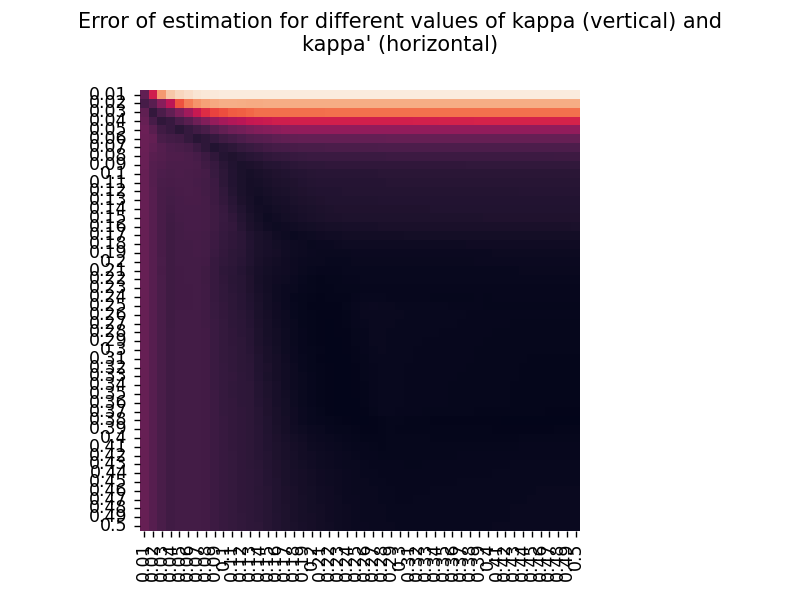

In [41]:
vmin = all_components_results_vis.min().min()
vmax = all_components_results_vis.max().max()
labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]


sns.heatmap(all_components_results_vis.astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
plt.tight_layout(rect=[0, 0, .9, 1])

#### Molar proportions

In [42]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [43]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [44]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [45]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


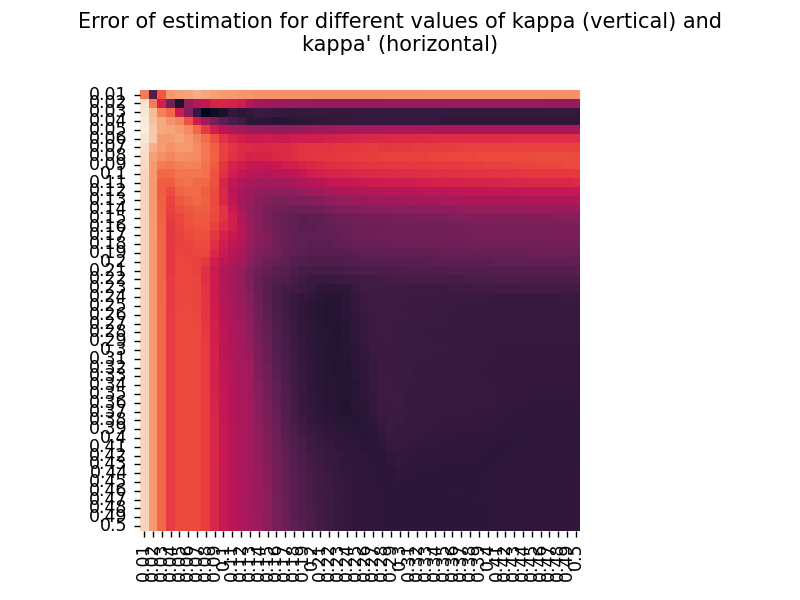

In [46]:
vmin = all_components_results_molar.min().min()
vmax = all_components_results_molar.max().max()
labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]


sns.heatmap(all_components_results_molar.astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
plt.tight_layout(rect=[0, 0, .9, 1])

#### Both

In [47]:
all_components_results_both = all_components_results_vis + all_components_results_molar

In [48]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [49]:
all_components_results_both.min().min()

0.0667316472908416

In [50]:
all_components_results_both[0.24000000000000002][0.37]

0.0667316472908416

### Estimation with best parameters

In [51]:
estimation = estimate_proportions(mix, [comp0, comp1, comp2, comp3], 
                                   MTD=0.37, MTD_th=0.24, verbose=True, solver=pulp.GUROBI())

Initial filtering of formulas: 100%|█████████████| 4/4 [00:00<00:00, 412.39it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(0.0009999999999998899, 11.99873, 0), (0.0009999999999998899, 11.99873, 1), (0.0009999999999998899, 11.99873, 2), (0.0009999999999998899, 11.99873, 3)]


Computing chunks: 100%|████████████████████████| 4/4 [00:00<00:00, 99864.38it/s]


Number of chunks: 1
ChunkIDs: [0, 0, 0, 0]
Chunk bounds: [(-0.3690000000000001, 12.36873)]


Splitting the experimental spectrum into chunks: 12449it [00:00, 2284415.74it/s]


Ion currents in chunks: [0.9999999999999997]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Deconvolving chunk 0
Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 49797 rows, 12452 columns and 155262 nonzeros
Model fingerprint: 0x1efeaaed
Coefficient statistics:
  Matrix range     [3e-11, 1e+00]
  Objective range  [4e-09, 1e+00]
  Bounds range     [2e-03, 2e-03]
  RHS range        [3e-04, 4e-01]
Presolve removed 13456 rows and 0 columns
Presolve time: 2.97s
Presolved: 12452 rows, 49796 columns, 155261 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 9.302e+04
 Factor NZ  : 2.731

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:07<00:00,  7.57s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.982870188361
Noise proportion in experimental spectrum: 0.017129811637
Total explanation: 0.999999999998
Noise proportion in combination of theoretical spectra: 0.017293384916


In [52]:
visible_proportions = estimation['proportions']
visible_proportions

[0.8619606023069997,
 0.04356239454299999,
 0.04425909162499998,
 0.033088099885999984]

In [53]:
real_visible_proportions

[0.8620208303686988,
 0.04430349725220739,
 0.04577169717134345,
 0.04790397520775029]

In [54]:
estimated_molar_proportions = [prop/prot for prop, prot in zip(visible_proportions, protons)]
estimated_molar_proportions = [rs/sum(estimated_molar_proportions) for rs in estimated_molar_proportions]
estimated_molar_proportions

[0.7496938254002199,
 0.10735096013652842,
 0.08180087488116183,
 0.06115433958208968]

In [55]:
molar_proportions

[0.7264578344443725,
 0.10578603326645526,
 0.081968804608116,
 0.08578732768105625]

### Visualisation of our estimation

In [56]:
p = estimation['proportions']

In [57]:
p = np.array(p).reshape(len(p),1)

In [58]:
p = p[[0, 3, 1, 2],:]

In [59]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(4)]

In [60]:
components_ints = []
components_ppm = []
for spectrum in [comp0, comp3, comp1,comp2]:
    components_ints.append(np.array(spectrum.confs)[:,1].reshape(-1,1))
    components_ppm.append(np.array(spectrum.confs)[:,0])

In [61]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

In [62]:
X = np.concatenate(components_ints[:4], axis=1)

In [63]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

In [64]:
names_switched = [official_names[0], official_names[3], official_names[1], official_names[2]]

In [65]:
names_switched

['Isopropyl_myristate', 'Limonene', 'Benzyl_benzoate', 'Alpha_pinene']

<IPython.core.display.Javascript object>


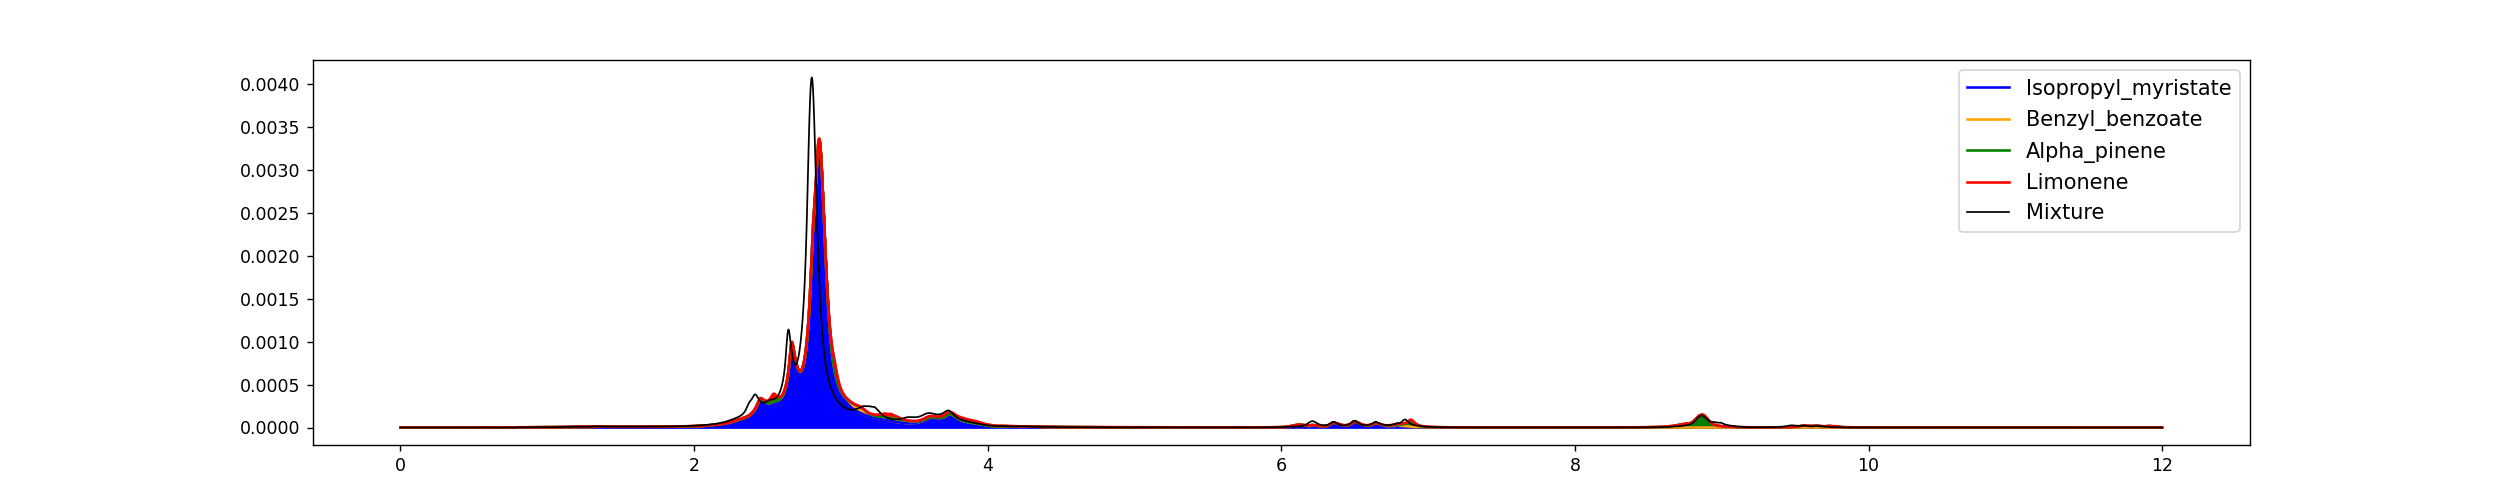

In [66]:
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots()
fig.set_size_inches(20, 4, forward=True)
#ax.set_xlim(5,14)
# ax.set_ylim(-0.0001,0.0042)
for i, name in enumerate(names_matmul[:4]):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture', linewidth=1)
ax.legend(prop={'size': 12})